In [1]:
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D,\
    UpSampling2D, Dropout, Activation, Flatten, Reshape, merge, Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.datasets import mnist
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, RMSprop
from keras.initializers import Initializer, RandomNormal
from keras.regularizers import l2
from keras.models import Model
from PIL import Image
import scipy.misc
import matplotlib.pyplot as plt
from scipy.misc import imsave
import bcolz
import random

Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test_, y_test_) = mnist.load_data()

In [3]:
'''Note that in the paper, the output of the generative model
is tanh activation layer, which will be the input to our
discriminative model. So we need to normalize input images 
to tanh scale (-1.0 to 1.0)'''

x_train = (x_train.astype(np.float32)/255.0) * 2.0 - 1.0
x_train = np.expand_dims(x_train, axis=3)

In [4]:
'''Discriminator network'''
discriminator_input = Input(x_train.shape[1:])
discriminator_x = Conv2D(256, (5,5), strides=(2, 2), padding = 'same',
          kernel_regularizer = l2(0.0001))(discriminator_input)
discriminator_x = LeakyReLU(0.2)(discriminator_x)
discriminator_x = Dropout(0.5)(discriminator_x)

discriminator_x = Conv2D(512, (5,5), strides=(2, 2), padding = 'same',
          kernel_regularizer = l2(0.0001))(discriminator_x)
discriminator_x = LeakyReLU(0.2)(discriminator_x)
discriminator_x = Dropout(0.5)(discriminator_x)
discriminator_x = Flatten()(discriminator_x)

discriminator_x = Dense(256, kernel_regularizer = l2(0.0001))(discriminator_x)
discriminator_x = LeakyReLU(0.2)(discriminator_x)
discriminator_x = Dropout(0.5)(discriminator_x)

discriminator_x = Dense(1,activation='sigmoid')(discriminator_x)

discriminator_model = Model(discriminator_input,discriminator_x)
discriminator_model.compile(Adam(0.00001),loss='binary_crossentropy')

In [5]:
'''Generator network'''
generator_input = Input((100,))
generator_x = Dense(512*7*7, kernel_initializer=RandomNormal(
                                   mean=0.0, stddev=0.02))(generator_input)
generator_x = BatchNormalization()(generator_x)
generator_x = Activation('relu')(generator_x)
generator_x = Reshape((7,7,512))(generator_x)
generator_x = UpSampling2D()(generator_x)

generator_x = Conv2D(256, (3,3), padding='same', 
                  kernel_initializer=RandomNormal(
                                   mean=0.0, stddev=0.02))(generator_x)
generator_x = BatchNormalization()(generator_x)
generator_x = Activation('relu')(generator_x)
generator_x = UpSampling2D()(generator_x)

generator_x = Conv2D(128, (3,3), padding='same',
                  kernel_initializer=RandomNormal(
                                   mean=0.0, stddev=0.02))(generator_x)
generator_x = BatchNormalization()(generator_x)
generator_x = Activation('relu')(generator_x)

generator_x = Conv2D(64, (3,3), padding='same',
                  kernel_initializer=RandomNormal(
                                   mean=0.0, stddev=0.02))(generator_x)
generator_x = BatchNormalization()(generator_x)
generator_x = Activation('relu')(generator_x)

generator_x = Conv2D(1, (1,1), padding='same',
                  kernel_initializer=RandomNormal(
                                   mean=0.0, stddev=0.02))(generator_x)
generator_x = Activation('tanh')(generator_x)

generator_model = Model(generator_input,generator_x)
generator_model.compile(Adam(0.00001),loss='binary_crossentropy')

In [6]:
'''Freeze discriminator'''
discriminator_model.trainable = False
for layer in discriminator_model.layers:
    layer.trainable = False

'''GAN = generator + discriminator'''
gan_input = Input((100,))
gan_x = generator_model(gan_input)
gan_x = discriminator_model(gan_x)
model = Model(gan_input, gan_x)
model.compile(Adam(0.00001), loss = "binary_crossentropy")

In [7]:
'''Train discriminator for 1 epoch as a start'''
init_data = len(x_train)//6

real = np.random.permutation(x_train)[:init_data]
fake = generator_model.predict(np.random.rand(init_data,100))
x_init = np.concatenate((real,fake))

real_label = np.zeros((init_data,1))
fake_label = np.ones((init_data,1))
y_init = np.concatenate((real_label,fake_label))

In [8]:
'''Unfreeze discriminator'''
discriminator_model.trainable = True
for layer in discriminator_model.layers:
    layer.trainable = True

discriminator_model.fit(x_init,y_init,batch_size=128,epochs=1)

Epoch 1/1
20000/20000 [==============================] - 6s - loss: 0.4421     


In [9]:
discriminator_loss = []
generator_loss = []
num_data = len(x_train)

In [10]:
'''Note that our discriminator and generator models are referenced
by our GAN and we do not want the discriminator part of the GAN to be
trained when trying to minimize generator losses. To do so, we can just
do it by freezing discriminator model before training the generator'''

model.optimizer = Adam(lr = 0.00001, beta_1 = 0.5, beta_2 = 0.99)
discriminator_model.optimizer = Adam(lr=0.00001, beta_1 = 0.5, beta_2 = 0.99)

num_iterations = 50000
real_per_iter = 64
fake_per_iter = 64

real_label = np.zeros((real_per_iter,1))
fake_label = np.ones((fake_per_iter,1))
y_mini = np.concatenate((real_label,fake_label))

repeat_discriminator = 1
repeat_generator = 1

for i in range(num_iterations):
    print('Iteration #%d' % i)
    
    '''Unfreeze discriminator'''
    discriminator_model.trainable = True
    for layer in discriminator_model.layers:
        layer.trainable = True
        
    '''Training discriminator'''
    for k in range(repeat_discriminator):
        '''Create real and fake data, as well as their labels'''
        real = x_train[np.random.randint(0,high=num_data,size=real_per_iter)]
        fake = generator_model.predict(np.random.rand(fake_per_iter,100))
        x_mini = np.concatenate((real, fake))
        discriminator_loss.append(discriminator_model.train_on_batch(x_mini,y_mini))
    
    '''Freeze discriminator'''
    discriminator_model.trainable = False
    for layer in discriminator_model.layers:
        layer.trainable = False
    
    '''Training generator'''
    for k in range(repeat_generator):
        generator_x = np.random.rand(fake_per_iter*2,100)
        generator_y = np.zeros((fake_per_iter*2,1)) #we want it to be classified as real
        generator_loss.append(model.train_on_batch(generator_x, generator_y))
    
    '''Show losses'''
    print('Discriminator loss = %.6f Generator loss = %.6f'
          % (discriminator_loss[len(discriminator_loss)-1],
             generator_loss[len(generator_loss)-1]))

Iteration #0
Discriminator loss = 0.316509 Generator loss = 0.934718
Iteration #1
Discriminator loss = 0.316390 Generator loss = 0.938445
Iteration #2
Discriminator loss = 0.318332 Generator loss = 0.935326
Iteration #3
Discriminator loss = 0.317621 Generator loss = 0.935511
Iteration #4
Discriminator loss = 0.315774 Generator loss = 0.930402
Iteration #5
Discriminator loss = 0.318111 Generator loss = 0.923715
Iteration #6
Discriminator loss = 0.314867 Generator loss = 0.922224
Iteration #7
Discriminator loss = 0.312199 Generator loss = 0.922713
Iteration #8
Discriminator loss = 0.309783 Generator loss = 0.915305
Iteration #9
Discriminator loss = 0.308011 Generator loss = 0.913806
Iteration #10
Discriminator loss = 0.306235 Generator loss = 0.914874
Iteration #11
Discriminator loss = 0.300761 Generator loss = 0.908287
Iteration #12
Discriminator loss = 0.299197 Generator loss = 0.904183
Iteration #13
Discriminator loss = 0.294382 Generator loss = 0.902518
Iteration #14
Discriminator lo

Discriminator loss = 0.093158 Generator loss = 0.360742
Iteration #119
Discriminator loss = 0.083731 Generator loss = 0.353915
Iteration #120
Discriminator loss = 0.083192 Generator loss = 0.350691
Iteration #121
Discriminator loss = 0.083163 Generator loss = 0.346484
Iteration #122
Discriminator loss = 0.083229 Generator loss = 0.343946
Iteration #123
Discriminator loss = 0.083161 Generator loss = 0.345865
Iteration #124
Discriminator loss = 0.083404 Generator loss = 0.340859
Iteration #125
Discriminator loss = 0.083161 Generator loss = 0.339235
Iteration #126
Discriminator loss = 0.083558 Generator loss = 0.331881
Iteration #127
Discriminator loss = 0.083093 Generator loss = 0.331382
Iteration #128
Discriminator loss = 0.083127 Generator loss = 0.325682
Iteration #129
Discriminator loss = 0.083055 Generator loss = 0.327870
Iteration #130
Discriminator loss = 0.083065 Generator loss = 0.323526
Iteration #131
Discriminator loss = 0.083033 Generator loss = 0.322487
Iteration #132
Discri

Discriminator loss = 0.081581 Generator loss = 0.197222
Iteration #235
Discriminator loss = 0.081622 Generator loss = 0.200296
Iteration #236
Discriminator loss = 0.081577 Generator loss = 0.200216
Iteration #237
Discriminator loss = 0.081554 Generator loss = 0.197830
Iteration #238
Discriminator loss = 0.081542 Generator loss = 0.195380
Iteration #239
Discriminator loss = 0.081533 Generator loss = 0.195786
Iteration #240
Discriminator loss = 0.081513 Generator loss = 0.194802
Iteration #241
Discriminator loss = 0.081503 Generator loss = 0.193585
Iteration #242
Discriminator loss = 0.081728 Generator loss = 0.193652
Iteration #243
Discriminator loss = 0.081467 Generator loss = 0.193328
Iteration #244
Discriminator loss = 0.081445 Generator loss = 0.193215
Iteration #245
Discriminator loss = 0.081488 Generator loss = 0.191667
Iteration #246
Discriminator loss = 0.081400 Generator loss = 0.190124
Iteration #247
Discriminator loss = 0.081400 Generator loss = 0.192506
Iteration #248
Discri

Discriminator loss = 0.079819 Generator loss = 0.140918
Iteration #351
Discriminator loss = 0.079799 Generator loss = 0.142804
Iteration #352
Discriminator loss = 0.079784 Generator loss = 0.144015
Iteration #353
Discriminator loss = 0.079774 Generator loss = 0.143491
Iteration #354
Discriminator loss = 0.079783 Generator loss = 0.141385
Iteration #355
Discriminator loss = 0.079744 Generator loss = 0.142790
Iteration #356
Discriminator loss = 0.079783 Generator loss = 0.139326
Iteration #357
Discriminator loss = 0.079707 Generator loss = 0.140800
Iteration #358
Discriminator loss = 0.079684 Generator loss = 0.141595
Iteration #359
Discriminator loss = 0.085785 Generator loss = 0.141251
Iteration #360
Discriminator loss = 0.079663 Generator loss = 0.140484
Iteration #361
Discriminator loss = 0.079645 Generator loss = 0.140061
Iteration #362
Discriminator loss = 0.079629 Generator loss = 0.138720
Iteration #363
Discriminator loss = 0.079613 Generator loss = 0.139540
Iteration #364
Discri

Discriminator loss = 0.078095 Generator loss = 0.120389
Iteration #467
Discriminator loss = 0.078005 Generator loss = 0.118799
Iteration #468
Discriminator loss = 0.078079 Generator loss = 0.119073
Iteration #469
Discriminator loss = 0.077978 Generator loss = 0.118899
Iteration #470
Discriminator loss = 0.078187 Generator loss = 0.119177
Iteration #471
Discriminator loss = 0.078022 Generator loss = 0.118743
Iteration #472
Discriminator loss = 0.078066 Generator loss = 0.116622
Iteration #473
Discriminator loss = 0.077990 Generator loss = 0.117106
Iteration #474
Discriminator loss = 0.078060 Generator loss = 0.117448
Iteration #475
Discriminator loss = 0.078465 Generator loss = 0.116572
Iteration #476
Discriminator loss = 0.078359 Generator loss = 0.117610
Iteration #477
Discriminator loss = 0.078437 Generator loss = 0.116911
Iteration #478
Discriminator loss = 0.078376 Generator loss = 0.117260
Iteration #479
Discriminator loss = 0.078772 Generator loss = 0.115663
Iteration #480
Discri

Discriminator loss = 0.092283 Generator loss = 1.181891
Iteration #583
Discriminator loss = 0.087946 Generator loss = 1.284028
Iteration #584
Discriminator loss = 0.205953 Generator loss = 1.352640
Iteration #585
Discriminator loss = 0.087858 Generator loss = 1.436385
Iteration #586
Discriminator loss = 0.085220 Generator loss = 1.498735
Iteration #587
Discriminator loss = 0.084316 Generator loss = 1.578760
Iteration #588
Discriminator loss = 0.083415 Generator loss = 1.635151
Iteration #589
Discriminator loss = 0.083906 Generator loss = 1.709961
Iteration #590
Discriminator loss = 0.082782 Generator loss = 1.806567
Iteration #591
Discriminator loss = 0.083819 Generator loss = 1.823401
Iteration #592
Discriminator loss = 0.082727 Generator loss = 1.904150
Iteration #593
Discriminator loss = 0.082346 Generator loss = 1.936841
Iteration #594
Discriminator loss = 0.081412 Generator loss = 1.977426
Iteration #595
Discriminator loss = 0.102681 Generator loss = 1.997139
Iteration #596
Discri

Discriminator loss = 0.132706 Generator loss = 2.559168
Iteration #699
Discriminator loss = 0.129120 Generator loss = 2.598825
Iteration #700
Discriminator loss = 0.120190 Generator loss = 2.703031
Iteration #701
Discriminator loss = 0.120295 Generator loss = 2.678300
Iteration #702
Discriminator loss = 0.113524 Generator loss = 2.681073
Iteration #703
Discriminator loss = 0.112636 Generator loss = 2.697026
Iteration #704
Discriminator loss = 0.105735 Generator loss = 2.742909
Iteration #705
Discriminator loss = 0.102592 Generator loss = 2.697889
Iteration #706
Discriminator loss = 0.103488 Generator loss = 2.764220
Iteration #707
Discriminator loss = 0.101237 Generator loss = 2.811352
Iteration #708
Discriminator loss = 0.098924 Generator loss = 2.875698
Iteration #709
Discriminator loss = 0.101346 Generator loss = 2.970294
Iteration #710
Discriminator loss = 0.093915 Generator loss = 3.041498
Iteration #711
Discriminator loss = 0.094411 Generator loss = 3.136157
Iteration #712
Discri

Discriminator loss = 0.077520 Generator loss = 3.262898
Iteration #815
Discriminator loss = 0.077439 Generator loss = 3.253075
Iteration #816
Discriminator loss = 0.077560 Generator loss = 3.237523
Iteration #817
Discriminator loss = 0.078280 Generator loss = 3.263084
Iteration #818
Discriminator loss = 0.077541 Generator loss = 3.374944
Iteration #819
Discriminator loss = 0.078640 Generator loss = 3.278517
Iteration #820
Discriminator loss = 0.077763 Generator loss = 3.386309
Iteration #821
Discriminator loss = 0.077532 Generator loss = 3.358831
Iteration #822
Discriminator loss = 0.078045 Generator loss = 3.319997
Iteration #823
Discriminator loss = 0.078042 Generator loss = 3.415270
Iteration #824
Discriminator loss = 0.077718 Generator loss = 3.502304
Iteration #825
Discriminator loss = 0.077745 Generator loss = 3.446985
Iteration #826
Discriminator loss = 0.077743 Generator loss = 3.448142
Iteration #827
Discriminator loss = 0.077479 Generator loss = 3.473028
Iteration #828
Discri

Discriminator loss = 0.074926 Generator loss = 4.438975
Iteration #931
Discriminator loss = 0.074272 Generator loss = 4.446938
Iteration #932
Discriminator loss = 0.074695 Generator loss = 4.347573
Iteration #933
Discriminator loss = 0.074345 Generator loss = 4.271702
Iteration #934
Discriminator loss = 0.074375 Generator loss = 4.363334
Iteration #935
Discriminator loss = 0.074449 Generator loss = 4.408296
Iteration #936
Discriminator loss = 0.074234 Generator loss = 4.430271
Iteration #937
Discriminator loss = 0.074018 Generator loss = 4.366457
Iteration #938
Discriminator loss = 0.074688 Generator loss = 4.302651
Iteration #939
Discriminator loss = 0.074326 Generator loss = 4.386891
Iteration #940
Discriminator loss = 0.074616 Generator loss = 4.347956
Iteration #941
Discriminator loss = 0.077738 Generator loss = 4.259835
Iteration #942
Discriminator loss = 0.074064 Generator loss = 4.458448
Iteration #943
Discriminator loss = 0.074522 Generator loss = 4.452953
Iteration #944
Discri

Discriminator loss = 0.072844 Generator loss = 4.594151
Iteration #1047
Discriminator loss = 0.072974 Generator loss = 4.591853
Iteration #1048
Discriminator loss = 0.073160 Generator loss = 4.537755
Iteration #1049
Discriminator loss = 0.078501 Generator loss = 4.590277
Iteration #1050
Discriminator loss = 0.072588 Generator loss = 4.688922
Iteration #1051
Discriminator loss = 0.074740 Generator loss = 4.683149
Iteration #1052
Discriminator loss = 0.072747 Generator loss = 4.713969
Iteration #1053
Discriminator loss = 0.073130 Generator loss = 4.820205
Iteration #1054
Discriminator loss = 0.072488 Generator loss = 4.943313
Iteration #1055
Discriminator loss = 0.072830 Generator loss = 4.946760
Iteration #1056
Discriminator loss = 0.072430 Generator loss = 5.031534
Iteration #1057
Discriminator loss = 0.072429 Generator loss = 5.217266
Iteration #1058
Discriminator loss = 0.074414 Generator loss = 5.117377
Iteration #1059
Discriminator loss = 0.072222 Generator loss = 5.009648
Iteratio

Discriminator loss = 0.070980 Generator loss = 5.538199
Iteration #1161
Discriminator loss = 0.071313 Generator loss = 5.608310
Iteration #1162
Discriminator loss = 0.071023 Generator loss = 5.506273
Iteration #1163
Discriminator loss = 0.070900 Generator loss = 5.403361
Iteration #1164
Discriminator loss = 0.070851 Generator loss = 5.369917
Iteration #1165
Discriminator loss = 0.071144 Generator loss = 5.369400
Iteration #1166
Discriminator loss = 0.071839 Generator loss = 5.330388
Iteration #1167
Discriminator loss = 0.070924 Generator loss = 5.362491
Iteration #1168
Discriminator loss = 0.071113 Generator loss = 5.237600
Iteration #1169
Discriminator loss = 0.070848 Generator loss = 5.347783
Iteration #1170
Discriminator loss = 0.070918 Generator loss = 5.258938
Iteration #1171
Discriminator loss = 0.070828 Generator loss = 5.246807
Iteration #1172
Discriminator loss = 0.073593 Generator loss = 5.379857
Iteration #1173
Discriminator loss = 0.077486 Generator loss = 5.486717
Iteratio

Discriminator loss = 0.070181 Generator loss = 6.473185
Iteration #1275
Discriminator loss = 0.070318 Generator loss = 6.402788
Iteration #1276
Discriminator loss = 0.069982 Generator loss = 6.333727
Iteration #1277
Discriminator loss = 0.069969 Generator loss = 6.393466
Iteration #1278
Discriminator loss = 0.070783 Generator loss = 6.373851
Iteration #1279
Discriminator loss = 0.071893 Generator loss = 6.159076
Iteration #1280
Discriminator loss = 0.069671 Generator loss = 6.158886
Iteration #1281
Discriminator loss = 0.070113 Generator loss = 5.908784
Iteration #1282
Discriminator loss = 0.069750 Generator loss = 5.751487
Iteration #1283
Discriminator loss = 0.069885 Generator loss = 5.765279
Iteration #1284
Discriminator loss = 0.069761 Generator loss = 5.728429
Iteration #1285
Discriminator loss = 0.069981 Generator loss = 5.620577
Iteration #1286
Discriminator loss = 0.073033 Generator loss = 5.747952
Iteration #1287
Discriminator loss = 0.070345 Generator loss = 5.827128
Iteratio

Discriminator loss = 0.068388 Generator loss = 6.761218
Iteration #1389
Discriminator loss = 0.069114 Generator loss = 6.931726
Iteration #1390
Discriminator loss = 0.068569 Generator loss = 6.947347
Iteration #1391
Discriminator loss = 0.068356 Generator loss = 7.103938
Iteration #1392
Discriminator loss = 0.068756 Generator loss = 7.068109
Iteration #1393
Discriminator loss = 0.070003 Generator loss = 6.945309
Iteration #1394
Discriminator loss = 0.068558 Generator loss = 6.884066
Iteration #1395
Discriminator loss = 0.068513 Generator loss = 6.849849
Iteration #1396
Discriminator loss = 0.068347 Generator loss = 6.708896
Iteration #1397
Discriminator loss = 0.068201 Generator loss = 6.525984
Iteration #1398
Discriminator loss = 0.068265 Generator loss = 6.577291
Iteration #1399
Discriminator loss = 0.067958 Generator loss = 6.179505
Iteration #1400
Discriminator loss = 0.068229 Generator loss = 6.295890
Iteration #1401
Discriminator loss = 0.067984 Generator loss = 6.117457
Iteratio

Discriminator loss = 0.069740 Generator loss = 5.998472
Iteration #1503
Discriminator loss = 0.069955 Generator loss = 6.043670
Iteration #1504
Discriminator loss = 0.069090 Generator loss = 6.018862
Iteration #1505
Discriminator loss = 0.069591 Generator loss = 6.161234
Iteration #1506
Discriminator loss = 0.070648 Generator loss = 5.981344
Iteration #1507
Discriminator loss = 0.070005 Generator loss = 5.832783
Iteration #1508
Discriminator loss = 0.071650 Generator loss = 5.663993
Iteration #1509
Discriminator loss = 0.069611 Generator loss = 5.849569
Iteration #1510
Discriminator loss = 0.070190 Generator loss = 5.757237
Iteration #1511
Discriminator loss = 0.068813 Generator loss = 5.825600
Iteration #1512
Discriminator loss = 0.069974 Generator loss = 5.897119
Iteration #1513
Discriminator loss = 0.071452 Generator loss = 5.728688
Iteration #1514
Discriminator loss = 0.072070 Generator loss = 5.798505
Iteration #1515
Discriminator loss = 0.071028 Generator loss = 5.750949
Iteratio

Discriminator loss = 0.081251 Generator loss = 1.828098
Iteration #1617
Discriminator loss = 0.075847 Generator loss = 2.095155
Iteration #1618
Discriminator loss = 0.071569 Generator loss = 2.201434
Iteration #1619
Discriminator loss = 0.072414 Generator loss = 2.198717
Iteration #1620
Discriminator loss = 0.078199 Generator loss = 2.020419
Iteration #1621
Discriminator loss = 0.067687 Generator loss = 1.984016
Iteration #1622
Discriminator loss = 0.069374 Generator loss = 1.856955
Iteration #1623
Discriminator loss = 0.069481 Generator loss = 1.610627
Iteration #1624
Discriminator loss = 0.071152 Generator loss = 1.406357
Iteration #1625
Discriminator loss = 0.070714 Generator loss = 1.486352
Iteration #1626
Discriminator loss = 0.072623 Generator loss = 1.535017
Iteration #1627
Discriminator loss = 0.082816 Generator loss = 1.483558
Iteration #1628
Discriminator loss = 0.070008 Generator loss = 1.305637
Iteration #1629
Discriminator loss = 0.074253 Generator loss = 1.202965
Iteratio

Discriminator loss = 0.064818 Generator loss = 0.086477
Iteration #1731
Discriminator loss = 0.066277 Generator loss = 0.087054
Iteration #1732
Discriminator loss = 0.067929 Generator loss = 0.095590
Iteration #1733
Discriminator loss = 0.077350 Generator loss = 0.099026
Iteration #1734
Discriminator loss = 0.066681 Generator loss = 0.078909
Iteration #1735
Discriminator loss = 0.064515 Generator loss = 0.080661
Iteration #1736
Discriminator loss = 0.068214 Generator loss = 0.081363
Iteration #1737
Discriminator loss = 0.065331 Generator loss = 0.074754
Iteration #1738
Discriminator loss = 0.065226 Generator loss = 0.073246
Iteration #1739
Discriminator loss = 0.066846 Generator loss = 0.075251
Iteration #1740
Discriminator loss = 0.068122 Generator loss = 0.080635
Iteration #1741
Discriminator loss = 0.068681 Generator loss = 0.073781
Iteration #1742
Discriminator loss = 0.070312 Generator loss = 0.075830
Iteration #1743
Discriminator loss = 0.066744 Generator loss = 0.077672
Iteratio

Discriminator loss = 0.068451 Generator loss = 0.306721
Iteration #1845
Discriminator loss = 0.067667 Generator loss = 0.306324
Iteration #1846
Discriminator loss = 0.068799 Generator loss = 0.371849
Iteration #1847
Discriminator loss = 0.078049 Generator loss = 0.376553
Iteration #1848
Discriminator loss = 0.064912 Generator loss = 0.343982
Iteration #1849
Discriminator loss = 0.067092 Generator loss = 0.349501
Iteration #1850
Discriminator loss = 0.077933 Generator loss = 0.333597
Iteration #1851
Discriminator loss = 0.069567 Generator loss = 0.287469
Iteration #1852
Discriminator loss = 0.073865 Generator loss = 0.294394
Iteration #1853
Discriminator loss = 0.068709 Generator loss = 0.285161
Iteration #1854
Discriminator loss = 0.073033 Generator loss = 0.253226
Iteration #1855
Discriminator loss = 0.081279 Generator loss = 0.340846
Iteration #1856
Discriminator loss = 0.071086 Generator loss = 0.421941
Iteration #1857
Discriminator loss = 0.069245 Generator loss = 0.537720
Iteratio

Discriminator loss = 0.066976 Generator loss = 3.812345
Iteration #1959
Discriminator loss = 0.066744 Generator loss = 3.761885
Iteration #1960
Discriminator loss = 0.066173 Generator loss = 4.082529
Iteration #1961
Discriminator loss = 0.073585 Generator loss = 3.817824
Iteration #1962
Discriminator loss = 0.069223 Generator loss = 3.932500
Iteration #1963
Discriminator loss = 0.071672 Generator loss = 3.795543
Iteration #1964
Discriminator loss = 0.068751 Generator loss = 3.771743
Iteration #1965
Discriminator loss = 0.070454 Generator loss = 3.951049
Iteration #1966
Discriminator loss = 0.068774 Generator loss = 4.133301
Iteration #1967
Discriminator loss = 0.066236 Generator loss = 4.182757
Iteration #1968
Discriminator loss = 0.065782 Generator loss = 4.417778
Iteration #1969
Discriminator loss = 0.067198 Generator loss = 4.422008
Iteration #1970
Discriminator loss = 0.072264 Generator loss = 4.614069
Iteration #1971
Discriminator loss = 0.066321 Generator loss = 4.727334
Iteratio

Discriminator loss = 0.065442 Generator loss = 9.096164
Iteration #2073
Discriminator loss = 0.062966 Generator loss = 9.084613
Iteration #2074
Discriminator loss = 0.063626 Generator loss = 9.192021
Iteration #2075
Discriminator loss = 0.064353 Generator loss = 9.332919
Iteration #2076
Discriminator loss = 0.063818 Generator loss = 9.212767
Iteration #2077
Discriminator loss = 0.064860 Generator loss = 9.267608
Iteration #2078
Discriminator loss = 0.063692 Generator loss = 9.166099
Iteration #2079
Discriminator loss = 0.064148 Generator loss = 8.832871
Iteration #2080
Discriminator loss = 0.064009 Generator loss = 8.949517
Iteration #2081
Discriminator loss = 0.064146 Generator loss = 9.003905
Iteration #2082
Discriminator loss = 0.063434 Generator loss = 8.977114
Iteration #2083
Discriminator loss = 0.063613 Generator loss = 8.797101
Iteration #2084
Discriminator loss = 0.063357 Generator loss = 8.897149
Iteration #2085
Discriminator loss = 0.065443 Generator loss = 9.091532
Iteratio

Discriminator loss = 0.062076 Generator loss = 9.413431
Iteration #2187
Discriminator loss = 0.062116 Generator loss = 9.336217
Iteration #2188
Discriminator loss = 0.062557 Generator loss = 9.626113
Iteration #2189
Discriminator loss = 0.062433 Generator loss = 9.462822
Iteration #2190
Discriminator loss = 0.061630 Generator loss = 9.513565
Iteration #2191
Discriminator loss = 0.062529 Generator loss = 9.487587
Iteration #2192
Discriminator loss = 0.061924 Generator loss = 9.242167
Iteration #2193
Discriminator loss = 0.062240 Generator loss = 9.372919
Iteration #2194
Discriminator loss = 0.061859 Generator loss = 9.307348
Iteration #2195
Discriminator loss = 0.062057 Generator loss = 9.544372
Iteration #2196
Discriminator loss = 0.061534 Generator loss = 9.342445
Iteration #2197
Discriminator loss = 0.063138 Generator loss = 9.417088
Iteration #2198
Discriminator loss = 0.061969 Generator loss = 9.450679
Iteration #2199
Discriminator loss = 0.065692 Generator loss = 9.303381
Iteratio

Discriminator loss = 0.061674 Generator loss = 8.883422
Iteration #2301
Discriminator loss = 0.060681 Generator loss = 8.726340
Iteration #2302
Discriminator loss = 0.061365 Generator loss = 9.208514
Iteration #2303
Discriminator loss = 0.060937 Generator loss = 8.770506
Iteration #2304
Discriminator loss = 0.060621 Generator loss = 8.961609
Iteration #2305
Discriminator loss = 0.061285 Generator loss = 9.143584
Iteration #2306
Discriminator loss = 0.060985 Generator loss = 9.198558
Iteration #2307
Discriminator loss = 0.060769 Generator loss = 9.187652
Iteration #2308
Discriminator loss = 0.060863 Generator loss = 9.136678
Iteration #2309
Discriminator loss = 0.060427 Generator loss = 9.245748
Iteration #2310
Discriminator loss = 0.064608 Generator loss = 9.048614
Iteration #2311
Discriminator loss = 0.060804 Generator loss = 9.267816
Iteration #2312
Discriminator loss = 0.061085 Generator loss = 9.080232
Iteration #2313
Discriminator loss = 0.060883 Generator loss = 9.336238
Iteratio

Discriminator loss = 0.059892 Generator loss = 8.626657
Iteration #2415
Discriminator loss = 0.060339 Generator loss = 8.644629
Iteration #2416
Discriminator loss = 0.059714 Generator loss = 8.784058
Iteration #2417
Discriminator loss = 0.060859 Generator loss = 8.716429
Iteration #2418
Discriminator loss = 0.060286 Generator loss = 8.539227
Iteration #2419
Discriminator loss = 0.059994 Generator loss = 8.578356
Iteration #2420
Discriminator loss = 0.059717 Generator loss = 8.714340
Iteration #2421
Discriminator loss = 0.059764 Generator loss = 8.547415
Iteration #2422
Discriminator loss = 0.059756 Generator loss = 8.416668
Iteration #2423
Discriminator loss = 0.061611 Generator loss = 8.274359
Iteration #2424
Discriminator loss = 0.059921 Generator loss = 8.012486
Iteration #2425
Discriminator loss = 0.060236 Generator loss = 8.276263
Iteration #2426
Discriminator loss = 0.060597 Generator loss = 8.127644
Iteration #2427
Discriminator loss = 0.060174 Generator loss = 7.995055
Iteratio

Discriminator loss = 0.058851 Generator loss = 7.590539
Iteration #2529
Discriminator loss = 0.059287 Generator loss = 7.661328
Iteration #2530
Discriminator loss = 0.058691 Generator loss = 7.526617
Iteration #2531
Discriminator loss = 0.059815 Generator loss = 7.684277
Iteration #2532
Discriminator loss = 0.058586 Generator loss = 7.422899
Iteration #2533
Discriminator loss = 0.058769 Generator loss = 7.173153
Iteration #2534
Discriminator loss = 0.059085 Generator loss = 7.255824
Iteration #2535
Discriminator loss = 0.058581 Generator loss = 7.200628
Iteration #2536
Discriminator loss = 0.058731 Generator loss = 7.448228
Iteration #2537
Discriminator loss = 0.058988 Generator loss = 7.160661
Iteration #2538
Discriminator loss = 0.058476 Generator loss = 6.792730
Iteration #2539
Discriminator loss = 0.060236 Generator loss = 7.120073
Iteration #2540
Discriminator loss = 0.059974 Generator loss = 7.041220
Iteration #2541
Discriminator loss = 0.059272 Generator loss = 6.767044
Iteratio

Discriminator loss = 0.057463 Generator loss = 4.804245
Iteration #2643
Discriminator loss = 0.057473 Generator loss = 4.572356
Iteration #2644
Discriminator loss = 0.057469 Generator loss = 4.353732
Iteration #2645
Discriminator loss = 0.057524 Generator loss = 4.403620
Iteration #2646
Discriminator loss = 0.057462 Generator loss = 4.521257
Iteration #2647
Discriminator loss = 0.057473 Generator loss = 4.182456
Iteration #2648
Discriminator loss = 0.057441 Generator loss = 4.371626
Iteration #2649
Discriminator loss = 0.057444 Generator loss = 4.363891
Iteration #2650
Discriminator loss = 0.057477 Generator loss = 4.511806
Iteration #2651
Discriminator loss = 0.057378 Generator loss = 4.402324
Iteration #2652
Discriminator loss = 0.057383 Generator loss = 4.176218
Iteration #2653
Discriminator loss = 0.057360 Generator loss = 4.391347
Iteration #2654
Discriminator loss = 0.057356 Generator loss = 4.208177
Iteration #2655
Discriminator loss = 0.057411 Generator loss = 4.158865
Iteratio

Discriminator loss = 0.056470 Generator loss = 2.191668
Iteration #2757
Discriminator loss = 0.056435 Generator loss = 2.182680
Iteration #2758
Discriminator loss = 0.056452 Generator loss = 2.272858
Iteration #2759
Discriminator loss = 0.056439 Generator loss = 2.136073
Iteration #2760
Discriminator loss = 0.056454 Generator loss = 1.990253
Iteration #2761
Discriminator loss = 0.056440 Generator loss = 1.985370
Iteration #2762
Discriminator loss = 0.056410 Generator loss = 1.955554
Iteration #2763
Discriminator loss = 0.056393 Generator loss = 2.055568
Iteration #2764
Discriminator loss = 0.056361 Generator loss = 1.989237
Iteration #2765
Discriminator loss = 0.056575 Generator loss = 1.881832
Iteration #2766
Discriminator loss = 0.056382 Generator loss = 1.955243
Iteration #2767
Discriminator loss = 0.056363 Generator loss = 1.893891
Iteration #2768
Discriminator loss = 0.056371 Generator loss = 1.813691
Iteration #2769
Discriminator loss = 0.056326 Generator loss = 1.842452
Iteratio

Discriminator loss = 0.056081 Generator loss = 2.785660
Iteration #2871
Discriminator loss = 0.056328 Generator loss = 2.908600
Iteration #2872
Discriminator loss = 0.056132 Generator loss = 2.622808
Iteration #2873
Discriminator loss = 0.056312 Generator loss = 2.710664
Iteration #2874
Discriminator loss = 0.055921 Generator loss = 2.687243
Iteration #2875
Discriminator loss = 0.056677 Generator loss = 2.800461
Iteration #2876
Discriminator loss = 0.055936 Generator loss = 2.730758
Iteration #2877
Discriminator loss = 0.056172 Generator loss = 2.869301
Iteration #2878
Discriminator loss = 0.056949 Generator loss = 2.884423
Iteration #2879
Discriminator loss = 0.056460 Generator loss = 2.843941
Iteration #2880
Discriminator loss = 0.056501 Generator loss = 3.186614
Iteration #2881
Discriminator loss = 0.059662 Generator loss = 2.623285
Iteration #2882
Discriminator loss = 0.056256 Generator loss = 2.816262
Iteration #2883
Discriminator loss = 0.056867 Generator loss = 2.527443
Iteratio

Discriminator loss = 0.056309 Generator loss = 4.629208
Iteration #2985
Discriminator loss = 0.059827 Generator loss = 4.562791
Iteration #2986
Discriminator loss = 0.056316 Generator loss = 4.385096
Iteration #2987
Discriminator loss = 0.056762 Generator loss = 4.296721
Iteration #2988
Discriminator loss = 0.056024 Generator loss = 3.956844
Iteration #2989
Discriminator loss = 0.057058 Generator loss = 4.208474
Iteration #2990
Discriminator loss = 0.056588 Generator loss = 4.467173
Iteration #2991
Discriminator loss = 0.056838 Generator loss = 4.450756
Iteration #2992
Discriminator loss = 0.056351 Generator loss = 4.453697
Iteration #2993
Discriminator loss = 0.056315 Generator loss = 4.452968
Iteration #2994
Discriminator loss = 0.056903 Generator loss = 4.619049
Iteration #2995
Discriminator loss = 0.056287 Generator loss = 4.735254
Iteration #2996
Discriminator loss = 0.066378 Generator loss = 4.608504
Iteration #2997
Discriminator loss = 0.056720 Generator loss = 4.427453
Iteratio

Discriminator loss = 0.057797 Generator loss = 4.453588
Iteration #3099
Discriminator loss = 0.055494 Generator loss = 4.555552
Iteration #3100
Discriminator loss = 0.055427 Generator loss = 4.614443
Iteration #3101
Discriminator loss = 0.054877 Generator loss = 4.773238
Iteration #3102
Discriminator loss = 0.057136 Generator loss = 4.831777
Iteration #3103
Discriminator loss = 0.060577 Generator loss = 4.947510
Iteration #3104
Discriminator loss = 0.055178 Generator loss = 4.782521
Iteration #3105
Discriminator loss = 0.055610 Generator loss = 4.820097
Iteration #3106
Discriminator loss = 0.055262 Generator loss = 4.882051
Iteration #3107
Discriminator loss = 0.057193 Generator loss = 4.792673
Iteration #3108
Discriminator loss = 0.055759 Generator loss = 5.003370
Iteration #3109
Discriminator loss = 0.057820 Generator loss = 5.023516
Iteration #3110
Discriminator loss = 0.055696 Generator loss = 5.345128
Iteration #3111
Discriminator loss = 0.057488 Generator loss = 5.375704
Iteratio

Discriminator loss = 0.056381 Generator loss = 6.311245
Iteration #3213
Discriminator loss = 0.058107 Generator loss = 6.439714
Iteration #3214
Discriminator loss = 0.061856 Generator loss = 6.027490
Iteration #3215
Discriminator loss = 0.056201 Generator loss = 6.155420
Iteration #3216
Discriminator loss = 0.055495 Generator loss = 5.996433
Iteration #3217
Discriminator loss = 0.058566 Generator loss = 6.392216
Iteration #3218
Discriminator loss = 0.056522 Generator loss = 6.340577
Iteration #3219
Discriminator loss = 0.057734 Generator loss = 6.160317
Iteration #3220
Discriminator loss = 0.056594 Generator loss = 6.108807
Iteration #3221
Discriminator loss = 0.057770 Generator loss = 5.857753
Iteration #3222
Discriminator loss = 0.056580 Generator loss = 5.909139
Iteration #3223
Discriminator loss = 0.056253 Generator loss = 6.101935
Iteration #3224
Discriminator loss = 0.057386 Generator loss = 6.264459
Iteration #3225
Discriminator loss = 0.056591 Generator loss = 6.683925
Iteratio

Discriminator loss = 0.075494 Generator loss = 5.562628
Iteration #3327
Discriminator loss = 0.058817 Generator loss = 6.356254
Iteration #3328
Discriminator loss = 0.056741 Generator loss = 7.731860
Iteration #3329
Discriminator loss = 0.057589 Generator loss = 8.196032
Iteration #3330
Discriminator loss = 0.077665 Generator loss = 7.599567
Iteration #3331
Discriminator loss = 0.056784 Generator loss = 7.336812
Iteration #3332
Discriminator loss = 0.058154 Generator loss = 6.517731
Iteration #3333
Discriminator loss = 0.065544 Generator loss = 6.532120
Iteration #3334
Discriminator loss = 0.057023 Generator loss = 6.506051
Iteration #3335
Discriminator loss = 0.055269 Generator loss = 6.586352
Iteration #3336
Discriminator loss = 0.057227 Generator loss = 6.629242
Iteration #3337
Discriminator loss = 0.057279 Generator loss = 6.987742
Iteration #3338
Discriminator loss = 0.055545 Generator loss = 7.048000
Iteration #3339
Discriminator loss = 0.057244 Generator loss = 6.890506
Iteratio

Discriminator loss = 0.055737 Generator loss = 5.826572
Iteration #3441
Discriminator loss = 0.061164 Generator loss = 5.501791
Iteration #3442
Discriminator loss = 0.059942 Generator loss = 5.770129
Iteration #3443
Discriminator loss = 0.063067 Generator loss = 6.128764
Iteration #3444
Discriminator loss = 0.058836 Generator loss = 7.284960
Iteration #3445
Discriminator loss = 0.059635 Generator loss = 7.714896
Iteration #3446
Discriminator loss = 0.060171 Generator loss = 7.968235
Iteration #3447
Discriminator loss = 0.057107 Generator loss = 8.099391
Iteration #3448
Discriminator loss = 0.060941 Generator loss = 7.459177
Iteration #3449
Discriminator loss = 0.058299 Generator loss = 6.624155
Iteration #3450
Discriminator loss = 0.059620 Generator loss = 5.963833
Iteration #3451
Discriminator loss = 0.059572 Generator loss = 5.625319
Iteration #3452
Discriminator loss = 0.067665 Generator loss = 6.337521
Iteration #3453
Discriminator loss = 0.057699 Generator loss = 7.120037
Iteratio

Discriminator loss = 0.071487 Generator loss = 5.544854
Iteration #3555
Discriminator loss = 0.073999 Generator loss = 6.701169
Iteration #3556
Discriminator loss = 0.056383 Generator loss = 7.976169
Iteration #3557
Discriminator loss = 0.058012 Generator loss = 8.704801
Iteration #3558
Discriminator loss = 0.076835 Generator loss = 8.029805
Iteration #3559
Discriminator loss = 0.091421 Generator loss = 6.960749
Iteration #3560
Discriminator loss = 0.058447 Generator loss = 5.598504
Iteration #3561
Discriminator loss = 0.062970 Generator loss = 5.223895
Iteration #3562
Discriminator loss = 0.079400 Generator loss = 5.409214
Iteration #3563
Discriminator loss = 0.062559 Generator loss = 6.472534
Iteration #3564
Discriminator loss = 0.060143 Generator loss = 7.282244
Iteration #3565
Discriminator loss = 0.057277 Generator loss = 8.014366
Iteration #3566
Discriminator loss = 0.059732 Generator loss = 8.441892
Iteration #3567
Discriminator loss = 0.067590 Generator loss = 8.261478
Iteratio

Discriminator loss = 0.058707 Generator loss = 6.652768
Iteration #3669
Discriminator loss = 0.057837 Generator loss = 6.620054
Iteration #3670
Discriminator loss = 0.056667 Generator loss = 6.914182
Iteration #3671
Discriminator loss = 0.055971 Generator loss = 7.088011
Iteration #3672
Discriminator loss = 0.057444 Generator loss = 6.933986
Iteration #3673
Discriminator loss = 0.058233 Generator loss = 7.137938
Iteration #3674
Discriminator loss = 0.057004 Generator loss = 6.996819
Iteration #3675
Discriminator loss = 0.056898 Generator loss = 7.067908
Iteration #3676
Discriminator loss = 0.060945 Generator loss = 6.610899
Iteration #3677
Discriminator loss = 0.058476 Generator loss = 6.579687
Iteration #3678
Discriminator loss = 0.057879 Generator loss = 6.533780
Iteration #3679
Discriminator loss = 0.059651 Generator loss = 6.738773
Iteration #3680
Discriminator loss = 0.056730 Generator loss = 7.190288
Iteration #3681
Discriminator loss = 0.058471 Generator loss = 7.149235
Iteratio

Discriminator loss = 0.053699 Generator loss = 6.499469
Iteration #3783
Discriminator loss = 0.056859 Generator loss = 6.572903
Iteration #3784
Discriminator loss = 0.070983 Generator loss = 6.386392
Iteration #3785
Discriminator loss = 0.056984 Generator loss = 6.193428
Iteration #3786
Discriminator loss = 0.066481 Generator loss = 6.376082
Iteration #3787
Discriminator loss = 0.059686 Generator loss = 6.636687
Iteration #3788
Discriminator loss = 0.067240 Generator loss = 7.675930
Iteration #3789
Discriminator loss = 0.056642 Generator loss = 7.797331
Iteration #3790
Discriminator loss = 0.067413 Generator loss = 7.948554
Iteration #3791
Discriminator loss = 0.064327 Generator loss = 6.738944
Iteration #3792
Discriminator loss = 0.063647 Generator loss = 6.441059
Iteration #3793
Discriminator loss = 0.057303 Generator loss = 5.960330
Iteration #3794
Discriminator loss = 0.068433 Generator loss = 6.105953
Iteration #3795
Discriminator loss = 0.054305 Generator loss = 6.669505
Iteratio

Discriminator loss = 0.068688 Generator loss = 7.220013
Iteration #3897
Discriminator loss = 0.063621 Generator loss = 6.861808
Iteration #3898
Discriminator loss = 0.060281 Generator loss = 6.664101
Iteration #3899
Discriminator loss = 0.059663 Generator loss = 6.451588
Iteration #3900
Discriminator loss = 0.072228 Generator loss = 6.563011
Iteration #3901
Discriminator loss = 0.070007 Generator loss = 6.595814
Iteration #3902
Discriminator loss = 0.057291 Generator loss = 7.082049
Iteration #3903
Discriminator loss = 0.056887 Generator loss = 7.019340
Iteration #3904
Discriminator loss = 0.059439 Generator loss = 6.844395
Iteration #3905
Discriminator loss = 0.065193 Generator loss = 7.096106
Iteration #3906
Discriminator loss = 0.060489 Generator loss = 6.774414
Iteration #3907
Discriminator loss = 0.070857 Generator loss = 6.436462
Iteration #3908
Discriminator loss = 0.067631 Generator loss = 6.951552
Iteration #3909
Discriminator loss = 0.069412 Generator loss = 5.981068
Iteratio

Discriminator loss = 0.063580 Generator loss = 6.984119
Iteration #4011
Discriminator loss = 0.073462 Generator loss = 6.952253
Iteration #4012
Discriminator loss = 0.062794 Generator loss = 7.577359
Iteration #4013
Discriminator loss = 0.057614 Generator loss = 7.520801
Iteration #4014
Discriminator loss = 0.063701 Generator loss = 7.266761
Iteration #4015
Discriminator loss = 0.058250 Generator loss = 7.340322
Iteration #4016
Discriminator loss = 0.062983 Generator loss = 6.908548
Iteration #4017
Discriminator loss = 0.061377 Generator loss = 6.279617
Iteration #4018
Discriminator loss = 0.063587 Generator loss = 6.180391
Iteration #4019
Discriminator loss = 0.060033 Generator loss = 6.367299
Iteration #4020
Discriminator loss = 0.057988 Generator loss = 6.353027
Iteration #4021
Discriminator loss = 0.064217 Generator loss = 6.465744
Iteration #4022
Discriminator loss = 0.062376 Generator loss = 6.759445
Iteration #4023
Discriminator loss = 0.062050 Generator loss = 7.142131
Iteratio

Discriminator loss = 0.060500 Generator loss = 5.271968
Iteration #4125
Discriminator loss = 0.075272 Generator loss = 5.378174
Iteration #4126
Discriminator loss = 0.075983 Generator loss = 5.851943
Iteration #4127
Discriminator loss = 0.062098 Generator loss = 6.197179
Iteration #4128
Discriminator loss = 0.070571 Generator loss = 6.518430
Iteration #4129
Discriminator loss = 0.079591 Generator loss = 7.193360
Iteration #4130
Discriminator loss = 0.061463 Generator loss = 7.794041
Iteration #4131
Discriminator loss = 0.070969 Generator loss = 7.728298
Iteration #4132
Discriminator loss = 0.079281 Generator loss = 6.935353
Iteration #4133
Discriminator loss = 0.059472 Generator loss = 5.901362
Iteration #4134
Discriminator loss = 0.077481 Generator loss = 5.692921
Iteration #4135
Discriminator loss = 0.074142 Generator loss = 5.440775
Iteration #4136
Discriminator loss = 0.070646 Generator loss = 5.478656
Iteration #4137
Discriminator loss = 0.081219 Generator loss = 5.944814
Iteratio

Discriminator loss = 0.073066 Generator loss = 5.399477
Iteration #4239
Discriminator loss = 0.084195 Generator loss = 5.124553
Iteration #4240
Discriminator loss = 0.066626 Generator loss = 4.917331
Iteration #4241
Discriminator loss = 0.090061 Generator loss = 5.627357
Iteration #4242
Discriminator loss = 0.079256 Generator loss = 6.536555
Iteration #4243
Discriminator loss = 0.070886 Generator loss = 7.081991
Iteration #4244
Discriminator loss = 0.096731 Generator loss = 7.086764
Iteration #4245
Discriminator loss = 0.102830 Generator loss = 6.035265
Iteration #4246
Discriminator loss = 0.068762 Generator loss = 4.950809
Iteration #4247
Discriminator loss = 0.080809 Generator loss = 5.241409
Iteration #4248
Discriminator loss = 0.077858 Generator loss = 5.559681
Iteration #4249
Discriminator loss = 0.056831 Generator loss = 6.217670
Iteration #4250
Discriminator loss = 0.058468 Generator loss = 6.356235
Iteration #4251
Discriminator loss = 0.064429 Generator loss = 6.353997
Iteratio

Discriminator loss = 0.078593 Generator loss = 5.781373
Iteration #4353
Discriminator loss = 0.072170 Generator loss = 6.328756
Iteration #4354
Discriminator loss = 0.072739 Generator loss = 6.945988
Iteration #4355
Discriminator loss = 0.094352 Generator loss = 6.821059
Iteration #4356
Discriminator loss = 0.073460 Generator loss = 6.616899
Iteration #4357
Discriminator loss = 0.076019 Generator loss = 6.039080
Iteration #4358
Discriminator loss = 0.068552 Generator loss = 6.022646
Iteration #4359
Discriminator loss = 0.067005 Generator loss = 5.700204
Iteration #4360
Discriminator loss = 0.081754 Generator loss = 5.138621
Iteration #4361
Discriminator loss = 0.084061 Generator loss = 5.611615
Iteration #4362
Discriminator loss = 0.074063 Generator loss = 6.008311
Iteration #4363
Discriminator loss = 0.085645 Generator loss = 6.388359
Iteration #4364
Discriminator loss = 0.086135 Generator loss = 6.131286
Iteration #4365
Discriminator loss = 0.081518 Generator loss = 6.149982
Iteratio

Discriminator loss = 0.136936 Generator loss = 4.855219
Iteration #4467
Discriminator loss = 0.081890 Generator loss = 4.578402
Iteration #4468
Discriminator loss = 0.076696 Generator loss = 4.490343
Iteration #4469
Discriminator loss = 0.094918 Generator loss = 5.324710
Iteration #4470
Discriminator loss = 0.080198 Generator loss = 6.048023
Iteration #4471
Discriminator loss = 0.072204 Generator loss = 6.750603
Iteration #4472
Discriminator loss = 0.133393 Generator loss = 6.385503
Iteration #4473
Discriminator loss = 0.078969 Generator loss = 5.873356
Iteration #4474
Discriminator loss = 0.075899 Generator loss = 5.545500
Iteration #4475
Discriminator loss = 0.077432 Generator loss = 5.041867
Iteration #4476
Discriminator loss = 0.082952 Generator loss = 4.894167
Iteration #4477
Discriminator loss = 0.136545 Generator loss = 4.743406
Iteration #4478
Discriminator loss = 0.084546 Generator loss = 5.651777
Iteration #4479
Discriminator loss = 0.077492 Generator loss = 5.916481
Iteratio

Discriminator loss = 0.095234 Generator loss = 5.845557
Iteration #4581
Discriminator loss = 0.088694 Generator loss = 5.777503
Iteration #4582
Discriminator loss = 0.115392 Generator loss = 6.178882
Iteration #4583
Discriminator loss = 0.105116 Generator loss = 5.699134
Iteration #4584
Discriminator loss = 0.113298 Generator loss = 5.215298
Iteration #4585
Discriminator loss = 0.111745 Generator loss = 5.141706
Iteration #4586
Discriminator loss = 0.080655 Generator loss = 5.043255
Iteration #4587
Discriminator loss = 0.131936 Generator loss = 5.578427
Iteration #4588
Discriminator loss = 0.084344 Generator loss = 6.011493
Iteration #4589
Discriminator loss = 0.133286 Generator loss = 6.033052
Iteration #4590
Discriminator loss = 0.091228 Generator loss = 5.399471
Iteration #4591
Discriminator loss = 0.075508 Generator loss = 5.138901
Iteration #4592
Discriminator loss = 0.085501 Generator loss = 4.717856
Iteration #4593
Discriminator loss = 0.089203 Generator loss = 5.360632
Iteratio

Discriminator loss = 0.114818 Generator loss = 5.541378
Iteration #4695
Discriminator loss = 0.079530 Generator loss = 4.504257
Iteration #4696
Discriminator loss = 0.101036 Generator loss = 4.002444
Iteration #4697
Discriminator loss = 0.117698 Generator loss = 4.099462
Iteration #4698
Discriminator loss = 0.122579 Generator loss = 5.159730
Iteration #4699
Discriminator loss = 0.067785 Generator loss = 5.686890
Iteration #4700
Discriminator loss = 0.111287 Generator loss = 6.045050
Iteration #4701
Discriminator loss = 0.140648 Generator loss = 5.410282
Iteration #4702
Discriminator loss = 0.080414 Generator loss = 5.175757
Iteration #4703
Discriminator loss = 0.084373 Generator loss = 4.738209
Iteration #4704
Discriminator loss = 0.090076 Generator loss = 4.910242
Iteration #4705
Discriminator loss = 0.074643 Generator loss = 5.186362
Iteration #4706
Discriminator loss = 0.089879 Generator loss = 5.436223
Iteration #4707
Discriminator loss = 0.089302 Generator loss = 5.750848
Iteratio

Discriminator loss = 0.102929 Generator loss = 5.320869
Iteration #4809
Discriminator loss = 0.108488 Generator loss = 5.374765
Iteration #4810
Discriminator loss = 0.073596 Generator loss = 5.838196
Iteration #4811
Discriminator loss = 0.083777 Generator loss = 5.727956
Iteration #4812
Discriminator loss = 0.080179 Generator loss = 5.501960
Iteration #4813
Discriminator loss = 0.084618 Generator loss = 5.295728
Iteration #4814
Discriminator loss = 0.121350 Generator loss = 5.109179
Iteration #4815
Discriminator loss = 0.087561 Generator loss = 4.892813
Iteration #4816
Discriminator loss = 0.106296 Generator loss = 4.840797
Iteration #4817
Discriminator loss = 0.085876 Generator loss = 4.495279
Iteration #4818
Discriminator loss = 0.087836 Generator loss = 4.442590
Iteration #4819
Discriminator loss = 0.087910 Generator loss = 4.458537
Iteration #4820
Discriminator loss = 0.082184 Generator loss = 4.504595
Iteration #4821
Discriminator loss = 0.121630 Generator loss = 5.210636
Iteratio

Discriminator loss = 0.139307 Generator loss = 5.320398
Iteration #4923
Discriminator loss = 0.113071 Generator loss = 4.948006
Iteration #4924
Discriminator loss = 0.125845 Generator loss = 4.296601
Iteration #4925
Discriminator loss = 0.142867 Generator loss = 4.312315
Iteration #4926
Discriminator loss = 0.133859 Generator loss = 4.296271
Iteration #4927
Discriminator loss = 0.103873 Generator loss = 4.541336
Iteration #4928
Discriminator loss = 0.105389 Generator loss = 5.116791
Iteration #4929
Discriminator loss = 0.129011 Generator loss = 4.728598
Iteration #4930
Discriminator loss = 0.096644 Generator loss = 4.815877
Iteration #4931
Discriminator loss = 0.109067 Generator loss = 4.498167
Iteration #4932
Discriminator loss = 0.127524 Generator loss = 4.471779
Iteration #4933
Discriminator loss = 0.118632 Generator loss = 4.436156
Iteration #4934
Discriminator loss = 0.098388 Generator loss = 5.216055
Iteration #4935
Discriminator loss = 0.112945 Generator loss = 4.991618
Iteratio

Discriminator loss = 0.149680 Generator loss = 4.556242
Iteration #5037
Discriminator loss = 0.103581 Generator loss = 3.517805
Iteration #5038
Discriminator loss = 0.186314 Generator loss = 3.675433
Iteration #5039
Discriminator loss = 0.149106 Generator loss = 4.675558
Iteration #5040
Discriminator loss = 0.120868 Generator loss = 5.258682
Iteration #5041
Discriminator loss = 0.125032 Generator loss = 5.409933
Iteration #5042
Discriminator loss = 0.149333 Generator loss = 4.701940
Iteration #5043
Discriminator loss = 0.133164 Generator loss = 4.343407
Iteration #5044
Discriminator loss = 0.111521 Generator loss = 3.869343
Iteration #5045
Discriminator loss = 0.115629 Generator loss = 4.316398
Iteration #5046
Discriminator loss = 0.142580 Generator loss = 4.349020
Iteration #5047
Discriminator loss = 0.114418 Generator loss = 5.265098
Iteration #5048
Discriminator loss = 0.098139 Generator loss = 5.151274
Iteration #5049
Discriminator loss = 0.144056 Generator loss = 4.916939
Iteratio

Discriminator loss = 0.136580 Generator loss = 3.893998
Iteration #5151
Discriminator loss = 0.130759 Generator loss = 4.591440
Iteration #5152
Discriminator loss = 0.135448 Generator loss = 4.662126
Iteration #5153
Discriminator loss = 0.132209 Generator loss = 5.171011
Iteration #5154
Discriminator loss = 0.248074 Generator loss = 4.338719
Iteration #5155
Discriminator loss = 0.140592 Generator loss = 4.066553
Iteration #5156
Discriminator loss = 0.130993 Generator loss = 4.289562
Iteration #5157
Discriminator loss = 0.173713 Generator loss = 4.431802
Iteration #5158
Discriminator loss = 0.179426 Generator loss = 5.218227
Iteration #5159
Discriminator loss = 0.128205 Generator loss = 5.637782
Iteration #5160
Discriminator loss = 0.192456 Generator loss = 4.874146
Iteration #5161
Discriminator loss = 0.186441 Generator loss = 3.890055
Iteration #5162
Discriminator loss = 0.124737 Generator loss = 3.396529
Iteration #5163
Discriminator loss = 0.185906 Generator loss = 3.407168
Iteratio

Discriminator loss = 0.191251 Generator loss = 4.455387
Iteration #5265
Discriminator loss = 0.179225 Generator loss = 3.978575
Iteration #5266
Discriminator loss = 0.142359 Generator loss = 3.850588
Iteration #5267
Discriminator loss = 0.137311 Generator loss = 3.547915
Iteration #5268
Discriminator loss = 0.179573 Generator loss = 4.186232
Iteration #5269
Discriminator loss = 0.161292 Generator loss = 4.903631
Iteration #5270
Discriminator loss = 0.153813 Generator loss = 5.191930
Iteration #5271
Discriminator loss = 0.180221 Generator loss = 4.771966
Iteration #5272
Discriminator loss = 0.146745 Generator loss = 4.119328
Iteration #5273
Discriminator loss = 0.156710 Generator loss = 4.069414
Iteration #5274
Discriminator loss = 0.135850 Generator loss = 3.963532
Iteration #5275
Discriminator loss = 0.181455 Generator loss = 4.069440
Iteration #5276
Discriminator loss = 0.143607 Generator loss = 4.623249
Iteration #5277
Discriminator loss = 0.209158 Generator loss = 4.199726
Iteratio

Discriminator loss = 0.263846 Generator loss = 3.981480
Iteration #5379
Discriminator loss = 0.122669 Generator loss = 3.629580
Iteration #5380
Discriminator loss = 0.219286 Generator loss = 3.716549
Iteration #5381
Discriminator loss = 0.237715 Generator loss = 3.910195
Iteration #5382
Discriminator loss = 0.205620 Generator loss = 4.322640
Iteration #5383
Discriminator loss = 0.158036 Generator loss = 4.644060
Iteration #5384
Discriminator loss = 0.149855 Generator loss = 4.662276
Iteration #5385
Discriminator loss = 0.261347 Generator loss = 3.862762
Iteration #5386
Discriminator loss = 0.182944 Generator loss = 3.263844
Iteration #5387
Discriminator loss = 0.190081 Generator loss = 3.155933
Iteration #5388
Discriminator loss = 0.261633 Generator loss = 4.182483
Iteration #5389
Discriminator loss = 0.158418 Generator loss = 4.793125
Iteration #5390
Discriminator loss = 0.206948 Generator loss = 4.628996
Iteration #5391
Discriminator loss = 0.165538 Generator loss = 4.666011
Iteratio

Discriminator loss = 0.220041 Generator loss = 3.939464
Iteration #5493
Discriminator loss = 0.173563 Generator loss = 3.428597
Iteration #5494
Discriminator loss = 0.206030 Generator loss = 4.045096
Iteration #5495
Discriminator loss = 0.220396 Generator loss = 4.261004
Iteration #5496
Discriminator loss = 0.183390 Generator loss = 4.274842
Iteration #5497
Discriminator loss = 0.278214 Generator loss = 4.356356
Iteration #5498
Discriminator loss = 0.161438 Generator loss = 4.078384
Iteration #5499
Discriminator loss = 0.215558 Generator loss = 4.070495
Iteration #5500
Discriminator loss = 0.187762 Generator loss = 3.644018
Iteration #5501
Discriminator loss = 0.162668 Generator loss = 4.228151
Iteration #5502
Discriminator loss = 0.240538 Generator loss = 4.259142
Iteration #5503
Discriminator loss = 0.242096 Generator loss = 4.377491
Iteration #5504
Discriminator loss = 0.221217 Generator loss = 3.709576
Iteration #5505
Discriminator loss = 0.245101 Generator loss = 3.437415
Iteratio

Discriminator loss = 0.218586 Generator loss = 3.636491
Iteration #5607
Discriminator loss = 0.271087 Generator loss = 3.117259
Iteration #5608
Discriminator loss = 0.283467 Generator loss = 3.375207
Iteration #5609
Discriminator loss = 0.231006 Generator loss = 3.567569
Iteration #5610
Discriminator loss = 0.212475 Generator loss = 4.149334
Iteration #5611
Discriminator loss = 0.226629 Generator loss = 4.657577
Iteration #5612
Discriminator loss = 0.280829 Generator loss = 4.309320
Iteration #5613
Discriminator loss = 0.197716 Generator loss = 3.497117
Iteration #5614
Discriminator loss = 0.270600 Generator loss = 3.150049
Iteration #5615
Discriminator loss = 0.213569 Generator loss = 3.403408
Iteration #5616
Discriminator loss = 0.211668 Generator loss = 3.838061
Iteration #5617
Discriminator loss = 0.268144 Generator loss = 3.732471
Iteration #5618
Discriminator loss = 0.227458 Generator loss = 3.693997
Iteration #5619
Discriminator loss = 0.184702 Generator loss = 3.582314
Iteratio

Discriminator loss = 0.219712 Generator loss = 2.893355
Iteration #5721
Discriminator loss = 0.227896 Generator loss = 3.415371
Iteration #5722
Discriminator loss = 0.227688 Generator loss = 3.408408
Iteration #5723
Discriminator loss = 0.263104 Generator loss = 4.174590
Iteration #5724
Discriminator loss = 0.322967 Generator loss = 3.526624
Iteration #5725
Discriminator loss = 0.223268 Generator loss = 3.252594
Iteration #5726
Discriminator loss = 0.362659 Generator loss = 3.124324
Iteration #5727
Discriminator loss = 0.365745 Generator loss = 3.635287
Iteration #5728
Discriminator loss = 0.219482 Generator loss = 3.729517
Iteration #5729
Discriminator loss = 0.257602 Generator loss = 4.058426
Iteration #5730
Discriminator loss = 0.227088 Generator loss = 3.659952
Iteration #5731
Discriminator loss = 0.208611 Generator loss = 3.370153
Iteration #5732
Discriminator loss = 0.199261 Generator loss = 3.119315
Iteration #5733
Discriminator loss = 0.261675 Generator loss = 3.092999
Iteratio

Discriminator loss = 0.340132 Generator loss = 3.480485
Iteration #5835
Discriminator loss = 0.254861 Generator loss = 3.746407
Iteration #5836
Discriminator loss = 0.306538 Generator loss = 3.447108
Iteration #5837
Discriminator loss = 0.275938 Generator loss = 3.508008
Iteration #5838
Discriminator loss = 0.190217 Generator loss = 3.457416
Iteration #5839
Discriminator loss = 0.252380 Generator loss = 3.336523
Iteration #5840
Discriminator loss = 0.247219 Generator loss = 3.424080
Iteration #5841
Discriminator loss = 0.244342 Generator loss = 3.340621
Iteration #5842
Discriminator loss = 0.288175 Generator loss = 3.283509
Iteration #5843
Discriminator loss = 0.251598 Generator loss = 3.225110
Iteration #5844
Discriminator loss = 0.278730 Generator loss = 2.948976
Iteration #5845
Discriminator loss = 0.242655 Generator loss = 3.303811
Iteration #5846
Discriminator loss = 0.305670 Generator loss = 3.407968
Iteration #5847
Discriminator loss = 0.289589 Generator loss = 3.225214
Iteratio

Discriminator loss = 0.300670 Generator loss = 2.277404
Iteration #5949
Discriminator loss = 0.351085 Generator loss = 3.503714
Iteration #5950
Discriminator loss = 0.357501 Generator loss = 4.164572
Iteration #5951
Discriminator loss = 0.316812 Generator loss = 4.010448
Iteration #5952
Discriminator loss = 0.362726 Generator loss = 3.516667
Iteration #5953
Discriminator loss = 0.326447 Generator loss = 2.844736
Iteration #5954
Discriminator loss = 0.332221 Generator loss = 2.514419
Iteration #5955
Discriminator loss = 0.362583 Generator loss = 2.880414
Iteration #5956
Discriminator loss = 0.276626 Generator loss = 3.151218
Iteration #5957
Discriminator loss = 0.303055 Generator loss = 3.466564
Iteration #5958
Discriminator loss = 0.289184 Generator loss = 3.933157
Iteration #5959
Discriminator loss = 0.233618 Generator loss = 3.437126
Iteration #5960
Discriminator loss = 0.324399 Generator loss = 3.142945
Iteration #5961
Discriminator loss = 0.266679 Generator loss = 2.360519
Iteratio

Discriminator loss = 0.321028 Generator loss = 2.873316
Iteration #6063
Discriminator loss = 0.302883 Generator loss = 2.824238
Iteration #6064
Discriminator loss = 0.337530 Generator loss = 2.905469
Iteration #6065
Discriminator loss = 0.349441 Generator loss = 3.016470
Iteration #6066
Discriminator loss = 0.300837 Generator loss = 2.953783
Iteration #6067
Discriminator loss = 0.300640 Generator loss = 2.956598
Iteration #6068
Discriminator loss = 0.256319 Generator loss = 3.041717
Iteration #6069
Discriminator loss = 0.318684 Generator loss = 2.866790
Iteration #6070
Discriminator loss = 0.319936 Generator loss = 2.693773
Iteration #6071
Discriminator loss = 0.279597 Generator loss = 3.305261
Iteration #6072
Discriminator loss = 0.323234 Generator loss = 2.989471
Iteration #6073
Discriminator loss = 0.406896 Generator loss = 2.480296
Iteration #6074
Discriminator loss = 0.305922 Generator loss = 2.636353
Iteration #6075
Discriminator loss = 0.293326 Generator loss = 2.795463
Iteratio

Discriminator loss = 0.390951 Generator loss = 2.800952
Iteration #6177
Discriminator loss = 0.305778 Generator loss = 2.875787
Iteration #6178
Discriminator loss = 0.332079 Generator loss = 2.676815
Iteration #6179
Discriminator loss = 0.281338 Generator loss = 3.135825
Iteration #6180
Discriminator loss = 0.291444 Generator loss = 3.246762
Iteration #6181
Discriminator loss = 0.291723 Generator loss = 3.082105
Iteration #6182
Discriminator loss = 0.268586 Generator loss = 2.830866
Iteration #6183
Discriminator loss = 0.294908 Generator loss = 2.378847
Iteration #6184
Discriminator loss = 0.409819 Generator loss = 2.388419
Iteration #6185
Discriminator loss = 0.348319 Generator loss = 2.278560
Iteration #6186
Discriminator loss = 0.363614 Generator loss = 2.659452
Iteration #6187
Discriminator loss = 0.309248 Generator loss = 3.243809
Iteration #6188
Discriminator loss = 0.305299 Generator loss = 3.627878
Iteration #6189
Discriminator loss = 0.431135 Generator loss = 3.439057
Iteratio

Discriminator loss = 0.374727 Generator loss = 2.686814
Iteration #6291
Discriminator loss = 0.311954 Generator loss = 2.591174
Iteration #6292
Discriminator loss = 0.378476 Generator loss = 2.743882
Iteration #6293
Discriminator loss = 0.294645 Generator loss = 2.958748
Iteration #6294
Discriminator loss = 0.414654 Generator loss = 2.601344
Iteration #6295
Discriminator loss = 0.366391 Generator loss = 2.163035
Iteration #6296
Discriminator loss = 0.339255 Generator loss = 2.408806
Iteration #6297
Discriminator loss = 0.434773 Generator loss = 2.562036
Iteration #6298
Discriminator loss = 0.276625 Generator loss = 2.770562
Iteration #6299
Discriminator loss = 0.425586 Generator loss = 3.360383
Iteration #6300
Discriminator loss = 0.386326 Generator loss = 3.334226
Iteration #6301
Discriminator loss = 0.345613 Generator loss = 2.821781
Iteration #6302
Discriminator loss = 0.380029 Generator loss = 2.342335
Iteration #6303
Discriminator loss = 0.327636 Generator loss = 2.197762
Iteratio

Discriminator loss = 0.416232 Generator loss = 2.742673
Iteration #6405
Discriminator loss = 0.286434 Generator loss = 2.136675
Iteration #6406
Discriminator loss = 0.347213 Generator loss = 2.128414
Iteration #6407
Discriminator loss = 0.361351 Generator loss = 2.292346
Iteration #6408
Discriminator loss = 0.328846 Generator loss = 2.702593
Iteration #6409
Discriminator loss = 0.389192 Generator loss = 2.873410
Iteration #6410
Discriminator loss = 0.331545 Generator loss = 2.822636
Iteration #6411
Discriminator loss = 0.283335 Generator loss = 2.760909
Iteration #6412
Discriminator loss = 0.458026 Generator loss = 2.601784
Iteration #6413
Discriminator loss = 0.334518 Generator loss = 2.506874
Iteration #6414
Discriminator loss = 0.393735 Generator loss = 2.650629
Iteration #6415
Discriminator loss = 0.403548 Generator loss = 2.568803
Iteration #6416
Discriminator loss = 0.357199 Generator loss = 2.644884
Iteration #6417
Discriminator loss = 0.418959 Generator loss = 2.985368
Iteratio

Discriminator loss = 0.308863 Generator loss = 2.224111
Iteration #6519
Discriminator loss = 0.341307 Generator loss = 2.386309
Iteration #6520
Discriminator loss = 0.290954 Generator loss = 2.522987
Iteration #6521
Discriminator loss = 0.337682 Generator loss = 2.754510
Iteration #6522
Discriminator loss = 0.362953 Generator loss = 2.320124
Iteration #6523
Discriminator loss = 0.368832 Generator loss = 2.122309
Iteration #6524
Discriminator loss = 0.451178 Generator loss = 1.816888
Iteration #6525
Discriminator loss = 0.395871 Generator loss = 1.860762
Iteration #6526
Discriminator loss = 0.463102 Generator loss = 2.350582
Iteration #6527
Discriminator loss = 0.458030 Generator loss = 3.217812
Iteration #6528
Discriminator loss = 0.414760 Generator loss = 2.957800
Iteration #6529
Discriminator loss = 0.365962 Generator loss = 2.861847
Iteration #6530
Discriminator loss = 0.344515 Generator loss = 2.160058
Iteration #6531
Discriminator loss = 0.404377 Generator loss = 2.105010
Iteratio

Discriminator loss = 0.354667 Generator loss = 2.281438
Iteration #6633
Discriminator loss = 0.339391 Generator loss = 1.906322
Iteration #6634
Discriminator loss = 0.451037 Generator loss = 2.334644
Iteration #6635
Discriminator loss = 0.420961 Generator loss = 2.749122
Iteration #6636
Discriminator loss = 0.462796 Generator loss = 2.553318
Iteration #6637
Discriminator loss = 0.389745 Generator loss = 2.337776
Iteration #6638
Discriminator loss = 0.392091 Generator loss = 2.033285
Iteration #6639
Discriminator loss = 0.351419 Generator loss = 2.045711
Iteration #6640
Discriminator loss = 0.410868 Generator loss = 2.420861
Iteration #6641
Discriminator loss = 0.354756 Generator loss = 2.659395
Iteration #6642
Discriminator loss = 0.361942 Generator loss = 2.657560
Iteration #6643
Discriminator loss = 0.422514 Generator loss = 2.269931
Iteration #6644
Discriminator loss = 0.340067 Generator loss = 2.286545
Iteration #6645
Discriminator loss = 0.462997 Generator loss = 2.279928
Iteratio

Discriminator loss = 0.455695 Generator loss = 2.015168
Iteration #6747
Discriminator loss = 0.430880 Generator loss = 1.821091
Iteration #6748
Discriminator loss = 0.356070 Generator loss = 1.646925
Iteration #6749
Discriminator loss = 0.453946 Generator loss = 2.204716
Iteration #6750
Discriminator loss = 0.390363 Generator loss = 2.439094
Iteration #6751
Discriminator loss = 0.468223 Generator loss = 2.769029
Iteration #6752
Discriminator loss = 0.384301 Generator loss = 2.388951
Iteration #6753
Discriminator loss = 0.461479 Generator loss = 2.144003
Iteration #6754
Discriminator loss = 0.474664 Generator loss = 1.936818
Iteration #6755
Discriminator loss = 0.309357 Generator loss = 1.845977
Iteration #6756
Discriminator loss = 0.397401 Generator loss = 1.998172
Iteration #6757
Discriminator loss = 0.386693 Generator loss = 2.338239
Iteration #6758
Discriminator loss = 0.434426 Generator loss = 2.678510
Iteration #6759
Discriminator loss = 0.403014 Generator loss = 2.628761
Iteratio

Discriminator loss = 0.381290 Generator loss = 1.993834
Iteration #6861
Discriminator loss = 0.470387 Generator loss = 2.234925
Iteration #6862
Discriminator loss = 0.458937 Generator loss = 2.437005
Iteration #6863
Discriminator loss = 0.483008 Generator loss = 2.253374
Iteration #6864
Discriminator loss = 0.439791 Generator loss = 2.265879
Iteration #6865
Discriminator loss = 0.408454 Generator loss = 1.996267
Iteration #6866
Discriminator loss = 0.446767 Generator loss = 1.894568
Iteration #6867
Discriminator loss = 0.475264 Generator loss = 1.979421
Iteration #6868
Discriminator loss = 0.413364 Generator loss = 2.155321
Iteration #6869
Discriminator loss = 0.388868 Generator loss = 2.465945
Iteration #6870
Discriminator loss = 0.371865 Generator loss = 2.303099
Iteration #6871
Discriminator loss = 0.462759 Generator loss = 2.261989
Iteration #6872
Discriminator loss = 0.386129 Generator loss = 2.063185
Iteration #6873
Discriminator loss = 0.461114 Generator loss = 1.917299
Iteratio

Discriminator loss = 0.387380 Generator loss = 2.144379
Iteration #6975
Discriminator loss = 0.408575 Generator loss = 2.176476
Iteration #6976
Discriminator loss = 0.504015 Generator loss = 2.198785
Iteration #6977
Discriminator loss = 0.395442 Generator loss = 1.953944
Iteration #6978
Discriminator loss = 0.432002 Generator loss = 1.849254
Iteration #6979
Discriminator loss = 0.475775 Generator loss = 1.687647
Iteration #6980
Discriminator loss = 0.414139 Generator loss = 1.978220
Iteration #6981
Discriminator loss = 0.402540 Generator loss = 2.261747
Iteration #6982
Discriminator loss = 0.412317 Generator loss = 2.385071
Iteration #6983
Discriminator loss = 0.455883 Generator loss = 2.105235
Iteration #6984
Discriminator loss = 0.448633 Generator loss = 2.192578
Iteration #6985
Discriminator loss = 0.411737 Generator loss = 1.686419
Iteration #6986
Discriminator loss = 0.435868 Generator loss = 1.457018
Iteration #6987
Discriminator loss = 0.436401 Generator loss = 1.815687
Iteratio

Discriminator loss = 0.434545 Generator loss = 1.958813
Iteration #7089
Discriminator loss = 0.401660 Generator loss = 1.737442
Iteration #7090
Discriminator loss = 0.372765 Generator loss = 1.887171
Iteration #7091
Discriminator loss = 0.463583 Generator loss = 1.830105
Iteration #7092
Discriminator loss = 0.432464 Generator loss = 1.612521
Iteration #7093
Discriminator loss = 0.483892 Generator loss = 1.648400
Iteration #7094
Discriminator loss = 0.422903 Generator loss = 1.978050
Iteration #7095
Discriminator loss = 0.478810 Generator loss = 2.283279
Iteration #7096
Discriminator loss = 0.513398 Generator loss = 2.245327
Iteration #7097
Discriminator loss = 0.450645 Generator loss = 2.043698
Iteration #7098
Discriminator loss = 0.493358 Generator loss = 1.825717
Iteration #7099
Discriminator loss = 0.449807 Generator loss = 1.540217
Iteration #7100
Discriminator loss = 0.428317 Generator loss = 1.587144
Iteration #7101
Discriminator loss = 0.417867 Generator loss = 1.976550
Iteratio

Discriminator loss = 0.500712 Generator loss = 2.275149
Iteration #7203
Discriminator loss = 0.549348 Generator loss = 1.756887
Iteration #7204
Discriminator loss = 0.420653 Generator loss = 1.436036
Iteration #7205
Discriminator loss = 0.457798 Generator loss = 1.233992
Iteration #7206
Discriminator loss = 0.462259 Generator loss = 1.257097
Iteration #7207
Discriminator loss = 0.510604 Generator loss = 1.642602
Iteration #7208
Discriminator loss = 0.490737 Generator loss = 2.361062
Iteration #7209
Discriminator loss = 0.490141 Generator loss = 2.478857
Iteration #7210
Discriminator loss = 0.547103 Generator loss = 2.278801
Iteration #7211
Discriminator loss = 0.511299 Generator loss = 2.031834
Iteration #7212
Discriminator loss = 0.386739 Generator loss = 1.701959
Iteration #7213
Discriminator loss = 0.390246 Generator loss = 1.711958
Iteration #7214
Discriminator loss = 0.464246 Generator loss = 1.703107
Iteration #7215
Discriminator loss = 0.475736 Generator loss = 1.967874
Iteratio

Discriminator loss = 0.466302 Generator loss = 1.602943
Iteration #7317
Discriminator loss = 0.386393 Generator loss = 1.611444
Iteration #7318
Discriminator loss = 0.527155 Generator loss = 1.796167
Iteration #7319
Discriminator loss = 0.398988 Generator loss = 1.918707
Iteration #7320
Discriminator loss = 0.398649 Generator loss = 1.687001
Iteration #7321
Discriminator loss = 0.436975 Generator loss = 1.892397
Iteration #7322
Discriminator loss = 0.419959 Generator loss = 1.838387
Iteration #7323
Discriminator loss = 0.380471 Generator loss = 1.809818
Iteration #7324
Discriminator loss = 0.515559 Generator loss = 1.562928
Iteration #7325
Discriminator loss = 0.508652 Generator loss = 1.800949
Iteration #7326
Discriminator loss = 0.455901 Generator loss = 1.711536
Iteration #7327
Discriminator loss = 0.415831 Generator loss = 1.811849
Iteration #7328
Discriminator loss = 0.386098 Generator loss = 1.841895
Iteration #7329
Discriminator loss = 0.448587 Generator loss = 1.992834
Iteratio

Discriminator loss = 0.431265 Generator loss = 1.549423
Iteration #7431
Discriminator loss = 0.455900 Generator loss = 1.863655
Iteration #7432
Discriminator loss = 0.432601 Generator loss = 1.931534
Iteration #7433
Discriminator loss = 0.506988 Generator loss = 1.796963
Iteration #7434
Discriminator loss = 0.479104 Generator loss = 1.547585
Iteration #7435
Discriminator loss = 0.460723 Generator loss = 1.720178
Iteration #7436
Discriminator loss = 0.449791 Generator loss = 1.685716
Iteration #7437
Discriminator loss = 0.430392 Generator loss = 1.744622
Iteration #7438
Discriminator loss = 0.516324 Generator loss = 1.777816
Iteration #7439
Discriminator loss = 0.505483 Generator loss = 1.592886
Iteration #7440
Discriminator loss = 0.418833 Generator loss = 1.645665
Iteration #7441
Discriminator loss = 0.431843 Generator loss = 1.843725
Iteration #7442
Discriminator loss = 0.476707 Generator loss = 1.830488
Iteration #7443
Discriminator loss = 0.480056 Generator loss = 1.608612
Iteratio

Discriminator loss = 0.452285 Generator loss = 1.423666
Iteration #7545
Discriminator loss = 0.446269 Generator loss = 1.802991
Iteration #7546
Discriminator loss = 0.518933 Generator loss = 1.792184
Iteration #7547
Discriminator loss = 0.468346 Generator loss = 1.842044
Iteration #7548
Discriminator loss = 0.591091 Generator loss = 1.905321
Iteration #7549
Discriminator loss = 0.452266 Generator loss = 1.627946
Iteration #7550
Discriminator loss = 0.462728 Generator loss = 1.663236
Iteration #7551
Discriminator loss = 0.446316 Generator loss = 1.604397
Iteration #7552
Discriminator loss = 0.451995 Generator loss = 1.562824
Iteration #7553
Discriminator loss = 0.446512 Generator loss = 1.661820
Iteration #7554
Discriminator loss = 0.472522 Generator loss = 1.709589
Iteration #7555
Discriminator loss = 0.458498 Generator loss = 1.808003
Iteration #7556
Discriminator loss = 0.417530 Generator loss = 1.675352
Iteration #7557
Discriminator loss = 0.406934 Generator loss = 1.472251
Iteratio

Discriminator loss = 0.483648 Generator loss = 1.580161
Iteration #7659
Discriminator loss = 0.459805 Generator loss = 1.578150
Iteration #7660
Discriminator loss = 0.466357 Generator loss = 1.634847
Iteration #7661
Discriminator loss = 0.532858 Generator loss = 1.772359
Iteration #7662
Discriminator loss = 0.504612 Generator loss = 1.733414
Iteration #7663
Discriminator loss = 0.492594 Generator loss = 1.759544
Iteration #7664
Discriminator loss = 0.502057 Generator loss = 1.980007
Iteration #7665
Discriminator loss = 0.411313 Generator loss = 1.617456
Iteration #7666
Discriminator loss = 0.479073 Generator loss = 1.610095
Iteration #7667
Discriminator loss = 0.437682 Generator loss = 1.391251
Iteration #7668
Discriminator loss = 0.435199 Generator loss = 1.682679
Iteration #7669
Discriminator loss = 0.463299 Generator loss = 1.709491
Iteration #7670
Discriminator loss = 0.492171 Generator loss = 1.907225
Iteration #7671
Discriminator loss = 0.523360 Generator loss = 1.832160
Iteratio

Discriminator loss = 0.518687 Generator loss = 1.180967
Iteration #7773
Discriminator loss = 0.437148 Generator loss = 1.364108
Iteration #7774
Discriminator loss = 0.536006 Generator loss = 1.444469
Iteration #7775
Discriminator loss = 0.452513 Generator loss = 1.710448
Iteration #7776
Discriminator loss = 0.601399 Generator loss = 2.116608
Iteration #7777
Discriminator loss = 0.526349 Generator loss = 1.983760
Iteration #7778
Discriminator loss = 0.668422 Generator loss = 1.457335
Iteration #7779
Discriminator loss = 0.515163 Generator loss = 1.222264
Iteration #7780
Discriminator loss = 0.515104 Generator loss = 1.065721
Iteration #7781
Discriminator loss = 0.531337 Generator loss = 1.277416
Iteration #7782
Discriminator loss = 0.501697 Generator loss = 1.590319
Iteration #7783
Discriminator loss = 0.483455 Generator loss = 1.751560
Iteration #7784
Discriminator loss = 0.462805 Generator loss = 1.880135
Iteration #7785
Discriminator loss = 0.522197 Generator loss = 1.715231
Iteratio

Discriminator loss = 0.539876 Generator loss = 1.535772
Iteration #7887
Discriminator loss = 0.507483 Generator loss = 1.580920
Iteration #7888
Discriminator loss = 0.530579 Generator loss = 1.443228
Iteration #7889
Discriminator loss = 0.528102 Generator loss = 1.546837
Iteration #7890
Discriminator loss = 0.439313 Generator loss = 1.930945
Iteration #7891
Discriminator loss = 0.501218 Generator loss = 1.751036
Iteration #7892
Discriminator loss = 0.516165 Generator loss = 1.607574
Iteration #7893
Discriminator loss = 0.513055 Generator loss = 1.626285
Iteration #7894
Discriminator loss = 0.497226 Generator loss = 1.581121
Iteration #7895
Discriminator loss = 0.450719 Generator loss = 1.460237
Iteration #7896
Discriminator loss = 0.537665 Generator loss = 1.435037
Iteration #7897
Discriminator loss = 0.542925 Generator loss = 1.638884
Iteration #7898
Discriminator loss = 0.539321 Generator loss = 1.759710
Iteration #7899
Discriminator loss = 0.558759 Generator loss = 1.649662
Iteratio

Discriminator loss = 0.462684 Generator loss = 1.537303
Iteration #8001
Discriminator loss = 0.553058 Generator loss = 1.600699
Iteration #8002
Discriminator loss = 0.545429 Generator loss = 1.168539
Iteration #8003
Discriminator loss = 0.482698 Generator loss = 1.515094
Iteration #8004
Discriminator loss = 0.549986 Generator loss = 1.396471
Iteration #8005
Discriminator loss = 0.489384 Generator loss = 1.473265
Iteration #8006
Discriminator loss = 0.531205 Generator loss = 1.638855
Iteration #8007
Discriminator loss = 0.455463 Generator loss = 1.535249
Iteration #8008
Discriminator loss = 0.549067 Generator loss = 1.761730
Iteration #8009
Discriminator loss = 0.555795 Generator loss = 1.554791
Iteration #8010
Discriminator loss = 0.522719 Generator loss = 1.279124
Iteration #8011
Discriminator loss = 0.488734 Generator loss = 1.309123
Iteration #8012
Discriminator loss = 0.436781 Generator loss = 1.364461
Iteration #8013
Discriminator loss = 0.570912 Generator loss = 1.226038
Iteratio

Discriminator loss = 0.434244 Generator loss = 1.497241
Iteration #8115
Discriminator loss = 0.463086 Generator loss = 1.466106
Iteration #8116
Discriminator loss = 0.484631 Generator loss = 1.216459
Iteration #8117
Discriminator loss = 0.473237 Generator loss = 1.352250
Iteration #8118
Discriminator loss = 0.571679 Generator loss = 1.448174
Iteration #8119
Discriminator loss = 0.540231 Generator loss = 1.641483
Iteration #8120
Discriminator loss = 0.498609 Generator loss = 1.706937
Iteration #8121
Discriminator loss = 0.482136 Generator loss = 1.584797
Iteration #8122
Discriminator loss = 0.500024 Generator loss = 1.497711
Iteration #8123
Discriminator loss = 0.435929 Generator loss = 1.350912
Iteration #8124
Discriminator loss = 0.457362 Generator loss = 1.319343
Iteration #8125
Discriminator loss = 0.518112 Generator loss = 1.208329
Iteration #8126
Discriminator loss = 0.528160 Generator loss = 1.347640
Iteration #8127
Discriminator loss = 0.422770 Generator loss = 1.557960
Iteratio

Discriminator loss = 0.545246 Generator loss = 1.435105
Iteration #8229
Discriminator loss = 0.525683 Generator loss = 1.343524
Iteration #8230
Discriminator loss = 0.486399 Generator loss = 1.392738
Iteration #8231
Discriminator loss = 0.470578 Generator loss = 1.547002
Iteration #8232
Discriminator loss = 0.547038 Generator loss = 1.518537
Iteration #8233
Discriminator loss = 0.567044 Generator loss = 1.605315
Iteration #8234
Discriminator loss = 0.463771 Generator loss = 1.530836
Iteration #8235
Discriminator loss = 0.529257 Generator loss = 1.378249
Iteration #8236
Discriminator loss = 0.504330 Generator loss = 1.439440
Iteration #8237
Discriminator loss = 0.447313 Generator loss = 1.393988
Iteration #8238
Discriminator loss = 0.527154 Generator loss = 1.340708
Iteration #8239
Discriminator loss = 0.483738 Generator loss = 1.331465
Iteration #8240
Discriminator loss = 0.560062 Generator loss = 1.504755
Iteration #8241
Discriminator loss = 0.507868 Generator loss = 1.539877
Iteratio

Discriminator loss = 0.537689 Generator loss = 1.374871
Iteration #8343
Discriminator loss = 0.520958 Generator loss = 1.388745
Iteration #8344
Discriminator loss = 0.503826 Generator loss = 1.420706
Iteration #8345
Discriminator loss = 0.467055 Generator loss = 1.549306
Iteration #8346
Discriminator loss = 0.530586 Generator loss = 1.322796
Iteration #8347
Discriminator loss = 0.460297 Generator loss = 1.258871
Iteration #8348
Discriminator loss = 0.460544 Generator loss = 1.297500
Iteration #8349
Discriminator loss = 0.504407 Generator loss = 1.182442
Iteration #8350
Discriminator loss = 0.472924 Generator loss = 1.265857
Iteration #8351
Discriminator loss = 0.483279 Generator loss = 1.408555
Iteration #8352
Discriminator loss = 0.512393 Generator loss = 1.515543
Iteration #8353
Discriminator loss = 0.521145 Generator loss = 1.245153
Iteration #8354
Discriminator loss = 0.484001 Generator loss = 1.398503
Iteration #8355
Discriminator loss = 0.448380 Generator loss = 1.248452
Iteratio

Discriminator loss = 0.494617 Generator loss = 1.223830
Iteration #8457
Discriminator loss = 0.617987 Generator loss = 1.194360
Iteration #8458
Discriminator loss = 0.530822 Generator loss = 1.449996
Iteration #8459
Discriminator loss = 0.529285 Generator loss = 1.437320
Iteration #8460
Discriminator loss = 0.467901 Generator loss = 1.675174
Iteration #8461
Discriminator loss = 0.490539 Generator loss = 1.404256
Iteration #8462
Discriminator loss = 0.496085 Generator loss = 1.512431
Iteration #8463
Discriminator loss = 0.537639 Generator loss = 1.470736
Iteration #8464
Discriminator loss = 0.519116 Generator loss = 1.389486
Iteration #8465
Discriminator loss = 0.488988 Generator loss = 1.276653
Iteration #8466
Discriminator loss = 0.538977 Generator loss = 1.443483
Iteration #8467
Discriminator loss = 0.501145 Generator loss = 1.390680
Iteration #8468
Discriminator loss = 0.468668 Generator loss = 1.723517
Iteration #8469
Discriminator loss = 0.552614 Generator loss = 1.514192
Iteratio

Discriminator loss = 0.487072 Generator loss = 1.338213
Iteration #8571
Discriminator loss = 0.566265 Generator loss = 1.411173
Iteration #8572
Discriminator loss = 0.502846 Generator loss = 1.391455
Iteration #8573
Discriminator loss = 0.575183 Generator loss = 1.166156
Iteration #8574
Discriminator loss = 0.512296 Generator loss = 1.376728
Iteration #8575
Discriminator loss = 0.584513 Generator loss = 1.506902
Iteration #8576
Discriminator loss = 0.587891 Generator loss = 1.521851
Iteration #8577
Discriminator loss = 0.430139 Generator loss = 1.668614
Iteration #8578
Discriminator loss = 0.517076 Generator loss = 1.359178
Iteration #8579
Discriminator loss = 0.586589 Generator loss = 1.338448
Iteration #8580
Discriminator loss = 0.520467 Generator loss = 1.138331
Iteration #8581
Discriminator loss = 0.552566 Generator loss = 1.173881
Iteration #8582
Discriminator loss = 0.471967 Generator loss = 1.354724
Iteration #8583
Discriminator loss = 0.564318 Generator loss = 1.619396
Iteratio

Discriminator loss = 0.467537 Generator loss = 1.283875
Iteration #8685
Discriminator loss = 0.513398 Generator loss = 1.256499
Iteration #8686
Discriminator loss = 0.561602 Generator loss = 1.308158
Iteration #8687
Discriminator loss = 0.557456 Generator loss = 1.353744
Iteration #8688
Discriminator loss = 0.500233 Generator loss = 1.356310
Iteration #8689
Discriminator loss = 0.472312 Generator loss = 1.253868
Iteration #8690
Discriminator loss = 0.591370 Generator loss = 1.360109
Iteration #8691
Discriminator loss = 0.590063 Generator loss = 1.476317
Iteration #8692
Discriminator loss = 0.486553 Generator loss = 1.661356
Iteration #8693
Discriminator loss = 0.544524 Generator loss = 1.560141
Iteration #8694
Discriminator loss = 0.535730 Generator loss = 1.439596
Iteration #8695
Discriminator loss = 0.488014 Generator loss = 1.311708
Iteration #8696
Discriminator loss = 0.544334 Generator loss = 1.385310
Iteration #8697
Discriminator loss = 0.530277 Generator loss = 1.270368
Iteratio

Discriminator loss = 0.585964 Generator loss = 1.370870
Iteration #8799
Discriminator loss = 0.411129 Generator loss = 1.231987
Iteration #8800
Discriminator loss = 0.555603 Generator loss = 1.337739
Iteration #8801
Discriminator loss = 0.565594 Generator loss = 1.294541
Iteration #8802
Discriminator loss = 0.524399 Generator loss = 1.391081
Iteration #8803
Discriminator loss = 0.561486 Generator loss = 1.368469
Iteration #8804
Discriminator loss = 0.516629 Generator loss = 1.394896
Iteration #8805
Discriminator loss = 0.608189 Generator loss = 1.139078
Iteration #8806
Discriminator loss = 0.507414 Generator loss = 1.316879
Iteration #8807
Discriminator loss = 0.505985 Generator loss = 1.225386
Iteration #8808
Discriminator loss = 0.579552 Generator loss = 1.160002
Iteration #8809
Discriminator loss = 0.600866 Generator loss = 1.163182
Iteration #8810
Discriminator loss = 0.511706 Generator loss = 1.138222
Iteration #8811
Discriminator loss = 0.580435 Generator loss = 1.556326
Iteratio

Discriminator loss = 0.511205 Generator loss = 1.131016
Iteration #8913
Discriminator loss = 0.520002 Generator loss = 1.244796
Iteration #8914
Discriminator loss = 0.556602 Generator loss = 1.435853
Iteration #8915
Discriminator loss = 0.549626 Generator loss = 1.356888
Iteration #8916
Discriminator loss = 0.505015 Generator loss = 1.420036
Iteration #8917
Discriminator loss = 0.540137 Generator loss = 1.309182
Iteration #8918
Discriminator loss = 0.521617 Generator loss = 1.280445
Iteration #8919
Discriminator loss = 0.444987 Generator loss = 1.115475
Iteration #8920
Discriminator loss = 0.448358 Generator loss = 1.356293
Iteration #8921
Discriminator loss = 0.502595 Generator loss = 1.372512
Iteration #8922
Discriminator loss = 0.536222 Generator loss = 1.380011
Iteration #8923
Discriminator loss = 0.469494 Generator loss = 1.454608
Iteration #8924
Discriminator loss = 0.481629 Generator loss = 1.265343
Iteration #8925
Discriminator loss = 0.503195 Generator loss = 1.323681
Iteratio

Discriminator loss = 0.575122 Generator loss = 1.336806
Iteration #9027
Discriminator loss = 0.525722 Generator loss = 1.304265
Iteration #9028
Discriminator loss = 0.449147 Generator loss = 1.356604
Iteration #9029
Discriminator loss = 0.527819 Generator loss = 1.258463
Iteration #9030
Discriminator loss = 0.554164 Generator loss = 1.190386
Iteration #9031
Discriminator loss = 0.540807 Generator loss = 1.065785
Iteration #9032
Discriminator loss = 0.540286 Generator loss = 0.993472
Iteration #9033
Discriminator loss = 0.545759 Generator loss = 1.306081
Iteration #9034
Discriminator loss = 0.520549 Generator loss = 1.284359
Iteration #9035
Discriminator loss = 0.538122 Generator loss = 1.400481
Iteration #9036
Discriminator loss = 0.563114 Generator loss = 1.390308
Iteration #9037
Discriminator loss = 0.573248 Generator loss = 1.360253
Iteration #9038
Discriminator loss = 0.550033 Generator loss = 1.200836
Iteration #9039
Discriminator loss = 0.571148 Generator loss = 1.139152
Iteratio

Discriminator loss = 0.501624 Generator loss = 1.266499
Iteration #9141
Discriminator loss = 0.619656 Generator loss = 1.199708
Iteration #9142
Discriminator loss = 0.544285 Generator loss = 1.385666
Iteration #9143
Discriminator loss = 0.579178 Generator loss = 1.515864
Iteration #9144
Discriminator loss = 0.588188 Generator loss = 1.596521
Iteration #9145
Discriminator loss = 0.548303 Generator loss = 1.331960
Iteration #9146
Discriminator loss = 0.523590 Generator loss = 1.184615
Iteration #9147
Discriminator loss = 0.557649 Generator loss = 1.050140
Iteration #9148
Discriminator loss = 0.517998 Generator loss = 1.035387
Iteration #9149
Discriminator loss = 0.597270 Generator loss = 1.136846
Iteration #9150
Discriminator loss = 0.578884 Generator loss = 1.291258
Iteration #9151
Discriminator loss = 0.629302 Generator loss = 1.400305
Iteration #9152
Discriminator loss = 0.597084 Generator loss = 1.577968
Iteration #9153
Discriminator loss = 0.555887 Generator loss = 1.209785
Iteratio

Discriminator loss = 0.572913 Generator loss = 1.421116
Iteration #9255
Discriminator loss = 0.577631 Generator loss = 1.425772
Iteration #9256
Discriminator loss = 0.559099 Generator loss = 1.541531
Iteration #9257
Discriminator loss = 0.590214 Generator loss = 1.472956
Iteration #9258
Discriminator loss = 0.525105 Generator loss = 1.180443
Iteration #9259
Discriminator loss = 0.524851 Generator loss = 1.214350
Iteration #9260
Discriminator loss = 0.517981 Generator loss = 0.961290
Iteration #9261
Discriminator loss = 0.509527 Generator loss = 1.148833
Iteration #9262
Discriminator loss = 0.564506 Generator loss = 1.209532
Iteration #9263
Discriminator loss = 0.553498 Generator loss = 1.271866
Iteration #9264
Discriminator loss = 0.541312 Generator loss = 1.423409
Iteration #9265
Discriminator loss = 0.586713 Generator loss = 1.368140
Iteration #9266
Discriminator loss = 0.574981 Generator loss = 1.327189
Iteration #9267
Discriminator loss = 0.541569 Generator loss = 1.314613
Iteratio

Discriminator loss = 0.554537 Generator loss = 1.121849
Iteration #9369
Discriminator loss = 0.532212 Generator loss = 1.078956
Iteration #9370
Discriminator loss = 0.516860 Generator loss = 1.221951
Iteration #9371
Discriminator loss = 0.495868 Generator loss = 1.287340
Iteration #9372
Discriminator loss = 0.554099 Generator loss = 1.269773
Iteration #9373
Discriminator loss = 0.549711 Generator loss = 1.362575
Iteration #9374
Discriminator loss = 0.494070 Generator loss = 1.192099
Iteration #9375
Discriminator loss = 0.571866 Generator loss = 1.177617
Iteration #9376
Discriminator loss = 0.555635 Generator loss = 1.096718
Iteration #9377
Discriminator loss = 0.463309 Generator loss = 1.110901
Iteration #9378
Discriminator loss = 0.557368 Generator loss = 1.249315
Iteration #9379
Discriminator loss = 0.558026 Generator loss = 1.291767
Iteration #9380
Discriminator loss = 0.619532 Generator loss = 1.335096
Iteration #9381
Discriminator loss = 0.602484 Generator loss = 1.371214
Iteratio

Discriminator loss = 0.624324 Generator loss = 1.109229
Iteration #9483
Discriminator loss = 0.613735 Generator loss = 1.145469
Iteration #9484
Discriminator loss = 0.516578 Generator loss = 1.205993
Iteration #9485
Discriminator loss = 0.596866 Generator loss = 1.357481
Iteration #9486
Discriminator loss = 0.570763 Generator loss = 1.413418
Iteration #9487
Discriminator loss = 0.532467 Generator loss = 1.406946
Iteration #9488
Discriminator loss = 0.588114 Generator loss = 1.392233
Iteration #9489
Discriminator loss = 0.584583 Generator loss = 1.243332
Iteration #9490
Discriminator loss = 0.563914 Generator loss = 1.069078
Iteration #9491
Discriminator loss = 0.569924 Generator loss = 1.163866
Iteration #9492
Discriminator loss = 0.499017 Generator loss = 1.138572
Iteration #9493
Discriminator loss = 0.618362 Generator loss = 1.266677
Iteration #9494
Discriminator loss = 0.540722 Generator loss = 1.205561
Iteration #9495
Discriminator loss = 0.566554 Generator loss = 1.329539
Iteratio

Discriminator loss = 0.581831 Generator loss = 0.993314
Iteration #9597
Discriminator loss = 0.601949 Generator loss = 1.099415
Iteration #9598
Discriminator loss = 0.588693 Generator loss = 1.093539
Iteration #9599
Discriminator loss = 0.584447 Generator loss = 1.270262
Iteration #9600
Discriminator loss = 0.587654 Generator loss = 1.278530
Iteration #9601
Discriminator loss = 0.567639 Generator loss = 1.106334
Iteration #9602
Discriminator loss = 0.624423 Generator loss = 1.138850
Iteration #9603
Discriminator loss = 0.584384 Generator loss = 1.131137
Iteration #9604
Discriminator loss = 0.549626 Generator loss = 1.054068
Iteration #9605
Discriminator loss = 0.534407 Generator loss = 1.017622
Iteration #9606
Discriminator loss = 0.577730 Generator loss = 1.205674
Iteration #9607
Discriminator loss = 0.589055 Generator loss = 1.258275
Iteration #9608
Discriminator loss = 0.620145 Generator loss = 1.334780
Iteration #9609
Discriminator loss = 0.568324 Generator loss = 1.292933
Iteratio

Discriminator loss = 0.564039 Generator loss = 1.235793
Iteration #9711
Discriminator loss = 0.610917 Generator loss = 1.209017
Iteration #9712
Discriminator loss = 0.530822 Generator loss = 1.291148
Iteration #9713
Discriminator loss = 0.658083 Generator loss = 1.169684
Iteration #9714
Discriminator loss = 0.570635 Generator loss = 1.172276
Iteration #9715
Discriminator loss = 0.546524 Generator loss = 1.178088
Iteration #9716
Discriminator loss = 0.557037 Generator loss = 1.266294
Iteration #9717
Discriminator loss = 0.614536 Generator loss = 1.338994
Iteration #9718
Discriminator loss = 0.595955 Generator loss = 1.115807
Iteration #9719
Discriminator loss = 0.653380 Generator loss = 1.189532
Iteration #9720
Discriminator loss = 0.615986 Generator loss = 1.098891
Iteration #9721
Discriminator loss = 0.538208 Generator loss = 1.033063
Iteration #9722
Discriminator loss = 0.614181 Generator loss = 1.125374
Iteration #9723
Discriminator loss = 0.580673 Generator loss = 1.259604
Iteratio

Discriminator loss = 0.532918 Generator loss = 1.054521
Iteration #9825
Discriminator loss = 0.530883 Generator loss = 1.139397
Iteration #9826
Discriminator loss = 0.570494 Generator loss = 1.061184
Iteration #9827
Discriminator loss = 0.551862 Generator loss = 1.145966
Iteration #9828
Discriminator loss = 0.645511 Generator loss = 1.246035
Iteration #9829
Discriminator loss = 0.596353 Generator loss = 1.370585
Iteration #9830
Discriminator loss = 0.582000 Generator loss = 1.251540
Iteration #9831
Discriminator loss = 0.573886 Generator loss = 1.119175
Iteration #9832
Discriminator loss = 0.542178 Generator loss = 1.061987
Iteration #9833
Discriminator loss = 0.548793 Generator loss = 1.157486
Iteration #9834
Discriminator loss = 0.558376 Generator loss = 1.299111
Iteration #9835
Discriminator loss = 0.549800 Generator loss = 1.239161
Iteration #9836
Discriminator loss = 0.597757 Generator loss = 1.210268
Iteration #9837
Discriminator loss = 0.586742 Generator loss = 1.062397
Iteratio

Discriminator loss = 0.609293 Generator loss = 1.150975
Iteration #9939
Discriminator loss = 0.592620 Generator loss = 1.184984
Iteration #9940
Discriminator loss = 0.570672 Generator loss = 1.385225
Iteration #9941
Discriminator loss = 0.558827 Generator loss = 1.266546
Iteration #9942
Discriminator loss = 0.575508 Generator loss = 1.242919
Iteration #9943
Discriminator loss = 0.564886 Generator loss = 1.236591
Iteration #9944
Discriminator loss = 0.591400 Generator loss = 0.980095
Iteration #9945
Discriminator loss = 0.534972 Generator loss = 1.140615
Iteration #9946
Discriminator loss = 0.564654 Generator loss = 1.270612
Iteration #9947
Discriminator loss = 0.596593 Generator loss = 1.311594
Iteration #9948
Discriminator loss = 0.560898 Generator loss = 1.192240
Iteration #9949
Discriminator loss = 0.569334 Generator loss = 1.236537
Iteration #9950
Discriminator loss = 0.608216 Generator loss = 1.195044
Iteration #9951
Discriminator loss = 0.562332 Generator loss = 1.133230
Iteratio

Discriminator loss = 0.625285 Generator loss = 1.401876
Iteration #10053
Discriminator loss = 0.621614 Generator loss = 1.237019
Iteration #10054
Discriminator loss = 0.589695 Generator loss = 1.117397
Iteration #10055
Discriminator loss = 0.600086 Generator loss = 0.991815
Iteration #10056
Discriminator loss = 0.655455 Generator loss = 1.125999
Iteration #10057
Discriminator loss = 0.623057 Generator loss = 1.071905
Iteration #10058
Discriminator loss = 0.608009 Generator loss = 1.076300
Iteration #10059
Discriminator loss = 0.635942 Generator loss = 1.276780
Iteration #10060
Discriminator loss = 0.615034 Generator loss = 1.184109
Iteration #10061
Discriminator loss = 0.572835 Generator loss = 1.092263
Iteration #10062
Discriminator loss = 0.623316 Generator loss = 1.113891
Iteration #10063
Discriminator loss = 0.547656 Generator loss = 1.117215
Iteration #10064
Discriminator loss = 0.587492 Generator loss = 1.164839
Iteration #10065
Discriminator loss = 0.582002 Generator loss = 1.07

Discriminator loss = 0.600853 Generator loss = 1.073706
Iteration #10167
Discriminator loss = 0.598505 Generator loss = 1.127748
Iteration #10168
Discriminator loss = 0.580563 Generator loss = 1.097345
Iteration #10169
Discriminator loss = 0.587467 Generator loss = 1.188598
Iteration #10170
Discriminator loss = 0.606305 Generator loss = 1.306243
Iteration #10171
Discriminator loss = 0.666336 Generator loss = 1.255141
Iteration #10172
Discriminator loss = 0.637086 Generator loss = 1.171540
Iteration #10173
Discriminator loss = 0.693813 Generator loss = 1.061586
Iteration #10174
Discriminator loss = 0.627177 Generator loss = 1.107180
Iteration #10175
Discriminator loss = 0.588178 Generator loss = 1.155395
Iteration #10176
Discriminator loss = 0.610928 Generator loss = 1.167001
Iteration #10177
Discriminator loss = 0.547285 Generator loss = 1.245343
Iteration #10178
Discriminator loss = 0.678153 Generator loss = 1.329920
Iteration #10179
Discriminator loss = 0.683397 Generator loss = 1.30

Discriminator loss = 0.602308 Generator loss = 1.035350
Iteration #10281
Discriminator loss = 0.579873 Generator loss = 1.164227
Iteration #10282
Discriminator loss = 0.615484 Generator loss = 1.250929
Iteration #10283
Discriminator loss = 0.561957 Generator loss = 1.134377
Iteration #10284
Discriminator loss = 0.618906 Generator loss = 1.117320
Iteration #10285
Discriminator loss = 0.571588 Generator loss = 1.028978
Iteration #10286
Discriminator loss = 0.597695 Generator loss = 1.127825
Iteration #10287
Discriminator loss = 0.549233 Generator loss = 1.158879
Iteration #10288
Discriminator loss = 0.588330 Generator loss = 1.178710
Iteration #10289
Discriminator loss = 0.576919 Generator loss = 1.217890
Iteration #10290
Discriminator loss = 0.661471 Generator loss = 1.260396
Iteration #10291
Discriminator loss = 0.562156 Generator loss = 1.060343
Iteration #10292
Discriminator loss = 0.664531 Generator loss = 1.058355
Iteration #10293
Discriminator loss = 0.586335 Generator loss = 1.13

Discriminator loss = 0.622406 Generator loss = 1.183837
Iteration #10395
Discriminator loss = 0.592425 Generator loss = 1.257201
Iteration #10396
Discriminator loss = 0.646459 Generator loss = 1.384917
Iteration #10397
Discriminator loss = 0.612079 Generator loss = 1.171499
Iteration #10398
Discriminator loss = 0.590817 Generator loss = 1.038840
Iteration #10399
Discriminator loss = 0.572088 Generator loss = 0.941676
Iteration #10400
Discriminator loss = 0.573708 Generator loss = 0.889515
Iteration #10401
Discriminator loss = 0.662390 Generator loss = 1.063154
Iteration #10402
Discriminator loss = 0.598441 Generator loss = 1.183617
Iteration #10403
Discriminator loss = 0.612881 Generator loss = 1.212029
Iteration #10404
Discriminator loss = 0.567748 Generator loss = 1.237338
Iteration #10405
Discriminator loss = 0.658256 Generator loss = 1.243970
Iteration #10406
Discriminator loss = 0.647757 Generator loss = 1.223485
Iteration #10407
Discriminator loss = 0.552453 Generator loss = 1.14

Discriminator loss = 0.622224 Generator loss = 1.235805
Iteration #10509
Discriminator loss = 0.650232 Generator loss = 1.076835
Iteration #10510
Discriminator loss = 0.618679 Generator loss = 1.116320
Iteration #10511
Discriminator loss = 0.633641 Generator loss = 1.080207
Iteration #10512
Discriminator loss = 0.545939 Generator loss = 0.985497
Iteration #10513
Discriminator loss = 0.609978 Generator loss = 1.089437
Iteration #10514
Discriminator loss = 0.612054 Generator loss = 1.116389
Iteration #10515
Discriminator loss = 0.615385 Generator loss = 1.077505
Iteration #10516
Discriminator loss = 0.555475 Generator loss = 1.105059
Iteration #10517
Discriminator loss = 0.642502 Generator loss = 1.123129
Iteration #10518
Discriminator loss = 0.615241 Generator loss = 1.153506
Iteration #10519
Discriminator loss = 0.598603 Generator loss = 1.128035
Iteration #10520
Discriminator loss = 0.645632 Generator loss = 0.910484
Iteration #10521
Discriminator loss = 0.589499 Generator loss = 1.07

Discriminator loss = 0.571493 Generator loss = 0.944011
Iteration #10623
Discriminator loss = 0.593069 Generator loss = 0.898992
Iteration #10624
Discriminator loss = 0.588701 Generator loss = 1.186828
Iteration #10625
Discriminator loss = 0.562210 Generator loss = 1.273419
Iteration #10626
Discriminator loss = 0.649545 Generator loss = 1.141739
Iteration #10627
Discriminator loss = 0.602538 Generator loss = 1.135743
Iteration #10628
Discriminator loss = 0.662797 Generator loss = 1.210512
Iteration #10629
Discriminator loss = 0.621163 Generator loss = 0.988588
Iteration #10630
Discriminator loss = 0.588054 Generator loss = 1.085344
Iteration #10631
Discriminator loss = 0.608888 Generator loss = 0.984430
Iteration #10632
Discriminator loss = 0.573769 Generator loss = 0.980868
Iteration #10633
Discriminator loss = 0.620151 Generator loss = 0.950451
Iteration #10634
Discriminator loss = 0.669189 Generator loss = 1.040110
Iteration #10635
Discriminator loss = 0.574721 Generator loss = 1.13

Discriminator loss = 0.640389 Generator loss = 1.114786
Iteration #10737
Discriminator loss = 0.623432 Generator loss = 1.175037
Iteration #10738
Discriminator loss = 0.638843 Generator loss = 1.076663
Iteration #10739
Discriminator loss = 0.565773 Generator loss = 1.061923
Iteration #10740
Discriminator loss = 0.581784 Generator loss = 1.205929
Iteration #10741
Discriminator loss = 0.563151 Generator loss = 1.256781
Iteration #10742
Discriminator loss = 0.640637 Generator loss = 1.210604
Iteration #10743
Discriminator loss = 0.662370 Generator loss = 1.075915
Iteration #10744
Discriminator loss = 0.633913 Generator loss = 1.197168
Iteration #10745
Discriminator loss = 0.603120 Generator loss = 1.022835
Iteration #10746
Discriminator loss = 0.636503 Generator loss = 1.020533
Iteration #10747
Discriminator loss = 0.599832 Generator loss = 0.960834
Iteration #10748
Discriminator loss = 0.603662 Generator loss = 0.993530
Iteration #10749
Discriminator loss = 0.607566 Generator loss = 1.05

Discriminator loss = 0.670557 Generator loss = 1.184450
Iteration #10851
Discriminator loss = 0.585859 Generator loss = 1.108790
Iteration #10852
Discriminator loss = 0.604166 Generator loss = 1.173000
Iteration #10853
Discriminator loss = 0.613107 Generator loss = 1.056573
Iteration #10854
Discriminator loss = 0.640123 Generator loss = 1.048977
Iteration #10855
Discriminator loss = 0.637250 Generator loss = 0.995883
Iteration #10856
Discriminator loss = 0.625643 Generator loss = 1.090908
Iteration #10857
Discriminator loss = 0.681008 Generator loss = 1.201430
Iteration #10858
Discriminator loss = 0.615987 Generator loss = 1.205821
Iteration #10859
Discriminator loss = 0.664440 Generator loss = 1.163408
Iteration #10860
Discriminator loss = 0.637824 Generator loss = 1.186590
Iteration #10861
Discriminator loss = 0.638243 Generator loss = 0.925210
Iteration #10862
Discriminator loss = 0.669732 Generator loss = 1.058172
Iteration #10863
Discriminator loss = 0.621955 Generator loss = 1.02

Discriminator loss = 0.559600 Generator loss = 1.195853
Iteration #10965
Discriminator loss = 0.609868 Generator loss = 1.206824
Iteration #10966
Discriminator loss = 0.617977 Generator loss = 1.231463
Iteration #10967
Discriminator loss = 0.584791 Generator loss = 1.109291
Iteration #10968
Discriminator loss = 0.603584 Generator loss = 1.033477
Iteration #10969
Discriminator loss = 0.656857 Generator loss = 0.967304
Iteration #10970
Discriminator loss = 0.545181 Generator loss = 0.978038
Iteration #10971
Discriminator loss = 0.642978 Generator loss = 0.964238
Iteration #10972
Discriminator loss = 0.614306 Generator loss = 1.057344
Iteration #10973
Discriminator loss = 0.641967 Generator loss = 1.088953
Iteration #10974
Discriminator loss = 0.617923 Generator loss = 1.177831
Iteration #10975
Discriminator loss = 0.683014 Generator loss = 1.236978
Iteration #10976
Discriminator loss = 0.649655 Generator loss = 1.294307
Iteration #10977
Discriminator loss = 0.656963 Generator loss = 1.12

Discriminator loss = 0.578612 Generator loss = 1.143763
Iteration #11079
Discriminator loss = 0.607488 Generator loss = 1.100255
Iteration #11080
Discriminator loss = 0.690087 Generator loss = 1.044741
Iteration #11081
Discriminator loss = 0.671135 Generator loss = 1.013558
Iteration #11082
Discriminator loss = 0.675627 Generator loss = 0.815257
Iteration #11083
Discriminator loss = 0.627883 Generator loss = 1.021273
Iteration #11084
Discriminator loss = 0.654459 Generator loss = 1.057185
Iteration #11085
Discriminator loss = 0.588804 Generator loss = 1.084439
Iteration #11086
Discriminator loss = 0.626579 Generator loss = 1.115911
Iteration #11087
Discriminator loss = 0.694493 Generator loss = 1.211976
Iteration #11088
Discriminator loss = 0.644337 Generator loss = 1.052925
Iteration #11089
Discriminator loss = 0.629748 Generator loss = 1.029985
Iteration #11090
Discriminator loss = 0.670586 Generator loss = 0.876377
Iteration #11091
Discriminator loss = 0.694889 Generator loss = 0.97

Discriminator loss = 0.634537 Generator loss = 1.134872
Iteration #11193
Discriminator loss = 0.621692 Generator loss = 1.042123
Iteration #11194
Discriminator loss = 0.590345 Generator loss = 1.058611
Iteration #11195
Discriminator loss = 0.641178 Generator loss = 1.056175
Iteration #11196
Discriminator loss = 0.710618 Generator loss = 1.091981
Iteration #11197
Discriminator loss = 0.704082 Generator loss = 1.047329
Iteration #11198
Discriminator loss = 0.645646 Generator loss = 1.035195
Iteration #11199
Discriminator loss = 0.623591 Generator loss = 1.140879
Iteration #11200
Discriminator loss = 0.648409 Generator loss = 1.058573
Iteration #11201
Discriminator loss = 0.593254 Generator loss = 1.140868
Iteration #11202
Discriminator loss = 0.595466 Generator loss = 1.256089
Iteration #11203
Discriminator loss = 0.627460 Generator loss = 1.142843
Iteration #11204
Discriminator loss = 0.639979 Generator loss = 1.231723
Iteration #11205
Discriminator loss = 0.588816 Generator loss = 0.95

Discriminator loss = 0.669395 Generator loss = 1.042870
Iteration #11307
Discriminator loss = 0.566391 Generator loss = 1.078915
Iteration #11308
Discriminator loss = 0.608119 Generator loss = 1.093182
Iteration #11309
Discriminator loss = 0.606303 Generator loss = 1.045476
Iteration #11310
Discriminator loss = 0.612795 Generator loss = 1.069203
Iteration #11311
Discriminator loss = 0.668408 Generator loss = 1.102591
Iteration #11312
Discriminator loss = 0.682974 Generator loss = 0.945079
Iteration #11313
Discriminator loss = 0.579377 Generator loss = 1.019693
Iteration #11314
Discriminator loss = 0.636383 Generator loss = 0.939833
Iteration #11315
Discriminator loss = 0.604565 Generator loss = 0.975174
Iteration #11316
Discriminator loss = 0.621185 Generator loss = 1.053526
Iteration #11317
Discriminator loss = 0.607069 Generator loss = 1.083880
Iteration #11318
Discriminator loss = 0.692420 Generator loss = 1.081078
Iteration #11319
Discriminator loss = 0.618661 Generator loss = 0.93

Discriminator loss = 0.715838 Generator loss = 1.034177
Iteration #11421
Discriminator loss = 0.609426 Generator loss = 0.939339
Iteration #11422
Discriminator loss = 0.641289 Generator loss = 1.039349
Iteration #11423
Discriminator loss = 0.584655 Generator loss = 1.057491
Iteration #11424
Discriminator loss = 0.637880 Generator loss = 1.063969
Iteration #11425
Discriminator loss = 0.633617 Generator loss = 1.061537
Iteration #11426
Discriminator loss = 0.573778 Generator loss = 1.082482
Iteration #11427
Discriminator loss = 0.544079 Generator loss = 0.968949
Iteration #11428
Discriminator loss = 0.669470 Generator loss = 1.069306
Iteration #11429
Discriminator loss = 0.658161 Generator loss = 1.099186
Iteration #11430
Discriminator loss = 0.639470 Generator loss = 1.218366
Iteration #11431
Discriminator loss = 0.616120 Generator loss = 1.184651
Iteration #11432
Discriminator loss = 0.684851 Generator loss = 1.052768
Iteration #11433
Discriminator loss = 0.638332 Generator loss = 1.00

Discriminator loss = 0.652511 Generator loss = 1.196377
Iteration #11535
Discriminator loss = 0.657999 Generator loss = 0.986350
Iteration #11536
Discriminator loss = 0.624656 Generator loss = 1.107130
Iteration #11537
Discriminator loss = 0.644686 Generator loss = 1.068503
Iteration #11538
Discriminator loss = 0.612477 Generator loss = 1.008585
Iteration #11539
Discriminator loss = 0.648197 Generator loss = 1.110489
Iteration #11540
Discriminator loss = 0.616048 Generator loss = 1.025489
Iteration #11541
Discriminator loss = 0.589769 Generator loss = 1.035907
Iteration #11542
Discriminator loss = 0.586104 Generator loss = 1.070856
Iteration #11543
Discriminator loss = 0.634215 Generator loss = 1.133980
Iteration #11544
Discriminator loss = 0.626688 Generator loss = 1.075497
Iteration #11545
Discriminator loss = 0.609767 Generator loss = 1.130211
Iteration #11546
Discriminator loss = 0.614837 Generator loss = 1.001520
Iteration #11547
Discriminator loss = 0.611420 Generator loss = 0.98

Discriminator loss = 0.614767 Generator loss = 0.984331
Iteration #11649
Discriminator loss = 0.625641 Generator loss = 0.981453
Iteration #11650
Discriminator loss = 0.616761 Generator loss = 0.880356
Iteration #11651
Discriminator loss = 0.604339 Generator loss = 0.847980
Iteration #11652
Discriminator loss = 0.585636 Generator loss = 0.905576
Iteration #11653
Discriminator loss = 0.592469 Generator loss = 0.903880
Iteration #11654
Discriminator loss = 0.615768 Generator loss = 1.057394
Iteration #11655
Discriminator loss = 0.594447 Generator loss = 1.064362
Iteration #11656
Discriminator loss = 0.583448 Generator loss = 1.091715
Iteration #11657
Discriminator loss = 0.610845 Generator loss = 1.059231
Iteration #11658
Discriminator loss = 0.610050 Generator loss = 0.972795
Iteration #11659
Discriminator loss = 0.559108 Generator loss = 1.022031
Iteration #11660
Discriminator loss = 0.519095 Generator loss = 1.023399
Iteration #11661
Discriminator loss = 0.615785 Generator loss = 1.03

Discriminator loss = 0.642508 Generator loss = 0.921165
Iteration #11763
Discriminator loss = 0.642396 Generator loss = 0.934966
Iteration #11764
Discriminator loss = 0.607068 Generator loss = 1.032238
Iteration #11765
Discriminator loss = 0.621557 Generator loss = 1.055281
Iteration #11766
Discriminator loss = 0.644306 Generator loss = 1.123237
Iteration #11767
Discriminator loss = 0.613711 Generator loss = 0.991038
Iteration #11768
Discriminator loss = 0.598050 Generator loss = 1.103305
Iteration #11769
Discriminator loss = 0.636857 Generator loss = 1.071161
Iteration #11770
Discriminator loss = 0.547519 Generator loss = 1.188400
Iteration #11771
Discriminator loss = 0.599303 Generator loss = 1.131079
Iteration #11772
Discriminator loss = 0.647502 Generator loss = 1.174471
Iteration #11773
Discriminator loss = 0.647774 Generator loss = 1.077058
Iteration #11774
Discriminator loss = 0.573172 Generator loss = 1.013430
Iteration #11775
Discriminator loss = 0.683293 Generator loss = 1.03

Discriminator loss = 0.670608 Generator loss = 0.931034
Iteration #11877
Discriminator loss = 0.643882 Generator loss = 1.032191
Iteration #11878
Discriminator loss = 0.645249 Generator loss = 1.030947
Iteration #11879
Discriminator loss = 0.595652 Generator loss = 1.133942
Iteration #11880
Discriminator loss = 0.676080 Generator loss = 1.167930
Iteration #11881
Discriminator loss = 0.607745 Generator loss = 1.098654
Iteration #11882
Discriminator loss = 0.660401 Generator loss = 1.046737
Iteration #11883
Discriminator loss = 0.635660 Generator loss = 1.072079
Iteration #11884
Discriminator loss = 0.623300 Generator loss = 0.978621
Iteration #11885
Discriminator loss = 0.681616 Generator loss = 1.001384
Iteration #11886
Discriminator loss = 0.645865 Generator loss = 0.925403
Iteration #11887
Discriminator loss = 0.589984 Generator loss = 1.039238
Iteration #11888
Discriminator loss = 0.614973 Generator loss = 1.084570
Iteration #11889
Discriminator loss = 0.647379 Generator loss = 1.02

Discriminator loss = 0.600805 Generator loss = 1.037818
Iteration #11991
Discriminator loss = 0.639818 Generator loss = 1.085037
Iteration #11992
Discriminator loss = 0.647521 Generator loss = 1.089371
Iteration #11993
Discriminator loss = 0.595919 Generator loss = 1.004631
Iteration #11994
Discriminator loss = 0.624492 Generator loss = 1.002645
Iteration #11995
Discriminator loss = 0.596784 Generator loss = 0.860768
Iteration #11996
Discriminator loss = 0.627681 Generator loss = 0.776112
Iteration #11997
Discriminator loss = 0.581869 Generator loss = 0.822082
Iteration #11998
Discriminator loss = 0.500202 Generator loss = 0.840671
Iteration #11999
Discriminator loss = 0.598868 Generator loss = 0.878873
Iteration #12000
Discriminator loss = 0.547094 Generator loss = 0.959687
Iteration #12001
Discriminator loss = 0.589612 Generator loss = 0.914520
Iteration #12002
Discriminator loss = 0.582096 Generator loss = 0.920371
Iteration #12003
Discriminator loss = 0.567795 Generator loss = 0.87

Discriminator loss = 0.598391 Generator loss = 0.910447
Iteration #12105
Discriminator loss = 0.586029 Generator loss = 0.965787
Iteration #12106
Discriminator loss = 0.612742 Generator loss = 0.929363
Iteration #12107
Discriminator loss = 0.576588 Generator loss = 1.043850
Iteration #12108
Discriminator loss = 0.561609 Generator loss = 1.047066
Iteration #12109
Discriminator loss = 0.578111 Generator loss = 1.095868
Iteration #12110
Discriminator loss = 0.583973 Generator loss = 0.985687
Iteration #12111
Discriminator loss = 0.651808 Generator loss = 0.925093
Iteration #12112
Discriminator loss = 0.639799 Generator loss = 0.935661
Iteration #12113
Discriminator loss = 0.617894 Generator loss = 1.009582
Iteration #12114
Discriminator loss = 0.629214 Generator loss = 0.941334
Iteration #12115
Discriminator loss = 0.640069 Generator loss = 1.020773
Iteration #12116
Discriminator loss = 0.631706 Generator loss = 0.912858
Iteration #12117
Discriminator loss = 0.614898 Generator loss = 0.95

Discriminator loss = 0.591407 Generator loss = 0.985809
Iteration #12219
Discriminator loss = 0.642388 Generator loss = 0.873630
Iteration #12220
Discriminator loss = 0.598681 Generator loss = 0.853614
Iteration #12221
Discriminator loss = 0.552475 Generator loss = 0.992216
Iteration #12222
Discriminator loss = 0.645184 Generator loss = 0.955958
Iteration #12223
Discriminator loss = 0.719760 Generator loss = 1.010698
Iteration #12224
Discriminator loss = 0.636367 Generator loss = 1.118599
Iteration #12225
Discriminator loss = 0.636307 Generator loss = 1.107856
Iteration #12226
Discriminator loss = 0.636870 Generator loss = 1.157095
Iteration #12227
Discriminator loss = 0.655354 Generator loss = 1.047743
Iteration #12228
Discriminator loss = 0.588186 Generator loss = 1.104105
Iteration #12229
Discriminator loss = 0.653235 Generator loss = 1.034498
Iteration #12230
Discriminator loss = 0.657480 Generator loss = 0.872559
Iteration #12231
Discriminator loss = 0.571801 Generator loss = 1.00

Discriminator loss = 0.668869 Generator loss = 1.180336
Iteration #12333
Discriminator loss = 0.694143 Generator loss = 0.998132
Iteration #12334
Discriminator loss = 0.639119 Generator loss = 1.025210
Iteration #12335
Discriminator loss = 0.609142 Generator loss = 1.037891
Iteration #12336
Discriminator loss = 0.634684 Generator loss = 0.975134
Iteration #12337
Discriminator loss = 0.631954 Generator loss = 0.891815
Iteration #12338
Discriminator loss = 0.645314 Generator loss = 0.941213
Iteration #12339
Discriminator loss = 0.631107 Generator loss = 1.009826
Iteration #12340
Discriminator loss = 0.617675 Generator loss = 0.990825
Iteration #12341
Discriminator loss = 0.624371 Generator loss = 0.991305
Iteration #12342
Discriminator loss = 0.675445 Generator loss = 1.073075
Iteration #12343
Discriminator loss = 0.675359 Generator loss = 1.109170
Iteration #12344
Discriminator loss = 0.688795 Generator loss = 1.025124
Iteration #12345
Discriminator loss = 0.630048 Generator loss = 0.95

Discriminator loss = 0.656386 Generator loss = 1.047044
Iteration #12447
Discriminator loss = 0.588713 Generator loss = 1.012755
Iteration #12448
Discriminator loss = 0.599036 Generator loss = 0.993722
Iteration #12449
Discriminator loss = 0.605340 Generator loss = 0.950491
Iteration #12450
Discriminator loss = 0.557111 Generator loss = 0.892751
Iteration #12451
Discriminator loss = 0.661597 Generator loss = 0.918464
Iteration #12452
Discriminator loss = 0.623502 Generator loss = 0.816331
Iteration #12453
Discriminator loss = 0.602504 Generator loss = 0.909871
Iteration #12454
Discriminator loss = 0.598432 Generator loss = 0.900324
Iteration #12455
Discriminator loss = 0.607921 Generator loss = 0.958339
Iteration #12456
Discriminator loss = 0.613506 Generator loss = 0.980334
Iteration #12457
Discriminator loss = 0.612951 Generator loss = 0.910248
Iteration #12458
Discriminator loss = 0.612079 Generator loss = 0.974562
Iteration #12459
Discriminator loss = 0.607432 Generator loss = 1.06

Discriminator loss = 0.662184 Generator loss = 1.082851
Iteration #12561
Discriminator loss = 0.670870 Generator loss = 1.121749
Iteration #12562
Discriminator loss = 0.641748 Generator loss = 1.143194
Iteration #12563
Discriminator loss = 0.679508 Generator loss = 1.014601
Iteration #12564
Discriminator loss = 0.647886 Generator loss = 0.930906
Iteration #12565
Discriminator loss = 0.625112 Generator loss = 0.887355
Iteration #12566
Discriminator loss = 0.648347 Generator loss = 0.979042
Iteration #12567
Discriminator loss = 0.617163 Generator loss = 0.952581
Iteration #12568
Discriminator loss = 0.654702 Generator loss = 1.009449
Iteration #12569
Discriminator loss = 0.620541 Generator loss = 1.100385
Iteration #12570
Discriminator loss = 0.611532 Generator loss = 1.055431
Iteration #12571
Discriminator loss = 0.564902 Generator loss = 1.026772
Iteration #12572
Discriminator loss = 0.624184 Generator loss = 0.990875
Iteration #12573
Discriminator loss = 0.600415 Generator loss = 0.93

Discriminator loss = 0.599442 Generator loss = 0.938643
Iteration #12675
Discriminator loss = 0.593914 Generator loss = 0.904632
Iteration #12676
Discriminator loss = 0.659530 Generator loss = 0.958742
Iteration #12677
Discriminator loss = 0.614152 Generator loss = 0.996835
Iteration #12678
Discriminator loss = 0.613166 Generator loss = 0.982839
Iteration #12679
Discriminator loss = 0.593150 Generator loss = 1.137804
Iteration #12680
Discriminator loss = 0.621647 Generator loss = 1.177269
Iteration #12681
Discriminator loss = 0.661690 Generator loss = 1.044805
Iteration #12682
Discriminator loss = 0.621833 Generator loss = 1.023207
Iteration #12683
Discriminator loss = 0.628961 Generator loss = 0.988758
Iteration #12684
Discriminator loss = 0.652490 Generator loss = 0.915525
Iteration #12685
Discriminator loss = 0.595689 Generator loss = 0.904493
Iteration #12686
Discriminator loss = 0.667361 Generator loss = 0.955450
Iteration #12687
Discriminator loss = 0.632382 Generator loss = 0.99

Discriminator loss = 0.643597 Generator loss = 0.945917
Iteration #12789
Discriminator loss = 0.658129 Generator loss = 0.955078
Iteration #12790
Discriminator loss = 0.685881 Generator loss = 1.116083
Iteration #12791
Discriminator loss = 0.606930 Generator loss = 1.113527
Iteration #12792
Discriminator loss = 0.650919 Generator loss = 1.133684
Iteration #12793
Discriminator loss = 0.662101 Generator loss = 1.050346
Iteration #12794
Discriminator loss = 0.635825 Generator loss = 1.116365
Iteration #12795
Discriminator loss = 0.671467 Generator loss = 0.910137
Iteration #12796
Discriminator loss = 0.662458 Generator loss = 0.958535
Iteration #12797
Discriminator loss = 0.656414 Generator loss = 1.002485
Iteration #12798
Discriminator loss = 0.652254 Generator loss = 1.008428
Iteration #12799
Discriminator loss = 0.621986 Generator loss = 1.036973
Iteration #12800
Discriminator loss = 0.616820 Generator loss = 1.170651
Iteration #12801
Discriminator loss = 0.652584 Generator loss = 1.17

Discriminator loss = 0.702473 Generator loss = 1.047856
Iteration #12903
Discriminator loss = 0.619112 Generator loss = 1.065220
Iteration #12904
Discriminator loss = 0.665966 Generator loss = 1.056446
Iteration #12905
Discriminator loss = 0.625722 Generator loss = 0.951342
Iteration #12906
Discriminator loss = 0.607019 Generator loss = 1.038650
Iteration #12907
Discriminator loss = 0.664341 Generator loss = 1.049536
Iteration #12908
Discriminator loss = 0.644049 Generator loss = 0.994473
Iteration #12909
Discriminator loss = 0.663215 Generator loss = 0.987307
Iteration #12910
Discriminator loss = 0.583058 Generator loss = 0.968924
Iteration #12911
Discriminator loss = 0.619916 Generator loss = 1.040937
Iteration #12912
Discriminator loss = 0.618019 Generator loss = 0.960257
Iteration #12913
Discriminator loss = 0.618116 Generator loss = 0.967287
Iteration #12914
Discriminator loss = 0.588745 Generator loss = 0.928838
Iteration #12915
Discriminator loss = 0.651568 Generator loss = 0.94

Discriminator loss = 0.618743 Generator loss = 1.074517
Iteration #13017
Discriminator loss = 0.709591 Generator loss = 1.030993
Iteration #13018
Discriminator loss = 0.653114 Generator loss = 1.086790
Iteration #13019
Discriminator loss = 0.653139 Generator loss = 1.085868
Iteration #13020
Discriminator loss = 0.647216 Generator loss = 1.044634
Iteration #13021
Discriminator loss = 0.640786 Generator loss = 0.995520
Iteration #13022
Discriminator loss = 0.687126 Generator loss = 1.039653
Iteration #13023
Discriminator loss = 0.634964 Generator loss = 0.924517
Iteration #13024
Discriminator loss = 0.608191 Generator loss = 0.962169
Iteration #13025
Discriminator loss = 0.674283 Generator loss = 1.017818
Iteration #13026
Discriminator loss = 0.653205 Generator loss = 0.998063
Iteration #13027
Discriminator loss = 0.644337 Generator loss = 1.100598
Iteration #13028
Discriminator loss = 0.646724 Generator loss = 1.149091
Iteration #13029
Discriminator loss = 0.620696 Generator loss = 1.12

Discriminator loss = 0.648387 Generator loss = 1.033933
Iteration #13131
Discriminator loss = 0.668446 Generator loss = 1.051049
Iteration #13132
Discriminator loss = 0.612078 Generator loss = 1.130317
Iteration #13133
Discriminator loss = 0.635540 Generator loss = 1.081788
Iteration #13134
Discriminator loss = 0.621879 Generator loss = 1.151538
Iteration #13135
Discriminator loss = 0.610709 Generator loss = 1.066219
Iteration #13136
Discriminator loss = 0.600819 Generator loss = 0.980366
Iteration #13137
Discriminator loss = 0.681965 Generator loss = 0.906502
Iteration #13138
Discriminator loss = 0.634293 Generator loss = 0.925757
Iteration #13139
Discriminator loss = 0.629929 Generator loss = 0.884954
Iteration #13140
Discriminator loss = 0.598455 Generator loss = 0.979010
Iteration #13141
Discriminator loss = 0.631899 Generator loss = 0.942597
Iteration #13142
Discriminator loss = 0.618296 Generator loss = 1.013228
Iteration #13143
Discriminator loss = 0.684630 Generator loss = 1.03

Discriminator loss = 0.662236 Generator loss = 1.018260
Iteration #13245
Discriminator loss = 0.631076 Generator loss = 1.018173
Iteration #13246
Discriminator loss = 0.651799 Generator loss = 1.064543
Iteration #13247
Discriminator loss = 0.647431 Generator loss = 0.980401
Iteration #13248
Discriminator loss = 0.598539 Generator loss = 0.977608
Iteration #13249
Discriminator loss = 0.611771 Generator loss = 0.975296
Iteration #13250
Discriminator loss = 0.614501 Generator loss = 0.992911
Iteration #13251
Discriminator loss = 0.674656 Generator loss = 0.894058
Iteration #13252
Discriminator loss = 0.632133 Generator loss = 0.939307
Iteration #13253
Discriminator loss = 0.610110 Generator loss = 1.000003
Iteration #13254
Discriminator loss = 0.626214 Generator loss = 1.016451
Iteration #13255
Discriminator loss = 0.677385 Generator loss = 0.990796
Iteration #13256
Discriminator loss = 0.672270 Generator loss = 0.952020
Iteration #13257
Discriminator loss = 0.670883 Generator loss = 0.94

Discriminator loss = 0.566594 Generator loss = 0.966677
Iteration #13359
Discriminator loss = 0.622180 Generator loss = 0.979122
Iteration #13360
Discriminator loss = 0.599241 Generator loss = 0.810938
Iteration #13361
Discriminator loss = 0.679181 Generator loss = 0.817015
Iteration #13362
Discriminator loss = 0.658887 Generator loss = 0.870850
Iteration #13363
Discriminator loss = 0.638626 Generator loss = 0.921012
Iteration #13364
Discriminator loss = 0.634849 Generator loss = 1.031509
Iteration #13365
Discriminator loss = 0.691219 Generator loss = 1.219619
Iteration #13366
Discriminator loss = 0.638161 Generator loss = 1.098938
Iteration #13367
Discriminator loss = 0.599835 Generator loss = 1.017798
Iteration #13368
Discriminator loss = 0.631018 Generator loss = 0.940836
Iteration #13369
Discriminator loss = 0.606201 Generator loss = 0.901772
Iteration #13370
Discriminator loss = 0.679065 Generator loss = 0.968627
Iteration #13371
Discriminator loss = 0.649400 Generator loss = 0.91

Discriminator loss = 0.623089 Generator loss = 0.988366
Iteration #13473
Discriminator loss = 0.629466 Generator loss = 0.894136
Iteration #13474
Discriminator loss = 0.597695 Generator loss = 0.921901
Iteration #13475
Discriminator loss = 0.599210 Generator loss = 0.928169
Iteration #13476
Discriminator loss = 0.655059 Generator loss = 0.991900
Iteration #13477
Discriminator loss = 0.671843 Generator loss = 0.909508
Iteration #13478
Discriminator loss = 0.659012 Generator loss = 0.991619
Iteration #13479
Discriminator loss = 0.605655 Generator loss = 1.080535
Iteration #13480
Discriminator loss = 0.615600 Generator loss = 0.981182
Iteration #13481
Discriminator loss = 0.637711 Generator loss = 1.113906
Iteration #13482
Discriminator loss = 0.601882 Generator loss = 0.994347
Iteration #13483
Discriminator loss = 0.635497 Generator loss = 1.002308
Iteration #13484
Discriminator loss = 0.641468 Generator loss = 0.930319
Iteration #13485
Discriminator loss = 0.612391 Generator loss = 0.95

Discriminator loss = 0.679088 Generator loss = 1.073999
Iteration #13587
Discriminator loss = 0.625130 Generator loss = 1.105441
Iteration #13588
Discriminator loss = 0.638951 Generator loss = 1.096580
Iteration #13589
Discriminator loss = 0.649740 Generator loss = 1.126776
Iteration #13590
Discriminator loss = 0.651060 Generator loss = 1.097969
Iteration #13591
Discriminator loss = 0.658976 Generator loss = 1.035672
Iteration #13592
Discriminator loss = 0.665011 Generator loss = 0.994931
Iteration #13593
Discriminator loss = 0.626149 Generator loss = 0.950583
Iteration #13594
Discriminator loss = 0.594767 Generator loss = 0.860195
Iteration #13595
Discriminator loss = 0.601723 Generator loss = 0.809583
Iteration #13596
Discriminator loss = 0.643238 Generator loss = 0.947416
Iteration #13597
Discriminator loss = 0.625197 Generator loss = 1.047423
Iteration #13598
Discriminator loss = 0.620246 Generator loss = 1.115017
Iteration #13599
Discriminator loss = 0.574640 Generator loss = 1.21

Discriminator loss = 0.664376 Generator loss = 1.048300
Iteration #13701
Discriminator loss = 0.610810 Generator loss = 1.100596
Iteration #13702
Discriminator loss = 0.651447 Generator loss = 1.087505
Iteration #13703
Discriminator loss = 0.657776 Generator loss = 0.929668
Iteration #13704
Discriminator loss = 0.659230 Generator loss = 0.881888
Iteration #13705
Discriminator loss = 0.641047 Generator loss = 0.854256
Iteration #13706
Discriminator loss = 0.622389 Generator loss = 0.809054
Iteration #13707
Discriminator loss = 0.650413 Generator loss = 0.871155
Iteration #13708
Discriminator loss = 0.658811 Generator loss = 0.840479
Iteration #13709
Discriminator loss = 0.673494 Generator loss = 0.966099
Iteration #13710
Discriminator loss = 0.687592 Generator loss = 0.949335
Iteration #13711
Discriminator loss = 0.685457 Generator loss = 0.892495
Iteration #13712
Discriminator loss = 0.572770 Generator loss = 0.932497
Iteration #13713
Discriminator loss = 0.648530 Generator loss = 0.88

Discriminator loss = 0.665414 Generator loss = 0.877241
Iteration #13815
Discriminator loss = 0.633190 Generator loss = 1.012178
Iteration #13816
Discriminator loss = 0.663711 Generator loss = 1.023281
Iteration #13817
Discriminator loss = 0.652053 Generator loss = 1.048538
Iteration #13818
Discriminator loss = 0.680141 Generator loss = 0.961941
Iteration #13819
Discriminator loss = 0.656601 Generator loss = 1.098955
Iteration #13820
Discriminator loss = 0.673226 Generator loss = 1.022702
Iteration #13821
Discriminator loss = 0.627380 Generator loss = 1.031091
Iteration #13822
Discriminator loss = 0.674331 Generator loss = 0.989540
Iteration #13823
Discriminator loss = 0.637412 Generator loss = 1.013175
Iteration #13824
Discriminator loss = 0.625956 Generator loss = 1.010520
Iteration #13825
Discriminator loss = 0.675830 Generator loss = 1.083114
Iteration #13826
Discriminator loss = 0.669458 Generator loss = 1.118239
Iteration #13827
Discriminator loss = 0.584056 Generator loss = 1.03

Discriminator loss = 0.635565 Generator loss = 0.933613
Iteration #13929
Discriminator loss = 0.662533 Generator loss = 0.974910
Iteration #13930
Discriminator loss = 0.619949 Generator loss = 1.008533
Iteration #13931
Discriminator loss = 0.685097 Generator loss = 1.031168
Iteration #13932
Discriminator loss = 0.584380 Generator loss = 1.014305
Iteration #13933
Discriminator loss = 0.667395 Generator loss = 1.036403
Iteration #13934
Discriminator loss = 0.591337 Generator loss = 0.956734
Iteration #13935
Discriminator loss = 0.656015 Generator loss = 0.944370
Iteration #13936
Discriminator loss = 0.636042 Generator loss = 0.917597
Iteration #13937
Discriminator loss = 0.653342 Generator loss = 0.867184
Iteration #13938
Discriminator loss = 0.690756 Generator loss = 0.898232
Iteration #13939
Discriminator loss = 0.671647 Generator loss = 0.970522
Iteration #13940
Discriminator loss = 0.619492 Generator loss = 1.035210
Iteration #13941
Discriminator loss = 0.647665 Generator loss = 1.02

Discriminator loss = 0.707457 Generator loss = 0.981754
Iteration #14043
Discriminator loss = 0.615349 Generator loss = 0.905451
Iteration #14044
Discriminator loss = 0.680734 Generator loss = 0.829998
Iteration #14045
Discriminator loss = 0.694131 Generator loss = 0.752599
Iteration #14046
Discriminator loss = 0.690282 Generator loss = 0.778778
Iteration #14047
Discriminator loss = 0.703860 Generator loss = 0.797722
Iteration #14048
Discriminator loss = 0.700566 Generator loss = 0.876620
Iteration #14049
Discriminator loss = 0.639101 Generator loss = 0.990847
Iteration #14050
Discriminator loss = 0.690807 Generator loss = 1.058663
Iteration #14051
Discriminator loss = 0.692399 Generator loss = 1.017957
Iteration #14052
Discriminator loss = 0.661802 Generator loss = 0.964331
Iteration #14053
Discriminator loss = 0.706949 Generator loss = 0.974097
Iteration #14054
Discriminator loss = 0.631063 Generator loss = 0.909502
Iteration #14055
Discriminator loss = 0.651240 Generator loss = 0.90

Discriminator loss = 0.674359 Generator loss = 0.897642
Iteration #14157
Discriminator loss = 0.692197 Generator loss = 0.886219
Iteration #14158
Discriminator loss = 0.627223 Generator loss = 0.864632
Iteration #14159
Discriminator loss = 0.667921 Generator loss = 0.898324
Iteration #14160
Discriminator loss = 0.662672 Generator loss = 0.960442
Iteration #14161
Discriminator loss = 0.609766 Generator loss = 0.946862
Iteration #14162
Discriminator loss = 0.613854 Generator loss = 0.995899
Iteration #14163
Discriminator loss = 0.617297 Generator loss = 1.081973
Iteration #14164
Discriminator loss = 0.625961 Generator loss = 0.983774
Iteration #14165
Discriminator loss = 0.630057 Generator loss = 1.006229
Iteration #14166
Discriminator loss = 0.632456 Generator loss = 0.927886
Iteration #14167
Discriminator loss = 0.633467 Generator loss = 0.913991
Iteration #14168
Discriminator loss = 0.632206 Generator loss = 0.985947
Iteration #14169
Discriminator loss = 0.641111 Generator loss = 0.98

Discriminator loss = 0.666105 Generator loss = 0.968684
Iteration #14271
Discriminator loss = 0.652691 Generator loss = 0.924263
Iteration #14272
Discriminator loss = 0.612373 Generator loss = 1.025935
Iteration #14273
Discriminator loss = 0.672045 Generator loss = 1.052756
Iteration #14274
Discriminator loss = 0.622826 Generator loss = 1.063241
Iteration #14275
Discriminator loss = 0.683561 Generator loss = 1.057047
Iteration #14276
Discriminator loss = 0.645006 Generator loss = 1.121554
Iteration #14277
Discriminator loss = 0.642157 Generator loss = 0.971673
Iteration #14278
Discriminator loss = 0.662854 Generator loss = 1.018370
Iteration #14279
Discriminator loss = 0.640128 Generator loss = 0.914126
Iteration #14280
Discriminator loss = 0.659624 Generator loss = 0.926953
Iteration #14281
Discriminator loss = 0.610326 Generator loss = 1.004958
Iteration #14282
Discriminator loss = 0.612055 Generator loss = 1.023760
Iteration #14283
Discriminator loss = 0.650852 Generator loss = 0.96

Discriminator loss = 0.565666 Generator loss = 0.714734
Iteration #14385
Discriminator loss = 0.607792 Generator loss = 0.728771
Iteration #14386
Discriminator loss = 0.638599 Generator loss = 0.850464
Iteration #14387
Discriminator loss = 0.539551 Generator loss = 0.983129
Iteration #14388
Discriminator loss = 0.617994 Generator loss = 1.109023
Iteration #14389
Discriminator loss = 0.601822 Generator loss = 1.082600
Iteration #14390
Discriminator loss = 0.677319 Generator loss = 1.150324
Iteration #14391
Discriminator loss = 0.631936 Generator loss = 1.068566
Iteration #14392
Discriminator loss = 0.637164 Generator loss = 1.061974
Iteration #14393
Discriminator loss = 0.598650 Generator loss = 1.019303
Iteration #14394
Discriminator loss = 0.631989 Generator loss = 0.981522
Iteration #14395
Discriminator loss = 0.578026 Generator loss = 0.940968
Iteration #14396
Discriminator loss = 0.583847 Generator loss = 1.058394
Iteration #14397
Discriminator loss = 0.623935 Generator loss = 1.08

Discriminator loss = 0.582978 Generator loss = 0.976438
Iteration #14499
Discriminator loss = 0.596332 Generator loss = 1.217453
Iteration #14500
Discriminator loss = 0.649949 Generator loss = 1.143695
Iteration #14501
Discriminator loss = 0.597844 Generator loss = 1.125663
Iteration #14502
Discriminator loss = 0.645030 Generator loss = 1.069552
Iteration #14503
Discriminator loss = 0.655738 Generator loss = 0.965599
Iteration #14504
Discriminator loss = 0.701410 Generator loss = 0.865344
Iteration #14505
Discriminator loss = 0.704185 Generator loss = 0.762631
Iteration #14506
Discriminator loss = 0.688269 Generator loss = 0.790398
Iteration #14507
Discriminator loss = 0.734293 Generator loss = 0.809592
Iteration #14508
Discriminator loss = 0.686320 Generator loss = 0.832551
Iteration #14509
Discriminator loss = 0.687378 Generator loss = 0.804400
Iteration #14510
Discriminator loss = 0.665557 Generator loss = 0.987553
Iteration #14511
Discriminator loss = 0.667882 Generator loss = 0.92

Discriminator loss = 0.641626 Generator loss = 0.941690
Iteration #14613
Discriminator loss = 0.650422 Generator loss = 0.868510
Iteration #14614
Discriminator loss = 0.663529 Generator loss = 0.944082
Iteration #14615
Discriminator loss = 0.642929 Generator loss = 0.897975
Iteration #14616
Discriminator loss = 0.618411 Generator loss = 0.882572
Iteration #14617
Discriminator loss = 0.665307 Generator loss = 0.963819
Iteration #14618
Discriminator loss = 0.658189 Generator loss = 0.956723
Iteration #14619
Discriminator loss = 0.737208 Generator loss = 0.911886
Iteration #14620
Discriminator loss = 0.640192 Generator loss = 0.835946
Iteration #14621
Discriminator loss = 0.683250 Generator loss = 0.869376
Iteration #14622
Discriminator loss = 0.699522 Generator loss = 0.834650
Iteration #14623
Discriminator loss = 0.645492 Generator loss = 0.861594
Iteration #14624
Discriminator loss = 0.713901 Generator loss = 0.789909
Iteration #14625
Discriminator loss = 0.645282 Generator loss = 0.82

Discriminator loss = 0.667643 Generator loss = 0.891759
Iteration #14727
Discriminator loss = 0.649591 Generator loss = 0.917878
Iteration #14728
Discriminator loss = 0.690241 Generator loss = 0.908329
Iteration #14729
Discriminator loss = 0.687949 Generator loss = 0.875555
Iteration #14730
Discriminator loss = 0.642511 Generator loss = 0.874329
Iteration #14731
Discriminator loss = 0.644033 Generator loss = 0.848902
Iteration #14732
Discriminator loss = 0.674002 Generator loss = 0.852006
Iteration #14733
Discriminator loss = 0.706344 Generator loss = 0.833185
Iteration #14734
Discriminator loss = 0.691669 Generator loss = 0.828032
Iteration #14735
Discriminator loss = 0.645351 Generator loss = 0.807992
Iteration #14736
Discriminator loss = 0.704325 Generator loss = 0.908754
Iteration #14737
Discriminator loss = 0.682916 Generator loss = 0.861778
Iteration #14738
Discriminator loss = 0.664092 Generator loss = 0.860970
Iteration #14739
Discriminator loss = 0.636951 Generator loss = 0.90

Discriminator loss = 0.703155 Generator loss = 0.808023
Iteration #14841
Discriminator loss = 0.667436 Generator loss = 0.748790
Iteration #14842
Discriminator loss = 0.730212 Generator loss = 0.773106
Iteration #14843
Discriminator loss = 0.677315 Generator loss = 0.786042
Iteration #14844
Discriminator loss = 0.680499 Generator loss = 0.858267
Iteration #14845
Discriminator loss = 0.698876 Generator loss = 0.881679
Iteration #14846
Discriminator loss = 0.679442 Generator loss = 0.822352
Iteration #14847
Discriminator loss = 0.621876 Generator loss = 0.879128
Iteration #14848
Discriminator loss = 0.641085 Generator loss = 0.960498
Iteration #14849
Discriminator loss = 0.615486 Generator loss = 0.990225
Iteration #14850
Discriminator loss = 0.658640 Generator loss = 0.847901
Iteration #14851
Discriminator loss = 0.616109 Generator loss = 0.949347
Iteration #14852
Discriminator loss = 0.637540 Generator loss = 0.959550
Iteration #14853
Discriminator loss = 0.660017 Generator loss = 0.96

Discriminator loss = 0.675211 Generator loss = 0.829056
Iteration #14955
Discriminator loss = 0.632274 Generator loss = 0.812115
Iteration #14956
Discriminator loss = 0.685510 Generator loss = 0.814634
Iteration #14957
Discriminator loss = 0.661891 Generator loss = 0.884030
Iteration #14958
Discriminator loss = 0.694814 Generator loss = 0.886071
Iteration #14959
Discriminator loss = 0.689400 Generator loss = 0.952954
Iteration #14960
Discriminator loss = 0.641842 Generator loss = 0.908935
Iteration #14961
Discriminator loss = 0.669807 Generator loss = 0.879778
Iteration #14962
Discriminator loss = 0.661822 Generator loss = 0.823785
Iteration #14963
Discriminator loss = 0.652401 Generator loss = 0.806559
Iteration #14964
Discriminator loss = 0.674280 Generator loss = 0.826598
Iteration #14965
Discriminator loss = 0.614499 Generator loss = 0.816043
Iteration #14966
Discriminator loss = 0.657236 Generator loss = 0.816619
Iteration #14967
Discriminator loss = 0.718761 Generator loss = 0.88

Discriminator loss = 0.694627 Generator loss = 0.780988
Iteration #15069
Discriminator loss = 0.730512 Generator loss = 0.811132
Iteration #15070
Discriminator loss = 0.734913 Generator loss = 0.804945
Iteration #15071
Discriminator loss = 0.781430 Generator loss = 0.781497
Iteration #15072
Discriminator loss = 0.676484 Generator loss = 0.743008
Iteration #15073
Discriminator loss = 0.704221 Generator loss = 0.773995
Iteration #15074
Discriminator loss = 0.722599 Generator loss = 0.729484
Iteration #15075
Discriminator loss = 0.602281 Generator loss = 0.747597
Iteration #15076
Discriminator loss = 0.688980 Generator loss = 0.823562
Iteration #15077
Discriminator loss = 0.637699 Generator loss = 0.893219
Iteration #15078
Discriminator loss = 0.691402 Generator loss = 0.868067
Iteration #15079
Discriminator loss = 0.687728 Generator loss = 0.877418
Iteration #15080
Discriminator loss = 0.647532 Generator loss = 0.935309
Iteration #15081
Discriminator loss = 0.623358 Generator loss = 0.98

Discriminator loss = 0.649356 Generator loss = 0.885854
Iteration #15183
Discriminator loss = 0.643631 Generator loss = 0.960250
Iteration #15184
Discriminator loss = 0.595236 Generator loss = 0.951735
Iteration #15185
Discriminator loss = 0.702897 Generator loss = 0.989016
Iteration #15186
Discriminator loss = 0.636979 Generator loss = 1.005242
Iteration #15187
Discriminator loss = 0.648028 Generator loss = 0.948765
Iteration #15188
Discriminator loss = 0.671602 Generator loss = 0.907959
Iteration #15189
Discriminator loss = 0.695772 Generator loss = 0.852253
Iteration #15190
Discriminator loss = 0.665676 Generator loss = 0.805791
Iteration #15191
Discriminator loss = 0.690896 Generator loss = 0.813089
Iteration #15192
Discriminator loss = 0.699862 Generator loss = 0.735173
Iteration #15193
Discriminator loss = 0.704302 Generator loss = 0.762819
Iteration #15194
Discriminator loss = 0.708240 Generator loss = 0.794197
Iteration #15195
Discriminator loss = 0.664036 Generator loss = 0.79

Discriminator loss = 0.649054 Generator loss = 0.865717
Iteration #15297
Discriminator loss = 0.642128 Generator loss = 0.984809
Iteration #15298
Discriminator loss = 0.682930 Generator loss = 1.051283
Iteration #15299
Discriminator loss = 0.658939 Generator loss = 1.004752
Iteration #15300
Discriminator loss = 0.661033 Generator loss = 1.070841
Iteration #15301
Discriminator loss = 0.648064 Generator loss = 1.046386
Iteration #15302
Discriminator loss = 0.676681 Generator loss = 0.916066
Iteration #15303
Discriminator loss = 0.625840 Generator loss = 0.835149
Iteration #15304
Discriminator loss = 0.675154 Generator loss = 0.789234
Iteration #15305
Discriminator loss = 0.659983 Generator loss = 0.794826
Iteration #15306
Discriminator loss = 0.728428 Generator loss = 0.774366
Iteration #15307
Discriminator loss = 0.685598 Generator loss = 0.825253
Iteration #15308
Discriminator loss = 0.612251 Generator loss = 0.801334
Iteration #15309
Discriminator loss = 0.641379 Generator loss = 0.89

Discriminator loss = 0.638926 Generator loss = 1.061619
Iteration #15411
Discriminator loss = 0.626024 Generator loss = 1.019918
Iteration #15412
Discriminator loss = 0.669876 Generator loss = 1.044106
Iteration #15413
Discriminator loss = 0.628903 Generator loss = 0.967097
Iteration #15414
Discriminator loss = 0.684147 Generator loss = 0.989951
Iteration #15415
Discriminator loss = 0.606393 Generator loss = 1.027638
Iteration #15416
Discriminator loss = 0.662403 Generator loss = 0.914784
Iteration #15417
Discriminator loss = 0.644013 Generator loss = 0.925797
Iteration #15418
Discriminator loss = 0.614608 Generator loss = 0.902321
Iteration #15419
Discriminator loss = 0.608647 Generator loss = 0.932627
Iteration #15420
Discriminator loss = 0.630603 Generator loss = 1.008467
Iteration #15421
Discriminator loss = 0.675801 Generator loss = 0.997693
Iteration #15422
Discriminator loss = 0.658027 Generator loss = 0.910788
Iteration #15423
Discriminator loss = 0.662184 Generator loss = 0.93

Discriminator loss = 0.609411 Generator loss = 1.124687
Iteration #15525
Discriminator loss = 0.627214 Generator loss = 1.129252
Iteration #15526
Discriminator loss = 0.644323 Generator loss = 1.111331
Iteration #15527
Discriminator loss = 0.641360 Generator loss = 1.072055
Iteration #15528
Discriminator loss = 0.634538 Generator loss = 1.012099
Iteration #15529
Discriminator loss = 0.614351 Generator loss = 1.011991
Iteration #15530
Discriminator loss = 0.666586 Generator loss = 0.944326
Iteration #15531
Discriminator loss = 0.679853 Generator loss = 0.890764
Iteration #15532
Discriminator loss = 0.628217 Generator loss = 0.840976
Iteration #15533
Discriminator loss = 0.688519 Generator loss = 0.907301
Iteration #15534
Discriminator loss = 0.648065 Generator loss = 0.859062
Iteration #15535
Discriminator loss = 0.647194 Generator loss = 0.908562
Iteration #15536
Discriminator loss = 0.641018 Generator loss = 0.877183
Iteration #15537
Discriminator loss = 0.687819 Generator loss = 0.98

Discriminator loss = 0.630658 Generator loss = 1.058857
Iteration #15639
Discriminator loss = 0.693296 Generator loss = 1.113256
Iteration #15640
Discriminator loss = 0.629086 Generator loss = 1.029396
Iteration #15641
Discriminator loss = 0.684002 Generator loss = 1.044374
Iteration #15642
Discriminator loss = 0.629146 Generator loss = 1.032924
Iteration #15643
Discriminator loss = 0.680135 Generator loss = 1.069147
Iteration #15644
Discriminator loss = 0.664354 Generator loss = 1.015593
Iteration #15645
Discriminator loss = 0.696846 Generator loss = 0.983239
Iteration #15646
Discriminator loss = 0.646739 Generator loss = 0.875807
Iteration #15647
Discriminator loss = 0.674014 Generator loss = 0.892937
Iteration #15648
Discriminator loss = 0.640143 Generator loss = 0.923655
Iteration #15649
Discriminator loss = 0.667946 Generator loss = 0.964652
Iteration #15650
Discriminator loss = 0.645769 Generator loss = 1.016615
Iteration #15651
Discriminator loss = 0.690716 Generator loss = 0.95

Discriminator loss = 0.700022 Generator loss = 0.930366
Iteration #15753
Discriminator loss = 0.755844 Generator loss = 0.930932
Iteration #15754
Discriminator loss = 0.652166 Generator loss = 0.998170
Iteration #15755
Discriminator loss = 0.670788 Generator loss = 1.021355
Iteration #15756
Discriminator loss = 0.638926 Generator loss = 0.924483
Iteration #15757
Discriminator loss = 0.698390 Generator loss = 0.947385
Iteration #15758
Discriminator loss = 0.638457 Generator loss = 0.979017
Iteration #15759
Discriminator loss = 0.654264 Generator loss = 1.039852
Iteration #15760
Discriminator loss = 0.675841 Generator loss = 1.024126
Iteration #15761
Discriminator loss = 0.659457 Generator loss = 1.035135
Iteration #15762
Discriminator loss = 0.643788 Generator loss = 1.065760
Iteration #15763
Discriminator loss = 0.662637 Generator loss = 1.090169
Iteration #15764
Discriminator loss = 0.672597 Generator loss = 1.042749
Iteration #15765
Discriminator loss = 0.622020 Generator loss = 0.89

Discriminator loss = 0.684356 Generator loss = 1.017289
Iteration #15867
Discriminator loss = 0.722675 Generator loss = 0.983952
Iteration #15868
Discriminator loss = 0.667560 Generator loss = 0.964797
Iteration #15869
Discriminator loss = 0.677381 Generator loss = 1.014306
Iteration #15870
Discriminator loss = 0.759306 Generator loss = 1.048158
Iteration #15871
Discriminator loss = 0.706449 Generator loss = 1.140105
Iteration #15872
Discriminator loss = 0.696509 Generator loss = 1.033870
Iteration #15873
Discriminator loss = 0.702068 Generator loss = 0.913075
Iteration #15874
Discriminator loss = 0.647991 Generator loss = 0.868238
Iteration #15875
Discriminator loss = 0.642411 Generator loss = 0.859291
Iteration #15876
Discriminator loss = 0.668365 Generator loss = 0.816662
Iteration #15877
Discriminator loss = 0.693614 Generator loss = 0.945222
Iteration #15878
Discriminator loss = 0.657330 Generator loss = 1.022798
Iteration #15879
Discriminator loss = 0.629216 Generator loss = 1.15

Discriminator loss = 0.616068 Generator loss = 0.950663
Iteration #15981
Discriminator loss = 0.656373 Generator loss = 0.889703
Iteration #15982
Discriminator loss = 0.686423 Generator loss = 0.957689
Iteration #15983
Discriminator loss = 0.651626 Generator loss = 0.969893
Iteration #15984
Discriminator loss = 0.693070 Generator loss = 0.980474
Iteration #15985
Discriminator loss = 0.626499 Generator loss = 0.999401
Iteration #15986
Discriminator loss = 0.632225 Generator loss = 0.983235
Iteration #15987
Discriminator loss = 0.663809 Generator loss = 1.031608
Iteration #15988
Discriminator loss = 0.695790 Generator loss = 1.044554
Iteration #15989
Discriminator loss = 0.670399 Generator loss = 0.937256
Iteration #15990
Discriminator loss = 0.703802 Generator loss = 0.954620
Iteration #15991
Discriminator loss = 0.668345 Generator loss = 0.892107
Iteration #15992
Discriminator loss = 0.655221 Generator loss = 0.990766
Iteration #15993
Discriminator loss = 0.690396 Generator loss = 0.92

Discriminator loss = 0.624187 Generator loss = 0.802518
Iteration #16095
Discriminator loss = 0.658032 Generator loss = 0.869252
Iteration #16096
Discriminator loss = 0.640601 Generator loss = 0.841098
Iteration #16097
Discriminator loss = 0.598390 Generator loss = 0.884608
Iteration #16098
Discriminator loss = 0.614509 Generator loss = 0.886942
Iteration #16099
Discriminator loss = 0.608190 Generator loss = 1.025084
Iteration #16100
Discriminator loss = 0.651047 Generator loss = 0.989117
Iteration #16101
Discriminator loss = 0.577750 Generator loss = 1.037192
Iteration #16102
Discriminator loss = 0.613071 Generator loss = 1.109597
Iteration #16103
Discriminator loss = 0.681279 Generator loss = 1.042784
Iteration #16104
Discriminator loss = 0.668079 Generator loss = 1.055387
Iteration #16105
Discriminator loss = 0.660756 Generator loss = 1.023831
Iteration #16106
Discriminator loss = 0.665390 Generator loss = 0.975129
Iteration #16107
Discriminator loss = 0.673103 Generator loss = 0.96

Discriminator loss = 0.720181 Generator loss = 0.771944
Iteration #16209
Discriminator loss = 0.666467 Generator loss = 0.786626
Iteration #16210
Discriminator loss = 0.721870 Generator loss = 0.715894
Iteration #16211
Discriminator loss = 0.718319 Generator loss = 0.743632
Iteration #16212
Discriminator loss = 0.692613 Generator loss = 0.772187
Iteration #16213
Discriminator loss = 0.704595 Generator loss = 0.791755
Iteration #16214
Discriminator loss = 0.680371 Generator loss = 0.765386
Iteration #16215
Discriminator loss = 0.650330 Generator loss = 0.780915
Iteration #16216
Discriminator loss = 0.710192 Generator loss = 0.828662
Iteration #16217
Discriminator loss = 0.679700 Generator loss = 0.807073
Iteration #16218
Discriminator loss = 0.616293 Generator loss = 0.746985
Iteration #16219
Discriminator loss = 0.657114 Generator loss = 0.852342
Iteration #16220
Discriminator loss = 0.646976 Generator loss = 0.859967
Iteration #16221
Discriminator loss = 0.662646 Generator loss = 0.82

Discriminator loss = 0.668044 Generator loss = 0.898683
Iteration #16323
Discriminator loss = 0.704199 Generator loss = 0.909162
Iteration #16324
Discriminator loss = 0.625224 Generator loss = 1.111911
Iteration #16325
Discriminator loss = 0.659733 Generator loss = 1.002096
Iteration #16326
Discriminator loss = 0.703445 Generator loss = 1.007151
Iteration #16327
Discriminator loss = 0.697367 Generator loss = 0.938312
Iteration #16328
Discriminator loss = 0.679628 Generator loss = 0.847105
Iteration #16329
Discriminator loss = 0.635794 Generator loss = 0.790621
Iteration #16330
Discriminator loss = 0.612921 Generator loss = 0.774331
Iteration #16331
Discriminator loss = 0.588387 Generator loss = 0.774167
Iteration #16332
Discriminator loss = 0.676068 Generator loss = 0.797473
Iteration #16333
Discriminator loss = 0.608995 Generator loss = 0.794147
Iteration #16334
Discriminator loss = 0.694189 Generator loss = 0.872057
Iteration #16335
Discriminator loss = 0.665570 Generator loss = 0.84

Discriminator loss = 0.669692 Generator loss = 0.966867
Iteration #16437
Discriminator loss = 0.635460 Generator loss = 0.887590
Iteration #16438
Discriminator loss = 0.675286 Generator loss = 0.867456
Iteration #16439
Discriminator loss = 0.677287 Generator loss = 0.848449
Iteration #16440
Discriminator loss = 0.627177 Generator loss = 0.982652
Iteration #16441
Discriminator loss = 0.651502 Generator loss = 1.003494
Iteration #16442
Discriminator loss = 0.662481 Generator loss = 1.046409
Iteration #16443
Discriminator loss = 0.676888 Generator loss = 1.102729
Iteration #16444
Discriminator loss = 0.667965 Generator loss = 1.093708
Iteration #16445
Discriminator loss = 0.663355 Generator loss = 1.037826
Iteration #16446
Discriminator loss = 0.632086 Generator loss = 1.015970
Iteration #16447
Discriminator loss = 0.672374 Generator loss = 0.952949
Iteration #16448
Discriminator loss = 0.703539 Generator loss = 0.903031
Iteration #16449
Discriminator loss = 0.692903 Generator loss = 0.82

Discriminator loss = 0.719255 Generator loss = 0.942336
Iteration #16551
Discriminator loss = 0.700359 Generator loss = 1.084331
Iteration #16552
Discriminator loss = 0.674700 Generator loss = 1.053998
Iteration #16553
Discriminator loss = 0.677680 Generator loss = 1.073264
Iteration #16554
Discriminator loss = 0.660165 Generator loss = 0.889635
Iteration #16555
Discriminator loss = 0.674504 Generator loss = 0.809573
Iteration #16556
Discriminator loss = 0.729282 Generator loss = 0.847946
Iteration #16557
Discriminator loss = 0.695483 Generator loss = 0.857044
Iteration #16558
Discriminator loss = 0.653456 Generator loss = 0.921311
Iteration #16559
Discriminator loss = 0.675854 Generator loss = 1.081922
Iteration #16560
Discriminator loss = 0.682630 Generator loss = 1.109445
Iteration #16561
Discriminator loss = 0.667388 Generator loss = 1.183155
Iteration #16562
Discriminator loss = 0.658277 Generator loss = 1.118276
Iteration #16563
Discriminator loss = 0.637632 Generator loss = 1.03

Discriminator loss = 0.599717 Generator loss = 1.024208
Iteration #16665
Discriminator loss = 0.622069 Generator loss = 0.992314
Iteration #16666
Discriminator loss = 0.647185 Generator loss = 0.961647
Iteration #16667
Discriminator loss = 0.646870 Generator loss = 0.961641
Iteration #16668
Discriminator loss = 0.683502 Generator loss = 0.932978
Iteration #16669
Discriminator loss = 0.708285 Generator loss = 0.977690
Iteration #16670
Discriminator loss = 0.686362 Generator loss = 0.999054
Iteration #16671
Discriminator loss = 0.689786 Generator loss = 0.995882
Iteration #16672
Discriminator loss = 0.724495 Generator loss = 1.008880
Iteration #16673
Discriminator loss = 0.699386 Generator loss = 0.983177
Iteration #16674
Discriminator loss = 0.701126 Generator loss = 0.963714
Iteration #16675
Discriminator loss = 0.739903 Generator loss = 0.958521
Iteration #16676
Discriminator loss = 0.686567 Generator loss = 0.895196
Iteration #16677
Discriminator loss = 0.732635 Generator loss = 0.89

Discriminator loss = 0.663169 Generator loss = 0.960548
Iteration #16779
Discriminator loss = 0.633747 Generator loss = 0.965093
Iteration #16780
Discriminator loss = 0.644103 Generator loss = 0.891455
Iteration #16781
Discriminator loss = 0.616962 Generator loss = 0.880006
Iteration #16782
Discriminator loss = 0.627316 Generator loss = 0.897936
Iteration #16783
Discriminator loss = 0.644100 Generator loss = 0.861781
Iteration #16784
Discriminator loss = 0.598798 Generator loss = 0.889926
Iteration #16785
Discriminator loss = 0.634233 Generator loss = 0.911812
Iteration #16786
Discriminator loss = 0.627411 Generator loss = 1.034601
Iteration #16787
Discriminator loss = 0.614243 Generator loss = 0.971652
Iteration #16788
Discriminator loss = 0.598479 Generator loss = 1.093942
Iteration #16789
Discriminator loss = 0.657784 Generator loss = 1.056548
Iteration #16790
Discriminator loss = 0.595655 Generator loss = 1.022348
Iteration #16791
Discriminator loss = 0.599863 Generator loss = 1.04

Discriminator loss = 0.702190 Generator loss = 0.825551
Iteration #16893
Discriminator loss = 0.680895 Generator loss = 0.707375
Iteration #16894
Discriminator loss = 0.655583 Generator loss = 0.713906
Iteration #16895
Discriminator loss = 0.707014 Generator loss = 0.763724
Iteration #16896
Discriminator loss = 0.642592 Generator loss = 0.793963
Iteration #16897
Discriminator loss = 0.675661 Generator loss = 0.755849
Iteration #16898
Discriminator loss = 0.704865 Generator loss = 0.795493
Iteration #16899
Discriminator loss = 0.626292 Generator loss = 0.831060
Iteration #16900
Discriminator loss = 0.657859 Generator loss = 0.830676
Iteration #16901
Discriminator loss = 0.688518 Generator loss = 0.874752
Iteration #16902
Discriminator loss = 0.654077 Generator loss = 0.942371
Iteration #16903
Discriminator loss = 0.625628 Generator loss = 0.927052
Iteration #16904
Discriminator loss = 0.678254 Generator loss = 0.862458
Iteration #16905
Discriminator loss = 0.606008 Generator loss = 0.93

Discriminator loss = 0.668222 Generator loss = 0.839382
Iteration #17007
Discriminator loss = 0.612250 Generator loss = 0.961725
Iteration #17008
Discriminator loss = 0.693912 Generator loss = 0.895626
Iteration #17009
Discriminator loss = 0.683510 Generator loss = 0.915768
Iteration #17010
Discriminator loss = 0.648349 Generator loss = 0.901908
Iteration #17011
Discriminator loss = 0.666476 Generator loss = 0.843589
Iteration #17012
Discriminator loss = 0.633434 Generator loss = 0.786417
Iteration #17013
Discriminator loss = 0.692871 Generator loss = 0.795772
Iteration #17014
Discriminator loss = 0.700439 Generator loss = 0.754490
Iteration #17015
Discriminator loss = 0.632349 Generator loss = 0.734421
Iteration #17016
Discriminator loss = 0.699428 Generator loss = 0.780190
Iteration #17017
Discriminator loss = 0.679499 Generator loss = 0.810869
Iteration #17018
Discriminator loss = 0.659556 Generator loss = 0.872783
Iteration #17019
Discriminator loss = 0.653769 Generator loss = 0.94

Discriminator loss = 0.671919 Generator loss = 0.945956
Iteration #17121
Discriminator loss = 0.690985 Generator loss = 0.978759
Iteration #17122
Discriminator loss = 0.728738 Generator loss = 1.024490
Iteration #17123
Discriminator loss = 0.677162 Generator loss = 1.044053
Iteration #17124
Discriminator loss = 0.680818 Generator loss = 1.048067
Iteration #17125
Discriminator loss = 0.690589 Generator loss = 1.051314
Iteration #17126
Discriminator loss = 0.685640 Generator loss = 1.021932
Iteration #17127
Discriminator loss = 0.670802 Generator loss = 0.989650
Iteration #17128
Discriminator loss = 0.645581 Generator loss = 0.948835
Iteration #17129
Discriminator loss = 0.676310 Generator loss = 1.002565
Iteration #17130
Discriminator loss = 0.675949 Generator loss = 1.011795
Iteration #17131
Discriminator loss = 0.684917 Generator loss = 1.033186
Iteration #17132
Discriminator loss = 0.672512 Generator loss = 1.033325
Iteration #17133
Discriminator loss = 0.655511 Generator loss = 1.06

Discriminator loss = 0.646150 Generator loss = 0.963300
Iteration #17235
Discriminator loss = 0.721151 Generator loss = 0.943930
Iteration #17236
Discriminator loss = 0.695041 Generator loss = 0.890534
Iteration #17237
Discriminator loss = 0.641202 Generator loss = 0.833489
Iteration #17238
Discriminator loss = 0.614273 Generator loss = 0.912797
Iteration #17239
Discriminator loss = 0.624617 Generator loss = 0.923607
Iteration #17240
Discriminator loss = 0.607219 Generator loss = 0.937327
Iteration #17241
Discriminator loss = 0.617099 Generator loss = 0.930852
Iteration #17242
Discriminator loss = 0.639604 Generator loss = 0.910973
Iteration #17243
Discriminator loss = 0.670461 Generator loss = 0.935199
Iteration #17244
Discriminator loss = 0.604820 Generator loss = 0.955633
Iteration #17245
Discriminator loss = 0.661329 Generator loss = 0.944038
Iteration #17246
Discriminator loss = 0.672246 Generator loss = 1.015319
Iteration #17247
Discriminator loss = 0.634727 Generator loss = 0.91

Discriminator loss = 0.651631 Generator loss = 0.712550
Iteration #17349
Discriminator loss = 0.675003 Generator loss = 0.707062
Iteration #17350
Discriminator loss = 0.681215 Generator loss = 0.738627
Iteration #17351
Discriminator loss = 0.688906 Generator loss = 0.783770
Iteration #17352
Discriminator loss = 0.697906 Generator loss = 0.831151
Iteration #17353
Discriminator loss = 0.697432 Generator loss = 0.860638
Iteration #17354
Discriminator loss = 0.673655 Generator loss = 0.838859
Iteration #17355
Discriminator loss = 0.695589 Generator loss = 0.927882
Iteration #17356
Discriminator loss = 0.621780 Generator loss = 0.878184
Iteration #17357
Discriminator loss = 0.665647 Generator loss = 0.814435
Iteration #17358
Discriminator loss = 0.703530 Generator loss = 0.801048
Iteration #17359
Discriminator loss = 0.662066 Generator loss = 0.821119
Iteration #17360
Discriminator loss = 0.644804 Generator loss = 0.817483
Iteration #17361
Discriminator loss = 0.651947 Generator loss = 0.90

Discriminator loss = 0.663121 Generator loss = 0.942319
Iteration #17463
Discriminator loss = 0.679158 Generator loss = 0.878083
Iteration #17464
Discriminator loss = 0.661690 Generator loss = 0.899008
Iteration #17465
Discriminator loss = 0.680832 Generator loss = 0.946939
Iteration #17466
Discriminator loss = 0.678061 Generator loss = 0.869450
Iteration #17467
Discriminator loss = 0.644455 Generator loss = 0.936738
Iteration #17468
Discriminator loss = 0.676084 Generator loss = 0.941973
Iteration #17469
Discriminator loss = 0.621660 Generator loss = 0.946742
Iteration #17470
Discriminator loss = 0.724952 Generator loss = 0.900184
Iteration #17471
Discriminator loss = 0.682164 Generator loss = 0.886369
Iteration #17472
Discriminator loss = 0.673540 Generator loss = 0.871384
Iteration #17473
Discriminator loss = 0.670595 Generator loss = 0.883056
Iteration #17474
Discriminator loss = 0.671027 Generator loss = 0.841189
Iteration #17475
Discriminator loss = 0.694100 Generator loss = 0.80

Discriminator loss = 0.709186 Generator loss = 0.894260
Iteration #17577
Discriminator loss = 0.622626 Generator loss = 0.992716
Iteration #17578
Discriminator loss = 0.654259 Generator loss = 1.077015
Iteration #17579
Discriminator loss = 0.683634 Generator loss = 1.133532
Iteration #17580
Discriminator loss = 0.650311 Generator loss = 1.119067
Iteration #17581
Discriminator loss = 0.622634 Generator loss = 1.029088
Iteration #17582
Discriminator loss = 0.638429 Generator loss = 0.972360
Iteration #17583
Discriminator loss = 0.665535 Generator loss = 0.900221
Iteration #17584
Discriminator loss = 0.680756 Generator loss = 0.953043
Iteration #17585
Discriminator loss = 0.649289 Generator loss = 0.926904
Iteration #17586
Discriminator loss = 0.620616 Generator loss = 0.922668
Iteration #17587
Discriminator loss = 0.686878 Generator loss = 0.972927
Iteration #17588
Discriminator loss = 0.663647 Generator loss = 0.959254
Iteration #17589
Discriminator loss = 0.653340 Generator loss = 0.98

Discriminator loss = 0.670892 Generator loss = 0.920175
Iteration #17691
Discriminator loss = 0.716952 Generator loss = 0.916271
Iteration #17692
Discriminator loss = 0.782781 Generator loss = 0.975837
Iteration #17693
Discriminator loss = 0.729201 Generator loss = 1.052801
Iteration #17694
Discriminator loss = 0.694153 Generator loss = 1.134779
Iteration #17695
Discriminator loss = 0.689960 Generator loss = 1.131423
Iteration #17696
Discriminator loss = 0.710503 Generator loss = 1.001029
Iteration #17697
Discriminator loss = 0.717598 Generator loss = 1.049403
Iteration #17698
Discriminator loss = 0.724748 Generator loss = 0.938458
Iteration #17699
Discriminator loss = 0.656921 Generator loss = 0.924917
Iteration #17700
Discriminator loss = 0.662163 Generator loss = 0.816706
Iteration #17701
Discriminator loss = 0.645441 Generator loss = 0.919254
Iteration #17702
Discriminator loss = 0.643465 Generator loss = 0.974048
Iteration #17703
Discriminator loss = 0.660397 Generator loss = 1.01

Discriminator loss = 0.666704 Generator loss = 0.828480
Iteration #17805
Discriminator loss = 0.688009 Generator loss = 0.894104
Iteration #17806
Discriminator loss = 0.642947 Generator loss = 0.899533
Iteration #17807
Discriminator loss = 0.675699 Generator loss = 0.942866
Iteration #17808
Discriminator loss = 0.620615 Generator loss = 1.053286
Iteration #17809
Discriminator loss = 0.647458 Generator loss = 0.871041
Iteration #17810
Discriminator loss = 0.667833 Generator loss = 0.896873
Iteration #17811
Discriminator loss = 0.626145 Generator loss = 0.853322
Iteration #17812
Discriminator loss = 0.646954 Generator loss = 0.919272
Iteration #17813
Discriminator loss = 0.641675 Generator loss = 0.901866
Iteration #17814
Discriminator loss = 0.656823 Generator loss = 0.917401
Iteration #17815
Discriminator loss = 0.605595 Generator loss = 0.894327
Iteration #17816
Discriminator loss = 0.570414 Generator loss = 0.911831
Iteration #17817
Discriminator loss = 0.667046 Generator loss = 0.99

Discriminator loss = 0.681772 Generator loss = 0.793514
Iteration #17919
Discriminator loss = 0.674490 Generator loss = 0.833656
Iteration #17920
Discriminator loss = 0.636708 Generator loss = 0.751892
Iteration #17921
Discriminator loss = 0.681669 Generator loss = 0.770963
Iteration #17922
Discriminator loss = 0.695370 Generator loss = 0.784584
Iteration #17923
Discriminator loss = 0.693518 Generator loss = 0.774225
Iteration #17924
Discriminator loss = 0.653013 Generator loss = 0.830861
Iteration #17925
Discriminator loss = 0.727977 Generator loss = 0.789457
Iteration #17926
Discriminator loss = 0.719831 Generator loss = 0.805662
Iteration #17927
Discriminator loss = 0.656408 Generator loss = 0.791962
Iteration #17928
Discriminator loss = 0.651582 Generator loss = 0.833079
Iteration #17929
Discriminator loss = 0.701104 Generator loss = 0.832167
Iteration #17930
Discriminator loss = 0.678188 Generator loss = 0.816418
Iteration #17931
Discriminator loss = 0.666546 Generator loss = 0.91

Discriminator loss = 0.677366 Generator loss = 0.977534
Iteration #18033
Discriminator loss = 0.623947 Generator loss = 1.056319
Iteration #18034
Discriminator loss = 0.641609 Generator loss = 1.192474
Iteration #18035
Discriminator loss = 0.657452 Generator loss = 1.186172
Iteration #18036
Discriminator loss = 0.639341 Generator loss = 1.062385
Iteration #18037
Discriminator loss = 0.635250 Generator loss = 1.048426
Iteration #18038
Discriminator loss = 0.593449 Generator loss = 0.987664
Iteration #18039
Discriminator loss = 0.662576 Generator loss = 0.909731
Iteration #18040
Discriminator loss = 0.614643 Generator loss = 0.854925
Iteration #18041
Discriminator loss = 0.682049 Generator loss = 0.775631
Iteration #18042
Discriminator loss = 0.627094 Generator loss = 0.857633
Iteration #18043
Discriminator loss = 0.626062 Generator loss = 0.855121
Iteration #18044
Discriminator loss = 0.644392 Generator loss = 0.921596
Iteration #18045
Discriminator loss = 0.686239 Generator loss = 0.87

Discriminator loss = 0.655427 Generator loss = 0.918493
Iteration #18147
Discriminator loss = 0.600351 Generator loss = 0.907892
Iteration #18148
Discriminator loss = 0.650926 Generator loss = 1.000972
Iteration #18149
Discriminator loss = 0.633806 Generator loss = 0.990964
Iteration #18150
Discriminator loss = 0.669175 Generator loss = 0.925048
Iteration #18151
Discriminator loss = 0.652712 Generator loss = 0.985786
Iteration #18152
Discriminator loss = 0.669309 Generator loss = 0.907014
Iteration #18153
Discriminator loss = 0.748128 Generator loss = 0.955144
Iteration #18154
Discriminator loss = 0.748481 Generator loss = 0.980038
Iteration #18155
Discriminator loss = 0.738084 Generator loss = 0.992791
Iteration #18156
Discriminator loss = 0.699723 Generator loss = 0.964892
Iteration #18157
Discriminator loss = 0.789517 Generator loss = 1.024915
Iteration #18158
Discriminator loss = 0.730447 Generator loss = 1.027061
Iteration #18159
Discriminator loss = 0.696923 Generator loss = 1.05

Discriminator loss = 0.692286 Generator loss = 0.824955
Iteration #18261
Discriminator loss = 0.669281 Generator loss = 0.830837
Iteration #18262
Discriminator loss = 0.664999 Generator loss = 0.863254
Iteration #18263
Discriminator loss = 0.681001 Generator loss = 0.914238
Iteration #18264
Discriminator loss = 0.673210 Generator loss = 0.817189
Iteration #18265
Discriminator loss = 0.648829 Generator loss = 0.840964
Iteration #18266
Discriminator loss = 0.635127 Generator loss = 0.848630
Iteration #18267
Discriminator loss = 0.647246 Generator loss = 0.892612
Iteration #18268
Discriminator loss = 0.676091 Generator loss = 0.848157
Iteration #18269
Discriminator loss = 0.640236 Generator loss = 0.849417
Iteration #18270
Discriminator loss = 0.635445 Generator loss = 0.960772
Iteration #18271
Discriminator loss = 0.634322 Generator loss = 0.884798
Iteration #18272
Discriminator loss = 0.618629 Generator loss = 0.880929
Iteration #18273
Discriminator loss = 0.643324 Generator loss = 0.98

Discriminator loss = 0.680270 Generator loss = 1.005540
Iteration #18375
Discriminator loss = 0.670299 Generator loss = 0.882183
Iteration #18376
Discriminator loss = 0.674350 Generator loss = 0.886665
Iteration #18377
Discriminator loss = 0.635854 Generator loss = 0.924206
Iteration #18378
Discriminator loss = 0.584219 Generator loss = 0.944935
Iteration #18379
Discriminator loss = 0.646206 Generator loss = 1.058273
Iteration #18380
Discriminator loss = 0.699470 Generator loss = 0.923682
Iteration #18381
Discriminator loss = 0.694423 Generator loss = 0.862603
Iteration #18382
Discriminator loss = 0.682936 Generator loss = 0.811704
Iteration #18383
Discriminator loss = 0.716904 Generator loss = 0.737475
Iteration #18384
Discriminator loss = 0.679213 Generator loss = 0.761805
Iteration #18385
Discriminator loss = 0.718443 Generator loss = 0.745649
Iteration #18386
Discriminator loss = 0.696925 Generator loss = 0.807228
Iteration #18387
Discriminator loss = 0.710221 Generator loss = 0.70

Discriminator loss = 0.693713 Generator loss = 0.990628
Iteration #18489
Discriminator loss = 0.705757 Generator loss = 0.959886
Iteration #18490
Discriminator loss = 0.725501 Generator loss = 0.952843
Iteration #18491
Discriminator loss = 0.738776 Generator loss = 0.920721
Iteration #18492
Discriminator loss = 0.742566 Generator loss = 0.912724
Iteration #18493
Discriminator loss = 0.723184 Generator loss = 0.893990
Iteration #18494
Discriminator loss = 0.714915 Generator loss = 0.955169
Iteration #18495
Discriminator loss = 0.667744 Generator loss = 0.993594
Iteration #18496
Discriminator loss = 0.716820 Generator loss = 0.997870
Iteration #18497
Discriminator loss = 0.708286 Generator loss = 1.038157
Iteration #18498
Discriminator loss = 0.664811 Generator loss = 0.970641
Iteration #18499
Discriminator loss = 0.670332 Generator loss = 0.965064
Iteration #18500
Discriminator loss = 0.644298 Generator loss = 0.892312
Iteration #18501
Discriminator loss = 0.646339 Generator loss = 0.91

Discriminator loss = 0.640021 Generator loss = 0.836521
Iteration #18603
Discriminator loss = 0.667145 Generator loss = 0.871950
Iteration #18604
Discriminator loss = 0.666353 Generator loss = 0.829165
Iteration #18605
Discriminator loss = 0.640797 Generator loss = 0.930902
Iteration #18606
Discriminator loss = 0.625248 Generator loss = 0.940930
Iteration #18607
Discriminator loss = 0.670433 Generator loss = 0.880524
Iteration #18608
Discriminator loss = 0.639671 Generator loss = 0.898229
Iteration #18609
Discriminator loss = 0.655477 Generator loss = 0.840187
Iteration #18610
Discriminator loss = 0.681780 Generator loss = 0.801778
Iteration #18611
Discriminator loss = 0.680342 Generator loss = 0.835693
Iteration #18612
Discriminator loss = 0.682036 Generator loss = 0.825447
Iteration #18613
Discriminator loss = 0.641460 Generator loss = 0.838387
Iteration #18614
Discriminator loss = 0.624803 Generator loss = 0.860538
Iteration #18615
Discriminator loss = 0.645759 Generator loss = 0.90

Discriminator loss = 0.644898 Generator loss = 1.035053
Iteration #18717
Discriminator loss = 0.631332 Generator loss = 0.999244
Iteration #18718
Discriminator loss = 0.656488 Generator loss = 1.011739
Iteration #18719
Discriminator loss = 0.665117 Generator loss = 0.967921
Iteration #18720
Discriminator loss = 0.639839 Generator loss = 0.993585
Iteration #18721
Discriminator loss = 0.606606 Generator loss = 1.002769
Iteration #18722
Discriminator loss = 0.685514 Generator loss = 0.991202
Iteration #18723
Discriminator loss = 0.663185 Generator loss = 0.961847
Iteration #18724
Discriminator loss = 0.679448 Generator loss = 0.901316
Iteration #18725
Discriminator loss = 0.643846 Generator loss = 0.915508
Iteration #18726
Discriminator loss = 0.696690 Generator loss = 0.888992
Iteration #18727
Discriminator loss = 0.694163 Generator loss = 0.790208
Iteration #18728
Discriminator loss = 0.651093 Generator loss = 0.739833
Iteration #18729
Discriminator loss = 0.700144 Generator loss = 0.76

Discriminator loss = 0.577980 Generator loss = 0.925374
Iteration #18831
Discriminator loss = 0.649609 Generator loss = 0.863203
Iteration #18832
Discriminator loss = 0.618142 Generator loss = 0.871877
Iteration #18833
Discriminator loss = 0.647610 Generator loss = 0.864275
Iteration #18834
Discriminator loss = 0.689898 Generator loss = 0.941289
Iteration #18835
Discriminator loss = 0.628860 Generator loss = 0.929776
Iteration #18836
Discriminator loss = 0.679282 Generator loss = 0.974657
Iteration #18837
Discriminator loss = 0.697889 Generator loss = 0.991743
Iteration #18838
Discriminator loss = 0.712701 Generator loss = 1.071531
Iteration #18839
Discriminator loss = 0.725549 Generator loss = 1.026646
Iteration #18840
Discriminator loss = 0.698207 Generator loss = 1.021825
Iteration #18841
Discriminator loss = 0.759138 Generator loss = 0.990747
Iteration #18842
Discriminator loss = 0.764652 Generator loss = 0.960095
Iteration #18843
Discriminator loss = 0.751808 Generator loss = 0.87

Discriminator loss = 0.669675 Generator loss = 0.794165
Iteration #18945
Discriminator loss = 0.683673 Generator loss = 0.794243
Iteration #18946
Discriminator loss = 0.705100 Generator loss = 0.797191
Iteration #18947
Discriminator loss = 0.667149 Generator loss = 0.856220
Iteration #18948
Discriminator loss = 0.654605 Generator loss = 0.823919
Iteration #18949
Discriminator loss = 0.682338 Generator loss = 0.839805
Iteration #18950
Discriminator loss = 0.687893 Generator loss = 0.885901
Iteration #18951
Discriminator loss = 0.639013 Generator loss = 0.826080
Iteration #18952
Discriminator loss = 0.660528 Generator loss = 0.854210
Iteration #18953
Discriminator loss = 0.680640 Generator loss = 0.878293
Iteration #18954
Discriminator loss = 0.662919 Generator loss = 0.847757
Iteration #18955
Discriminator loss = 0.641747 Generator loss = 0.799972
Iteration #18956
Discriminator loss = 0.688751 Generator loss = 0.884226
Iteration #18957
Discriminator loss = 0.666261 Generator loss = 0.83

Discriminator loss = 0.605781 Generator loss = 1.034744
Iteration #19059
Discriminator loss = 0.631604 Generator loss = 0.962964
Iteration #19060
Discriminator loss = 0.628153 Generator loss = 0.943196
Iteration #19061
Discriminator loss = 0.586846 Generator loss = 0.856757
Iteration #19062
Discriminator loss = 0.643396 Generator loss = 0.923553
Iteration #19063
Discriminator loss = 0.667750 Generator loss = 0.932343
Iteration #19064
Discriminator loss = 0.614583 Generator loss = 0.917978
Iteration #19065
Discriminator loss = 0.682036 Generator loss = 0.905107
Iteration #19066
Discriminator loss = 0.662220 Generator loss = 0.875456
Iteration #19067
Discriminator loss = 0.654944 Generator loss = 0.919421
Iteration #19068
Discriminator loss = 0.663356 Generator loss = 0.873088
Iteration #19069
Discriminator loss = 0.623354 Generator loss = 0.886220
Iteration #19070
Discriminator loss = 0.683557 Generator loss = 0.852162
Iteration #19071
Discriminator loss = 0.664330 Generator loss = 0.91

Discriminator loss = 0.662289 Generator loss = 0.945468
Iteration #19173
Discriminator loss = 0.641557 Generator loss = 0.915497
Iteration #19174
Discriminator loss = 0.724764 Generator loss = 0.903637
Iteration #19175
Discriminator loss = 0.718419 Generator loss = 0.879504
Iteration #19176
Discriminator loss = 0.724253 Generator loss = 1.007740
Iteration #19177
Discriminator loss = 0.688870 Generator loss = 0.966137
Iteration #19178
Discriminator loss = 0.738259 Generator loss = 0.972732
Iteration #19179
Discriminator loss = 0.734786 Generator loss = 0.921546
Iteration #19180
Discriminator loss = 0.757857 Generator loss = 0.893777
Iteration #19181
Discriminator loss = 0.733324 Generator loss = 0.960874
Iteration #19182
Discriminator loss = 0.697625 Generator loss = 0.957091
Iteration #19183
Discriminator loss = 0.656026 Generator loss = 0.998337
Iteration #19184
Discriminator loss = 0.640563 Generator loss = 0.944540
Iteration #19185
Discriminator loss = 0.652865 Generator loss = 0.98

Discriminator loss = 0.649324 Generator loss = 0.776026
Iteration #19287
Discriminator loss = 0.661567 Generator loss = 0.773647
Iteration #19288
Discriminator loss = 0.642644 Generator loss = 0.781001
Iteration #19289
Discriminator loss = 0.711618 Generator loss = 0.727981
Iteration #19290
Discriminator loss = 0.687368 Generator loss = 0.753765
Iteration #19291
Discriminator loss = 0.683542 Generator loss = 0.758236
Iteration #19292
Discriminator loss = 0.642161 Generator loss = 0.724520
Iteration #19293
Discriminator loss = 0.688087 Generator loss = 0.784923
Iteration #19294
Discriminator loss = 0.656117 Generator loss = 0.807126
Iteration #19295
Discriminator loss = 0.687942 Generator loss = 0.833552
Iteration #19296
Discriminator loss = 0.639973 Generator loss = 0.877171
Iteration #19297
Discriminator loss = 0.626102 Generator loss = 0.898119
Iteration #19298
Discriminator loss = 0.619041 Generator loss = 0.885753
Iteration #19299
Discriminator loss = 0.648643 Generator loss = 0.92

Discriminator loss = 0.630222 Generator loss = 1.013117
Iteration #19401
Discriminator loss = 0.642572 Generator loss = 0.989681
Iteration #19402
Discriminator loss = 0.657705 Generator loss = 0.981777
Iteration #19403
Discriminator loss = 0.624469 Generator loss = 1.019450
Iteration #19404
Discriminator loss = 0.667094 Generator loss = 1.074646
Iteration #19405
Discriminator loss = 0.634380 Generator loss = 0.981664
Iteration #19406
Discriminator loss = 0.669359 Generator loss = 0.939883
Iteration #19407
Discriminator loss = 0.650667 Generator loss = 0.947405
Iteration #19408
Discriminator loss = 0.677122 Generator loss = 0.918552
Iteration #19409
Discriminator loss = 0.682738 Generator loss = 0.850496
Iteration #19410
Discriminator loss = 0.721332 Generator loss = 0.837924
Iteration #19411
Discriminator loss = 0.695574 Generator loss = 0.877627
Iteration #19412
Discriminator loss = 0.677404 Generator loss = 0.838795
Iteration #19413
Discriminator loss = 0.648477 Generator loss = 0.92

Discriminator loss = 0.646896 Generator loss = 0.942545
Iteration #19515
Discriminator loss = 0.677646 Generator loss = 0.987852
Iteration #19516
Discriminator loss = 0.662642 Generator loss = 1.007159
Iteration #19517
Discriminator loss = 0.639161 Generator loss = 1.014306
Iteration #19518
Discriminator loss = 0.711746 Generator loss = 0.934834
Iteration #19519
Discriminator loss = 0.693547 Generator loss = 1.019161
Iteration #19520
Discriminator loss = 0.710489 Generator loss = 1.042215
Iteration #19521
Discriminator loss = 0.738655 Generator loss = 0.929922
Iteration #19522
Discriminator loss = 0.742583 Generator loss = 1.003951
Iteration #19523
Discriminator loss = 0.716237 Generator loss = 0.986027
Iteration #19524
Discriminator loss = 0.730490 Generator loss = 1.016975
Iteration #19525
Discriminator loss = 0.714679 Generator loss = 0.958444
Iteration #19526
Discriminator loss = 0.694895 Generator loss = 0.963092
Iteration #19527
Discriminator loss = 0.737846 Generator loss = 0.82

Discriminator loss = 0.684038 Generator loss = 0.800324
Iteration #19629
Discriminator loss = 0.691629 Generator loss = 0.835779
Iteration #19630
Discriminator loss = 0.645094 Generator loss = 0.799419
Iteration #19631
Discriminator loss = 0.688394 Generator loss = 0.781539
Iteration #19632
Discriminator loss = 0.704426 Generator loss = 0.786578
Iteration #19633
Discriminator loss = 0.674232 Generator loss = 0.863459
Iteration #19634
Discriminator loss = 0.624306 Generator loss = 0.834440
Iteration #19635
Discriminator loss = 0.661073 Generator loss = 0.778338
Iteration #19636
Discriminator loss = 0.624532 Generator loss = 0.883530
Iteration #19637
Discriminator loss = 0.663819 Generator loss = 0.798656
Iteration #19638
Discriminator loss = 0.632781 Generator loss = 0.851417
Iteration #19639
Discriminator loss = 0.637899 Generator loss = 0.833510
Iteration #19640
Discriminator loss = 0.627512 Generator loss = 0.871765
Iteration #19641
Discriminator loss = 0.680072 Generator loss = 0.97

Discriminator loss = 0.658106 Generator loss = 0.955128
Iteration #19743
Discriminator loss = 0.732618 Generator loss = 1.042076
Iteration #19744
Discriminator loss = 0.639532 Generator loss = 0.986399
Iteration #19745
Discriminator loss = 0.698519 Generator loss = 1.059718
Iteration #19746
Discriminator loss = 0.603451 Generator loss = 1.087978
Iteration #19747
Discriminator loss = 0.668845 Generator loss = 1.057184
Iteration #19748
Discriminator loss = 0.655844 Generator loss = 1.133057
Iteration #19749
Discriminator loss = 0.677279 Generator loss = 1.093651
Iteration #19750
Discriminator loss = 0.633933 Generator loss = 0.992529
Iteration #19751
Discriminator loss = 0.662601 Generator loss = 0.897618
Iteration #19752
Discriminator loss = 0.636067 Generator loss = 0.935654
Iteration #19753
Discriminator loss = 0.652717 Generator loss = 0.913369
Iteration #19754
Discriminator loss = 0.604421 Generator loss = 0.884778
Iteration #19755
Discriminator loss = 0.647408 Generator loss = 0.97

Discriminator loss = 0.659914 Generator loss = 0.845173
Iteration #19857
Discriminator loss = 0.687431 Generator loss = 0.871903
Iteration #19858
Discriminator loss = 0.650022 Generator loss = 0.866589
Iteration #19859
Discriminator loss = 0.650226 Generator loss = 0.999350
Iteration #19860
Discriminator loss = 0.628135 Generator loss = 0.937061
Iteration #19861
Discriminator loss = 0.655030 Generator loss = 1.037362
Iteration #19862
Discriminator loss = 0.626697 Generator loss = 1.052664
Iteration #19863
Discriminator loss = 0.669004 Generator loss = 1.060267
Iteration #19864
Discriminator loss = 0.649367 Generator loss = 1.056631
Iteration #19865
Discriminator loss = 0.703591 Generator loss = 1.061708
Iteration #19866
Discriminator loss = 0.669913 Generator loss = 1.030202
Iteration #19867
Discriminator loss = 0.695043 Generator loss = 0.895279
Iteration #19868
Discriminator loss = 0.720006 Generator loss = 0.931592
Iteration #19869
Discriminator loss = 0.751083 Generator loss = 0.90

Discriminator loss = 0.665206 Generator loss = 0.782173
Iteration #19971
Discriminator loss = 0.679072 Generator loss = 0.821429
Iteration #19972
Discriminator loss = 0.694439 Generator loss = 0.799033
Iteration #19973
Discriminator loss = 0.628570 Generator loss = 0.806914
Iteration #19974
Discriminator loss = 0.662415 Generator loss = 0.813524
Iteration #19975
Discriminator loss = 0.668882 Generator loss = 0.803799
Iteration #19976
Discriminator loss = 0.685934 Generator loss = 0.751779
Iteration #19977
Discriminator loss = 0.657520 Generator loss = 0.820367
Iteration #19978
Discriminator loss = 0.680257 Generator loss = 0.773084
Iteration #19979
Discriminator loss = 0.655979 Generator loss = 0.806666
Iteration #19980
Discriminator loss = 0.681773 Generator loss = 0.836123
Iteration #19981
Discriminator loss = 0.680973 Generator loss = 0.836795
Iteration #19982
Discriminator loss = 0.704541 Generator loss = 0.791045
Iteration #19983
Discriminator loss = 0.663224 Generator loss = 0.83

Discriminator loss = 0.684522 Generator loss = 0.902789
Iteration #20085
Discriminator loss = 0.702189 Generator loss = 0.911387
Iteration #20086
Discriminator loss = 0.692663 Generator loss = 0.927870
Iteration #20087
Discriminator loss = 0.659357 Generator loss = 0.931950
Iteration #20088
Discriminator loss = 0.700448 Generator loss = 0.919639
Iteration #20089
Discriminator loss = 0.630999 Generator loss = 1.000641
Iteration #20090
Discriminator loss = 0.655537 Generator loss = 1.072014
Iteration #20091
Discriminator loss = 0.663160 Generator loss = 0.956227
Iteration #20092
Discriminator loss = 0.621344 Generator loss = 0.929401
Iteration #20093
Discriminator loss = 0.691944 Generator loss = 1.001505
Iteration #20094
Discriminator loss = 0.693499 Generator loss = 1.011226
Iteration #20095
Discriminator loss = 0.607411 Generator loss = 0.965982
Iteration #20096
Discriminator loss = 0.647889 Generator loss = 1.003929
Iteration #20097
Discriminator loss = 0.660229 Generator loss = 1.02

Discriminator loss = 0.643937 Generator loss = 0.872575
Iteration #20199
Discriminator loss = 0.635960 Generator loss = 0.892764
Iteration #20200
Discriminator loss = 0.673819 Generator loss = 0.887981
Iteration #20201
Discriminator loss = 0.651701 Generator loss = 0.904783
Iteration #20202
Discriminator loss = 0.601344 Generator loss = 0.937517
Iteration #20203
Discriminator loss = 0.656670 Generator loss = 0.957173
Iteration #20204
Discriminator loss = 0.605596 Generator loss = 0.950582
Iteration #20205
Discriminator loss = 0.625413 Generator loss = 0.978035
Iteration #20206
Discriminator loss = 0.680916 Generator loss = 1.019984
Iteration #20207
Discriminator loss = 0.596658 Generator loss = 0.974987
Iteration #20208
Discriminator loss = 0.624820 Generator loss = 0.951680
Iteration #20209
Discriminator loss = 0.664531 Generator loss = 1.016080
Iteration #20210
Discriminator loss = 0.681597 Generator loss = 0.907590
Iteration #20211
Discriminator loss = 0.684143 Generator loss = 0.95

Discriminator loss = 0.635492 Generator loss = 0.918246
Iteration #20313
Discriminator loss = 0.636866 Generator loss = 0.926657
Iteration #20314
Discriminator loss = 0.653570 Generator loss = 0.934587
Iteration #20315
Discriminator loss = 0.679361 Generator loss = 0.887967
Iteration #20316
Discriminator loss = 0.669942 Generator loss = 0.911403
Iteration #20317
Discriminator loss = 0.654280 Generator loss = 0.954044
Iteration #20318
Discriminator loss = 0.691636 Generator loss = 0.849299
Iteration #20319
Discriminator loss = 0.677662 Generator loss = 0.871302
Iteration #20320
Discriminator loss = 0.638063 Generator loss = 0.866133
Iteration #20321
Discriminator loss = 0.693279 Generator loss = 0.892930
Iteration #20322
Discriminator loss = 0.624260 Generator loss = 0.815040
Iteration #20323
Discriminator loss = 0.692944 Generator loss = 0.829806
Iteration #20324
Discriminator loss = 0.637822 Generator loss = 0.781100
Iteration #20325
Discriminator loss = 0.621461 Generator loss = 0.78

Discriminator loss = 0.653543 Generator loss = 0.905334
Iteration #20427
Discriminator loss = 0.711784 Generator loss = 0.971694
Iteration #20428
Discriminator loss = 0.641332 Generator loss = 0.985468
Iteration #20429
Discriminator loss = 0.674336 Generator loss = 0.928899
Iteration #20430
Discriminator loss = 0.695983 Generator loss = 1.003652
Iteration #20431
Discriminator loss = 0.676191 Generator loss = 0.898303
Iteration #20432
Discriminator loss = 0.657477 Generator loss = 0.897098
Iteration #20433
Discriminator loss = 0.731555 Generator loss = 0.980783
Iteration #20434
Discriminator loss = 0.611004 Generator loss = 0.967566
Iteration #20435
Discriminator loss = 0.726874 Generator loss = 0.968017
Iteration #20436
Discriminator loss = 0.702155 Generator loss = 0.987277
Iteration #20437
Discriminator loss = 0.731987 Generator loss = 1.004366
Iteration #20438
Discriminator loss = 0.754063 Generator loss = 0.978191
Iteration #20439
Discriminator loss = 0.742112 Generator loss = 1.00

Discriminator loss = 0.686037 Generator loss = 0.894713
Iteration #20541
Discriminator loss = 0.677555 Generator loss = 0.887394
Iteration #20542
Discriminator loss = 0.665058 Generator loss = 0.831482
Iteration #20543
Discriminator loss = 0.623982 Generator loss = 0.920653
Iteration #20544
Discriminator loss = 0.585236 Generator loss = 0.803592
Iteration #20545
Discriminator loss = 0.670543 Generator loss = 0.858674
Iteration #20546
Discriminator loss = 0.665737 Generator loss = 0.857011
Iteration #20547
Discriminator loss = 0.672495 Generator loss = 0.796186
Iteration #20548
Discriminator loss = 0.648655 Generator loss = 0.812219
Iteration #20549
Discriminator loss = 0.694015 Generator loss = 0.777059
Iteration #20550
Discriminator loss = 0.699625 Generator loss = 0.809340
Iteration #20551
Discriminator loss = 0.695981 Generator loss = 0.816502
Iteration #20552
Discriminator loss = 0.688641 Generator loss = 0.841548
Iteration #20553
Discriminator loss = 0.666723 Generator loss = 0.90

Discriminator loss = 0.726529 Generator loss = 0.817316
Iteration #20655
Discriminator loss = 0.722884 Generator loss = 0.962226
Iteration #20656
Discriminator loss = 0.668363 Generator loss = 0.970264
Iteration #20657
Discriminator loss = 0.650478 Generator loss = 1.019637
Iteration #20658
Discriminator loss = 0.696327 Generator loss = 0.966171
Iteration #20659
Discriminator loss = 0.674638 Generator loss = 0.940128
Iteration #20660
Discriminator loss = 0.657184 Generator loss = 0.956563
Iteration #20661
Discriminator loss = 0.629923 Generator loss = 0.896789
Iteration #20662
Discriminator loss = 0.681384 Generator loss = 0.870937
Iteration #20663
Discriminator loss = 0.662038 Generator loss = 0.933816
Iteration #20664
Discriminator loss = 0.649627 Generator loss = 1.026957
Iteration #20665
Discriminator loss = 0.661874 Generator loss = 1.134905
Iteration #20666
Discriminator loss = 0.701267 Generator loss = 1.048432
Iteration #20667
Discriminator loss = 0.680547 Generator loss = 1.04

Discriminator loss = 0.690129 Generator loss = 0.764767
Iteration #20769
Discriminator loss = 0.676906 Generator loss = 0.807520
Iteration #20770
Discriminator loss = 0.670373 Generator loss = 0.795692
Iteration #20771
Discriminator loss = 0.619717 Generator loss = 0.820727
Iteration #20772
Discriminator loss = 0.622747 Generator loss = 0.867528
Iteration #20773
Discriminator loss = 0.644088 Generator loss = 0.905018
Iteration #20774
Discriminator loss = 0.634461 Generator loss = 0.952154
Iteration #20775
Discriminator loss = 0.675343 Generator loss = 0.989979
Iteration #20776
Discriminator loss = 0.650376 Generator loss = 0.965768
Iteration #20777
Discriminator loss = 0.627941 Generator loss = 0.978629
Iteration #20778
Discriminator loss = 0.632467 Generator loss = 0.966478
Iteration #20779
Discriminator loss = 0.678684 Generator loss = 0.917041
Iteration #20780
Discriminator loss = 0.656349 Generator loss = 0.921537
Iteration #20781
Discriminator loss = 0.689191 Generator loss = 0.90

Discriminator loss = 0.665393 Generator loss = 1.154366
Iteration #20883
Discriminator loss = 0.601790 Generator loss = 1.126051
Iteration #20884
Discriminator loss = 0.665389 Generator loss = 1.053627
Iteration #20885
Discriminator loss = 0.630539 Generator loss = 0.938984
Iteration #20886
Discriminator loss = 0.631414 Generator loss = 0.877416
Iteration #20887
Discriminator loss = 0.719281 Generator loss = 0.835170
Iteration #20888
Discriminator loss = 0.668773 Generator loss = 0.823652
Iteration #20889
Discriminator loss = 0.649347 Generator loss = 0.833534
Iteration #20890
Discriminator loss = 0.671499 Generator loss = 0.860396
Iteration #20891
Discriminator loss = 0.647554 Generator loss = 0.852690
Iteration #20892
Discriminator loss = 0.650425 Generator loss = 0.891742
Iteration #20893
Discriminator loss = 0.627228 Generator loss = 0.945237
Iteration #20894
Discriminator loss = 0.614698 Generator loss = 0.952981
Iteration #20895
Discriminator loss = 0.730144 Generator loss = 0.90

Discriminator loss = 0.604989 Generator loss = 0.814623
Iteration #20997
Discriminator loss = 0.673680 Generator loss = 0.890166
Iteration #20998
Discriminator loss = 0.652127 Generator loss = 0.905761
Iteration #20999
Discriminator loss = 0.666164 Generator loss = 0.940089
Iteration #21000
Discriminator loss = 0.678833 Generator loss = 0.995335
Iteration #21001
Discriminator loss = 0.634213 Generator loss = 1.010046
Iteration #21002
Discriminator loss = 0.646297 Generator loss = 1.049628
Iteration #21003
Discriminator loss = 0.633148 Generator loss = 1.066792
Iteration #21004
Discriminator loss = 0.618546 Generator loss = 1.064212
Iteration #21005
Discriminator loss = 0.624783 Generator loss = 1.015677
Iteration #21006
Discriminator loss = 0.612094 Generator loss = 0.933930
Iteration #21007
Discriminator loss = 0.659523 Generator loss = 0.902368
Iteration #21008
Discriminator loss = 0.613262 Generator loss = 0.877791
Iteration #21009
Discriminator loss = 0.645491 Generator loss = 0.89

Discriminator loss = 0.647930 Generator loss = 1.004325
Iteration #21111
Discriminator loss = 0.639639 Generator loss = 0.994769
Iteration #21112
Discriminator loss = 0.641847 Generator loss = 0.972554
Iteration #21113
Discriminator loss = 0.664354 Generator loss = 0.947711
Iteration #21114
Discriminator loss = 0.657710 Generator loss = 0.932572
Iteration #21115
Discriminator loss = 0.631745 Generator loss = 0.936905
Iteration #21116
Discriminator loss = 0.728267 Generator loss = 0.946985
Iteration #21117
Discriminator loss = 0.641450 Generator loss = 0.931506
Iteration #21118
Discriminator loss = 0.696352 Generator loss = 0.914109
Iteration #21119
Discriminator loss = 0.630995 Generator loss = 0.866440
Iteration #21120
Discriminator loss = 0.629890 Generator loss = 0.844765
Iteration #21121
Discriminator loss = 0.632766 Generator loss = 0.815886
Iteration #21122
Discriminator loss = 0.707352 Generator loss = 0.785747
Iteration #21123
Discriminator loss = 0.687419 Generator loss = 0.81

Discriminator loss = 0.629212 Generator loss = 0.883084
Iteration #21225
Discriminator loss = 0.684112 Generator loss = 0.873634
Iteration #21226
Discriminator loss = 0.706798 Generator loss = 0.832151
Iteration #21227
Discriminator loss = 0.687283 Generator loss = 0.913910
Iteration #21228
Discriminator loss = 0.652973 Generator loss = 1.007845
Iteration #21229
Discriminator loss = 0.629380 Generator loss = 1.037087
Iteration #21230
Discriminator loss = 0.702074 Generator loss = 1.082247
Iteration #21231
Discriminator loss = 0.690375 Generator loss = 1.049317
Iteration #21232
Discriminator loss = 0.677779 Generator loss = 1.015879
Iteration #21233
Discriminator loss = 0.670384 Generator loss = 0.968641
Iteration #21234
Discriminator loss = 0.643121 Generator loss = 0.953021
Iteration #21235
Discriminator loss = 0.633090 Generator loss = 0.859728
Iteration #21236
Discriminator loss = 0.692123 Generator loss = 0.922219
Iteration #21237
Discriminator loss = 0.675003 Generator loss = 0.93

Discriminator loss = 0.658384 Generator loss = 0.824123
Iteration #21339
Discriminator loss = 0.659889 Generator loss = 0.833623
Iteration #21340
Discriminator loss = 0.668976 Generator loss = 0.789895
Iteration #21341
Discriminator loss = 0.645133 Generator loss = 0.797623
Iteration #21342
Discriminator loss = 0.693142 Generator loss = 0.749000
Iteration #21343
Discriminator loss = 0.667150 Generator loss = 0.817897
Iteration #21344
Discriminator loss = 0.645488 Generator loss = 0.792321
Iteration #21345
Discriminator loss = 0.700256 Generator loss = 0.859621
Iteration #21346
Discriminator loss = 0.639417 Generator loss = 0.852193
Iteration #21347
Discriminator loss = 0.660153 Generator loss = 0.877771
Iteration #21348
Discriminator loss = 0.656736 Generator loss = 0.968097
Iteration #21349
Discriminator loss = 0.670592 Generator loss = 0.930599
Iteration #21350
Discriminator loss = 0.677588 Generator loss = 0.970540
Iteration #21351
Discriminator loss = 0.629247 Generator loss = 0.89

Discriminator loss = 0.704060 Generator loss = 1.141068
Iteration #21453
Discriminator loss = 0.660750 Generator loss = 1.058542
Iteration #21454
Discriminator loss = 0.690559 Generator loss = 0.995772
Iteration #21455
Discriminator loss = 0.683758 Generator loss = 1.000946
Iteration #21456
Discriminator loss = 0.664561 Generator loss = 0.905163
Iteration #21457
Discriminator loss = 0.620501 Generator loss = 0.942863
Iteration #21458
Discriminator loss = 0.649492 Generator loss = 0.956685
Iteration #21459
Discriminator loss = 0.645912 Generator loss = 0.960743
Iteration #21460
Discriminator loss = 0.691419 Generator loss = 0.994253
Iteration #21461
Discriminator loss = 0.639832 Generator loss = 0.977297
Iteration #21462
Discriminator loss = 0.667691 Generator loss = 1.081017
Iteration #21463
Discriminator loss = 0.649993 Generator loss = 1.016484
Iteration #21464
Discriminator loss = 0.693288 Generator loss = 0.941157
Iteration #21465
Discriminator loss = 0.643629 Generator loss = 0.96

Discriminator loss = 0.692525 Generator loss = 0.749003
Iteration #21567
Discriminator loss = 0.691325 Generator loss = 0.780766
Iteration #21568
Discriminator loss = 0.638256 Generator loss = 0.840349
Iteration #21569
Discriminator loss = 0.684119 Generator loss = 0.857745
Iteration #21570
Discriminator loss = 0.664853 Generator loss = 0.887038
Iteration #21571
Discriminator loss = 0.675463 Generator loss = 0.820817
Iteration #21572
Discriminator loss = 0.648235 Generator loss = 0.830459
Iteration #21573
Discriminator loss = 0.621823 Generator loss = 0.902710
Iteration #21574
Discriminator loss = 0.611390 Generator loss = 0.878404
Iteration #21575
Discriminator loss = 0.622859 Generator loss = 0.874721
Iteration #21576
Discriminator loss = 0.654098 Generator loss = 0.914119
Iteration #21577
Discriminator loss = 0.669204 Generator loss = 0.944977
Iteration #21578
Discriminator loss = 0.684230 Generator loss = 0.939025
Iteration #21579
Discriminator loss = 0.647975 Generator loss = 0.98

Discriminator loss = 0.703471 Generator loss = 0.949249
Iteration #21681
Discriminator loss = 0.672622 Generator loss = 0.993042
Iteration #21682
Discriminator loss = 0.637545 Generator loss = 1.168437
Iteration #21683
Discriminator loss = 0.676431 Generator loss = 1.263089
Iteration #21684
Discriminator loss = 0.666147 Generator loss = 1.271346
Iteration #21685
Discriminator loss = 0.662360 Generator loss = 1.200711
Iteration #21686
Discriminator loss = 0.682870 Generator loss = 1.054900
Iteration #21687
Discriminator loss = 0.663503 Generator loss = 0.983674
Iteration #21688
Discriminator loss = 0.671709 Generator loss = 0.940663
Iteration #21689
Discriminator loss = 0.660013 Generator loss = 0.827179
Iteration #21690
Discriminator loss = 0.683617 Generator loss = 0.763267
Iteration #21691
Discriminator loss = 0.616397 Generator loss = 0.787059
Iteration #21692
Discriminator loss = 0.627636 Generator loss = 0.834307
Iteration #21693
Discriminator loss = 0.659933 Generator loss = 0.84

Discriminator loss = 0.710558 Generator loss = 0.882955
Iteration #21795
Discriminator loss = 0.625496 Generator loss = 0.901213
Iteration #21796
Discriminator loss = 0.610191 Generator loss = 0.844148
Iteration #21797
Discriminator loss = 0.653753 Generator loss = 0.866134
Iteration #21798
Discriminator loss = 0.632115 Generator loss = 0.835654
Iteration #21799
Discriminator loss = 0.667620 Generator loss = 0.872906
Iteration #21800
Discriminator loss = 0.683385 Generator loss = 0.841739
Iteration #21801
Discriminator loss = 0.666122 Generator loss = 0.855883
Iteration #21802
Discriminator loss = 0.696148 Generator loss = 0.877632
Iteration #21803
Discriminator loss = 0.660252 Generator loss = 0.891126
Iteration #21804
Discriminator loss = 0.649798 Generator loss = 0.833281
Iteration #21805
Discriminator loss = 0.597362 Generator loss = 0.878186
Iteration #21806
Discriminator loss = 0.667707 Generator loss = 0.929260
Iteration #21807
Discriminator loss = 0.664958 Generator loss = 0.89

Discriminator loss = 0.661921 Generator loss = 0.931078
Iteration #21909
Discriminator loss = 0.629481 Generator loss = 0.907568
Iteration #21910
Discriminator loss = 0.646951 Generator loss = 0.920863
Iteration #21911
Discriminator loss = 0.643171 Generator loss = 0.857273
Iteration #21912
Discriminator loss = 0.645283 Generator loss = 0.909479
Iteration #21913
Discriminator loss = 0.694421 Generator loss = 0.837179
Iteration #21914
Discriminator loss = 0.660538 Generator loss = 0.877213
Iteration #21915
Discriminator loss = 0.646814 Generator loss = 0.914293
Iteration #21916
Discriminator loss = 0.689156 Generator loss = 0.910273
Iteration #21917
Discriminator loss = 0.704265 Generator loss = 0.866636
Iteration #21918
Discriminator loss = 0.700317 Generator loss = 0.874325
Iteration #21919
Discriminator loss = 0.727041 Generator loss = 0.805051
Iteration #21920
Discriminator loss = 0.656067 Generator loss = 0.756902
Iteration #21921
Discriminator loss = 0.685503 Generator loss = 0.76

Discriminator loss = 0.654154 Generator loss = 0.879601
Iteration #22023
Discriminator loss = 0.643146 Generator loss = 0.862605
Iteration #22024
Discriminator loss = 0.575549 Generator loss = 0.959168
Iteration #22025
Discriminator loss = 0.649691 Generator loss = 0.906886
Iteration #22026
Discriminator loss = 0.576208 Generator loss = 0.940607
Iteration #22027
Discriminator loss = 0.608832 Generator loss = 0.920693
Iteration #22028
Discriminator loss = 0.724082 Generator loss = 0.952667
Iteration #22029
Discriminator loss = 0.624389 Generator loss = 0.942689
Iteration #22030
Discriminator loss = 0.662821 Generator loss = 0.935565
Iteration #22031
Discriminator loss = 0.629496 Generator loss = 0.941590
Iteration #22032
Discriminator loss = 0.675595 Generator loss = 0.912998
Iteration #22033
Discriminator loss = 0.654948 Generator loss = 0.915345
Iteration #22034
Discriminator loss = 0.647078 Generator loss = 0.900664
Iteration #22035
Discriminator loss = 0.669864 Generator loss = 0.92

Discriminator loss = 0.612501 Generator loss = 0.870888
Iteration #22137
Discriminator loss = 0.616477 Generator loss = 0.855518
Iteration #22138
Discriminator loss = 0.705382 Generator loss = 0.877018
Iteration #22139
Discriminator loss = 0.706372 Generator loss = 0.856371
Iteration #22140
Discriminator loss = 0.724364 Generator loss = 0.903930
Iteration #22141
Discriminator loss = 0.684381 Generator loss = 0.846432
Iteration #22142
Discriminator loss = 0.667444 Generator loss = 0.873345
Iteration #22143
Discriminator loss = 0.706551 Generator loss = 0.901786
Iteration #22144
Discriminator loss = 0.737925 Generator loss = 0.864420
Iteration #22145
Discriminator loss = 0.644225 Generator loss = 0.748612
Iteration #22146
Discriminator loss = 0.702290 Generator loss = 0.752718
Iteration #22147
Discriminator loss = 0.670144 Generator loss = 0.798369
Iteration #22148
Discriminator loss = 0.684955 Generator loss = 0.783628
Iteration #22149
Discriminator loss = 0.702877 Generator loss = 0.78

Discriminator loss = 0.669525 Generator loss = 0.900819
Iteration #22251
Discriminator loss = 0.635999 Generator loss = 1.004439
Iteration #22252
Discriminator loss = 0.644302 Generator loss = 0.940781
Iteration #22253
Discriminator loss = 0.651019 Generator loss = 0.955526
Iteration #22254
Discriminator loss = 0.677407 Generator loss = 1.027252
Iteration #22255
Discriminator loss = 0.641203 Generator loss = 0.976454
Iteration #22256
Discriminator loss = 0.697220 Generator loss = 1.023907
Iteration #22257
Discriminator loss = 0.665253 Generator loss = 0.943396
Iteration #22258
Discriminator loss = 0.645719 Generator loss = 0.925047
Iteration #22259
Discriminator loss = 0.668445 Generator loss = 0.915121
Iteration #22260
Discriminator loss = 0.646854 Generator loss = 0.891446
Iteration #22261
Discriminator loss = 0.669549 Generator loss = 0.926238
Iteration #22262
Discriminator loss = 0.683722 Generator loss = 0.955010
Iteration #22263
Discriminator loss = 0.699906 Generator loss = 0.94

Discriminator loss = 0.657733 Generator loss = 0.826222
Iteration #22365
Discriminator loss = 0.669554 Generator loss = 0.866714
Iteration #22366
Discriminator loss = 0.701783 Generator loss = 0.847071
Iteration #22367
Discriminator loss = 0.668144 Generator loss = 0.830715
Iteration #22368
Discriminator loss = 0.685151 Generator loss = 0.855898
Iteration #22369
Discriminator loss = 0.656645 Generator loss = 0.813153
Iteration #22370
Discriminator loss = 0.742795 Generator loss = 0.807017
Iteration #22371
Discriminator loss = 0.681555 Generator loss = 0.874966
Iteration #22372
Discriminator loss = 0.631710 Generator loss = 0.929982
Iteration #22373
Discriminator loss = 0.652867 Generator loss = 0.873008
Iteration #22374
Discriminator loss = 0.664634 Generator loss = 0.953155
Iteration #22375
Discriminator loss = 0.724173 Generator loss = 0.835875
Iteration #22376
Discriminator loss = 0.714990 Generator loss = 0.883064
Iteration #22377
Discriminator loss = 0.673705 Generator loss = 0.82

Discriminator loss = 0.645610 Generator loss = 0.929953
Iteration #22479
Discriminator loss = 0.697594 Generator loss = 0.957859
Iteration #22480
Discriminator loss = 0.622919 Generator loss = 0.949187
Iteration #22481
Discriminator loss = 0.682810 Generator loss = 0.997120
Iteration #22482
Discriminator loss = 0.663581 Generator loss = 1.048957
Iteration #22483
Discriminator loss = 0.580186 Generator loss = 0.995091
Iteration #22484
Discriminator loss = 0.677925 Generator loss = 0.988413
Iteration #22485
Discriminator loss = 0.711798 Generator loss = 1.008221
Iteration #22486
Discriminator loss = 0.716814 Generator loss = 0.957403
Iteration #22487
Discriminator loss = 0.656073 Generator loss = 0.923436
Iteration #22488
Discriminator loss = 0.709448 Generator loss = 0.840068
Iteration #22489
Discriminator loss = 0.667320 Generator loss = 0.917586
Iteration #22490
Discriminator loss = 0.711236 Generator loss = 0.969385
Iteration #22491
Discriminator loss = 0.718632 Generator loss = 0.90

Discriminator loss = 0.657762 Generator loss = 0.837990
Iteration #22593
Discriminator loss = 0.636537 Generator loss = 0.829245
Iteration #22594
Discriminator loss = 0.673473 Generator loss = 0.774885
Iteration #22595
Discriminator loss = 0.652593 Generator loss = 0.792321
Iteration #22596
Discriminator loss = 0.674252 Generator loss = 0.843037
Iteration #22597
Discriminator loss = 0.689814 Generator loss = 0.784333
Iteration #22598
Discriminator loss = 0.716784 Generator loss = 0.856433
Iteration #22599
Discriminator loss = 0.706688 Generator loss = 0.825072
Iteration #22600
Discriminator loss = 0.658285 Generator loss = 0.825284
Iteration #22601
Discriminator loss = 0.706964 Generator loss = 0.766366
Iteration #22602
Discriminator loss = 0.662586 Generator loss = 0.784772
Iteration #22603
Discriminator loss = 0.706022 Generator loss = 0.748265
Iteration #22604
Discriminator loss = 0.682282 Generator loss = 0.820215
Iteration #22605
Discriminator loss = 0.648701 Generator loss = 0.83

Discriminator loss = 0.652437 Generator loss = 0.956825
Iteration #22707
Discriminator loss = 0.702022 Generator loss = 0.945859
Iteration #22708
Discriminator loss = 0.686534 Generator loss = 0.994912
Iteration #22709
Discriminator loss = 0.707271 Generator loss = 1.008598
Iteration #22710
Discriminator loss = 0.715620 Generator loss = 1.033421
Iteration #22711
Discriminator loss = 0.712653 Generator loss = 0.990061
Iteration #22712
Discriminator loss = 0.732699 Generator loss = 0.938384
Iteration #22713
Discriminator loss = 0.756861 Generator loss = 0.929342
Iteration #22714
Discriminator loss = 0.671138 Generator loss = 0.903718
Iteration #22715
Discriminator loss = 0.718089 Generator loss = 0.867760
Iteration #22716
Discriminator loss = 0.733506 Generator loss = 0.882089
Iteration #22717
Discriminator loss = 0.692620 Generator loss = 0.955492
Iteration #22718
Discriminator loss = 0.663585 Generator loss = 1.026547
Iteration #22719
Discriminator loss = 0.687851 Generator loss = 0.99

Discriminator loss = 0.656839 Generator loss = 0.885666
Iteration #22821
Discriminator loss = 0.665620 Generator loss = 0.942479
Iteration #22822
Discriminator loss = 0.640910 Generator loss = 0.904194
Iteration #22823
Discriminator loss = 0.670711 Generator loss = 0.891527
Iteration #22824
Discriminator loss = 0.710782 Generator loss = 0.940422
Iteration #22825
Discriminator loss = 0.647168 Generator loss = 0.860291
Iteration #22826
Discriminator loss = 0.672884 Generator loss = 0.833521
Iteration #22827
Discriminator loss = 0.688365 Generator loss = 0.766128
Iteration #22828
Discriminator loss = 0.707219 Generator loss = 0.788256
Iteration #22829
Discriminator loss = 0.701355 Generator loss = 0.744178
Iteration #22830
Discriminator loss = 0.691360 Generator loss = 0.710400
Iteration #22831
Discriminator loss = 0.688735 Generator loss = 0.736199
Iteration #22832
Discriminator loss = 0.688074 Generator loss = 0.760128
Iteration #22833
Discriminator loss = 0.622008 Generator loss = 0.80

Discriminator loss = 0.626012 Generator loss = 0.875967
Iteration #22935
Discriminator loss = 0.694706 Generator loss = 0.845524
Iteration #22936
Discriminator loss = 0.703979 Generator loss = 0.886993
Iteration #22937
Discriminator loss = 0.640405 Generator loss = 0.811378
Iteration #22938
Discriminator loss = 0.656631 Generator loss = 0.885622
Iteration #22939
Discriminator loss = 0.662203 Generator loss = 0.951679
Iteration #22940
Discriminator loss = 0.729548 Generator loss = 0.874554
Iteration #22941
Discriminator loss = 0.658251 Generator loss = 0.873858
Iteration #22942
Discriminator loss = 0.738549 Generator loss = 0.998715
Iteration #22943
Discriminator loss = 0.695718 Generator loss = 1.000203
Iteration #22944
Discriminator loss = 0.693994 Generator loss = 1.024570
Iteration #22945
Discriminator loss = 0.738454 Generator loss = 0.989266
Iteration #22946
Discriminator loss = 0.706224 Generator loss = 0.953301
Iteration #22947
Discriminator loss = 0.665028 Generator loss = 0.97

Discriminator loss = 0.698213 Generator loss = 0.794157
Iteration #23049
Discriminator loss = 0.657036 Generator loss = 0.824550
Iteration #23050
Discriminator loss = 0.682599 Generator loss = 0.817400
Iteration #23051
Discriminator loss = 0.728393 Generator loss = 0.767131
Iteration #23052
Discriminator loss = 0.685606 Generator loss = 0.826275
Iteration #23053
Discriminator loss = 0.661031 Generator loss = 0.835825
Iteration #23054
Discriminator loss = 0.669672 Generator loss = 0.822499
Iteration #23055
Discriminator loss = 0.671404 Generator loss = 0.783476
Iteration #23056
Discriminator loss = 0.674008 Generator loss = 0.823390
Iteration #23057
Discriminator loss = 0.675429 Generator loss = 0.889304
Iteration #23058
Discriminator loss = 0.673767 Generator loss = 0.827746
Iteration #23059
Discriminator loss = 0.737341 Generator loss = 0.775846
Iteration #23060
Discriminator loss = 0.651737 Generator loss = 0.814598
Iteration #23061
Discriminator loss = 0.665506 Generator loss = 0.79

Discriminator loss = 0.636349 Generator loss = 0.999623
Iteration #23163
Discriminator loss = 0.632158 Generator loss = 1.009306
Iteration #23164
Discriminator loss = 0.710426 Generator loss = 1.040148
Iteration #23165
Discriminator loss = 0.696422 Generator loss = 0.940751
Iteration #23166
Discriminator loss = 0.732893 Generator loss = 0.886836
Iteration #23167
Discriminator loss = 0.737554 Generator loss = 0.908027
Iteration #23168
Discriminator loss = 0.755377 Generator loss = 0.927316
Iteration #23169
Discriminator loss = 0.730036 Generator loss = 0.986775
Iteration #23170
Discriminator loss = 0.708427 Generator loss = 0.938947
Iteration #23171
Discriminator loss = 0.662848 Generator loss = 0.966614
Iteration #23172
Discriminator loss = 0.700232 Generator loss = 1.060607
Iteration #23173
Discriminator loss = 0.700184 Generator loss = 0.985144
Iteration #23174
Discriminator loss = 0.756966 Generator loss = 1.010148
Iteration #23175
Discriminator loss = 0.672461 Generator loss = 1.04

Discriminator loss = 0.637326 Generator loss = 0.804139
Iteration #23277
Discriminator loss = 0.684674 Generator loss = 0.872877
Iteration #23278
Discriminator loss = 0.681478 Generator loss = 0.821912
Iteration #23279
Discriminator loss = 0.661481 Generator loss = 0.931080
Iteration #23280
Discriminator loss = 0.642367 Generator loss = 0.900513
Iteration #23281
Discriminator loss = 0.676791 Generator loss = 0.924765
Iteration #23282
Discriminator loss = 0.674344 Generator loss = 0.858429
Iteration #23283
Discriminator loss = 0.663417 Generator loss = 0.847651
Iteration #23284
Discriminator loss = 0.706754 Generator loss = 0.843187
Iteration #23285
Discriminator loss = 0.699848 Generator loss = 0.859271
Iteration #23286
Discriminator loss = 0.646396 Generator loss = 0.799075
Iteration #23287
Discriminator loss = 0.749784 Generator loss = 0.764958
Iteration #23288
Discriminator loss = 0.643360 Generator loss = 0.733122
Iteration #23289
Discriminator loss = 0.669104 Generator loss = 0.73

Discriminator loss = 0.662028 Generator loss = 0.906866
Iteration #23391
Discriminator loss = 0.707201 Generator loss = 0.905040
Iteration #23392
Discriminator loss = 0.691339 Generator loss = 0.840557
Iteration #23393
Discriminator loss = 0.681287 Generator loss = 0.973828
Iteration #23394
Discriminator loss = 0.669184 Generator loss = 1.041056
Iteration #23395
Discriminator loss = 0.693592 Generator loss = 0.990887
Iteration #23396
Discriminator loss = 0.693241 Generator loss = 0.967870
Iteration #23397
Discriminator loss = 0.707837 Generator loss = 0.942687
Iteration #23398
Discriminator loss = 0.679758 Generator loss = 0.949758
Iteration #23399
Discriminator loss = 0.685494 Generator loss = 0.896745
Iteration #23400
Discriminator loss = 0.684076 Generator loss = 0.923393
Iteration #23401
Discriminator loss = 0.723293 Generator loss = 0.901092
Iteration #23402
Discriminator loss = 0.628600 Generator loss = 0.909791
Iteration #23403
Discriminator loss = 0.676076 Generator loss = 0.88

Discriminator loss = 0.715958 Generator loss = 0.781764
Iteration #23505
Discriminator loss = 0.662089 Generator loss = 0.780611
Iteration #23506
Discriminator loss = 0.728911 Generator loss = 0.782298
Iteration #23507
Discriminator loss = 0.687376 Generator loss = 0.771057
Iteration #23508
Discriminator loss = 0.682570 Generator loss = 0.765373
Iteration #23509
Discriminator loss = 0.661405 Generator loss = 0.781045
Iteration #23510
Discriminator loss = 0.714054 Generator loss = 0.824970
Iteration #23511
Discriminator loss = 0.684017 Generator loss = 0.831906
Iteration #23512
Discriminator loss = 0.682140 Generator loss = 0.790186
Iteration #23513
Discriminator loss = 0.671780 Generator loss = 0.813437
Iteration #23514
Discriminator loss = 0.672214 Generator loss = 0.798670
Iteration #23515
Discriminator loss = 0.696809 Generator loss = 0.837110
Iteration #23516
Discriminator loss = 0.625811 Generator loss = 0.813960
Iteration #23517
Discriminator loss = 0.696007 Generator loss = 0.81

Discriminator loss = 0.697503 Generator loss = 0.976904
Iteration #23619
Discriminator loss = 0.616743 Generator loss = 0.996953
Iteration #23620
Discriminator loss = 0.663807 Generator loss = 0.971258
Iteration #23621
Discriminator loss = 0.735979 Generator loss = 0.905182
Iteration #23622
Discriminator loss = 0.726394 Generator loss = 0.903864
Iteration #23623
Discriminator loss = 0.741361 Generator loss = 0.926526
Iteration #23624
Discriminator loss = 0.689631 Generator loss = 0.883337
Iteration #23625
Discriminator loss = 0.686035 Generator loss = 0.874925
Iteration #23626
Discriminator loss = 0.705384 Generator loss = 0.919141
Iteration #23627
Discriminator loss = 0.670614 Generator loss = 0.949498
Iteration #23628
Discriminator loss = 0.718889 Generator loss = 1.047603
Iteration #23629
Discriminator loss = 0.698927 Generator loss = 1.013320
Iteration #23630
Discriminator loss = 0.715107 Generator loss = 0.988036
Iteration #23631
Discriminator loss = 0.717329 Generator loss = 0.96

Discriminator loss = 0.681480 Generator loss = 0.763171
Iteration #23733
Discriminator loss = 0.692589 Generator loss = 0.831330
Iteration #23734
Discriminator loss = 0.720112 Generator loss = 0.824270
Iteration #23735
Discriminator loss = 0.674908 Generator loss = 0.810371
Iteration #23736
Discriminator loss = 0.690904 Generator loss = 0.808271
Iteration #23737
Discriminator loss = 0.663348 Generator loss = 0.857203
Iteration #23738
Discriminator loss = 0.694511 Generator loss = 0.858185
Iteration #23739
Discriminator loss = 0.678206 Generator loss = 0.891567
Iteration #23740
Discriminator loss = 0.671606 Generator loss = 0.829098
Iteration #23741
Discriminator loss = 0.717207 Generator loss = 0.849564
Iteration #23742
Discriminator loss = 0.680103 Generator loss = 0.884836
Iteration #23743
Discriminator loss = 0.665983 Generator loss = 0.840461
Iteration #23744
Discriminator loss = 0.693337 Generator loss = 0.823061
Iteration #23745
Discriminator loss = 0.657190 Generator loss = 0.80

Discriminator loss = 0.647286 Generator loss = 0.922772
Iteration #23847
Discriminator loss = 0.663469 Generator loss = 0.870029
Iteration #23848
Discriminator loss = 0.679642 Generator loss = 0.903677
Iteration #23849
Discriminator loss = 0.726366 Generator loss = 0.888422
Iteration #23850
Discriminator loss = 0.710285 Generator loss = 0.968498
Iteration #23851
Discriminator loss = 0.702763 Generator loss = 0.936051
Iteration #23852
Discriminator loss = 0.679766 Generator loss = 0.891486
Iteration #23853
Discriminator loss = 0.783208 Generator loss = 0.951920
Iteration #23854
Discriminator loss = 0.706506 Generator loss = 0.968700
Iteration #23855
Discriminator loss = 0.656657 Generator loss = 0.907797
Iteration #23856
Discriminator loss = 0.644942 Generator loss = 0.966407
Iteration #23857
Discriminator loss = 0.682607 Generator loss = 0.914656
Iteration #23858
Discriminator loss = 0.679908 Generator loss = 0.974187
Iteration #23859
Discriminator loss = 0.690014 Generator loss = 0.97

Discriminator loss = 0.732452 Generator loss = 0.881122
Iteration #23961
Discriminator loss = 0.671954 Generator loss = 0.888880
Iteration #23962
Discriminator loss = 0.687439 Generator loss = 0.812927
Iteration #23963
Discriminator loss = 0.674304 Generator loss = 0.738394
Iteration #23964
Discriminator loss = 0.709231 Generator loss = 0.793175
Iteration #23965
Discriminator loss = 0.650931 Generator loss = 0.753254
Iteration #23966
Discriminator loss = 0.693451 Generator loss = 0.782464
Iteration #23967
Discriminator loss = 0.689643 Generator loss = 0.762163
Iteration #23968
Discriminator loss = 0.710721 Generator loss = 0.820050
Iteration #23969
Discriminator loss = 0.651032 Generator loss = 0.768572
Iteration #23970
Discriminator loss = 0.688917 Generator loss = 0.864863
Iteration #23971
Discriminator loss = 0.674757 Generator loss = 0.812391
Iteration #23972
Discriminator loss = 0.656296 Generator loss = 0.830137
Iteration #23973
Discriminator loss = 0.649680 Generator loss = 0.81

Discriminator loss = 0.716259 Generator loss = 0.853355
Iteration #24075
Discriminator loss = 0.679294 Generator loss = 0.861034
Iteration #24076
Discriminator loss = 0.719035 Generator loss = 0.889283
Iteration #24077
Discriminator loss = 0.694780 Generator loss = 0.907724
Iteration #24078
Discriminator loss = 0.713782 Generator loss = 0.940950
Iteration #24079
Discriminator loss = 0.683968 Generator loss = 0.931818
Iteration #24080
Discriminator loss = 0.724473 Generator loss = 0.962031
Iteration #24081
Discriminator loss = 0.665451 Generator loss = 1.015533
Iteration #24082
Discriminator loss = 0.706375 Generator loss = 0.973490
Iteration #24083
Discriminator loss = 0.692673 Generator loss = 0.956399
Iteration #24084
Discriminator loss = 0.700791 Generator loss = 0.957199
Iteration #24085
Discriminator loss = 0.682260 Generator loss = 0.975374
Iteration #24086
Discriminator loss = 0.673976 Generator loss = 0.921958
Iteration #24087
Discriminator loss = 0.696462 Generator loss = 0.93

Discriminator loss = 0.644775 Generator loss = 0.836311
Iteration #24189
Discriminator loss = 0.684654 Generator loss = 0.782847
Iteration #24190
Discriminator loss = 0.689778 Generator loss = 0.819390
Iteration #24191
Discriminator loss = 0.676679 Generator loss = 0.791754
Iteration #24192
Discriminator loss = 0.659574 Generator loss = 0.803066
Iteration #24193
Discriminator loss = 0.688842 Generator loss = 0.818022
Iteration #24194
Discriminator loss = 0.693513 Generator loss = 0.895705
Iteration #24195
Discriminator loss = 0.708907 Generator loss = 0.815795
Iteration #24196
Discriminator loss = 0.693938 Generator loss = 0.830040
Iteration #24197
Discriminator loss = 0.660354 Generator loss = 0.824785
Iteration #24198
Discriminator loss = 0.681368 Generator loss = 0.863246
Iteration #24199
Discriminator loss = 0.676622 Generator loss = 0.881833
Iteration #24200
Discriminator loss = 0.711394 Generator loss = 0.831603
Iteration #24201
Discriminator loss = 0.594936 Generator loss = 0.80

Discriminator loss = 0.704958 Generator loss = 0.826949
Iteration #24303
Discriminator loss = 0.667029 Generator loss = 0.913851
Iteration #24304
Discriminator loss = 0.671966 Generator loss = 0.921829
Iteration #24305
Discriminator loss = 0.737628 Generator loss = 0.935600
Iteration #24306
Discriminator loss = 0.718753 Generator loss = 0.934753
Iteration #24307
Discriminator loss = 0.726921 Generator loss = 0.918017
Iteration #24308
Discriminator loss = 0.656128 Generator loss = 1.001469
Iteration #24309
Discriminator loss = 0.687244 Generator loss = 0.934446
Iteration #24310
Discriminator loss = 0.688823 Generator loss = 0.855797
Iteration #24311
Discriminator loss = 0.671429 Generator loss = 0.913924
Iteration #24312
Discriminator loss = 0.687774 Generator loss = 0.882245
Iteration #24313
Discriminator loss = 0.700134 Generator loss = 0.919817
Iteration #24314
Discriminator loss = 0.681540 Generator loss = 0.872893
Iteration #24315
Discriminator loss = 0.661147 Generator loss = 0.93

Discriminator loss = 0.635538 Generator loss = 0.838369
Iteration #24417
Discriminator loss = 0.690429 Generator loss = 0.838875
Iteration #24418
Discriminator loss = 0.652750 Generator loss = 0.838533
Iteration #24419
Discriminator loss = 0.723667 Generator loss = 0.835888
Iteration #24420
Discriminator loss = 0.676818 Generator loss = 0.811970
Iteration #24421
Discriminator loss = 0.666843 Generator loss = 0.766974
Iteration #24422
Discriminator loss = 0.683090 Generator loss = 0.799668
Iteration #24423
Discriminator loss = 0.700769 Generator loss = 0.771386
Iteration #24424
Discriminator loss = 0.696414 Generator loss = 0.764863
Iteration #24425
Discriminator loss = 0.675221 Generator loss = 0.749453
Iteration #24426
Discriminator loss = 0.677318 Generator loss = 0.801726
Iteration #24427
Discriminator loss = 0.674241 Generator loss = 0.816777
Iteration #24428
Discriminator loss = 0.657303 Generator loss = 0.834237
Iteration #24429
Discriminator loss = 0.657448 Generator loss = 0.77

Discriminator loss = 0.651798 Generator loss = 0.983863
Iteration #24531
Discriminator loss = 0.664262 Generator loss = 0.921001
Iteration #24532
Discriminator loss = 0.684698 Generator loss = 0.972631
Iteration #24533
Discriminator loss = 0.704548 Generator loss = 0.929450
Iteration #24534
Discriminator loss = 0.704931 Generator loss = 0.978413
Iteration #24535
Discriminator loss = 0.709857 Generator loss = 0.870498
Iteration #24536
Discriminator loss = 0.662328 Generator loss = 0.908717
Iteration #24537
Discriminator loss = 0.649413 Generator loss = 0.880285
Iteration #24538
Discriminator loss = 0.714520 Generator loss = 0.923575
Iteration #24539
Discriminator loss = 0.626315 Generator loss = 0.951291
Iteration #24540
Discriminator loss = 0.703507 Generator loss = 0.941613
Iteration #24541
Discriminator loss = 0.759408 Generator loss = 0.982548
Iteration #24542
Discriminator loss = 0.707857 Generator loss = 0.986755
Iteration #24543
Discriminator loss = 0.697207 Generator loss = 1.04

Discriminator loss = 0.670045 Generator loss = 0.892327
Iteration #24645
Discriminator loss = 0.670398 Generator loss = 0.851109
Iteration #24646
Discriminator loss = 0.682878 Generator loss = 0.857855
Iteration #24647
Discriminator loss = 0.698025 Generator loss = 0.894634
Iteration #24648
Discriminator loss = 0.671750 Generator loss = 0.881595
Iteration #24649
Discriminator loss = 0.672768 Generator loss = 0.901883
Iteration #24650
Discriminator loss = 0.740317 Generator loss = 0.928910
Iteration #24651
Discriminator loss = 0.674672 Generator loss = 0.920873
Iteration #24652
Discriminator loss = 0.688010 Generator loss = 0.877441
Iteration #24653
Discriminator loss = 0.699622 Generator loss = 0.845784
Iteration #24654
Discriminator loss = 0.678844 Generator loss = 0.853342
Iteration #24655
Discriminator loss = 0.679680 Generator loss = 0.789774
Iteration #24656
Discriminator loss = 0.698800 Generator loss = 0.779746
Iteration #24657
Discriminator loss = 0.686763 Generator loss = 0.76

Discriminator loss = 0.682053 Generator loss = 0.920666
Iteration #24759
Discriminator loss = 0.627373 Generator loss = 0.952883
Iteration #24760
Discriminator loss = 0.653863 Generator loss = 0.953844
Iteration #24761
Discriminator loss = 0.649670 Generator loss = 0.956815
Iteration #24762
Discriminator loss = 0.661846 Generator loss = 0.922697
Iteration #24763
Discriminator loss = 0.656000 Generator loss = 0.955610
Iteration #24764
Discriminator loss = 0.615032 Generator loss = 0.938159
Iteration #24765
Discriminator loss = 0.651558 Generator loss = 0.911354
Iteration #24766
Discriminator loss = 0.667603 Generator loss = 0.855697
Iteration #24767
Discriminator loss = 0.648452 Generator loss = 0.945520
Iteration #24768
Discriminator loss = 0.659108 Generator loss = 0.939969
Iteration #24769
Discriminator loss = 0.651759 Generator loss = 0.920405
Iteration #24770
Discriminator loss = 0.663361 Generator loss = 0.890584
Iteration #24771
Discriminator loss = 0.634711 Generator loss = 0.89

Discriminator loss = 0.646681 Generator loss = 0.985033
Iteration #24873
Discriminator loss = 0.682467 Generator loss = 0.997694
Iteration #24874
Discriminator loss = 0.648654 Generator loss = 1.030518
Iteration #24875
Discriminator loss = 0.679038 Generator loss = 0.954273
Iteration #24876
Discriminator loss = 0.644291 Generator loss = 0.925432
Iteration #24877
Discriminator loss = 0.626467 Generator loss = 0.929085
Iteration #24878
Discriminator loss = 0.651333 Generator loss = 0.924917
Iteration #24879
Discriminator loss = 0.619392 Generator loss = 0.882554
Iteration #24880
Discriminator loss = 0.657148 Generator loss = 0.887151
Iteration #24881
Discriminator loss = 0.702665 Generator loss = 0.922122
Iteration #24882
Discriminator loss = 0.691872 Generator loss = 0.834650
Iteration #24883
Discriminator loss = 0.641658 Generator loss = 0.842549
Iteration #24884
Discriminator loss = 0.653821 Generator loss = 0.870363
Iteration #24885
Discriminator loss = 0.659073 Generator loss = 0.87

Discriminator loss = 0.642995 Generator loss = 0.870658
Iteration #24987
Discriminator loss = 0.667711 Generator loss = 0.881423
Iteration #24988
Discriminator loss = 0.677651 Generator loss = 0.883502
Iteration #24989
Discriminator loss = 0.695067 Generator loss = 0.853267
Iteration #24990
Discriminator loss = 0.632232 Generator loss = 0.852643
Iteration #24991
Discriminator loss = 0.705271 Generator loss = 0.864026
Iteration #24992
Discriminator loss = 0.652124 Generator loss = 0.819246
Iteration #24993
Discriminator loss = 0.640698 Generator loss = 0.836187
Iteration #24994
Discriminator loss = 0.617753 Generator loss = 0.853910
Iteration #24995
Discriminator loss = 0.655071 Generator loss = 0.783703
Iteration #24996
Discriminator loss = 0.664559 Generator loss = 0.825478
Iteration #24997
Discriminator loss = 0.687186 Generator loss = 0.833830
Iteration #24998
Discriminator loss = 0.645135 Generator loss = 0.915707
Iteration #24999
Discriminator loss = 0.631807 Generator loss = 0.91

Discriminator loss = 0.684891 Generator loss = 1.093591
Iteration #25101
Discriminator loss = 0.734505 Generator loss = 1.062674
Iteration #25102
Discriminator loss = 0.699440 Generator loss = 0.992750
Iteration #25103
Discriminator loss = 0.698188 Generator loss = 0.975002
Iteration #25104
Discriminator loss = 0.667392 Generator loss = 0.944468
Iteration #25105
Discriminator loss = 0.703151 Generator loss = 0.930851
Iteration #25106
Discriminator loss = 0.728832 Generator loss = 0.884585
Iteration #25107
Discriminator loss = 0.686597 Generator loss = 0.869294
Iteration #25108
Discriminator loss = 0.676494 Generator loss = 0.898284
Iteration #25109
Discriminator loss = 0.695138 Generator loss = 0.962125
Iteration #25110
Discriminator loss = 0.638100 Generator loss = 0.993974
Iteration #25111
Discriminator loss = 0.680721 Generator loss = 1.024843
Iteration #25112
Discriminator loss = 0.639834 Generator loss = 1.046524
Iteration #25113
Discriminator loss = 0.655889 Generator loss = 1.09

Discriminator loss = 0.719445 Generator loss = 0.802595
Iteration #25215
Discriminator loss = 0.677080 Generator loss = 0.749714
Iteration #25216
Discriminator loss = 0.666351 Generator loss = 0.774511
Iteration #25217
Discriminator loss = 0.652554 Generator loss = 0.766581
Iteration #25218
Discriminator loss = 0.685804 Generator loss = 0.805206
Iteration #25219
Discriminator loss = 0.673604 Generator loss = 0.805170
Iteration #25220
Discriminator loss = 0.748502 Generator loss = 0.802937
Iteration #25221
Discriminator loss = 0.643248 Generator loss = 0.839851
Iteration #25222
Discriminator loss = 0.648546 Generator loss = 0.876118
Iteration #25223
Discriminator loss = 0.666121 Generator loss = 0.813006
Iteration #25224
Discriminator loss = 0.700017 Generator loss = 0.809392
Iteration #25225
Discriminator loss = 0.651166 Generator loss = 0.853142
Iteration #25226
Discriminator loss = 0.695233 Generator loss = 0.838513
Iteration #25227
Discriminator loss = 0.663181 Generator loss = 0.82

Discriminator loss = 0.662933 Generator loss = 0.894278
Iteration #25329
Discriminator loss = 0.695956 Generator loss = 0.911007
Iteration #25330
Discriminator loss = 0.628244 Generator loss = 0.912872
Iteration #25331
Discriminator loss = 0.672205 Generator loss = 0.912862
Iteration #25332
Discriminator loss = 0.644598 Generator loss = 0.959586
Iteration #25333
Discriminator loss = 0.700938 Generator loss = 0.965509
Iteration #25334
Discriminator loss = 0.687310 Generator loss = 1.001645
Iteration #25335
Discriminator loss = 0.672393 Generator loss = 0.983044
Iteration #25336
Discriminator loss = 0.656175 Generator loss = 0.923482
Iteration #25337
Discriminator loss = 0.726583 Generator loss = 0.903075
Iteration #25338
Discriminator loss = 0.724993 Generator loss = 0.931390
Iteration #25339
Discriminator loss = 0.715099 Generator loss = 0.920256
Iteration #25340
Discriminator loss = 0.709744 Generator loss = 0.916642
Iteration #25341
Discriminator loss = 0.689492 Generator loss = 0.95

Discriminator loss = 0.676762 Generator loss = 0.803331
Iteration #25443
Discriminator loss = 0.683172 Generator loss = 0.841150
Iteration #25444
Discriminator loss = 0.703859 Generator loss = 0.837425
Iteration #25445
Discriminator loss = 0.730205 Generator loss = 0.816650
Iteration #25446
Discriminator loss = 0.699191 Generator loss = 0.820699
Iteration #25447
Discriminator loss = 0.757981 Generator loss = 0.776974
Iteration #25448
Discriminator loss = 0.737246 Generator loss = 0.829518
Iteration #25449
Discriminator loss = 0.660853 Generator loss = 0.764615
Iteration #25450
Discriminator loss = 0.688152 Generator loss = 0.753532
Iteration #25451
Discriminator loss = 0.683915 Generator loss = 0.732248
Iteration #25452
Discriminator loss = 0.687866 Generator loss = 0.779963
Iteration #25453
Discriminator loss = 0.656795 Generator loss = 0.760798
Iteration #25454
Discriminator loss = 0.697445 Generator loss = 0.797996
Iteration #25455
Discriminator loss = 0.751373 Generator loss = 0.82

Discriminator loss = 0.658565 Generator loss = 0.805235
Iteration #25557
Discriminator loss = 0.671436 Generator loss = 0.862891
Iteration #25558
Discriminator loss = 0.672576 Generator loss = 0.840152
Iteration #25559
Discriminator loss = 0.631803 Generator loss = 0.799606
Iteration #25560
Discriminator loss = 0.671593 Generator loss = 0.893690
Iteration #25561
Discriminator loss = 0.645154 Generator loss = 0.896124
Iteration #25562
Discriminator loss = 0.642249 Generator loss = 0.907706
Iteration #25563
Discriminator loss = 0.685960 Generator loss = 0.857175
Iteration #25564
Discriminator loss = 0.691707 Generator loss = 0.936671
Iteration #25565
Discriminator loss = 0.657492 Generator loss = 0.991815
Iteration #25566
Discriminator loss = 0.642073 Generator loss = 0.974770
Iteration #25567
Discriminator loss = 0.681001 Generator loss = 1.005065
Iteration #25568
Discriminator loss = 0.688438 Generator loss = 0.971997
Iteration #25569
Discriminator loss = 0.696389 Generator loss = 1.03

Discriminator loss = 0.699440 Generator loss = 1.002427
Iteration #25671
Discriminator loss = 0.692262 Generator loss = 1.085692
Iteration #25672
Discriminator loss = 0.672870 Generator loss = 0.987302
Iteration #25673
Discriminator loss = 0.690248 Generator loss = 0.978057
Iteration #25674
Discriminator loss = 0.599029 Generator loss = 0.872278
Iteration #25675
Discriminator loss = 0.635634 Generator loss = 0.829512
Iteration #25676
Discriminator loss = 0.662686 Generator loss = 0.839978
Iteration #25677
Discriminator loss = 0.676738 Generator loss = 0.819977
Iteration #25678
Discriminator loss = 0.697237 Generator loss = 0.849823
Iteration #25679
Discriminator loss = 0.648757 Generator loss = 0.870392
Iteration #25680
Discriminator loss = 0.704646 Generator loss = 0.838725
Iteration #25681
Discriminator loss = 0.740928 Generator loss = 0.909307
Iteration #25682
Discriminator loss = 0.681476 Generator loss = 0.896133
Iteration #25683
Discriminator loss = 0.690607 Generator loss = 0.88

Discriminator loss = 0.668313 Generator loss = 0.846722
Iteration #25785
Discriminator loss = 0.656972 Generator loss = 0.782743
Iteration #25786
Discriminator loss = 0.655567 Generator loss = 0.816226
Iteration #25787
Discriminator loss = 0.647381 Generator loss = 0.854336
Iteration #25788
Discriminator loss = 0.660317 Generator loss = 0.859364
Iteration #25789
Discriminator loss = 0.656004 Generator loss = 0.853016
Iteration #25790
Discriminator loss = 0.669818 Generator loss = 0.917143
Iteration #25791
Discriminator loss = 0.642028 Generator loss = 0.874120
Iteration #25792
Discriminator loss = 0.669476 Generator loss = 0.883185
Iteration #25793
Discriminator loss = 0.653754 Generator loss = 0.872863
Iteration #25794
Discriminator loss = 0.669735 Generator loss = 0.883904
Iteration #25795
Discriminator loss = 0.669878 Generator loss = 0.864608
Iteration #25796
Discriminator loss = 0.639454 Generator loss = 0.896976
Iteration #25797
Discriminator loss = 0.666568 Generator loss = 0.92

Discriminator loss = 0.678808 Generator loss = 0.829251
Iteration #25899
Discriminator loss = 0.700648 Generator loss = 0.887341
Iteration #25900
Discriminator loss = 0.666766 Generator loss = 1.001731
Iteration #25901
Discriminator loss = 0.692886 Generator loss = 0.975912
Iteration #25902
Discriminator loss = 0.667998 Generator loss = 1.032930
Iteration #25903
Discriminator loss = 0.707511 Generator loss = 1.099487
Iteration #25904
Discriminator loss = 0.692407 Generator loss = 1.040277
Iteration #25905
Discriminator loss = 0.684211 Generator loss = 1.085867
Iteration #25906
Discriminator loss = 0.650612 Generator loss = 1.009347
Iteration #25907
Discriminator loss = 0.659077 Generator loss = 0.978720
Iteration #25908
Discriminator loss = 0.714336 Generator loss = 0.934430
Iteration #25909
Discriminator loss = 0.677541 Generator loss = 0.968225
Iteration #25910
Discriminator loss = 0.696508 Generator loss = 0.949677
Iteration #25911
Discriminator loss = 0.650095 Generator loss = 1.00

Discriminator loss = 0.703522 Generator loss = 0.849896
Iteration #26013
Discriminator loss = 0.649125 Generator loss = 0.778402
Iteration #26014
Discriminator loss = 0.671833 Generator loss = 0.775069
Iteration #26015
Discriminator loss = 0.688220 Generator loss = 0.810389
Iteration #26016
Discriminator loss = 0.659334 Generator loss = 0.866189
Iteration #26017
Discriminator loss = 0.647004 Generator loss = 0.815603
Iteration #26018
Discriminator loss = 0.672520 Generator loss = 0.823761
Iteration #26019
Discriminator loss = 0.684126 Generator loss = 0.825441
Iteration #26020
Discriminator loss = 0.700362 Generator loss = 0.852303
Iteration #26021
Discriminator loss = 0.660250 Generator loss = 0.870266
Iteration #26022
Discriminator loss = 0.683274 Generator loss = 0.891790
Iteration #26023
Discriminator loss = 0.641639 Generator loss = 0.873336
Iteration #26024
Discriminator loss = 0.668342 Generator loss = 0.916390
Iteration #26025
Discriminator loss = 0.663591 Generator loss = 0.88

Discriminator loss = 0.655430 Generator loss = 0.942491
Iteration #26127
Discriminator loss = 0.669191 Generator loss = 0.889227
Iteration #26128
Discriminator loss = 0.648413 Generator loss = 0.893127
Iteration #26129
Discriminator loss = 0.664501 Generator loss = 0.813893
Iteration #26130
Discriminator loss = 0.692637 Generator loss = 0.870377
Iteration #26131
Discriminator loss = 0.670185 Generator loss = 0.864712
Iteration #26132
Discriminator loss = 0.712290 Generator loss = 0.854520
Iteration #26133
Discriminator loss = 0.651323 Generator loss = 0.841972
Iteration #26134
Discriminator loss = 0.695488 Generator loss = 0.876696
Iteration #26135
Discriminator loss = 0.675509 Generator loss = 0.930229
Iteration #26136
Discriminator loss = 0.704137 Generator loss = 0.863219
Iteration #26137
Discriminator loss = 0.680741 Generator loss = 0.894196
Iteration #26138
Discriminator loss = 0.720519 Generator loss = 0.956367
Iteration #26139
Discriminator loss = 0.704899 Generator loss = 0.97

Discriminator loss = 0.704958 Generator loss = 0.949190
Iteration #26241
Discriminator loss = 0.697591 Generator loss = 0.879547
Iteration #26242
Discriminator loss = 0.680564 Generator loss = 0.833817
Iteration #26243
Discriminator loss = 0.654773 Generator loss = 0.790569
Iteration #26244
Discriminator loss = 0.693954 Generator loss = 0.757562
Iteration #26245
Discriminator loss = 0.686168 Generator loss = 0.776870
Iteration #26246
Discriminator loss = 0.679743 Generator loss = 0.748431
Iteration #26247
Discriminator loss = 0.695248 Generator loss = 0.773519
Iteration #26248
Discriminator loss = 0.655870 Generator loss = 0.747995
Iteration #26249
Discriminator loss = 0.704984 Generator loss = 0.778650
Iteration #26250
Discriminator loss = 0.653757 Generator loss = 0.793930
Iteration #26251
Discriminator loss = 0.682063 Generator loss = 0.818219
Iteration #26252
Discriminator loss = 0.651138 Generator loss = 0.808911
Iteration #26253
Discriminator loss = 0.688240 Generator loss = 0.80

Discriminator loss = 0.657860 Generator loss = 0.932915
Iteration #26355
Discriminator loss = 0.654342 Generator loss = 0.934897
Iteration #26356
Discriminator loss = 0.675335 Generator loss = 0.882191
Iteration #26357
Discriminator loss = 0.689679 Generator loss = 0.916043
Iteration #26358
Discriminator loss = 0.651441 Generator loss = 0.945180
Iteration #26359
Discriminator loss = 0.634183 Generator loss = 0.934651
Iteration #26360
Discriminator loss = 0.680047 Generator loss = 0.919157
Iteration #26361
Discriminator loss = 0.629475 Generator loss = 0.968405
Iteration #26362
Discriminator loss = 0.643985 Generator loss = 0.956474
Iteration #26363
Discriminator loss = 0.685983 Generator loss = 0.981806
Iteration #26364
Discriminator loss = 0.645017 Generator loss = 0.973007
Iteration #26365
Discriminator loss = 0.692836 Generator loss = 0.989689
Iteration #26366
Discriminator loss = 0.670831 Generator loss = 0.951080
Iteration #26367
Discriminator loss = 0.698204 Generator loss = 0.88

Discriminator loss = 0.605989 Generator loss = 0.983716
Iteration #26469
Discriminator loss = 0.653393 Generator loss = 0.997132
Iteration #26470
Discriminator loss = 0.651905 Generator loss = 0.905848
Iteration #26471
Discriminator loss = 0.712125 Generator loss = 0.959340
Iteration #26472
Discriminator loss = 0.652566 Generator loss = 0.933407
Iteration #26473
Discriminator loss = 0.630856 Generator loss = 0.855284
Iteration #26474
Discriminator loss = 0.681004 Generator loss = 0.908924
Iteration #26475
Discriminator loss = 0.662761 Generator loss = 0.877755
Iteration #26476
Discriminator loss = 0.636288 Generator loss = 0.939179
Iteration #26477
Discriminator loss = 0.651149 Generator loss = 1.001200
Iteration #26478
Discriminator loss = 0.649220 Generator loss = 0.927409
Iteration #26479
Discriminator loss = 0.637652 Generator loss = 0.907442
Iteration #26480
Discriminator loss = 0.710205 Generator loss = 0.909394
Iteration #26481
Discriminator loss = 0.668919 Generator loss = 0.83

Discriminator loss = 0.692690 Generator loss = 0.816838
Iteration #26583
Discriminator loss = 0.624452 Generator loss = 0.821357
Iteration #26584
Discriminator loss = 0.677094 Generator loss = 0.819074
Iteration #26585
Discriminator loss = 0.653255 Generator loss = 0.811364
Iteration #26586
Discriminator loss = 0.699838 Generator loss = 0.798536
Iteration #26587
Discriminator loss = 0.680095 Generator loss = 0.816831
Iteration #26588
Discriminator loss = 0.667137 Generator loss = 0.822533
Iteration #26589
Discriminator loss = 0.652384 Generator loss = 0.808497
Iteration #26590
Discriminator loss = 0.658869 Generator loss = 0.859751
Iteration #26591
Discriminator loss = 0.656671 Generator loss = 0.830200
Iteration #26592
Discriminator loss = 0.689340 Generator loss = 0.886112
Iteration #26593
Discriminator loss = 0.691124 Generator loss = 0.898598
Iteration #26594
Discriminator loss = 0.696323 Generator loss = 0.881067
Iteration #26595
Discriminator loss = 0.665423 Generator loss = 0.91

Discriminator loss = 0.692687 Generator loss = 0.912170
Iteration #26697
Discriminator loss = 0.689429 Generator loss = 1.008164
Iteration #26698
Discriminator loss = 0.744009 Generator loss = 0.968890
Iteration #26699
Discriminator loss = 0.704171 Generator loss = 0.951945
Iteration #26700
Discriminator loss = 0.716437 Generator loss = 0.896539
Iteration #26701
Discriminator loss = 0.715222 Generator loss = 0.855919
Iteration #26702
Discriminator loss = 0.645907 Generator loss = 0.905740
Iteration #26703
Discriminator loss = 0.692964 Generator loss = 0.854543
Iteration #26704
Discriminator loss = 0.676579 Generator loss = 0.876398
Iteration #26705
Discriminator loss = 0.641449 Generator loss = 0.969636
Iteration #26706
Discriminator loss = 0.691789 Generator loss = 0.947975
Iteration #26707
Discriminator loss = 0.676726 Generator loss = 0.951749
Iteration #26708
Discriminator loss = 0.655977 Generator loss = 1.023233
Iteration #26709
Discriminator loss = 0.665545 Generator loss = 0.97

Discriminator loss = 0.668539 Generator loss = 0.798683
Iteration #26811
Discriminator loss = 0.703735 Generator loss = 0.828677
Iteration #26812
Discriminator loss = 0.683571 Generator loss = 0.775806
Iteration #26813
Discriminator loss = 0.675646 Generator loss = 0.862930
Iteration #26814
Discriminator loss = 0.669945 Generator loss = 0.837402
Iteration #26815
Discriminator loss = 0.679165 Generator loss = 0.844701
Iteration #26816
Discriminator loss = 0.674557 Generator loss = 0.830175
Iteration #26817
Discriminator loss = 0.688170 Generator loss = 0.904006
Iteration #26818
Discriminator loss = 0.651820 Generator loss = 0.837102
Iteration #26819
Discriminator loss = 0.734566 Generator loss = 0.863952
Iteration #26820
Discriminator loss = 0.736653 Generator loss = 0.838733
Iteration #26821
Discriminator loss = 0.739981 Generator loss = 0.800416
Iteration #26822
Discriminator loss = 0.708681 Generator loss = 0.822139
Iteration #26823
Discriminator loss = 0.667307 Generator loss = 0.82

Discriminator loss = 0.623368 Generator loss = 0.909886
Iteration #26925
Discriminator loss = 0.628573 Generator loss = 0.852064
Iteration #26926
Discriminator loss = 0.618750 Generator loss = 0.894772
Iteration #26927
Discriminator loss = 0.623083 Generator loss = 0.890925
Iteration #26928
Discriminator loss = 0.664047 Generator loss = 0.908414
Iteration #26929
Discriminator loss = 0.659952 Generator loss = 0.945310
Iteration #26930
Discriminator loss = 0.668918 Generator loss = 0.940969
Iteration #26931
Discriminator loss = 0.613802 Generator loss = 0.936956
Iteration #26932
Discriminator loss = 0.696274 Generator loss = 0.962883
Iteration #26933
Discriminator loss = 0.632827 Generator loss = 0.949101
Iteration #26934
Discriminator loss = 0.654149 Generator loss = 0.910704
Iteration #26935
Discriminator loss = 0.642654 Generator loss = 0.884112
Iteration #26936
Discriminator loss = 0.691320 Generator loss = 0.889263
Iteration #26937
Discriminator loss = 0.654896 Generator loss = 0.88

Discriminator loss = 0.646348 Generator loss = 0.994143
Iteration #27039
Discriminator loss = 0.670414 Generator loss = 0.938801
Iteration #27040
Discriminator loss = 0.672190 Generator loss = 0.955718
Iteration #27041
Discriminator loss = 0.669261 Generator loss = 0.938652
Iteration #27042
Discriminator loss = 0.648031 Generator loss = 0.971795
Iteration #27043
Discriminator loss = 0.695711 Generator loss = 0.891020
Iteration #27044
Discriminator loss = 0.660399 Generator loss = 0.947331
Iteration #27045
Discriminator loss = 0.637852 Generator loss = 0.927623
Iteration #27046
Discriminator loss = 0.668647 Generator loss = 0.960579
Iteration #27047
Discriminator loss = 0.663592 Generator loss = 0.949250
Iteration #27048
Discriminator loss = 0.666450 Generator loss = 0.943011
Iteration #27049
Discriminator loss = 0.653256 Generator loss = 0.978617
Iteration #27050
Discriminator loss = 0.666653 Generator loss = 0.945498
Iteration #27051
Discriminator loss = 0.639151 Generator loss = 0.95

Discriminator loss = 0.711935 Generator loss = 0.836015
Iteration #27153
Discriminator loss = 0.640797 Generator loss = 0.809888
Iteration #27154
Discriminator loss = 0.670386 Generator loss = 0.815765
Iteration #27155
Discriminator loss = 0.705948 Generator loss = 0.818235
Iteration #27156
Discriminator loss = 0.680223 Generator loss = 0.836913
Iteration #27157
Discriminator loss = 0.665620 Generator loss = 0.825609
Iteration #27158
Discriminator loss = 0.660961 Generator loss = 0.847144
Iteration #27159
Discriminator loss = 0.662576 Generator loss = 0.839717
Iteration #27160
Discriminator loss = 0.664239 Generator loss = 0.818375
Iteration #27161
Discriminator loss = 0.675176 Generator loss = 0.844897
Iteration #27162
Discriminator loss = 0.675010 Generator loss = 0.825187
Iteration #27163
Discriminator loss = 0.654614 Generator loss = 0.894714
Iteration #27164
Discriminator loss = 0.645531 Generator loss = 0.968285
Iteration #27165
Discriminator loss = 0.658465 Generator loss = 0.88

Discriminator loss = 0.670555 Generator loss = 0.875466
Iteration #27267
Discriminator loss = 0.670245 Generator loss = 0.832015
Iteration #27268
Discriminator loss = 0.674904 Generator loss = 0.836804
Iteration #27269
Discriminator loss = 0.668235 Generator loss = 0.802370
Iteration #27270
Discriminator loss = 0.697398 Generator loss = 0.804834
Iteration #27271
Discriminator loss = 0.668554 Generator loss = 0.886507
Iteration #27272
Discriminator loss = 0.697514 Generator loss = 0.921008
Iteration #27273
Discriminator loss = 0.752447 Generator loss = 0.975047
Iteration #27274
Discriminator loss = 0.751269 Generator loss = 0.961391
Iteration #27275
Discriminator loss = 0.710699 Generator loss = 0.941656
Iteration #27276
Discriminator loss = 0.720740 Generator loss = 0.968203
Iteration #27277
Discriminator loss = 0.680729 Generator loss = 0.884066
Iteration #27278
Discriminator loss = 0.735893 Generator loss = 0.866709
Iteration #27279
Discriminator loss = 0.656947 Generator loss = 0.85

Discriminator loss = 0.657559 Generator loss = 0.864210
Iteration #27381
Discriminator loss = 0.602550 Generator loss = 0.906672
Iteration #27382
Discriminator loss = 0.698874 Generator loss = 0.901008
Iteration #27383
Discriminator loss = 0.653091 Generator loss = 0.975681
Iteration #27384
Discriminator loss = 0.716561 Generator loss = 0.966815
Iteration #27385
Discriminator loss = 0.657928 Generator loss = 0.991786
Iteration #27386
Discriminator loss = 0.665826 Generator loss = 0.947477
Iteration #27387
Discriminator loss = 0.669484 Generator loss = 0.925956
Iteration #27388
Discriminator loss = 0.659329 Generator loss = 0.927801
Iteration #27389
Discriminator loss = 0.671027 Generator loss = 0.856844
Iteration #27390
Discriminator loss = 0.667760 Generator loss = 0.853303
Iteration #27391
Discriminator loss = 0.633380 Generator loss = 0.841185
Iteration #27392
Discriminator loss = 0.696788 Generator loss = 0.831013
Iteration #27393
Discriminator loss = 0.700499 Generator loss = 0.77

Discriminator loss = 0.670630 Generator loss = 0.758099
Iteration #27495
Discriminator loss = 0.696924 Generator loss = 0.820208
Iteration #27496
Discriminator loss = 0.676833 Generator loss = 0.739743
Iteration #27497
Discriminator loss = 0.681274 Generator loss = 0.760841
Iteration #27498
Discriminator loss = 0.689763 Generator loss = 0.753812
Iteration #27499
Discriminator loss = 0.643304 Generator loss = 0.800841
Iteration #27500
Discriminator loss = 0.641137 Generator loss = 0.830742
Iteration #27501
Discriminator loss = 0.667439 Generator loss = 0.836979
Iteration #27502
Discriminator loss = 0.675280 Generator loss = 0.801497
Iteration #27503
Discriminator loss = 0.702167 Generator loss = 0.857623
Iteration #27504
Discriminator loss = 0.639666 Generator loss = 0.891314
Iteration #27505
Discriminator loss = 0.657918 Generator loss = 0.926603
Iteration #27506
Discriminator loss = 0.660567 Generator loss = 0.912672
Iteration #27507
Discriminator loss = 0.623101 Generator loss = 0.96

Discriminator loss = 0.672962 Generator loss = 0.900125
Iteration #27609
Discriminator loss = 0.662633 Generator loss = 0.829322
Iteration #27610
Discriminator loss = 0.702779 Generator loss = 0.859378
Iteration #27611
Discriminator loss = 0.670148 Generator loss = 0.834207
Iteration #27612
Discriminator loss = 0.773945 Generator loss = 0.789260
Iteration #27613
Discriminator loss = 0.713264 Generator loss = 0.826150
Iteration #27614
Discriminator loss = 0.694438 Generator loss = 0.841711
Iteration #27615
Discriminator loss = 0.692447 Generator loss = 0.837283
Iteration #27616
Discriminator loss = 0.673289 Generator loss = 0.886102
Iteration #27617
Discriminator loss = 0.690478 Generator loss = 0.909584
Iteration #27618
Discriminator loss = 0.660879 Generator loss = 0.916491
Iteration #27619
Discriminator loss = 0.699197 Generator loss = 0.938300
Iteration #27620
Discriminator loss = 0.680835 Generator loss = 0.937150
Iteration #27621
Discriminator loss = 0.652081 Generator loss = 0.97

Discriminator loss = 0.651117 Generator loss = 0.991357
Iteration #27723
Discriminator loss = 0.643192 Generator loss = 0.955950
Iteration #27724
Discriminator loss = 0.614638 Generator loss = 0.984505
Iteration #27725
Discriminator loss = 0.665588 Generator loss = 0.933888
Iteration #27726
Discriminator loss = 0.701539 Generator loss = 0.933798
Iteration #27727
Discriminator loss = 0.650087 Generator loss = 0.967972
Iteration #27728
Discriminator loss = 0.628470 Generator loss = 0.887385
Iteration #27729
Discriminator loss = 0.605358 Generator loss = 0.920042
Iteration #27730
Discriminator loss = 0.694838 Generator loss = 0.935040
Iteration #27731
Discriminator loss = 0.702303 Generator loss = 0.838681
Iteration #27732
Discriminator loss = 0.663630 Generator loss = 0.891596
Iteration #27733
Discriminator loss = 0.715589 Generator loss = 0.864626
Iteration #27734
Discriminator loss = 0.687726 Generator loss = 0.802355
Iteration #27735
Discriminator loss = 0.690562 Generator loss = 0.83

Discriminator loss = 0.650862 Generator loss = 0.795750
Iteration #27837
Discriminator loss = 0.689115 Generator loss = 0.850768
Iteration #27838
Discriminator loss = 0.670610 Generator loss = 0.838196
Iteration #27839
Discriminator loss = 0.667871 Generator loss = 0.861079
Iteration #27840
Discriminator loss = 0.691983 Generator loss = 0.858017
Iteration #27841
Discriminator loss = 0.650382 Generator loss = 0.827629
Iteration #27842
Discriminator loss = 0.662954 Generator loss = 0.905768
Iteration #27843
Discriminator loss = 0.675528 Generator loss = 0.876622
Iteration #27844
Discriminator loss = 0.670771 Generator loss = 0.866181
Iteration #27845
Discriminator loss = 0.680907 Generator loss = 0.859760
Iteration #27846
Discriminator loss = 0.639758 Generator loss = 0.848098
Iteration #27847
Discriminator loss = 0.658353 Generator loss = 0.884410
Iteration #27848
Discriminator loss = 0.633088 Generator loss = 0.874888
Iteration #27849
Discriminator loss = 0.686088 Generator loss = 0.91

Discriminator loss = 0.702938 Generator loss = 0.890744
Iteration #27951
Discriminator loss = 0.678378 Generator loss = 0.913651
Iteration #27952
Discriminator loss = 0.663031 Generator loss = 0.921940
Iteration #27953
Discriminator loss = 0.647617 Generator loss = 0.874551
Iteration #27954
Discriminator loss = 0.678265 Generator loss = 0.914661
Iteration #27955
Discriminator loss = 0.678772 Generator loss = 0.912969
Iteration #27956
Discriminator loss = 0.675630 Generator loss = 0.922823
Iteration #27957
Discriminator loss = 0.686754 Generator loss = 0.935734
Iteration #27958
Discriminator loss = 0.751958 Generator loss = 0.972559
Iteration #27959
Discriminator loss = 0.704195 Generator loss = 0.932997
Iteration #27960
Discriminator loss = 0.732656 Generator loss = 0.917895
Iteration #27961
Discriminator loss = 0.687098 Generator loss = 0.940194
Iteration #27962
Discriminator loss = 0.672843 Generator loss = 0.913405
Iteration #27963
Discriminator loss = 0.702062 Generator loss = 0.86

Discriminator loss = 0.702136 Generator loss = 0.892368
Iteration #28065
Discriminator loss = 0.659977 Generator loss = 0.885833
Iteration #28066
Discriminator loss = 0.681403 Generator loss = 0.931306
Iteration #28067
Discriminator loss = 0.685836 Generator loss = 0.969715
Iteration #28068
Discriminator loss = 0.693148 Generator loss = 0.920161
Iteration #28069
Discriminator loss = 0.658350 Generator loss = 0.948244
Iteration #28070
Discriminator loss = 0.675974 Generator loss = 0.934092
Iteration #28071
Discriminator loss = 0.686232 Generator loss = 0.923999
Iteration #28072
Discriminator loss = 0.696947 Generator loss = 0.856870
Iteration #28073
Discriminator loss = 0.664729 Generator loss = 0.884828
Iteration #28074
Discriminator loss = 0.651374 Generator loss = 0.820438
Iteration #28075
Discriminator loss = 0.653256 Generator loss = 0.774781
Iteration #28076
Discriminator loss = 0.736680 Generator loss = 0.702498
Iteration #28077
Discriminator loss = 0.664009 Generator loss = 0.81

Discriminator loss = 0.661276 Generator loss = 0.723425
Iteration #28179
Discriminator loss = 0.672654 Generator loss = 0.776099
Iteration #28180
Discriminator loss = 0.633353 Generator loss = 0.798138
Iteration #28181
Discriminator loss = 0.702146 Generator loss = 0.870141
Iteration #28182
Discriminator loss = 0.672537 Generator loss = 0.841957
Iteration #28183
Discriminator loss = 0.642168 Generator loss = 0.898686
Iteration #28184
Discriminator loss = 0.695095 Generator loss = 0.883480
Iteration #28185
Discriminator loss = 0.643147 Generator loss = 0.924063
Iteration #28186
Discriminator loss = 0.641425 Generator loss = 0.873450
Iteration #28187
Discriminator loss = 0.656750 Generator loss = 0.859586
Iteration #28188
Discriminator loss = 0.634594 Generator loss = 0.936063
Iteration #28189
Discriminator loss = 0.651401 Generator loss = 0.857170
Iteration #28190
Discriminator loss = 0.668562 Generator loss = 0.904564
Iteration #28191
Discriminator loss = 0.686635 Generator loss = 0.93

Discriminator loss = 0.706470 Generator loss = 0.902842
Iteration #28293
Discriminator loss = 0.675591 Generator loss = 0.898968
Iteration #28294
Discriminator loss = 0.709498 Generator loss = 0.923703
Iteration #28295
Discriminator loss = 0.677743 Generator loss = 0.866704
Iteration #28296
Discriminator loss = 0.703984 Generator loss = 0.900061
Iteration #28297
Discriminator loss = 0.712774 Generator loss = 0.898936
Iteration #28298
Discriminator loss = 0.678701 Generator loss = 0.884128
Iteration #28299
Discriminator loss = 0.742657 Generator loss = 0.927198
Iteration #28300
Discriminator loss = 0.666486 Generator loss = 0.931441
Iteration #28301
Discriminator loss = 0.687955 Generator loss = 0.930115
Iteration #28302
Discriminator loss = 0.687365 Generator loss = 0.945385
Iteration #28303
Discriminator loss = 0.678694 Generator loss = 0.946938
Iteration #28304
Discriminator loss = 0.734421 Generator loss = 0.881736
Iteration #28305
Discriminator loss = 0.682795 Generator loss = 0.92

Discriminator loss = 0.635082 Generator loss = 0.970270
Iteration #28407
Discriminator loss = 0.616187 Generator loss = 0.997901
Iteration #28408
Discriminator loss = 0.690094 Generator loss = 0.972180
Iteration #28409
Discriminator loss = 0.627763 Generator loss = 0.954248
Iteration #28410
Discriminator loss = 0.676906 Generator loss = 0.917497
Iteration #28411
Discriminator loss = 0.663588 Generator loss = 0.876461
Iteration #28412
Discriminator loss = 0.672342 Generator loss = 0.851210
Iteration #28413
Discriminator loss = 0.665624 Generator loss = 0.838737
Iteration #28414
Discriminator loss = 0.718047 Generator loss = 0.812735
Iteration #28415
Discriminator loss = 0.627773 Generator loss = 0.826281
Iteration #28416
Discriminator loss = 0.689254 Generator loss = 0.775635
Iteration #28417
Discriminator loss = 0.688450 Generator loss = 0.785918
Iteration #28418
Discriminator loss = 0.677995 Generator loss = 0.793960
Iteration #28419
Discriminator loss = 0.684337 Generator loss = 0.84

Discriminator loss = 0.690724 Generator loss = 0.823874
Iteration #28521
Discriminator loss = 0.703792 Generator loss = 0.837811
Iteration #28522
Discriminator loss = 0.741929 Generator loss = 0.859798
Iteration #28523
Discriminator loss = 0.662257 Generator loss = 0.816300
Iteration #28524
Discriminator loss = 0.681768 Generator loss = 0.799058
Iteration #28525
Discriminator loss = 0.686037 Generator loss = 0.785405
Iteration #28526
Discriminator loss = 0.658415 Generator loss = 0.780626
Iteration #28527
Discriminator loss = 0.642779 Generator loss = 0.783849
Iteration #28528
Discriminator loss = 0.698220 Generator loss = 0.784162
Iteration #28529
Discriminator loss = 0.638734 Generator loss = 0.761409
Iteration #28530
Discriminator loss = 0.709067 Generator loss = 0.767596
Iteration #28531
Discriminator loss = 0.653118 Generator loss = 0.788180
Iteration #28532
Discriminator loss = 0.648742 Generator loss = 0.840257
Iteration #28533
Discriminator loss = 0.675662 Generator loss = 0.84

Discriminator loss = 0.691519 Generator loss = 0.880888
Iteration #28635
Discriminator loss = 0.681321 Generator loss = 0.852585
Iteration #28636
Discriminator loss = 0.650421 Generator loss = 0.871663
Iteration #28637
Discriminator loss = 0.664406 Generator loss = 0.951834
Iteration #28638
Discriminator loss = 0.691502 Generator loss = 0.937323
Iteration #28639
Discriminator loss = 0.701791 Generator loss = 0.995435
Iteration #28640
Discriminator loss = 0.736196 Generator loss = 0.962843
Iteration #28641
Discriminator loss = 0.640487 Generator loss = 0.952280
Iteration #28642
Discriminator loss = 0.675836 Generator loss = 0.885628
Iteration #28643
Discriminator loss = 0.660059 Generator loss = 0.878604
Iteration #28644
Discriminator loss = 0.703378 Generator loss = 0.831045
Iteration #28645
Discriminator loss = 0.663544 Generator loss = 0.825940
Iteration #28646
Discriminator loss = 0.698105 Generator loss = 0.868749
Iteration #28647
Discriminator loss = 0.675720 Generator loss = 0.86

Discriminator loss = 0.689178 Generator loss = 1.027198
Iteration #28749
Discriminator loss = 0.692029 Generator loss = 1.031101
Iteration #28750
Discriminator loss = 0.671315 Generator loss = 1.127512
Iteration #28751
Discriminator loss = 0.641102 Generator loss = 1.080354
Iteration #28752
Discriminator loss = 0.642867 Generator loss = 1.014852
Iteration #28753
Discriminator loss = 0.713854 Generator loss = 0.994409
Iteration #28754
Discriminator loss = 0.675559 Generator loss = 0.950114
Iteration #28755
Discriminator loss = 0.700960 Generator loss = 0.896149
Iteration #28756
Discriminator loss = 0.673737 Generator loss = 0.951915
Iteration #28757
Discriminator loss = 0.698734 Generator loss = 0.889982
Iteration #28758
Discriminator loss = 0.649215 Generator loss = 0.889107
Iteration #28759
Discriminator loss = 0.668099 Generator loss = 0.962748
Iteration #28760
Discriminator loss = 0.657595 Generator loss = 0.908708
Iteration #28761
Discriminator loss = 0.696142 Generator loss = 0.92

Discriminator loss = 0.698632 Generator loss = 0.834030
Iteration #28863
Discriminator loss = 0.628450 Generator loss = 0.779073
Iteration #28864
Discriminator loss = 0.669562 Generator loss = 0.697181
Iteration #28865
Discriminator loss = 0.691515 Generator loss = 0.752526
Iteration #28866
Discriminator loss = 0.688051 Generator loss = 0.735863
Iteration #28867
Discriminator loss = 0.657495 Generator loss = 0.767968
Iteration #28868
Discriminator loss = 0.641092 Generator loss = 0.786124
Iteration #28869
Discriminator loss = 0.703974 Generator loss = 0.766153
Iteration #28870
Discriminator loss = 0.714887 Generator loss = 0.831768
Iteration #28871
Discriminator loss = 0.667903 Generator loss = 0.853495
Iteration #28872
Discriminator loss = 0.740091 Generator loss = 0.865151
Iteration #28873
Discriminator loss = 0.710051 Generator loss = 0.857110
Iteration #28874
Discriminator loss = 0.704201 Generator loss = 0.882859
Iteration #28875
Discriminator loss = 0.674865 Generator loss = 0.82

Discriminator loss = 0.672810 Generator loss = 0.857933
Iteration #28977
Discriminator loss = 0.624085 Generator loss = 0.879388
Iteration #28978
Discriminator loss = 0.640404 Generator loss = 0.864175
Iteration #28979
Discriminator loss = 0.664747 Generator loss = 0.919207
Iteration #28980
Discriminator loss = 0.677387 Generator loss = 0.861378
Iteration #28981
Discriminator loss = 0.683536 Generator loss = 0.868577
Iteration #28982
Discriminator loss = 0.658919 Generator loss = 0.914578
Iteration #28983
Discriminator loss = 0.658713 Generator loss = 0.909105
Iteration #28984
Discriminator loss = 0.658947 Generator loss = 0.893432
Iteration #28985
Discriminator loss = 0.682438 Generator loss = 0.887411
Iteration #28986
Discriminator loss = 0.685537 Generator loss = 0.925173
Iteration #28987
Discriminator loss = 0.680774 Generator loss = 0.951100
Iteration #28988
Discriminator loss = 0.708354 Generator loss = 0.885718
Iteration #28989
Discriminator loss = 0.741023 Generator loss = 0.95

Discriminator loss = 0.695752 Generator loss = 0.930935
Iteration #29091
Discriminator loss = 0.674906 Generator loss = 0.895854
Iteration #29092
Discriminator loss = 0.677845 Generator loss = 0.888523
Iteration #29093
Discriminator loss = 0.659405 Generator loss = 0.918270
Iteration #29094
Discriminator loss = 0.633406 Generator loss = 0.978273
Iteration #29095
Discriminator loss = 0.704902 Generator loss = 0.962035
Iteration #29096
Discriminator loss = 0.648666 Generator loss = 1.003766
Iteration #29097
Discriminator loss = 0.692148 Generator loss = 1.063533
Iteration #29098
Discriminator loss = 0.660851 Generator loss = 1.021345
Iteration #29099
Discriminator loss = 0.670099 Generator loss = 1.020890
Iteration #29100
Discriminator loss = 0.659789 Generator loss = 0.998387
Iteration #29101
Discriminator loss = 0.610108 Generator loss = 0.925198
Iteration #29102
Discriminator loss = 0.648077 Generator loss = 1.000903
Iteration #29103
Discriminator loss = 0.662285 Generator loss = 0.98

Discriminator loss = 0.673960 Generator loss = 0.823796
Iteration #29205
Discriminator loss = 0.651646 Generator loss = 0.834754
Iteration #29206
Discriminator loss = 0.713101 Generator loss = 0.869643
Iteration #29207
Discriminator loss = 0.709963 Generator loss = 0.837914
Iteration #29208
Discriminator loss = 0.675121 Generator loss = 0.800205
Iteration #29209
Discriminator loss = 0.654103 Generator loss = 0.752321
Iteration #29210
Discriminator loss = 0.732393 Generator loss = 0.819262
Iteration #29211
Discriminator loss = 0.729592 Generator loss = 0.776132
Iteration #29212
Discriminator loss = 0.676452 Generator loss = 0.810548
Iteration #29213
Discriminator loss = 0.654634 Generator loss = 0.832598
Iteration #29214
Discriminator loss = 0.725920 Generator loss = 0.834257
Iteration #29215
Discriminator loss = 0.622966 Generator loss = 0.836335
Iteration #29216
Discriminator loss = 0.696046 Generator loss = 0.800569
Iteration #29217
Discriminator loss = 0.625551 Generator loss = 0.78

Discriminator loss = 0.687136 Generator loss = 0.878086
Iteration #29319
Discriminator loss = 0.675972 Generator loss = 0.905423
Iteration #29320
Discriminator loss = 0.655027 Generator loss = 0.811810
Iteration #29321
Discriminator loss = 0.651037 Generator loss = 0.874369
Iteration #29322
Discriminator loss = 0.645486 Generator loss = 0.865712
Iteration #29323
Discriminator loss = 0.675102 Generator loss = 0.899860
Iteration #29324
Discriminator loss = 0.674111 Generator loss = 0.849401
Iteration #29325
Discriminator loss = 0.658379 Generator loss = 0.828393
Iteration #29326
Discriminator loss = 0.627408 Generator loss = 0.844902
Iteration #29327
Discriminator loss = 0.667613 Generator loss = 0.839287
Iteration #29328
Discriminator loss = 0.669685 Generator loss = 0.849308
Iteration #29329
Discriminator loss = 0.671347 Generator loss = 0.913064
Iteration #29330
Discriminator loss = 0.660959 Generator loss = 0.896710
Iteration #29331
Discriminator loss = 0.659353 Generator loss = 1.00

Discriminator loss = 0.725623 Generator loss = 0.864269
Iteration #29433
Discriminator loss = 0.672352 Generator loss = 0.965630
Iteration #29434
Discriminator loss = 0.705786 Generator loss = 0.943705
Iteration #29435
Discriminator loss = 0.711589 Generator loss = 0.890518
Iteration #29436
Discriminator loss = 0.676450 Generator loss = 0.874980
Iteration #29437
Discriminator loss = 0.682602 Generator loss = 0.831715
Iteration #29438
Discriminator loss = 0.715508 Generator loss = 0.928214
Iteration #29439
Discriminator loss = 0.621758 Generator loss = 0.930975
Iteration #29440
Discriminator loss = 0.665621 Generator loss = 0.945416
Iteration #29441
Discriminator loss = 0.713530 Generator loss = 1.035910
Iteration #29442
Discriminator loss = 0.671612 Generator loss = 0.994532
Iteration #29443
Discriminator loss = 0.635908 Generator loss = 1.019389
Iteration #29444
Discriminator loss = 0.649043 Generator loss = 1.016734
Iteration #29445
Discriminator loss = 0.638001 Generator loss = 1.11

Discriminator loss = 0.606192 Generator loss = 0.908231
Iteration #29547
Discriminator loss = 0.656735 Generator loss = 0.860304
Iteration #29548
Discriminator loss = 0.709926 Generator loss = 0.901995
Iteration #29549
Discriminator loss = 0.668736 Generator loss = 0.843426
Iteration #29550
Discriminator loss = 0.638058 Generator loss = 0.871284
Iteration #29551
Discriminator loss = 0.661992 Generator loss = 0.840117
Iteration #29552
Discriminator loss = 0.655338 Generator loss = 0.807661
Iteration #29553
Discriminator loss = 0.663832 Generator loss = 0.777960
Iteration #29554
Discriminator loss = 0.674541 Generator loss = 0.772756
Iteration #29555
Discriminator loss = 0.654848 Generator loss = 0.787655
Iteration #29556
Discriminator loss = 0.694879 Generator loss = 0.788275
Iteration #29557
Discriminator loss = 0.654427 Generator loss = 0.769728
Iteration #29558
Discriminator loss = 0.668992 Generator loss = 0.738490
Iteration #29559
Discriminator loss = 0.665098 Generator loss = 0.76

Discriminator loss = 0.673226 Generator loss = 0.795295
Iteration #29661
Discriminator loss = 0.685133 Generator loss = 0.773642
Iteration #29662
Discriminator loss = 0.624342 Generator loss = 0.785650
Iteration #29663
Discriminator loss = 0.671090 Generator loss = 0.809441
Iteration #29664
Discriminator loss = 0.676893 Generator loss = 0.846311
Iteration #29665
Discriminator loss = 0.722229 Generator loss = 0.883063
Iteration #29666
Discriminator loss = 0.668351 Generator loss = 0.865984
Iteration #29667
Discriminator loss = 0.679193 Generator loss = 0.812633
Iteration #29668
Discriminator loss = 0.683522 Generator loss = 0.853067
Iteration #29669
Discriminator loss = 0.651247 Generator loss = 0.818809
Iteration #29670
Discriminator loss = 0.693740 Generator loss = 0.873194
Iteration #29671
Discriminator loss = 0.655354 Generator loss = 0.857367
Iteration #29672
Discriminator loss = 0.634448 Generator loss = 0.887300
Iteration #29673
Discriminator loss = 0.645941 Generator loss = 0.90

Discriminator loss = 0.660489 Generator loss = 0.872711
Iteration #29775
Discriminator loss = 0.687024 Generator loss = 0.829261
Iteration #29776
Discriminator loss = 0.726413 Generator loss = 0.835679
Iteration #29777
Discriminator loss = 0.728245 Generator loss = 0.826197
Iteration #29778
Discriminator loss = 0.719831 Generator loss = 0.836445
Iteration #29779
Discriminator loss = 0.719367 Generator loss = 0.904133
Iteration #29780
Discriminator loss = 0.676394 Generator loss = 0.888732
Iteration #29781
Discriminator loss = 0.683114 Generator loss = 0.908950
Iteration #29782
Discriminator loss = 0.676920 Generator loss = 0.851795
Iteration #29783
Discriminator loss = 0.659246 Generator loss = 0.859991
Iteration #29784
Discriminator loss = 0.662619 Generator loss = 0.844497
Iteration #29785
Discriminator loss = 0.653014 Generator loss = 0.812527
Iteration #29786
Discriminator loss = 0.680336 Generator loss = 0.833117
Iteration #29787
Discriminator loss = 0.679318 Generator loss = 0.85

Discriminator loss = 0.683060 Generator loss = 0.965883
Iteration #29889
Discriminator loss = 0.656479 Generator loss = 0.933688
Iteration #29890
Discriminator loss = 0.710173 Generator loss = 0.877239
Iteration #29891
Discriminator loss = 0.659783 Generator loss = 0.887293
Iteration #29892
Discriminator loss = 0.657557 Generator loss = 0.899541
Iteration #29893
Discriminator loss = 0.668524 Generator loss = 0.880343
Iteration #29894
Discriminator loss = 0.684020 Generator loss = 0.969196
Iteration #29895
Discriminator loss = 0.625744 Generator loss = 0.885628
Iteration #29896
Discriminator loss = 0.628253 Generator loss = 0.895034
Iteration #29897
Discriminator loss = 0.692977 Generator loss = 1.000080
Iteration #29898
Discriminator loss = 0.673957 Generator loss = 0.906514
Iteration #29899
Discriminator loss = 0.663015 Generator loss = 0.850752
Iteration #29900
Discriminator loss = 0.650884 Generator loss = 0.839420
Iteration #29901
Discriminator loss = 0.703105 Generator loss = 0.76

Discriminator loss = 0.674711 Generator loss = 0.719392
Iteration #30003
Discriminator loss = 0.746600 Generator loss = 0.741428
Iteration #30004
Discriminator loss = 0.668437 Generator loss = 0.748126
Iteration #30005
Discriminator loss = 0.652946 Generator loss = 0.799448
Iteration #30006
Discriminator loss = 0.682893 Generator loss = 0.771354
Iteration #30007
Discriminator loss = 0.661592 Generator loss = 0.795798
Iteration #30008
Discriminator loss = 0.649186 Generator loss = 0.782997
Iteration #30009
Discriminator loss = 0.667838 Generator loss = 0.845263
Iteration #30010
Discriminator loss = 0.632014 Generator loss = 0.892266
Iteration #30011
Discriminator loss = 0.649124 Generator loss = 0.904200
Iteration #30012
Discriminator loss = 0.674443 Generator loss = 0.919179
Iteration #30013
Discriminator loss = 0.677273 Generator loss = 0.915678
Iteration #30014
Discriminator loss = 0.626534 Generator loss = 0.884392
Iteration #30015
Discriminator loss = 0.664969 Generator loss = 0.87

Discriminator loss = 0.672532 Generator loss = 0.888989
Iteration #30117
Discriminator loss = 0.636050 Generator loss = 0.919106
Iteration #30118
Discriminator loss = 0.682286 Generator loss = 0.952998
Iteration #30119
Discriminator loss = 0.650808 Generator loss = 0.938442
Iteration #30120
Discriminator loss = 0.635135 Generator loss = 0.943464
Iteration #30121
Discriminator loss = 0.692225 Generator loss = 0.945718
Iteration #30122
Discriminator loss = 0.674274 Generator loss = 0.951507
Iteration #30123
Discriminator loss = 0.705083 Generator loss = 0.857221
Iteration #30124
Discriminator loss = 0.731383 Generator loss = 0.907042
Iteration #30125
Discriminator loss = 0.653920 Generator loss = 0.802996
Iteration #30126
Discriminator loss = 0.684822 Generator loss = 0.798390
Iteration #30127
Discriminator loss = 0.694191 Generator loss = 0.810499
Iteration #30128
Discriminator loss = 0.663484 Generator loss = 0.762624
Iteration #30129
Discriminator loss = 0.701252 Generator loss = 0.79

Discriminator loss = 0.698756 Generator loss = 1.066680
Iteration #30231
Discriminator loss = 0.659828 Generator loss = 1.006640
Iteration #30232
Discriminator loss = 0.701904 Generator loss = 1.060566
Iteration #30233
Discriminator loss = 0.654531 Generator loss = 1.105714
Iteration #30234
Discriminator loss = 0.667917 Generator loss = 1.022833
Iteration #30235
Discriminator loss = 0.682376 Generator loss = 1.034890
Iteration #30236
Discriminator loss = 0.645516 Generator loss = 0.981076
Iteration #30237
Discriminator loss = 0.659732 Generator loss = 0.957844
Iteration #30238
Discriminator loss = 0.645860 Generator loss = 0.909648
Iteration #30239
Discriminator loss = 0.630275 Generator loss = 0.934113
Iteration #30240
Discriminator loss = 0.668781 Generator loss = 0.881723
Iteration #30241
Discriminator loss = 0.677610 Generator loss = 0.946699
Iteration #30242
Discriminator loss = 0.660481 Generator loss = 0.947022
Iteration #30243
Discriminator loss = 0.689990 Generator loss = 0.95

Discriminator loss = 0.691541 Generator loss = 0.858692
Iteration #30345
Discriminator loss = 0.647920 Generator loss = 0.824535
Iteration #30346
Discriminator loss = 0.665584 Generator loss = 0.817041
Iteration #30347
Discriminator loss = 0.661146 Generator loss = 0.781223
Iteration #30348
Discriminator loss = 0.671801 Generator loss = 0.789988
Iteration #30349
Discriminator loss = 0.711863 Generator loss = 0.777814
Iteration #30350
Discriminator loss = 0.661225 Generator loss = 0.793311
Iteration #30351
Discriminator loss = 0.679277 Generator loss = 0.738287
Iteration #30352
Discriminator loss = 0.675349 Generator loss = 0.809536
Iteration #30353
Discriminator loss = 0.668733 Generator loss = 0.790857
Iteration #30354
Discriminator loss = 0.711473 Generator loss = 0.771322
Iteration #30355
Discriminator loss = 0.698071 Generator loss = 0.781841
Iteration #30356
Discriminator loss = 0.704064 Generator loss = 0.818296
Iteration #30357
Discriminator loss = 0.684917 Generator loss = 0.78

Discriminator loss = 0.677565 Generator loss = 0.831525
Iteration #30459
Discriminator loss = 0.677463 Generator loss = 0.835985
Iteration #30460
Discriminator loss = 0.718288 Generator loss = 0.828831
Iteration #30461
Discriminator loss = 0.626505 Generator loss = 0.852289
Iteration #30462
Discriminator loss = 0.710238 Generator loss = 0.853188
Iteration #30463
Discriminator loss = 0.689561 Generator loss = 0.842999
Iteration #30464
Discriminator loss = 0.669382 Generator loss = 0.787759
Iteration #30465
Discriminator loss = 0.655147 Generator loss = 0.804093
Iteration #30466
Discriminator loss = 0.665836 Generator loss = 0.812216
Iteration #30467
Discriminator loss = 0.657136 Generator loss = 0.782123
Iteration #30468
Discriminator loss = 0.670154 Generator loss = 0.822289
Iteration #30469
Discriminator loss = 0.649688 Generator loss = 0.834587
Iteration #30470
Discriminator loss = 0.658008 Generator loss = 0.858396
Iteration #30471
Discriminator loss = 0.681173 Generator loss = 0.90

Discriminator loss = 0.626172 Generator loss = 0.901596
Iteration #30573
Discriminator loss = 0.697600 Generator loss = 0.896053
Iteration #30574
Discriminator loss = 0.645111 Generator loss = 0.863550
Iteration #30575
Discriminator loss = 0.655970 Generator loss = 0.869210
Iteration #30576
Discriminator loss = 0.671822 Generator loss = 0.952632
Iteration #30577
Discriminator loss = 0.685903 Generator loss = 0.878959
Iteration #30578
Discriminator loss = 0.660256 Generator loss = 0.878943
Iteration #30579
Discriminator loss = 0.681701 Generator loss = 0.919051
Iteration #30580
Discriminator loss = 0.683153 Generator loss = 0.875259
Iteration #30581
Discriminator loss = 0.677164 Generator loss = 0.872311
Iteration #30582
Discriminator loss = 0.692343 Generator loss = 0.837375
Iteration #30583
Discriminator loss = 0.672239 Generator loss = 0.864780
Iteration #30584
Discriminator loss = 0.677500 Generator loss = 0.848977
Iteration #30585
Discriminator loss = 0.718836 Generator loss = 0.82

Discriminator loss = 0.688365 Generator loss = 0.929694
Iteration #30687
Discriminator loss = 0.684607 Generator loss = 0.950791
Iteration #30688
Discriminator loss = 0.723797 Generator loss = 0.970689
Iteration #30689
Discriminator loss = 0.662078 Generator loss = 0.968297
Iteration #30690
Discriminator loss = 0.724220 Generator loss = 0.963189
Iteration #30691
Discriminator loss = 0.624751 Generator loss = 0.963006
Iteration #30692
Discriminator loss = 0.650495 Generator loss = 1.038056
Iteration #30693
Discriminator loss = 0.648417 Generator loss = 0.947957
Iteration #30694
Discriminator loss = 0.637538 Generator loss = 0.996781
Iteration #30695
Discriminator loss = 0.661459 Generator loss = 0.999410
Iteration #30696
Discriminator loss = 0.622471 Generator loss = 0.951968
Iteration #30697
Discriminator loss = 0.671587 Generator loss = 0.994756
Iteration #30698
Discriminator loss = 0.693648 Generator loss = 0.966176
Iteration #30699
Discriminator loss = 0.645453 Generator loss = 0.97

Discriminator loss = 0.732340 Generator loss = 0.845920
Iteration #30801
Discriminator loss = 0.616802 Generator loss = 0.898168
Iteration #30802
Discriminator loss = 0.687667 Generator loss = 0.837240
Iteration #30803
Discriminator loss = 0.701482 Generator loss = 0.777359
Iteration #30804
Discriminator loss = 0.649605 Generator loss = 0.789609
Iteration #30805
Discriminator loss = 0.685587 Generator loss = 0.796306
Iteration #30806
Discriminator loss = 0.697880 Generator loss = 0.778157
Iteration #30807
Discriminator loss = 0.652831 Generator loss = 0.800344
Iteration #30808
Discriminator loss = 0.714172 Generator loss = 0.771758
Iteration #30809
Discriminator loss = 0.701576 Generator loss = 0.741304
Iteration #30810
Discriminator loss = 0.681130 Generator loss = 0.732345
Iteration #30811
Discriminator loss = 0.726954 Generator loss = 0.768160
Iteration #30812
Discriminator loss = 0.696295 Generator loss = 0.729427
Iteration #30813
Discriminator loss = 0.678572 Generator loss = 0.76

Discriminator loss = 0.689429 Generator loss = 0.824751
Iteration #30915
Discriminator loss = 0.676521 Generator loss = 0.778103
Iteration #30916
Discriminator loss = 0.670863 Generator loss = 0.855424
Iteration #30917
Discriminator loss = 0.633898 Generator loss = 0.851310
Iteration #30918
Discriminator loss = 0.682527 Generator loss = 0.826123
Iteration #30919
Discriminator loss = 0.641259 Generator loss = 0.831848
Iteration #30920
Discriminator loss = 0.680964 Generator loss = 0.828102
Iteration #30921
Discriminator loss = 0.609739 Generator loss = 0.828906
Iteration #30922
Discriminator loss = 0.689914 Generator loss = 0.790482
Iteration #30923
Discriminator loss = 0.655939 Generator loss = 0.824947
Iteration #30924
Discriminator loss = 0.648421 Generator loss = 0.800319
Iteration #30925
Discriminator loss = 0.628160 Generator loss = 0.804187
Iteration #30926
Discriminator loss = 0.683783 Generator loss = 0.883588
Iteration #30927
Discriminator loss = 0.631819 Generator loss = 0.81

Discriminator loss = 0.666700 Generator loss = 0.895248
Iteration #31029
Discriminator loss = 0.658754 Generator loss = 0.853132
Iteration #31030
Discriminator loss = 0.652634 Generator loss = 0.874873
Iteration #31031
Discriminator loss = 0.634426 Generator loss = 0.879048
Iteration #31032
Discriminator loss = 0.669958 Generator loss = 0.923444
Iteration #31033
Discriminator loss = 0.666552 Generator loss = 0.856371
Iteration #31034
Discriminator loss = 0.698089 Generator loss = 0.822377
Iteration #31035
Discriminator loss = 0.709927 Generator loss = 0.773465
Iteration #31036
Discriminator loss = 0.657296 Generator loss = 0.804345
Iteration #31037
Discriminator loss = 0.639114 Generator loss = 0.847696
Iteration #31038
Discriminator loss = 0.664316 Generator loss = 0.830905
Iteration #31039
Discriminator loss = 0.717397 Generator loss = 0.840654
Iteration #31040
Discriminator loss = 0.733663 Generator loss = 0.910523
Iteration #31041
Discriminator loss = 0.733063 Generator loss = 0.88

Discriminator loss = 0.709562 Generator loss = 0.970393
Iteration #31143
Discriminator loss = 0.676630 Generator loss = 1.026401
Iteration #31144
Discriminator loss = 0.660055 Generator loss = 1.010097
Iteration #31145
Discriminator loss = 0.657757 Generator loss = 1.011489
Iteration #31146
Discriminator loss = 0.698482 Generator loss = 0.939351
Iteration #31147
Discriminator loss = 0.693715 Generator loss = 1.011959
Iteration #31148
Discriminator loss = 0.702522 Generator loss = 0.997709
Iteration #31149
Discriminator loss = 0.667947 Generator loss = 0.910769
Iteration #31150
Discriminator loss = 0.681826 Generator loss = 0.977434
Iteration #31151
Discriminator loss = 0.678814 Generator loss = 1.002924
Iteration #31152
Discriminator loss = 0.641199 Generator loss = 0.969208
Iteration #31153
Discriminator loss = 0.661768 Generator loss = 0.985440
Iteration #31154
Discriminator loss = 0.649974 Generator loss = 0.931244
Iteration #31155
Discriminator loss = 0.642539 Generator loss = 1.02

Discriminator loss = 0.679018 Generator loss = 0.835345
Iteration #31257
Discriminator loss = 0.656114 Generator loss = 0.754632
Iteration #31258
Discriminator loss = 0.750103 Generator loss = 0.783661
Iteration #31259
Discriminator loss = 0.669269 Generator loss = 0.710494
Iteration #31260
Discriminator loss = 0.668326 Generator loss = 0.770235
Iteration #31261
Discriminator loss = 0.696948 Generator loss = 0.770356
Iteration #31262
Discriminator loss = 0.665626 Generator loss = 0.786657
Iteration #31263
Discriminator loss = 0.654720 Generator loss = 0.788007
Iteration #31264
Discriminator loss = 0.699328 Generator loss = 0.815162
Iteration #31265
Discriminator loss = 0.712320 Generator loss = 0.844757
Iteration #31266
Discriminator loss = 0.687615 Generator loss = 0.834309
Iteration #31267
Discriminator loss = 0.643809 Generator loss = 0.885928
Iteration #31268
Discriminator loss = 0.663213 Generator loss = 0.864656
Iteration #31269
Discriminator loss = 0.724039 Generator loss = 0.82

Discriminator loss = 0.664348 Generator loss = 0.835423
Iteration #31371
Discriminator loss = 0.698123 Generator loss = 0.833815
Iteration #31372
Discriminator loss = 0.681574 Generator loss = 0.805748
Iteration #31373
Discriminator loss = 0.722080 Generator loss = 0.801313
Iteration #31374
Discriminator loss = 0.700103 Generator loss = 0.803919
Iteration #31375
Discriminator loss = 0.673268 Generator loss = 0.765057
Iteration #31376
Discriminator loss = 0.647259 Generator loss = 0.790145
Iteration #31377
Discriminator loss = 0.671537 Generator loss = 0.777609
Iteration #31378
Discriminator loss = 0.629046 Generator loss = 0.756843
Iteration #31379
Discriminator loss = 0.638823 Generator loss = 0.793178
Iteration #31380
Discriminator loss = 0.700760 Generator loss = 0.776763
Iteration #31381
Discriminator loss = 0.664383 Generator loss = 0.790548
Iteration #31382
Discriminator loss = 0.654809 Generator loss = 0.819254
Iteration #31383
Discriminator loss = 0.659354 Generator loss = 0.85

Discriminator loss = 0.672296 Generator loss = 0.858163
Iteration #31485
Discriminator loss = 0.611653 Generator loss = 0.893442
Iteration #31486
Discriminator loss = 0.661708 Generator loss = 0.804243
Iteration #31487
Discriminator loss = 0.642734 Generator loss = 0.839751
Iteration #31488
Discriminator loss = 0.671117 Generator loss = 0.833966
Iteration #31489
Discriminator loss = 0.653293 Generator loss = 0.879041
Iteration #31490
Discriminator loss = 0.650476 Generator loss = 0.865270
Iteration #31491
Discriminator loss = 0.685949 Generator loss = 0.840320
Iteration #31492
Discriminator loss = 0.649836 Generator loss = 0.936780
Iteration #31493
Discriminator loss = 0.714210 Generator loss = 0.943757
Iteration #31494
Discriminator loss = 0.663692 Generator loss = 0.900200
Iteration #31495
Discriminator loss = 0.641525 Generator loss = 0.985326
Iteration #31496
Discriminator loss = 0.664128 Generator loss = 0.972161
Iteration #31497
Discriminator loss = 0.710885 Generator loss = 0.91

Discriminator loss = 0.665102 Generator loss = 0.861348
Iteration #31599
Discriminator loss = 0.650174 Generator loss = 0.765798
Iteration #31600
Discriminator loss = 0.668142 Generator loss = 0.760198
Iteration #31601
Discriminator loss = 0.617893 Generator loss = 0.736781
Iteration #31602
Discriminator loss = 0.650790 Generator loss = 0.717406
Iteration #31603
Discriminator loss = 0.617176 Generator loss = 0.789912
Iteration #31604
Discriminator loss = 0.656852 Generator loss = 0.827171
Iteration #31605
Discriminator loss = 0.657976 Generator loss = 0.901375
Iteration #31606
Discriminator loss = 0.651544 Generator loss = 0.945138
Iteration #31607
Discriminator loss = 0.669621 Generator loss = 1.085939
Iteration #31608
Discriminator loss = 0.659049 Generator loss = 1.067135
Iteration #31609
Discriminator loss = 0.693493 Generator loss = 1.010354
Iteration #31610
Discriminator loss = 0.724106 Generator loss = 1.097817
Iteration #31611
Discriminator loss = 0.675686 Generator loss = 0.98

Discriminator loss = 0.662173 Generator loss = 0.927937
Iteration #31713
Discriminator loss = 0.664065 Generator loss = 0.932854
Iteration #31714
Discriminator loss = 0.693412 Generator loss = 0.937737
Iteration #31715
Discriminator loss = 0.716411 Generator loss = 0.967765
Iteration #31716
Discriminator loss = 0.701471 Generator loss = 0.861394
Iteration #31717
Discriminator loss = 0.683084 Generator loss = 0.887193
Iteration #31718
Discriminator loss = 0.649642 Generator loss = 0.880325
Iteration #31719
Discriminator loss = 0.659184 Generator loss = 0.931425
Iteration #31720
Discriminator loss = 0.679493 Generator loss = 0.823281
Iteration #31721
Discriminator loss = 0.683157 Generator loss = 0.805791
Iteration #31722
Discriminator loss = 0.646579 Generator loss = 0.819213
Iteration #31723
Discriminator loss = 0.661007 Generator loss = 0.835349
Iteration #31724
Discriminator loss = 0.614001 Generator loss = 0.808770
Iteration #31725
Discriminator loss = 0.748461 Generator loss = 0.81

Discriminator loss = 0.725667 Generator loss = 0.705301
Iteration #31827
Discriminator loss = 0.682872 Generator loss = 0.758210
Iteration #31828
Discriminator loss = 0.699238 Generator loss = 0.744438
Iteration #31829
Discriminator loss = 0.728682 Generator loss = 0.761000
Iteration #31830
Discriminator loss = 0.662305 Generator loss = 0.738354
Iteration #31831
Discriminator loss = 0.685784 Generator loss = 0.721533
Iteration #31832
Discriminator loss = 0.665443 Generator loss = 0.756101
Iteration #31833
Discriminator loss = 0.702910 Generator loss = 0.766103
Iteration #31834
Discriminator loss = 0.660406 Generator loss = 0.732513
Iteration #31835
Discriminator loss = 0.720241 Generator loss = 0.769760
Iteration #31836
Discriminator loss = 0.675149 Generator loss = 0.761774
Iteration #31837
Discriminator loss = 0.673719 Generator loss = 0.773955
Iteration #31838
Discriminator loss = 0.668224 Generator loss = 0.783462
Iteration #31839
Discriminator loss = 0.680534 Generator loss = 0.81

Discriminator loss = 0.655816 Generator loss = 0.865506
Iteration #31941
Discriminator loss = 0.633690 Generator loss = 0.895338
Iteration #31942
Discriminator loss = 0.677916 Generator loss = 0.935012
Iteration #31943
Discriminator loss = 0.670796 Generator loss = 0.897516
Iteration #31944
Discriminator loss = 0.684847 Generator loss = 0.921186
Iteration #31945
Discriminator loss = 0.678889 Generator loss = 0.894567
Iteration #31946
Discriminator loss = 0.670598 Generator loss = 0.854593
Iteration #31947
Discriminator loss = 0.702687 Generator loss = 0.863781
Iteration #31948
Discriminator loss = 0.631919 Generator loss = 0.842189
Iteration #31949
Discriminator loss = 0.682420 Generator loss = 0.812723
Iteration #31950
Discriminator loss = 0.607228 Generator loss = 0.851814
Iteration #31951
Discriminator loss = 0.672130 Generator loss = 0.855073
Iteration #31952
Discriminator loss = 0.659763 Generator loss = 0.905838
Iteration #31953
Discriminator loss = 0.668652 Generator loss = 0.83

Discriminator loss = 0.693787 Generator loss = 0.840644
Iteration #32055
Discriminator loss = 0.728068 Generator loss = 0.740571
Iteration #32056
Discriminator loss = 0.665030 Generator loss = 0.810899
Iteration #32057
Discriminator loss = 0.704401 Generator loss = 0.778897
Iteration #32058
Discriminator loss = 0.668376 Generator loss = 0.770072
Iteration #32059
Discriminator loss = 0.725704 Generator loss = 0.734689
Iteration #32060
Discriminator loss = 0.697268 Generator loss = 0.803570
Iteration #32061
Discriminator loss = 0.671108 Generator loss = 0.817915
Iteration #32062
Discriminator loss = 0.658843 Generator loss = 0.894884
Iteration #32063
Discriminator loss = 0.633604 Generator loss = 0.895728
Iteration #32064
Discriminator loss = 0.665768 Generator loss = 0.854419
Iteration #32065
Discriminator loss = 0.634142 Generator loss = 0.825118
Iteration #32066
Discriminator loss = 0.657043 Generator loss = 0.818172
Iteration #32067
Discriminator loss = 0.662701 Generator loss = 0.82

Discriminator loss = 0.678415 Generator loss = 0.924597
Iteration #32169
Discriminator loss = 0.676853 Generator loss = 0.973861
Iteration #32170
Discriminator loss = 0.665560 Generator loss = 0.989263
Iteration #32171
Discriminator loss = 0.670762 Generator loss = 1.002882
Iteration #32172
Discriminator loss = 0.682713 Generator loss = 1.003591
Iteration #32173
Discriminator loss = 0.645851 Generator loss = 1.003070
Iteration #32174
Discriminator loss = 0.664487 Generator loss = 0.995728
Iteration #32175
Discriminator loss = 0.620816 Generator loss = 0.998465
Iteration #32176
Discriminator loss = 0.663548 Generator loss = 0.924731
Iteration #32177
Discriminator loss = 0.650073 Generator loss = 0.919880
Iteration #32178
Discriminator loss = 0.635370 Generator loss = 0.901684
Iteration #32179
Discriminator loss = 0.629985 Generator loss = 0.939087
Iteration #32180
Discriminator loss = 0.642527 Generator loss = 0.855387
Iteration #32181
Discriminator loss = 0.681259 Generator loss = 0.84

Discriminator loss = 0.686942 Generator loss = 0.842923
Iteration #32283
Discriminator loss = 0.662331 Generator loss = 0.854803
Iteration #32284
Discriminator loss = 0.673400 Generator loss = 0.829560
Iteration #32285
Discriminator loss = 0.681434 Generator loss = 0.740102
Iteration #32286
Discriminator loss = 0.677548 Generator loss = 0.859635
Iteration #32287
Discriminator loss = 0.688307 Generator loss = 0.826124
Iteration #32288
Discriminator loss = 0.708066 Generator loss = 0.811686
Iteration #32289
Discriminator loss = 0.679980 Generator loss = 0.804563
Iteration #32290
Discriminator loss = 0.677157 Generator loss = 0.759519
Iteration #32291
Discriminator loss = 0.699865 Generator loss = 0.753414
Iteration #32292
Discriminator loss = 0.695807 Generator loss = 0.797615
Iteration #32293
Discriminator loss = 0.707232 Generator loss = 0.748520
Iteration #32294
Discriminator loss = 0.712739 Generator loss = 0.741858
Iteration #32295
Discriminator loss = 0.693866 Generator loss = 0.70

Discriminator loss = 0.705883 Generator loss = 0.774521
Iteration #32397
Discriminator loss = 0.673986 Generator loss = 0.810933
Iteration #32398
Discriminator loss = 0.668487 Generator loss = 0.763725
Iteration #32399
Discriminator loss = 0.688289 Generator loss = 0.823728
Iteration #32400
Discriminator loss = 0.676101 Generator loss = 0.784979
Iteration #32401
Discriminator loss = 0.699156 Generator loss = 0.806927
Iteration #32402
Discriminator loss = 0.671909 Generator loss = 0.851760
Iteration #32403
Discriminator loss = 0.655662 Generator loss = 0.794989
Iteration #32404
Discriminator loss = 0.696150 Generator loss = 0.837723
Iteration #32405
Discriminator loss = 0.702032 Generator loss = 0.780130
Iteration #32406
Discriminator loss = 0.685331 Generator loss = 0.821042
Iteration #32407
Discriminator loss = 0.675326 Generator loss = 0.808608
Iteration #32408
Discriminator loss = 0.651171 Generator loss = 0.799582
Iteration #32409
Discriminator loss = 0.634747 Generator loss = 0.86

Discriminator loss = 0.610939 Generator loss = 0.872032
Iteration #32511
Discriminator loss = 0.638452 Generator loss = 0.889326
Iteration #32512
Discriminator loss = 0.683973 Generator loss = 0.909377
Iteration #32513
Discriminator loss = 0.650582 Generator loss = 0.853204
Iteration #32514
Discriminator loss = 0.658781 Generator loss = 0.845975
Iteration #32515
Discriminator loss = 0.675881 Generator loss = 0.843146
Iteration #32516
Discriminator loss = 0.667995 Generator loss = 0.866617
Iteration #32517
Discriminator loss = 0.708646 Generator loss = 0.873802
Iteration #32518
Discriminator loss = 0.647652 Generator loss = 0.879610
Iteration #32519
Discriminator loss = 0.702806 Generator loss = 0.901921
Iteration #32520
Discriminator loss = 0.717675 Generator loss = 0.905340
Iteration #32521
Discriminator loss = 0.681177 Generator loss = 0.856134
Iteration #32522
Discriminator loss = 0.694710 Generator loss = 0.868491
Iteration #32523
Discriminator loss = 0.677962 Generator loss = 0.89

Discriminator loss = 0.717055 Generator loss = 0.859114
Iteration #32625
Discriminator loss = 0.689147 Generator loss = 0.901830
Iteration #32626
Discriminator loss = 0.706232 Generator loss = 0.947817
Iteration #32627
Discriminator loss = 0.679690 Generator loss = 0.869041
Iteration #32628
Discriminator loss = 0.660244 Generator loss = 0.888936
Iteration #32629
Discriminator loss = 0.644948 Generator loss = 0.872317
Iteration #32630
Discriminator loss = 0.696947 Generator loss = 0.900593
Iteration #32631
Discriminator loss = 0.684511 Generator loss = 0.971779
Iteration #32632
Discriminator loss = 0.712139 Generator loss = 0.930679
Iteration #32633
Discriminator loss = 0.707562 Generator loss = 0.934608
Iteration #32634
Discriminator loss = 0.686685 Generator loss = 0.971008
Iteration #32635
Discriminator loss = 0.679885 Generator loss = 0.988217
Iteration #32636
Discriminator loss = 0.669552 Generator loss = 0.991223
Iteration #32637
Discriminator loss = 0.688519 Generator loss = 1.01

Discriminator loss = 0.619890 Generator loss = 0.915089
Iteration #32739
Discriminator loss = 0.662415 Generator loss = 0.952758
Iteration #32740
Discriminator loss = 0.662945 Generator loss = 1.006681
Iteration #32741
Discriminator loss = 0.669863 Generator loss = 1.017900
Iteration #32742
Discriminator loss = 0.699332 Generator loss = 0.921677
Iteration #32743
Discriminator loss = 0.680056 Generator loss = 0.959791
Iteration #32744
Discriminator loss = 0.604359 Generator loss = 0.926865
Iteration #32745
Discriminator loss = 0.673686 Generator loss = 0.880084
Iteration #32746
Discriminator loss = 0.706170 Generator loss = 0.900089
Iteration #32747
Discriminator loss = 0.688990 Generator loss = 0.855878
Iteration #32748
Discriminator loss = 0.695401 Generator loss = 0.850395
Iteration #32749
Discriminator loss = 0.681186 Generator loss = 0.786332
Iteration #32750
Discriminator loss = 0.667081 Generator loss = 0.819054
Iteration #32751
Discriminator loss = 0.692866 Generator loss = 0.80

Discriminator loss = 0.712669 Generator loss = 0.749693
Iteration #32853
Discriminator loss = 0.679827 Generator loss = 0.801008
Iteration #32854
Discriminator loss = 0.687902 Generator loss = 0.805570
Iteration #32855
Discriminator loss = 0.695588 Generator loss = 0.841275
Iteration #32856
Discriminator loss = 0.652224 Generator loss = 0.812040
Iteration #32857
Discriminator loss = 0.650124 Generator loss = 0.840685
Iteration #32858
Discriminator loss = 0.659801 Generator loss = 0.800336
Iteration #32859
Discriminator loss = 0.659688 Generator loss = 0.809105
Iteration #32860
Discriminator loss = 0.718472 Generator loss = 0.762998
Iteration #32861
Discriminator loss = 0.711044 Generator loss = 0.770821
Iteration #32862
Discriminator loss = 0.701532 Generator loss = 0.747029
Iteration #32863
Discriminator loss = 0.682562 Generator loss = 0.751630
Iteration #32864
Discriminator loss = 0.690503 Generator loss = 0.762730
Iteration #32865
Discriminator loss = 0.714493 Generator loss = 0.74

Discriminator loss = 0.661570 Generator loss = 0.870698
Iteration #32967
Discriminator loss = 0.660002 Generator loss = 0.798842
Iteration #32968
Discriminator loss = 0.685008 Generator loss = 0.842833
Iteration #32969
Discriminator loss = 0.692490 Generator loss = 0.813330
Iteration #32970
Discriminator loss = 0.701385 Generator loss = 0.876955
Iteration #32971
Discriminator loss = 0.662849 Generator loss = 0.821829
Iteration #32972
Discriminator loss = 0.698282 Generator loss = 0.857285
Iteration #32973
Discriminator loss = 0.735769 Generator loss = 0.883794
Iteration #32974
Discriminator loss = 0.659479 Generator loss = 0.846288
Iteration #32975
Discriminator loss = 0.662573 Generator loss = 0.815425
Iteration #32976
Discriminator loss = 0.690122 Generator loss = 0.866869
Iteration #32977
Discriminator loss = 0.686506 Generator loss = 0.894075
Iteration #32978
Discriminator loss = 0.704707 Generator loss = 0.935907
Iteration #32979
Discriminator loss = 0.647435 Generator loss = 0.94

Discriminator loss = 0.610296 Generator loss = 0.866717
Iteration #33081
Discriminator loss = 0.651649 Generator loss = 0.880609
Iteration #33082
Discriminator loss = 0.665536 Generator loss = 0.876027
Iteration #33083
Discriminator loss = 0.689387 Generator loss = 0.881306
Iteration #33084
Discriminator loss = 0.741932 Generator loss = 0.847704
Iteration #33085
Discriminator loss = 0.641718 Generator loss = 0.864706
Iteration #33086
Discriminator loss = 0.648297 Generator loss = 0.871123
Iteration #33087
Discriminator loss = 0.711400 Generator loss = 0.795406
Iteration #33088
Discriminator loss = 0.703594 Generator loss = 0.807276
Iteration #33089
Discriminator loss = 0.670254 Generator loss = 0.845141
Iteration #33090
Discriminator loss = 0.705757 Generator loss = 0.857776
Iteration #33091
Discriminator loss = 0.724407 Generator loss = 0.848444
Iteration #33092
Discriminator loss = 0.664149 Generator loss = 0.858357
Iteration #33093
Discriminator loss = 0.688445 Generator loss = 0.90

Discriminator loss = 0.601737 Generator loss = 0.886284
Iteration #33195
Discriminator loss = 0.641489 Generator loss = 0.801385
Iteration #33196
Discriminator loss = 0.669796 Generator loss = 0.857021
Iteration #33197
Discriminator loss = 0.619325 Generator loss = 0.793387
Iteration #33198
Discriminator loss = 0.661658 Generator loss = 0.770152
Iteration #33199
Discriminator loss = 0.661004 Generator loss = 0.807016
Iteration #33200
Discriminator loss = 0.720941 Generator loss = 0.893304
Iteration #33201
Discriminator loss = 0.655017 Generator loss = 0.949180
Iteration #33202
Discriminator loss = 0.643589 Generator loss = 1.012561
Iteration #33203
Discriminator loss = 0.658415 Generator loss = 1.107168
Iteration #33204
Discriminator loss = 0.681198 Generator loss = 1.042835
Iteration #33205
Discriminator loss = 0.644551 Generator loss = 1.064647
Iteration #33206
Discriminator loss = 0.665732 Generator loss = 1.047520
Iteration #33207
Discriminator loss = 0.663646 Generator loss = 0.95

Discriminator loss = 0.694087 Generator loss = 0.963716
Iteration #33309
Discriminator loss = 0.618497 Generator loss = 0.975456
Iteration #33310
Discriminator loss = 0.677464 Generator loss = 0.903126
Iteration #33311
Discriminator loss = 0.655919 Generator loss = 0.910446
Iteration #33312
Discriminator loss = 0.664020 Generator loss = 0.841396
Iteration #33313
Discriminator loss = 0.661121 Generator loss = 0.922293
Iteration #33314
Discriminator loss = 0.649728 Generator loss = 0.957080
Iteration #33315
Discriminator loss = 0.691254 Generator loss = 0.955904
Iteration #33316
Discriminator loss = 0.645278 Generator loss = 0.891699
Iteration #33317
Discriminator loss = 0.660165 Generator loss = 0.957249
Iteration #33318
Discriminator loss = 0.666822 Generator loss = 0.912866
Iteration #33319
Discriminator loss = 0.663344 Generator loss = 0.908037
Iteration #33320
Discriminator loss = 0.669933 Generator loss = 0.858926
Iteration #33321
Discriminator loss = 0.686873 Generator loss = 0.82

Discriminator loss = 0.643887 Generator loss = 0.786689
Iteration #33423
Discriminator loss = 0.665351 Generator loss = 0.777633
Iteration #33424
Discriminator loss = 0.689657 Generator loss = 0.763843
Iteration #33425
Discriminator loss = 0.684383 Generator loss = 0.832695
Iteration #33426
Discriminator loss = 0.688468 Generator loss = 0.781384
Iteration #33427
Discriminator loss = 0.671918 Generator loss = 0.806882
Iteration #33428
Discriminator loss = 0.706451 Generator loss = 0.792693
Iteration #33429
Discriminator loss = 0.712078 Generator loss = 0.836540
Iteration #33430
Discriminator loss = 0.702170 Generator loss = 0.752400
Iteration #33431
Discriminator loss = 0.718176 Generator loss = 0.710201
Iteration #33432
Discriminator loss = 0.710536 Generator loss = 0.771684
Iteration #33433
Discriminator loss = 0.675986 Generator loss = 0.760683
Iteration #33434
Discriminator loss = 0.662783 Generator loss = 0.773587
Iteration #33435
Discriminator loss = 0.693463 Generator loss = 0.73

Discriminator loss = 0.700199 Generator loss = 0.765413
Iteration #33537
Discriminator loss = 0.674649 Generator loss = 0.777762
Iteration #33538
Discriminator loss = 0.720246 Generator loss = 0.826565
Iteration #33539
Discriminator loss = 0.678794 Generator loss = 0.821470
Iteration #33540
Discriminator loss = 0.685841 Generator loss = 0.797615
Iteration #33541
Discriminator loss = 0.694489 Generator loss = 0.774210
Iteration #33542
Discriminator loss = 0.678178 Generator loss = 0.835855
Iteration #33543
Discriminator loss = 0.630368 Generator loss = 0.831724
Iteration #33544
Discriminator loss = 0.631987 Generator loss = 0.871495
Iteration #33545
Discriminator loss = 0.665246 Generator loss = 0.802391
Iteration #33546
Discriminator loss = 0.641046 Generator loss = 0.840661
Iteration #33547
Discriminator loss = 0.660650 Generator loss = 0.804691
Iteration #33548
Discriminator loss = 0.682734 Generator loss = 0.835074
Iteration #33549
Discriminator loss = 0.685732 Generator loss = 0.79

Discriminator loss = 0.658208 Generator loss = 0.924886
Iteration #33651
Discriminator loss = 0.639460 Generator loss = 0.881375
Iteration #33652
Discriminator loss = 0.643303 Generator loss = 0.883964
Iteration #33653
Discriminator loss = 0.677389 Generator loss = 0.907951
Iteration #33654
Discriminator loss = 0.630550 Generator loss = 0.883544
Iteration #33655
Discriminator loss = 0.623531 Generator loss = 0.885404
Iteration #33656
Discriminator loss = 0.649712 Generator loss = 0.887165
Iteration #33657
Discriminator loss = 0.619435 Generator loss = 0.881640
Iteration #33658
Discriminator loss = 0.658423 Generator loss = 0.853669
Iteration #33659
Discriminator loss = 0.639651 Generator loss = 0.798276
Iteration #33660
Discriminator loss = 0.692885 Generator loss = 0.839275
Iteration #33661
Discriminator loss = 0.662782 Generator loss = 0.844885
Iteration #33662
Discriminator loss = 0.710370 Generator loss = 0.865164
Iteration #33663
Discriminator loss = 0.698846 Generator loss = 0.83

Discriminator loss = 0.662212 Generator loss = 0.889821
Iteration #33765
Discriminator loss = 0.692306 Generator loss = 0.803670
Iteration #33766
Discriminator loss = 0.694313 Generator loss = 0.776958
Iteration #33767
Discriminator loss = 0.752330 Generator loss = 0.856615
Iteration #33768
Discriminator loss = 0.692591 Generator loss = 0.817366
Iteration #33769
Discriminator loss = 0.685018 Generator loss = 0.806525
Iteration #33770
Discriminator loss = 0.657511 Generator loss = 0.857540
Iteration #33771
Discriminator loss = 0.686624 Generator loss = 0.903073
Iteration #33772
Discriminator loss = 0.708207 Generator loss = 0.800495
Iteration #33773
Discriminator loss = 0.672653 Generator loss = 0.814981
Iteration #33774
Discriminator loss = 0.662636 Generator loss = 0.806155
Iteration #33775
Discriminator loss = 0.687142 Generator loss = 0.826198
Iteration #33776
Discriminator loss = 0.689968 Generator loss = 0.859285
Iteration #33777
Discriminator loss = 0.699815 Generator loss = 0.86

Discriminator loss = 0.662838 Generator loss = 0.850059
Iteration #33879
Discriminator loss = 0.690926 Generator loss = 0.916121
Iteration #33880
Discriminator loss = 0.681324 Generator loss = 0.971338
Iteration #33881
Discriminator loss = 0.696783 Generator loss = 1.006987
Iteration #33882
Discriminator loss = 0.637115 Generator loss = 1.008871
Iteration #33883
Discriminator loss = 0.653513 Generator loss = 1.006280
Iteration #33884
Discriminator loss = 0.673802 Generator loss = 0.991076
Iteration #33885
Discriminator loss = 0.688329 Generator loss = 0.994830
Iteration #33886
Discriminator loss = 0.712986 Generator loss = 0.919894
Iteration #33887
Discriminator loss = 0.649116 Generator loss = 0.945633
Iteration #33888
Discriminator loss = 0.709049 Generator loss = 0.884118
Iteration #33889
Discriminator loss = 0.669981 Generator loss = 0.958830
Iteration #33890
Discriminator loss = 0.651754 Generator loss = 0.951022
Iteration #33891
Discriminator loss = 0.652458 Generator loss = 0.98

Discriminator loss = 0.692565 Generator loss = 0.968000
Iteration #33993
Discriminator loss = 0.698203 Generator loss = 0.894698
Iteration #33994
Discriminator loss = 0.626102 Generator loss = 0.895525
Iteration #33995
Discriminator loss = 0.682316 Generator loss = 0.882218
Iteration #33996
Discriminator loss = 0.642875 Generator loss = 0.869395
Iteration #33997
Discriminator loss = 0.642964 Generator loss = 0.805134
Iteration #33998
Discriminator loss = 0.669683 Generator loss = 0.797685
Iteration #33999
Discriminator loss = 0.714945 Generator loss = 0.811189
Iteration #34000
Discriminator loss = 0.654309 Generator loss = 0.764707
Iteration #34001
Discriminator loss = 0.664515 Generator loss = 0.835396
Iteration #34002
Discriminator loss = 0.682888 Generator loss = 0.775926
Iteration #34003
Discriminator loss = 0.684568 Generator loss = 0.754725
Iteration #34004
Discriminator loss = 0.637539 Generator loss = 0.741321
Iteration #34005
Discriminator loss = 0.656245 Generator loss = 0.72

Discriminator loss = 0.675077 Generator loss = 0.805427
Iteration #34107
Discriminator loss = 0.720072 Generator loss = 0.805108
Iteration #34108
Discriminator loss = 0.652079 Generator loss = 0.765998
Iteration #34109
Discriminator loss = 0.702538 Generator loss = 0.757241
Iteration #34110
Discriminator loss = 0.684892 Generator loss = 0.801929
Iteration #34111
Discriminator loss = 0.728152 Generator loss = 0.775124
Iteration #34112
Discriminator loss = 0.667236 Generator loss = 0.749218
Iteration #34113
Discriminator loss = 0.693359 Generator loss = 0.805209
Iteration #34114
Discriminator loss = 0.641134 Generator loss = 0.775616
Iteration #34115
Discriminator loss = 0.673624 Generator loss = 0.817767
Iteration #34116
Discriminator loss = 0.666683 Generator loss = 0.868250
Iteration #34117
Discriminator loss = 0.658578 Generator loss = 0.826518
Iteration #34118
Discriminator loss = 0.667299 Generator loss = 0.878901
Iteration #34119
Discriminator loss = 0.686702 Generator loss = 0.83

Discriminator loss = 0.671767 Generator loss = 0.814885
Iteration #34221
Discriminator loss = 0.682839 Generator loss = 0.791896
Iteration #34222
Discriminator loss = 0.685835 Generator loss = 0.830720
Iteration #34223
Discriminator loss = 0.724811 Generator loss = 0.844830
Iteration #34224
Discriminator loss = 0.687974 Generator loss = 0.804862
Iteration #34225
Discriminator loss = 0.656945 Generator loss = 0.847492
Iteration #34226
Discriminator loss = 0.649843 Generator loss = 0.886527
Iteration #34227
Discriminator loss = 0.615208 Generator loss = 0.846201
Iteration #34228
Discriminator loss = 0.645717 Generator loss = 0.896177
Iteration #34229
Discriminator loss = 0.651556 Generator loss = 0.909211
Iteration #34230
Discriminator loss = 0.674839 Generator loss = 0.852714
Iteration #34231
Discriminator loss = 0.660956 Generator loss = 0.905805
Iteration #34232
Discriminator loss = 0.643843 Generator loss = 0.930684
Iteration #34233
Discriminator loss = 0.646577 Generator loss = 0.91

Discriminator loss = 0.095252 Generator loss = 1.247159
Iteration #34335
Discriminator loss = 0.099091 Generator loss = 1.243780
Iteration #34336
Discriminator loss = 0.103473 Generator loss = 1.389557
Iteration #34337
Discriminator loss = 0.097444 Generator loss = 1.472330
Iteration #34338
Discriminator loss = 0.095763 Generator loss = 1.500490
Iteration #34339
Discriminator loss = 0.090489 Generator loss = 1.686094
Iteration #34340
Discriminator loss = 0.090762 Generator loss = 1.860041
Iteration #34341
Discriminator loss = 0.098979 Generator loss = 2.043404
Iteration #34342
Discriminator loss = 0.102194 Generator loss = 2.117984
Iteration #34343
Discriminator loss = 0.095935 Generator loss = 2.209063
Iteration #34344
Discriminator loss = 0.099039 Generator loss = 2.406075
Iteration #34345
Discriminator loss = 0.087239 Generator loss = 2.822117
Iteration #34346
Discriminator loss = 0.090806 Generator loss = 2.877231
Iteration #34347
Discriminator loss = 0.102781 Generator loss = 2.85

Discriminator loss = 0.394451 Generator loss = 0.787769
Iteration #34449
Discriminator loss = 0.418390 Generator loss = 0.784320
Iteration #34450
Discriminator loss = 0.429716 Generator loss = 0.868933
Iteration #34451
Discriminator loss = 0.399135 Generator loss = 0.871183
Iteration #34452
Discriminator loss = 0.427809 Generator loss = 0.885559
Iteration #34453
Discriminator loss = 0.429575 Generator loss = 0.987706
Iteration #34454
Discriminator loss = 0.428022 Generator loss = 1.015873
Iteration #34455
Discriminator loss = 0.454891 Generator loss = 1.074036
Iteration #34456
Discriminator loss = 0.452718 Generator loss = 1.083792
Iteration #34457
Discriminator loss = 0.421342 Generator loss = 1.077695
Iteration #34458
Discriminator loss = 0.447940 Generator loss = 1.177405
Iteration #34459
Discriminator loss = 0.386366 Generator loss = 1.231216
Iteration #34460
Discriminator loss = 0.428312 Generator loss = 1.388757
Iteration #34461
Discriminator loss = 0.455070 Generator loss = 1.33

Discriminator loss = 0.610404 Generator loss = 1.031363
Iteration #34563
Discriminator loss = 0.663966 Generator loss = 1.031049
Iteration #34564
Discriminator loss = 0.634066 Generator loss = 0.987620
Iteration #34565
Discriminator loss = 0.687348 Generator loss = 1.009183
Iteration #34566
Discriminator loss = 0.678553 Generator loss = 0.984268
Iteration #34567
Discriminator loss = 0.628984 Generator loss = 0.980005
Iteration #34568
Discriminator loss = 0.680763 Generator loss = 0.903476
Iteration #34569
Discriminator loss = 0.667357 Generator loss = 0.966342
Iteration #34570
Discriminator loss = 0.673113 Generator loss = 0.909697
Iteration #34571
Discriminator loss = 0.719235 Generator loss = 0.922043
Iteration #34572
Discriminator loss = 0.690499 Generator loss = 0.957339
Iteration #34573
Discriminator loss = 0.626596 Generator loss = 1.012751
Iteration #34574
Discriminator loss = 0.617185 Generator loss = 1.023780
Iteration #34575
Discriminator loss = 0.671993 Generator loss = 1.05

Discriminator loss = 0.715070 Generator loss = 0.831267
Iteration #34677
Discriminator loss = 0.681489 Generator loss = 0.888690
Iteration #34678
Discriminator loss = 0.651724 Generator loss = 0.821053
Iteration #34679
Discriminator loss = 0.679506 Generator loss = 0.814577
Iteration #34680
Discriminator loss = 0.722942 Generator loss = 0.785448
Iteration #34681
Discriminator loss = 0.659868 Generator loss = 0.835884
Iteration #34682
Discriminator loss = 0.669568 Generator loss = 0.812931
Iteration #34683
Discriminator loss = 0.679805 Generator loss = 0.817641
Iteration #34684
Discriminator loss = 0.641158 Generator loss = 0.805537
Iteration #34685
Discriminator loss = 0.689962 Generator loss = 0.816843
Iteration #34686
Discriminator loss = 0.661579 Generator loss = 0.805844
Iteration #34687
Discriminator loss = 0.692103 Generator loss = 0.776243
Iteration #34688
Discriminator loss = 0.650691 Generator loss = 0.803136
Iteration #34689
Discriminator loss = 0.683208 Generator loss = 0.83

Discriminator loss = 0.756421 Generator loss = 0.978815
Iteration #34791
Discriminator loss = 0.692743 Generator loss = 0.876791
Iteration #34792
Discriminator loss = 0.664852 Generator loss = 0.870257
Iteration #34793
Discriminator loss = 0.661722 Generator loss = 0.850416
Iteration #34794
Discriminator loss = 0.690879 Generator loss = 0.784096
Iteration #34795
Discriminator loss = 0.677938 Generator loss = 0.801523
Iteration #34796
Discriminator loss = 0.684947 Generator loss = 0.803819
Iteration #34797
Discriminator loss = 0.639780 Generator loss = 0.862691
Iteration #34798
Discriminator loss = 0.666186 Generator loss = 0.863015
Iteration #34799
Discriminator loss = 0.671804 Generator loss = 0.866178
Iteration #34800
Discriminator loss = 0.728093 Generator loss = 0.835704
Iteration #34801
Discriminator loss = 0.646012 Generator loss = 0.944937
Iteration #34802
Discriminator loss = 0.685338 Generator loss = 0.915911
Iteration #34803
Discriminator loss = 0.655625 Generator loss = 0.84

Discriminator loss = 0.703474 Generator loss = 1.055887
Iteration #34905
Discriminator loss = 0.694573 Generator loss = 1.090251
Iteration #34906
Discriminator loss = 0.650177 Generator loss = 1.087805
Iteration #34907
Discriminator loss = 0.698506 Generator loss = 1.119660
Iteration #34908
Discriminator loss = 0.695832 Generator loss = 1.039172
Iteration #34909
Discriminator loss = 0.736496 Generator loss = 0.960624
Iteration #34910
Discriminator loss = 0.701443 Generator loss = 0.950781
Iteration #34911
Discriminator loss = 0.640339 Generator loss = 0.947473
Iteration #34912
Discriminator loss = 0.687249 Generator loss = 0.885250
Iteration #34913
Discriminator loss = 0.685396 Generator loss = 0.970230
Iteration #34914
Discriminator loss = 0.683716 Generator loss = 0.973545
Iteration #34915
Discriminator loss = 0.684135 Generator loss = 0.974626
Iteration #34916
Discriminator loss = 0.621484 Generator loss = 1.031980
Iteration #34917
Discriminator loss = 0.664078 Generator loss = 0.93

Discriminator loss = 0.655913 Generator loss = 0.877924
Iteration #35019
Discriminator loss = 0.684399 Generator loss = 0.869251
Iteration #35020
Discriminator loss = 0.656598 Generator loss = 0.823817
Iteration #35021
Discriminator loss = 0.664318 Generator loss = 0.833406
Iteration #35022
Discriminator loss = 0.639772 Generator loss = 0.856292
Iteration #35023
Discriminator loss = 0.679914 Generator loss = 0.883962
Iteration #35024
Discriminator loss = 0.701983 Generator loss = 0.863954
Iteration #35025
Discriminator loss = 0.645264 Generator loss = 0.813249
Iteration #35026
Discriminator loss = 0.675493 Generator loss = 0.839875
Iteration #35027
Discriminator loss = 0.656507 Generator loss = 0.822113
Iteration #35028
Discriminator loss = 0.641832 Generator loss = 0.851318
Iteration #35029
Discriminator loss = 0.702495 Generator loss = 0.820492
Iteration #35030
Discriminator loss = 0.657743 Generator loss = 0.785670
Iteration #35031
Discriminator loss = 0.645501 Generator loss = 0.76

Discriminator loss = 0.685601 Generator loss = 0.775914
Iteration #35133
Discriminator loss = 0.689784 Generator loss = 0.821322
Iteration #35134
Discriminator loss = 0.654751 Generator loss = 0.844324
Iteration #35135
Discriminator loss = 0.695509 Generator loss = 0.788644
Iteration #35136
Discriminator loss = 0.711003 Generator loss = 0.796689
Iteration #35137
Discriminator loss = 0.641898 Generator loss = 0.828937
Iteration #35138
Discriminator loss = 0.652471 Generator loss = 0.833004
Iteration #35139
Discriminator loss = 0.708029 Generator loss = 0.823093
Iteration #35140
Discriminator loss = 0.743324 Generator loss = 0.783123
Iteration #35141
Discriminator loss = 0.715829 Generator loss = 0.750590
Iteration #35142
Discriminator loss = 0.703468 Generator loss = 0.765134
Iteration #35143
Discriminator loss = 0.677134 Generator loss = 0.757525
Iteration #35144
Discriminator loss = 0.641820 Generator loss = 0.737072
Iteration #35145
Discriminator loss = 0.670816 Generator loss = 0.75

Discriminator loss = 0.699574 Generator loss = 0.818352
Iteration #35247
Discriminator loss = 0.680210 Generator loss = 0.829285
Iteration #35248
Discriminator loss = 0.717206 Generator loss = 0.842657
Iteration #35249
Discriminator loss = 0.692088 Generator loss = 0.834390
Iteration #35250
Discriminator loss = 0.731327 Generator loss = 0.843837
Iteration #35251
Discriminator loss = 0.612484 Generator loss = 0.763907
Iteration #35252
Discriminator loss = 0.655614 Generator loss = 0.812819
Iteration #35253
Discriminator loss = 0.669073 Generator loss = 0.816929
Iteration #35254
Discriminator loss = 0.665947 Generator loss = 0.887211
Iteration #35255
Discriminator loss = 0.713742 Generator loss = 0.844993
Iteration #35256
Discriminator loss = 0.680940 Generator loss = 0.848041
Iteration #35257
Discriminator loss = 0.647331 Generator loss = 0.873059
Iteration #35258
Discriminator loss = 0.664320 Generator loss = 0.876153
Iteration #35259
Discriminator loss = 0.674204 Generator loss = 0.82

Discriminator loss = 0.708177 Generator loss = 0.801961
Iteration #35361
Discriminator loss = 0.610392 Generator loss = 0.891830
Iteration #35362
Discriminator loss = 0.630734 Generator loss = 0.907556
Iteration #35363
Discriminator loss = 0.674238 Generator loss = 0.944340
Iteration #35364
Discriminator loss = 0.676029 Generator loss = 0.947872
Iteration #35365
Discriminator loss = 0.630355 Generator loss = 0.988833
Iteration #35366
Discriminator loss = 0.623995 Generator loss = 0.973182
Iteration #35367
Discriminator loss = 0.691440 Generator loss = 0.931491
Iteration #35368
Discriminator loss = 0.691052 Generator loss = 0.909011
Iteration #35369
Discriminator loss = 0.646840 Generator loss = 0.855280
Iteration #35370
Discriminator loss = 0.611506 Generator loss = 0.940359
Iteration #35371
Discriminator loss = 0.668803 Generator loss = 0.860966
Iteration #35372
Discriminator loss = 0.626157 Generator loss = 0.876652
Iteration #35373
Discriminator loss = 0.657575 Generator loss = 0.83

Discriminator loss = 0.653433 Generator loss = 0.795679
Iteration #35475
Discriminator loss = 0.663177 Generator loss = 0.860905
Iteration #35476
Discriminator loss = 0.708798 Generator loss = 0.886536
Iteration #35477
Discriminator loss = 0.639730 Generator loss = 0.787246
Iteration #35478
Discriminator loss = 0.649013 Generator loss = 0.828948
Iteration #35479
Discriminator loss = 0.674140 Generator loss = 0.827949
Iteration #35480
Discriminator loss = 0.704621 Generator loss = 0.832007
Iteration #35481
Discriminator loss = 0.731144 Generator loss = 0.827846
Iteration #35482
Discriminator loss = 0.696750 Generator loss = 0.824246
Iteration #35483
Discriminator loss = 0.648437 Generator loss = 0.799821
Iteration #35484
Discriminator loss = 0.691026 Generator loss = 0.797349
Iteration #35485
Discriminator loss = 0.683182 Generator loss = 0.788694
Iteration #35486
Discriminator loss = 0.670231 Generator loss = 0.772876
Iteration #35487
Discriminator loss = 0.664405 Generator loss = 0.76

Discriminator loss = 0.723141 Generator loss = 0.838116
Iteration #35589
Discriminator loss = 0.663705 Generator loss = 0.784902
Iteration #35590
Discriminator loss = 0.710794 Generator loss = 0.847067
Iteration #35591
Discriminator loss = 0.688330 Generator loss = 0.796528
Iteration #35592
Discriminator loss = 0.714545 Generator loss = 0.906087
Iteration #35593
Discriminator loss = 0.654313 Generator loss = 0.894142
Iteration #35594
Discriminator loss = 0.692662 Generator loss = 0.976245
Iteration #35595
Discriminator loss = 0.687664 Generator loss = 0.981798
Iteration #35596
Discriminator loss = 0.676745 Generator loss = 1.018146
Iteration #35597
Discriminator loss = 0.721994 Generator loss = 1.046810
Iteration #35598
Discriminator loss = 0.693464 Generator loss = 1.021851
Iteration #35599
Discriminator loss = 0.713512 Generator loss = 0.990534
Iteration #35600
Discriminator loss = 0.693695 Generator loss = 0.929165
Iteration #35601
Discriminator loss = 0.717071 Generator loss = 0.94

Discriminator loss = 0.671329 Generator loss = 0.839762
Iteration #35703
Discriminator loss = 0.680759 Generator loss = 0.814817
Iteration #35704
Discriminator loss = 0.687361 Generator loss = 0.822564
Iteration #35705
Discriminator loss = 0.688630 Generator loss = 0.900951
Iteration #35706
Discriminator loss = 0.722010 Generator loss = 0.942261
Iteration #35707
Discriminator loss = 0.719123 Generator loss = 0.987816
Iteration #35708
Discriminator loss = 0.643230 Generator loss = 1.016801
Iteration #35709
Discriminator loss = 0.638992 Generator loss = 0.987080
Iteration #35710
Discriminator loss = 0.635977 Generator loss = 1.019321
Iteration #35711
Discriminator loss = 0.700703 Generator loss = 0.963535
Iteration #35712
Discriminator loss = 0.660923 Generator loss = 1.038543
Iteration #35713
Discriminator loss = 0.649320 Generator loss = 0.989036
Iteration #35714
Discriminator loss = 0.669744 Generator loss = 0.974496
Iteration #35715
Discriminator loss = 0.648452 Generator loss = 0.92

Discriminator loss = 0.127262 Generator loss = 0.086339
Iteration #35817
Discriminator loss = 0.113601 Generator loss = 0.090596
Iteration #35818
Discriminator loss = 0.105720 Generator loss = 0.087219
Iteration #35819
Discriminator loss = 0.111267 Generator loss = 0.093168
Iteration #35820
Discriminator loss = 0.097197 Generator loss = 0.085228
Iteration #35821
Discriminator loss = 0.104941 Generator loss = 0.085946
Iteration #35822
Discriminator loss = 0.123067 Generator loss = 0.089509
Iteration #35823
Discriminator loss = 0.101326 Generator loss = 0.086034
Iteration #35824
Discriminator loss = 0.098765 Generator loss = 0.082178
Iteration #35825
Discriminator loss = 0.102405 Generator loss = 0.085480
Iteration #35826
Discriminator loss = 0.103294 Generator loss = 0.086639
Iteration #35827
Discriminator loss = 0.092669 Generator loss = 0.077396
Iteration #35828
Discriminator loss = 0.101229 Generator loss = 0.080145
Iteration #35829
Discriminator loss = 0.091559 Generator loss = 0.08

Discriminator loss = 0.061444 Generator loss = 5.130185
Iteration #35931
Discriminator loss = 0.062274 Generator loss = 5.274199
Iteration #35932
Discriminator loss = 0.060883 Generator loss = 4.968813
Iteration #35933
Discriminator loss = 0.057491 Generator loss = 5.215905
Iteration #35934
Discriminator loss = 0.062332 Generator loss = 5.198395
Iteration #35935
Discriminator loss = 0.065550 Generator loss = 5.233368
Iteration #35936
Discriminator loss = 0.057625 Generator loss = 4.947234
Iteration #35937
Discriminator loss = 0.059166 Generator loss = 5.029112
Iteration #35938
Discriminator loss = 0.059242 Generator loss = 5.021174
Iteration #35939
Discriminator loss = 0.058512 Generator loss = 5.250759
Iteration #35940
Discriminator loss = 0.057660 Generator loss = 5.161635
Iteration #35941
Discriminator loss = 0.059251 Generator loss = 5.202315
Iteration #35942
Discriminator loss = 0.058717 Generator loss = 5.041311
Iteration #35943
Discriminator loss = 0.058035 Generator loss = 5.00

Discriminator loss = 0.553143 Generator loss = 0.735387
Iteration #36045
Discriminator loss = 0.593724 Generator loss = 0.703163
Iteration #36046
Discriminator loss = 0.633014 Generator loss = 0.665393
Iteration #36047
Discriminator loss = 0.592894 Generator loss = 0.660605
Iteration #36048
Discriminator loss = 0.582473 Generator loss = 0.636325
Iteration #36049
Discriminator loss = 0.645346 Generator loss = 0.645365
Iteration #36050
Discriminator loss = 0.590565 Generator loss = 0.725114
Iteration #36051
Discriminator loss = 0.678408 Generator loss = 0.635546
Iteration #36052
Discriminator loss = 0.503197 Generator loss = 0.712202
Iteration #36053
Discriminator loss = 0.591798 Generator loss = 0.620189
Iteration #36054
Discriminator loss = 0.656536 Generator loss = 0.667940
Iteration #36055
Discriminator loss = 0.651685 Generator loss = 0.626492
Iteration #36056
Discriminator loss = 0.580001 Generator loss = 0.707537
Iteration #36057
Discriminator loss = 0.603235 Generator loss = 0.65

Discriminator loss = 0.754354 Generator loss = 0.853143
Iteration #36159
Discriminator loss = 0.640462 Generator loss = 0.913652
Iteration #36160
Discriminator loss = 0.724522 Generator loss = 0.966364
Iteration #36161
Discriminator loss = 0.681905 Generator loss = 0.908903
Iteration #36162
Discriminator loss = 0.661428 Generator loss = 0.931420
Iteration #36163
Discriminator loss = 0.632300 Generator loss = 0.903035
Iteration #36164
Discriminator loss = 0.667144 Generator loss = 0.908148
Iteration #36165
Discriminator loss = 0.700972 Generator loss = 0.937455
Iteration #36166
Discriminator loss = 0.699274 Generator loss = 0.835680
Iteration #36167
Discriminator loss = 0.623342 Generator loss = 0.923700
Iteration #36168
Discriminator loss = 0.751049 Generator loss = 0.839218
Iteration #36169
Discriminator loss = 0.683503 Generator loss = 0.897888
Iteration #36170
Discriminator loss = 0.676415 Generator loss = 0.832684
Iteration #36171
Discriminator loss = 0.674055 Generator loss = 0.94

Discriminator loss = 0.666963 Generator loss = 0.886565
Iteration #36273
Discriminator loss = 0.673883 Generator loss = 0.920609
Iteration #36274
Discriminator loss = 0.660911 Generator loss = 0.880858
Iteration #36275
Discriminator loss = 0.661838 Generator loss = 0.872784
Iteration #36276
Discriminator loss = 0.700458 Generator loss = 0.880304
Iteration #36277
Discriminator loss = 0.674943 Generator loss = 0.834029
Iteration #36278
Discriminator loss = 0.612083 Generator loss = 0.853244
Iteration #36279
Discriminator loss = 0.635296 Generator loss = 0.806863
Iteration #36280
Discriminator loss = 0.654896 Generator loss = 0.846061
Iteration #36281
Discriminator loss = 0.653779 Generator loss = 0.839597
Iteration #36282
Discriminator loss = 0.633877 Generator loss = 0.929262
Iteration #36283
Discriminator loss = 0.657869 Generator loss = 0.895639
Iteration #36284
Discriminator loss = 0.623303 Generator loss = 0.917435
Iteration #36285
Discriminator loss = 0.658256 Generator loss = 0.93

Discriminator loss = 0.686567 Generator loss = 0.900263
Iteration #36387
Discriminator loss = 0.665674 Generator loss = 0.873417
Iteration #36388
Discriminator loss = 0.683280 Generator loss = 0.819973
Iteration #36389
Discriminator loss = 0.689352 Generator loss = 0.902912
Iteration #36390
Discriminator loss = 0.700301 Generator loss = 0.837290
Iteration #36391
Discriminator loss = 0.655315 Generator loss = 0.849328
Iteration #36392
Discriminator loss = 0.719703 Generator loss = 0.949170
Iteration #36393
Discriminator loss = 0.621714 Generator loss = 0.967891
Iteration #36394
Discriminator loss = 0.655694 Generator loss = 0.989353
Iteration #36395
Discriminator loss = 0.703105 Generator loss = 0.952834
Iteration #36396
Discriminator loss = 0.711800 Generator loss = 0.956441
Iteration #36397
Discriminator loss = 0.648549 Generator loss = 0.965404
Iteration #36398
Discriminator loss = 0.717483 Generator loss = 0.873679
Iteration #36399
Discriminator loss = 0.657793 Generator loss = 0.89

Discriminator loss = 0.701339 Generator loss = 0.700296
Iteration #36501
Discriminator loss = 0.658690 Generator loss = 0.680408
Iteration #36502
Discriminator loss = 0.718259 Generator loss = 0.716496
Iteration #36503
Discriminator loss = 0.689623 Generator loss = 0.765013
Iteration #36504
Discriminator loss = 0.682806 Generator loss = 0.740606
Iteration #36505
Discriminator loss = 0.709459 Generator loss = 0.758760
Iteration #36506
Discriminator loss = 0.723003 Generator loss = 0.763445
Iteration #36507
Discriminator loss = 0.691494 Generator loss = 0.730440
Iteration #36508
Discriminator loss = 0.640567 Generator loss = 0.750476
Iteration #36509
Discriminator loss = 0.733975 Generator loss = 0.791624
Iteration #36510
Discriminator loss = 0.638339 Generator loss = 0.790511
Iteration #36511
Discriminator loss = 0.684245 Generator loss = 0.720198
Iteration #36512
Discriminator loss = 0.674025 Generator loss = 0.751024
Iteration #36513
Discriminator loss = 0.703926 Generator loss = 0.75

Discriminator loss = 0.689716 Generator loss = 0.787254
Iteration #36615
Discriminator loss = 0.660497 Generator loss = 0.761128
Iteration #36616
Discriminator loss = 0.663556 Generator loss = 0.818122
Iteration #36617
Discriminator loss = 0.682676 Generator loss = 0.790190
Iteration #36618
Discriminator loss = 0.704824 Generator loss = 0.849373
Iteration #36619
Discriminator loss = 0.678235 Generator loss = 0.828524
Iteration #36620
Discriminator loss = 0.691455 Generator loss = 0.839233
Iteration #36621
Discriminator loss = 0.692147 Generator loss = 0.890926
Iteration #36622
Discriminator loss = 0.633863 Generator loss = 0.830283
Iteration #36623
Discriminator loss = 0.649429 Generator loss = 0.868877
Iteration #36624
Discriminator loss = 0.722086 Generator loss = 0.828356
Iteration #36625
Discriminator loss = 0.662463 Generator loss = 0.884538
Iteration #36626
Discriminator loss = 0.701389 Generator loss = 0.877407
Iteration #36627
Discriminator loss = 0.624967 Generator loss = 0.83

Discriminator loss = 0.627849 Generator loss = 0.845652
Iteration #36729
Discriminator loss = 0.678554 Generator loss = 0.829782
Iteration #36730
Discriminator loss = 0.719185 Generator loss = 0.860506
Iteration #36731
Discriminator loss = 0.689696 Generator loss = 0.917330
Iteration #36732
Discriminator loss = 0.644359 Generator loss = 0.898407
Iteration #36733
Discriminator loss = 0.606397 Generator loss = 0.885805
Iteration #36734
Discriminator loss = 0.672526 Generator loss = 0.896232
Iteration #36735
Discriminator loss = 0.620992 Generator loss = 0.940194
Iteration #36736
Discriminator loss = 0.657991 Generator loss = 0.930891
Iteration #36737
Discriminator loss = 0.609405 Generator loss = 0.935502
Iteration #36738
Discriminator loss = 0.625206 Generator loss = 0.990233
Iteration #36739
Discriminator loss = 0.611540 Generator loss = 0.894189
Iteration #36740
Discriminator loss = 0.665991 Generator loss = 0.927320
Iteration #36741
Discriminator loss = 0.558038 Generator loss = 0.93

Discriminator loss = 0.655716 Generator loss = 0.908235
Iteration #36843
Discriminator loss = 0.606779 Generator loss = 0.935916
Iteration #36844
Discriminator loss = 0.613034 Generator loss = 0.921858
Iteration #36845
Discriminator loss = 0.668216 Generator loss = 0.892665
Iteration #36846
Discriminator loss = 0.600361 Generator loss = 0.918247
Iteration #36847
Discriminator loss = 0.682883 Generator loss = 0.919160
Iteration #36848
Discriminator loss = 0.709837 Generator loss = 0.963239
Iteration #36849
Discriminator loss = 0.650338 Generator loss = 0.913788
Iteration #36850
Discriminator loss = 0.650360 Generator loss = 0.941176
Iteration #36851
Discriminator loss = 0.672346 Generator loss = 0.884161
Iteration #36852
Discriminator loss = 0.661161 Generator loss = 0.868577
Iteration #36853
Discriminator loss = 0.682921 Generator loss = 0.877555
Iteration #36854
Discriminator loss = 0.675756 Generator loss = 0.872245
Iteration #36855
Discriminator loss = 0.689880 Generator loss = 0.86

Discriminator loss = 0.671737 Generator loss = 0.947402
Iteration #36957
Discriminator loss = 0.612306 Generator loss = 0.902907
Iteration #36958
Discriminator loss = 0.631821 Generator loss = 0.824879
Iteration #36959
Discriminator loss = 0.666931 Generator loss = 0.916478
Iteration #36960
Discriminator loss = 0.673089 Generator loss = 0.748460
Iteration #36961
Discriminator loss = 0.685640 Generator loss = 0.780019
Iteration #36962
Discriminator loss = 0.689541 Generator loss = 0.794160
Iteration #36963
Discriminator loss = 0.697082 Generator loss = 0.804520
Iteration #36964
Discriminator loss = 0.700812 Generator loss = 0.815685
Iteration #36965
Discriminator loss = 0.721013 Generator loss = 0.896413
Iteration #36966
Discriminator loss = 0.731797 Generator loss = 0.892047
Iteration #36967
Discriminator loss = 0.722616 Generator loss = 0.894123
Iteration #36968
Discriminator loss = 0.708889 Generator loss = 0.899409
Iteration #36969
Discriminator loss = 0.687706 Generator loss = 0.86

Discriminator loss = 0.694435 Generator loss = 0.843898
Iteration #37071
Discriminator loss = 0.730801 Generator loss = 0.823306
Iteration #37072
Discriminator loss = 0.715634 Generator loss = 0.847616
Iteration #37073
Discriminator loss = 0.709404 Generator loss = 0.823896
Iteration #37074
Discriminator loss = 0.647369 Generator loss = 0.818289
Iteration #37075
Discriminator loss = 0.661636 Generator loss = 0.869400
Iteration #37076
Discriminator loss = 0.643841 Generator loss = 0.887573
Iteration #37077
Discriminator loss = 0.716055 Generator loss = 0.855531
Iteration #37078
Discriminator loss = 0.665435 Generator loss = 0.838061
Iteration #37079
Discriminator loss = 0.734059 Generator loss = 0.793909
Iteration #37080
Discriminator loss = 0.736889 Generator loss = 0.760152
Iteration #37081
Discriminator loss = 0.671911 Generator loss = 0.807067
Iteration #37082
Discriminator loss = 0.643090 Generator loss = 0.804123
Iteration #37083
Discriminator loss = 0.680019 Generator loss = 0.90

Discriminator loss = 0.681309 Generator loss = 0.975334
Iteration #37185
Discriminator loss = 0.651139 Generator loss = 0.951157
Iteration #37186
Discriminator loss = 0.708661 Generator loss = 0.973139
Iteration #37187
Discriminator loss = 0.699232 Generator loss = 0.953867
Iteration #37188
Discriminator loss = 0.685518 Generator loss = 0.939783
Iteration #37189
Discriminator loss = 0.694650 Generator loss = 0.965038
Iteration #37190
Discriminator loss = 0.750831 Generator loss = 0.874681
Iteration #37191
Discriminator loss = 0.724681 Generator loss = 0.831926
Iteration #37192
Discriminator loss = 0.713792 Generator loss = 0.833178
Iteration #37193
Discriminator loss = 0.699496 Generator loss = 0.901730
Iteration #37194
Discriminator loss = 0.707355 Generator loss = 0.932645
Iteration #37195
Discriminator loss = 0.706821 Generator loss = 0.980765
Iteration #37196
Discriminator loss = 0.699459 Generator loss = 0.980986
Iteration #37197
Discriminator loss = 0.755977 Generator loss = 0.98

Discriminator loss = 0.214048 Generator loss = 0.133549
Iteration #37299
Discriminator loss = 0.218634 Generator loss = 0.159482
Iteration #37300
Discriminator loss = 0.225768 Generator loss = 0.183362
Iteration #37301
Discriminator loss = 0.223020 Generator loss = 0.254714
Iteration #37302
Discriminator loss = 0.354217 Generator loss = 0.350902
Iteration #37303
Discriminator loss = 0.421370 Generator loss = 0.576501
Iteration #37304
Discriminator loss = 0.613292 Generator loss = 0.975892
Iteration #37305
Discriminator loss = 0.658026 Generator loss = 1.504993
Iteration #37306
Discriminator loss = 0.674759 Generator loss = 1.790819
Iteration #37307
Discriminator loss = 0.740668 Generator loss = 2.070162
Iteration #37308
Discriminator loss = 0.757230 Generator loss = 1.844420
Iteration #37309
Discriminator loss = 0.776365 Generator loss = 1.461414
Iteration #37310
Discriminator loss = 0.689649 Generator loss = 1.007071
Iteration #37311
Discriminator loss = 0.674085 Generator loss = 0.78

Discriminator loss = 0.697984 Generator loss = 0.954557
Iteration #37413
Discriminator loss = 0.652644 Generator loss = 0.981603
Iteration #37414
Discriminator loss = 0.637114 Generator loss = 0.913201
Iteration #37415
Discriminator loss = 0.670012 Generator loss = 0.981744
Iteration #37416
Discriminator loss = 0.689885 Generator loss = 0.982667
Iteration #37417
Discriminator loss = 0.628399 Generator loss = 1.014985
Iteration #37418
Discriminator loss = 0.709089 Generator loss = 1.017625
Iteration #37419
Discriminator loss = 0.626646 Generator loss = 0.914577
Iteration #37420
Discriminator loss = 0.663827 Generator loss = 0.939295
Iteration #37421
Discriminator loss = 0.718089 Generator loss = 0.937071
Iteration #37422
Discriminator loss = 0.690733 Generator loss = 0.911669
Iteration #37423
Discriminator loss = 0.655029 Generator loss = 0.925393
Iteration #37424
Discriminator loss = 0.676958 Generator loss = 0.856711
Iteration #37425
Discriminator loss = 0.671944 Generator loss = 0.89

Discriminator loss = 0.654272 Generator loss = 0.921262
Iteration #37527
Discriminator loss = 0.711675 Generator loss = 0.910233
Iteration #37528
Discriminator loss = 0.621529 Generator loss = 0.879956
Iteration #37529
Discriminator loss = 0.720199 Generator loss = 0.915304
Iteration #37530
Discriminator loss = 0.686090 Generator loss = 0.877552
Iteration #37531
Discriminator loss = 0.639855 Generator loss = 0.928894
Iteration #37532
Discriminator loss = 0.658307 Generator loss = 0.887630
Iteration #37533
Discriminator loss = 0.694284 Generator loss = 0.930070
Iteration #37534
Discriminator loss = 0.709009 Generator loss = 0.938684
Iteration #37535
Discriminator loss = 0.610196 Generator loss = 0.977657
Iteration #37536
Discriminator loss = 0.675228 Generator loss = 0.967808
Iteration #37537
Discriminator loss = 0.674408 Generator loss = 0.869364
Iteration #37538
Discriminator loss = 0.736912 Generator loss = 0.879751
Iteration #37539
Discriminator loss = 0.657788 Generator loss = 0.87

Discriminator loss = 0.662332 Generator loss = 1.038317
Iteration #37641
Discriminator loss = 0.683215 Generator loss = 0.949638
Iteration #37642
Discriminator loss = 0.661535 Generator loss = 0.910754
Iteration #37643
Discriminator loss = 0.672159 Generator loss = 0.921438
Iteration #37644
Discriminator loss = 0.627265 Generator loss = 0.884383
Iteration #37645
Discriminator loss = 0.714172 Generator loss = 0.833085
Iteration #37646
Discriminator loss = 0.671997 Generator loss = 0.799607
Iteration #37647
Discriminator loss = 0.710531 Generator loss = 0.759963
Iteration #37648
Discriminator loss = 0.663121 Generator loss = 0.761675
Iteration #37649
Discriminator loss = 0.657208 Generator loss = 0.801783
Iteration #37650
Discriminator loss = 0.719503 Generator loss = 0.804391
Iteration #37651
Discriminator loss = 0.696535 Generator loss = 0.789258
Iteration #37652
Discriminator loss = 0.694448 Generator loss = 0.845521
Iteration #37653
Discriminator loss = 0.713735 Generator loss = 0.83

Discriminator loss = 0.679379 Generator loss = 0.886727
Iteration #37755
Discriminator loss = 0.701755 Generator loss = 0.860213
Iteration #37756
Discriminator loss = 0.660649 Generator loss = 0.869202
Iteration #37757
Discriminator loss = 0.666204 Generator loss = 0.898605
Iteration #37758
Discriminator loss = 0.693811 Generator loss = 0.873975
Iteration #37759
Discriminator loss = 0.688603 Generator loss = 0.758771
Iteration #37760
Discriminator loss = 0.689560 Generator loss = 0.744799
Iteration #37761
Discriminator loss = 0.683523 Generator loss = 0.738453
Iteration #37762
Discriminator loss = 0.707688 Generator loss = 0.685389
Iteration #37763
Discriminator loss = 0.744244 Generator loss = 0.710111
Iteration #37764
Discriminator loss = 0.708139 Generator loss = 0.690869
Iteration #37765
Discriminator loss = 0.665896 Generator loss = 0.770301
Iteration #37766
Discriminator loss = 0.688654 Generator loss = 0.775473
Iteration #37767
Discriminator loss = 0.692692 Generator loss = 0.81

Discriminator loss = 0.677528 Generator loss = 0.798166
Iteration #37869
Discriminator loss = 0.686187 Generator loss = 0.811870
Iteration #37870
Discriminator loss = 0.689369 Generator loss = 0.792906
Iteration #37871
Discriminator loss = 0.689651 Generator loss = 0.790994
Iteration #37872
Discriminator loss = 0.730836 Generator loss = 0.784914
Iteration #37873
Discriminator loss = 0.705901 Generator loss = 0.729304
Iteration #37874
Discriminator loss = 0.690339 Generator loss = 0.733284
Iteration #37875
Discriminator loss = 0.697348 Generator loss = 0.777826
Iteration #37876
Discriminator loss = 0.696978 Generator loss = 0.773475
Iteration #37877
Discriminator loss = 0.695381 Generator loss = 0.759370
Iteration #37878
Discriminator loss = 0.673171 Generator loss = 0.740922
Iteration #37879
Discriminator loss = 0.732699 Generator loss = 0.773057
Iteration #37880
Discriminator loss = 0.675431 Generator loss = 0.776165
Iteration #37881
Discriminator loss = 0.704566 Generator loss = 0.78

Discriminator loss = 0.723320 Generator loss = 0.723638
Iteration #37983
Discriminator loss = 0.676575 Generator loss = 0.700726
Iteration #37984
Discriminator loss = 0.698754 Generator loss = 0.720808
Iteration #37985
Discriminator loss = 0.716894 Generator loss = 0.755675
Iteration #37986
Discriminator loss = 0.717872 Generator loss = 0.721102
Iteration #37987
Discriminator loss = 0.706540 Generator loss = 0.777876
Iteration #37988
Discriminator loss = 0.658289 Generator loss = 0.811706
Iteration #37989
Discriminator loss = 0.677683 Generator loss = 0.790944
Iteration #37990
Discriminator loss = 0.702772 Generator loss = 0.791509
Iteration #37991
Discriminator loss = 0.683694 Generator loss = 0.792046
Iteration #37992
Discriminator loss = 0.690358 Generator loss = 0.785680
Iteration #37993
Discriminator loss = 0.696774 Generator loss = 0.819892
Iteration #37994
Discriminator loss = 0.693995 Generator loss = 0.764174
Iteration #37995
Discriminator loss = 0.648105 Generator loss = 0.78

Discriminator loss = 0.715138 Generator loss = 0.768652
Iteration #38097
Discriminator loss = 0.684714 Generator loss = 0.762048
Iteration #38098
Discriminator loss = 0.740172 Generator loss = 0.821963
Iteration #38099
Discriminator loss = 0.695887 Generator loss = 0.787358
Iteration #38100
Discriminator loss = 0.710339 Generator loss = 0.769117
Iteration #38101
Discriminator loss = 0.734088 Generator loss = 0.795546
Iteration #38102
Discriminator loss = 0.699375 Generator loss = 0.762711
Iteration #38103
Discriminator loss = 0.687580 Generator loss = 0.793991
Iteration #38104
Discriminator loss = 0.689427 Generator loss = 0.780325
Iteration #38105
Discriminator loss = 0.709224 Generator loss = 0.735399
Iteration #38106
Discriminator loss = 0.715401 Generator loss = 0.770303
Iteration #38107
Discriminator loss = 0.676151 Generator loss = 0.771058
Iteration #38108
Discriminator loss = 0.712329 Generator loss = 0.807212
Iteration #38109
Discriminator loss = 0.712768 Generator loss = 0.86

Discriminator loss = 0.689107 Generator loss = 0.816798
Iteration #38211
Discriminator loss = 0.714760 Generator loss = 0.844017
Iteration #38212
Discriminator loss = 0.719241 Generator loss = 0.851043
Iteration #38213
Discriminator loss = 0.655331 Generator loss = 0.795278
Iteration #38214
Discriminator loss = 0.766875 Generator loss = 0.830163
Iteration #38215
Discriminator loss = 0.657535 Generator loss = 0.762659
Iteration #38216
Discriminator loss = 0.698143 Generator loss = 0.750047
Iteration #38217
Discriminator loss = 0.693188 Generator loss = 0.735591
Iteration #38218
Discriminator loss = 0.693380 Generator loss = 0.734076
Iteration #38219
Discriminator loss = 0.676042 Generator loss = 0.705484
Iteration #38220
Discriminator loss = 0.650452 Generator loss = 0.695395
Iteration #38221
Discriminator loss = 0.698507 Generator loss = 0.717446
Iteration #38222
Discriminator loss = 0.652719 Generator loss = 0.749696
Iteration #38223
Discriminator loss = 0.671388 Generator loss = 0.78

Discriminator loss = 0.727156 Generator loss = 0.769152
Iteration #38325
Discriminator loss = 0.698806 Generator loss = 0.705632
Iteration #38326
Discriminator loss = 0.689045 Generator loss = 0.718530
Iteration #38327
Discriminator loss = 0.745502 Generator loss = 0.741093
Iteration #38328
Discriminator loss = 0.702538 Generator loss = 0.719816
Iteration #38329
Discriminator loss = 0.694908 Generator loss = 0.704297
Iteration #38330
Discriminator loss = 0.714182 Generator loss = 0.723769
Iteration #38331
Discriminator loss = 0.680394 Generator loss = 0.756310
Iteration #38332
Discriminator loss = 0.685228 Generator loss = 0.778144
Iteration #38333
Discriminator loss = 0.718708 Generator loss = 0.724629
Iteration #38334
Discriminator loss = 0.686248 Generator loss = 0.735013
Iteration #38335
Discriminator loss = 0.703622 Generator loss = 0.802941
Iteration #38336
Discriminator loss = 0.679410 Generator loss = 0.839536
Iteration #38337
Discriminator loss = 0.672975 Generator loss = 0.83

Discriminator loss = 0.671036 Generator loss = 0.782026
Iteration #38439
Discriminator loss = 0.705796 Generator loss = 0.828569
Iteration #38440
Discriminator loss = 0.676702 Generator loss = 0.789621
Iteration #38441
Discriminator loss = 0.703045 Generator loss = 0.767821
Iteration #38442
Discriminator loss = 0.682887 Generator loss = 0.762916
Iteration #38443
Discriminator loss = 0.701766 Generator loss = 0.767995
Iteration #38444
Discriminator loss = 0.681198 Generator loss = 0.765668
Iteration #38445
Discriminator loss = 0.691678 Generator loss = 0.831752
Iteration #38446
Discriminator loss = 0.759144 Generator loss = 0.775609
Iteration #38447
Discriminator loss = 0.669188 Generator loss = 0.809186
Iteration #38448
Discriminator loss = 0.695937 Generator loss = 0.847237
Iteration #38449
Discriminator loss = 0.707476 Generator loss = 0.822476
Iteration #38450
Discriminator loss = 0.715023 Generator loss = 0.848785
Iteration #38451
Discriminator loss = 0.674022 Generator loss = 0.85

Discriminator loss = 0.703322 Generator loss = 0.813831
Iteration #38553
Discriminator loss = 0.677537 Generator loss = 0.846152
Iteration #38554
Discriminator loss = 0.701363 Generator loss = 0.855328
Iteration #38555
Discriminator loss = 0.696411 Generator loss = 0.820248
Iteration #38556
Discriminator loss = 0.647899 Generator loss = 0.777156
Iteration #38557
Discriminator loss = 0.671275 Generator loss = 0.751536
Iteration #38558
Discriminator loss = 0.656277 Generator loss = 0.842974
Iteration #38559
Discriminator loss = 0.692833 Generator loss = 0.811520
Iteration #38560
Discriminator loss = 0.684435 Generator loss = 0.791239
Iteration #38561
Discriminator loss = 0.696412 Generator loss = 0.897030
Iteration #38562
Discriminator loss = 0.681417 Generator loss = 0.871519
Iteration #38563
Discriminator loss = 0.678581 Generator loss = 0.916236
Iteration #38564
Discriminator loss = 0.624678 Generator loss = 0.928146
Iteration #38565
Discriminator loss = 0.648611 Generator loss = 0.95

Discriminator loss = 0.676717 Generator loss = 0.796729
Iteration #38667
Discriminator loss = 0.699172 Generator loss = 0.789175
Iteration #38668
Discriminator loss = 0.728746 Generator loss = 0.761285
Iteration #38669
Discriminator loss = 0.692055 Generator loss = 0.732218
Iteration #38670
Discriminator loss = 0.703882 Generator loss = 0.675616
Iteration #38671
Discriminator loss = 0.714561 Generator loss = 0.722661
Iteration #38672
Discriminator loss = 0.668636 Generator loss = 0.711537
Iteration #38673
Discriminator loss = 0.715830 Generator loss = 0.710650
Iteration #38674
Discriminator loss = 0.704073 Generator loss = 0.668758
Iteration #38675
Discriminator loss = 0.688636 Generator loss = 0.791028
Iteration #38676
Discriminator loss = 0.705949 Generator loss = 0.781103
Iteration #38677
Discriminator loss = 0.645795 Generator loss = 0.828674
Iteration #38678
Discriminator loss = 0.647277 Generator loss = 0.937143
Iteration #38679
Discriminator loss = 0.652014 Generator loss = 0.92

Discriminator loss = 0.648286 Generator loss = 0.752488
Iteration #38781
Discriminator loss = 0.689761 Generator loss = 0.824067
Iteration #38782
Discriminator loss = 0.664959 Generator loss = 0.819144
Iteration #38783
Discriminator loss = 0.653286 Generator loss = 0.846828
Iteration #38784
Discriminator loss = 0.665215 Generator loss = 0.783129
Iteration #38785
Discriminator loss = 0.659463 Generator loss = 0.825109
Iteration #38786
Discriminator loss = 0.717831 Generator loss = 0.855636
Iteration #38787
Discriminator loss = 0.733559 Generator loss = 0.845441
Iteration #38788
Discriminator loss = 0.668110 Generator loss = 0.802852
Iteration #38789
Discriminator loss = 0.674697 Generator loss = 0.833902
Iteration #38790
Discriminator loss = 0.651280 Generator loss = 0.854396
Iteration #38791
Discriminator loss = 0.685978 Generator loss = 0.794496
Iteration #38792
Discriminator loss = 0.722501 Generator loss = 0.802997
Iteration #38793
Discriminator loss = 0.657480 Generator loss = 0.81

Discriminator loss = 0.720071 Generator loss = 0.824676
Iteration #38895
Discriminator loss = 0.679156 Generator loss = 0.826190
Iteration #38896
Discriminator loss = 0.708841 Generator loss = 0.813497
Iteration #38897
Discriminator loss = 0.677915 Generator loss = 0.805159
Iteration #38898
Discriminator loss = 0.672415 Generator loss = 0.807316
Iteration #38899
Discriminator loss = 0.690251 Generator loss = 0.832859
Iteration #38900
Discriminator loss = 0.648499 Generator loss = 0.820032
Iteration #38901
Discriminator loss = 0.681908 Generator loss = 0.788322
Iteration #38902
Discriminator loss = 0.627224 Generator loss = 0.823850
Iteration #38903
Discriminator loss = 0.693703 Generator loss = 0.813301
Iteration #38904
Discriminator loss = 0.717377 Generator loss = 0.788909
Iteration #38905
Discriminator loss = 0.699377 Generator loss = 0.855351
Iteration #38906
Discriminator loss = 0.657818 Generator loss = 0.821416
Iteration #38907
Discriminator loss = 0.684318 Generator loss = 0.82

Discriminator loss = 0.729993 Generator loss = 0.814050
Iteration #39009
Discriminator loss = 0.671799 Generator loss = 0.811967
Iteration #39010
Discriminator loss = 0.680766 Generator loss = 0.856689
Iteration #39011
Discriminator loss = 0.667986 Generator loss = 0.840231
Iteration #39012
Discriminator loss = 0.670664 Generator loss = 0.828481
Iteration #39013
Discriminator loss = 0.700355 Generator loss = 0.880694
Iteration #39014
Discriminator loss = 0.630251 Generator loss = 0.855930
Iteration #39015
Discriminator loss = 0.676874 Generator loss = 0.806863
Iteration #39016
Discriminator loss = 0.664512 Generator loss = 0.856550
Iteration #39017
Discriminator loss = 0.678225 Generator loss = 0.832449
Iteration #39018
Discriminator loss = 0.646198 Generator loss = 0.808737
Iteration #39019
Discriminator loss = 0.682333 Generator loss = 0.828528
Iteration #39020
Discriminator loss = 0.658456 Generator loss = 0.836800
Iteration #39021
Discriminator loss = 0.701249 Generator loss = 0.85

Discriminator loss = 0.729240 Generator loss = 0.689104
Iteration #39123
Discriminator loss = 0.723044 Generator loss = 0.689442
Iteration #39124
Discriminator loss = 0.732233 Generator loss = 0.752613
Iteration #39125
Discriminator loss = 0.706952 Generator loss = 0.713503
Iteration #39126
Discriminator loss = 0.689983 Generator loss = 0.755301
Iteration #39127
Discriminator loss = 0.716929 Generator loss = 0.728709
Iteration #39128
Discriminator loss = 0.685215 Generator loss = 0.753990
Iteration #39129
Discriminator loss = 0.653636 Generator loss = 0.726861
Iteration #39130
Discriminator loss = 0.661390 Generator loss = 0.772074
Iteration #39131
Discriminator loss = 0.669289 Generator loss = 0.749908
Iteration #39132
Discriminator loss = 0.721770 Generator loss = 0.764708
Iteration #39133
Discriminator loss = 0.673323 Generator loss = 0.757519
Iteration #39134
Discriminator loss = 0.698008 Generator loss = 0.788633
Iteration #39135
Discriminator loss = 0.706999 Generator loss = 0.77

Discriminator loss = 0.660731 Generator loss = 0.780954
Iteration #39237
Discriminator loss = 0.698996 Generator loss = 0.818941
Iteration #39238
Discriminator loss = 0.672855 Generator loss = 0.836876
Iteration #39239
Discriminator loss = 0.666505 Generator loss = 0.753269
Iteration #39240
Discriminator loss = 0.677697 Generator loss = 0.756401
Iteration #39241
Discriminator loss = 0.714482 Generator loss = 0.805705
Iteration #39242
Discriminator loss = 0.700102 Generator loss = 0.778705
Iteration #39243
Discriminator loss = 0.695859 Generator loss = 0.759868
Iteration #39244
Discriminator loss = 0.710131 Generator loss = 0.750196
Iteration #39245
Discriminator loss = 0.699444 Generator loss = 0.732773
Iteration #39246
Discriminator loss = 0.685975 Generator loss = 0.774572
Iteration #39247
Discriminator loss = 0.608935 Generator loss = 0.707643
Iteration #39248
Discriminator loss = 0.664433 Generator loss = 0.727899
Iteration #39249
Discriminator loss = 0.695910 Generator loss = 0.75

Discriminator loss = 0.651549 Generator loss = 0.710366
Iteration #39351
Discriminator loss = 0.683182 Generator loss = 0.761451
Iteration #39352
Discriminator loss = 0.664615 Generator loss = 0.773424
Iteration #39353
Discriminator loss = 0.724034 Generator loss = 0.765667
Iteration #39354
Discriminator loss = 0.682140 Generator loss = 0.755222
Iteration #39355
Discriminator loss = 0.690554 Generator loss = 0.822690
Iteration #39356
Discriminator loss = 0.686398 Generator loss = 0.767534
Iteration #39357
Discriminator loss = 0.704124 Generator loss = 0.755394
Iteration #39358
Discriminator loss = 0.658525 Generator loss = 0.749251
Iteration #39359
Discriminator loss = 0.698586 Generator loss = 0.719655
Iteration #39360
Discriminator loss = 0.667120 Generator loss = 0.763671
Iteration #39361
Discriminator loss = 0.713084 Generator loss = 0.749903
Iteration #39362
Discriminator loss = 0.663317 Generator loss = 0.719153
Iteration #39363
Discriminator loss = 0.650636 Generator loss = 0.79

Discriminator loss = 0.731568 Generator loss = 0.696719
Iteration #39465
Discriminator loss = 0.651051 Generator loss = 0.768753
Iteration #39466
Discriminator loss = 0.636740 Generator loss = 0.799652
Iteration #39467
Discriminator loss = 0.717791 Generator loss = 0.852295
Iteration #39468
Discriminator loss = 0.629937 Generator loss = 0.827949
Iteration #39469
Discriminator loss = 0.751205 Generator loss = 0.799467
Iteration #39470
Discriminator loss = 0.696260 Generator loss = 0.762282
Iteration #39471
Discriminator loss = 0.675942 Generator loss = 0.649122
Iteration #39472
Discriminator loss = 0.773805 Generator loss = 0.667673
Iteration #39473
Discriminator loss = 0.715598 Generator loss = 0.656638
Iteration #39474
Discriminator loss = 0.712061 Generator loss = 0.647195
Iteration #39475
Discriminator loss = 0.701730 Generator loss = 0.658745
Iteration #39476
Discriminator loss = 0.691815 Generator loss = 0.603556
Iteration #39477
Discriminator loss = 0.698627 Generator loss = 0.62

Discriminator loss = 0.725867 Generator loss = 0.923499
Iteration #39579
Discriminator loss = 0.657293 Generator loss = 0.893163
Iteration #39580
Discriminator loss = 0.640018 Generator loss = 0.850263
Iteration #39581
Discriminator loss = 0.702440 Generator loss = 0.940983
Iteration #39582
Discriminator loss = 0.656971 Generator loss = 0.826653
Iteration #39583
Discriminator loss = 0.676432 Generator loss = 0.839604
Iteration #39584
Discriminator loss = 0.667120 Generator loss = 0.879030
Iteration #39585
Discriminator loss = 0.735599 Generator loss = 0.866016
Iteration #39586
Discriminator loss = 0.684093 Generator loss = 0.834027
Iteration #39587
Discriminator loss = 0.710921 Generator loss = 0.791184
Iteration #39588
Discriminator loss = 0.672202 Generator loss = 0.822238
Iteration #39589
Discriminator loss = 0.694731 Generator loss = 0.811382
Iteration #39590
Discriminator loss = 0.644447 Generator loss = 0.788597
Iteration #39591
Discriminator loss = 0.732394 Generator loss = 0.78

Discriminator loss = 0.681139 Generator loss = 0.814980
Iteration #39693
Discriminator loss = 0.709215 Generator loss = 0.802482
Iteration #39694
Discriminator loss = 0.650705 Generator loss = 0.817129
Iteration #39695
Discriminator loss = 0.683213 Generator loss = 0.787506
Iteration #39696
Discriminator loss = 0.703210 Generator loss = 0.769429
Iteration #39697
Discriminator loss = 0.706928 Generator loss = 0.704556
Iteration #39698
Discriminator loss = 0.735847 Generator loss = 0.748214
Iteration #39699
Discriminator loss = 0.672153 Generator loss = 0.784785
Iteration #39700
Discriminator loss = 0.685461 Generator loss = 0.767482
Iteration #39701
Discriminator loss = 0.695003 Generator loss = 0.770910
Iteration #39702
Discriminator loss = 0.719476 Generator loss = 0.775264
Iteration #39703
Discriminator loss = 0.651334 Generator loss = 0.797135
Iteration #39704
Discriminator loss = 0.732404 Generator loss = 0.759180
Iteration #39705
Discriminator loss = 0.659904 Generator loss = 0.77

Discriminator loss = 0.698009 Generator loss = 0.756911
Iteration #39807
Discriminator loss = 0.688508 Generator loss = 0.755576
Iteration #39808
Discriminator loss = 0.723729 Generator loss = 0.780114
Iteration #39809
Discriminator loss = 0.672923 Generator loss = 0.760364
Iteration #39810
Discriminator loss = 0.675485 Generator loss = 0.745211
Iteration #39811
Discriminator loss = 0.692390 Generator loss = 0.738199
Iteration #39812
Discriminator loss = 0.753240 Generator loss = 0.771297
Iteration #39813
Discriminator loss = 0.695791 Generator loss = 0.691785
Iteration #39814
Discriminator loss = 0.759678 Generator loss = 0.708649
Iteration #39815
Discriminator loss = 0.668536 Generator loss = 0.759427
Iteration #39816
Discriminator loss = 0.721053 Generator loss = 0.728489
Iteration #39817
Discriminator loss = 0.697874 Generator loss = 0.718748
Iteration #39818
Discriminator loss = 0.682957 Generator loss = 0.725376
Iteration #39819
Discriminator loss = 0.720259 Generator loss = 0.74

Discriminator loss = 0.671370 Generator loss = 0.898766
Iteration #39921
Discriminator loss = 0.667404 Generator loss = 0.959549
Iteration #39922
Discriminator loss = 0.664171 Generator loss = 1.006652
Iteration #39923
Discriminator loss = 0.744583 Generator loss = 0.983080
Iteration #39924
Discriminator loss = 0.658869 Generator loss = 0.998267
Iteration #39925
Discriminator loss = 0.598788 Generator loss = 0.842991
Iteration #39926
Discriminator loss = 0.669847 Generator loss = 0.784021
Iteration #39927
Discriminator loss = 0.668571 Generator loss = 0.716858
Iteration #39928
Discriminator loss = 0.702743 Generator loss = 0.639193
Iteration #39929
Discriminator loss = 0.637321 Generator loss = 0.665925
Iteration #39930
Discriminator loss = 0.673229 Generator loss = 0.597247
Iteration #39931
Discriminator loss = 0.652191 Generator loss = 0.598298
Iteration #39932
Discriminator loss = 0.785021 Generator loss = 0.591240
Iteration #39933
Discriminator loss = 0.670317 Generator loss = 0.67

Discriminator loss = 0.698357 Generator loss = 0.907658
Iteration #40035
Discriminator loss = 0.685627 Generator loss = 0.836375
Iteration #40036
Discriminator loss = 0.702199 Generator loss = 0.882438
Iteration #40037
Discriminator loss = 0.691145 Generator loss = 0.840429
Iteration #40038
Discriminator loss = 0.694880 Generator loss = 0.828894
Iteration #40039
Discriminator loss = 0.720827 Generator loss = 0.813383
Iteration #40040
Discriminator loss = 0.620696 Generator loss = 0.705536
Iteration #40041
Discriminator loss = 0.734082 Generator loss = 0.737574
Iteration #40042
Discriminator loss = 0.674539 Generator loss = 0.777694
Iteration #40043
Discriminator loss = 0.668684 Generator loss = 0.777280
Iteration #40044
Discriminator loss = 0.695236 Generator loss = 0.726476
Iteration #40045
Discriminator loss = 0.714485 Generator loss = 0.715094
Iteration #40046
Discriminator loss = 0.722839 Generator loss = 0.787934
Iteration #40047
Discriminator loss = 0.735436 Generator loss = 0.71

Discriminator loss = 0.678800 Generator loss = 0.888913
Iteration #40149
Discriminator loss = 0.688525 Generator loss = 0.818054
Iteration #40150
Discriminator loss = 0.668618 Generator loss = 0.889389
Iteration #40151
Discriminator loss = 0.651386 Generator loss = 0.810678
Iteration #40152
Discriminator loss = 0.706211 Generator loss = 0.811127
Iteration #40153
Discriminator loss = 0.670271 Generator loss = 0.792495
Iteration #40154
Discriminator loss = 0.693980 Generator loss = 0.831795
Iteration #40155
Discriminator loss = 0.670688 Generator loss = 0.858371
Iteration #40156
Discriminator loss = 0.671470 Generator loss = 0.924152
Iteration #40157
Discriminator loss = 0.661709 Generator loss = 0.876615
Iteration #40158
Discriminator loss = 0.680335 Generator loss = 0.849590
Iteration #40159
Discriminator loss = 0.689675 Generator loss = 0.857449
Iteration #40160
Discriminator loss = 0.732669 Generator loss = 0.805218
Iteration #40161
Discriminator loss = 0.711272 Generator loss = 0.78

Discriminator loss = 0.189774 Generator loss = 0.123539
Iteration #40263
Discriminator loss = 0.186638 Generator loss = 0.124101
Iteration #40264
Discriminator loss = 0.174524 Generator loss = 0.122183
Iteration #40265
Discriminator loss = 0.179852 Generator loss = 0.120453
Iteration #40266
Discriminator loss = 0.194614 Generator loss = 0.135266
Iteration #40267
Discriminator loss = 0.186279 Generator loss = 0.136622
Iteration #40268
Discriminator loss = 0.244434 Generator loss = 0.155561
Iteration #40269
Discriminator loss = 0.314063 Generator loss = 0.176057
Iteration #40270
Discriminator loss = 0.233483 Generator loss = 0.228472
Iteration #40271
Discriminator loss = 0.316777 Generator loss = 0.263985
Iteration #40272
Discriminator loss = 0.317129 Generator loss = 0.413624
Iteration #40273
Discriminator loss = 0.493502 Generator loss = 0.650877
Iteration #40274
Discriminator loss = 0.615388 Generator loss = 1.048533
Iteration #40275
Discriminator loss = 0.661093 Generator loss = 1.61

Discriminator loss = 0.653331 Generator loss = 0.831222
Iteration #40377
Discriminator loss = 0.708209 Generator loss = 0.883548
Iteration #40378
Discriminator loss = 0.694898 Generator loss = 0.877869
Iteration #40379
Discriminator loss = 0.718263 Generator loss = 0.808628
Iteration #40380
Discriminator loss = 0.707573 Generator loss = 0.871273
Iteration #40381
Discriminator loss = 0.678947 Generator loss = 0.944870
Iteration #40382
Discriminator loss = 0.708800 Generator loss = 0.980125
Iteration #40383
Discriminator loss = 0.710506 Generator loss = 1.007170
Iteration #40384
Discriminator loss = 0.665283 Generator loss = 0.989931
Iteration #40385
Discriminator loss = 0.691616 Generator loss = 0.945523
Iteration #40386
Discriminator loss = 0.685088 Generator loss = 0.995393
Iteration #40387
Discriminator loss = 0.686953 Generator loss = 1.010014
Iteration #40388
Discriminator loss = 0.648997 Generator loss = 0.985884
Iteration #40389
Discriminator loss = 0.665736 Generator loss = 0.97

Discriminator loss = 0.711883 Generator loss = 0.836857
Iteration #40491
Discriminator loss = 0.704871 Generator loss = 0.894603
Iteration #40492
Discriminator loss = 0.664768 Generator loss = 0.913706
Iteration #40493
Discriminator loss = 0.653869 Generator loss = 0.923954
Iteration #40494
Discriminator loss = 0.725426 Generator loss = 0.919872
Iteration #40495
Discriminator loss = 0.674910 Generator loss = 0.887801
Iteration #40496
Discriminator loss = 0.707933 Generator loss = 0.894608
Iteration #40497
Discriminator loss = 0.708776 Generator loss = 0.894176
Iteration #40498
Discriminator loss = 0.704695 Generator loss = 0.849245
Iteration #40499
Discriminator loss = 0.713836 Generator loss = 0.880622
Iteration #40500
Discriminator loss = 0.729127 Generator loss = 0.903474
Iteration #40501
Discriminator loss = 0.658217 Generator loss = 0.869163
Iteration #40502
Discriminator loss = 0.712279 Generator loss = 0.906717
Iteration #40503
Discriminator loss = 0.673150 Generator loss = 0.89

Discriminator loss = 0.112215 Generator loss = 0.057367
Iteration #40605
Discriminator loss = 0.106613 Generator loss = 0.054794
Iteration #40606
Discriminator loss = 0.124299 Generator loss = 0.053729
Iteration #40607
Discriminator loss = 0.137296 Generator loss = 0.052084
Iteration #40608
Discriminator loss = 0.157410 Generator loss = 0.052393
Iteration #40609
Discriminator loss = 0.156980 Generator loss = 0.053034
Iteration #40610
Discriminator loss = 0.135901 Generator loss = 0.051851
Iteration #40611
Discriminator loss = 0.173999 Generator loss = 0.055333
Iteration #40612
Discriminator loss = 0.148489 Generator loss = 0.055771
Iteration #40613
Discriminator loss = 0.155187 Generator loss = 0.058521
Iteration #40614
Discriminator loss = 0.164580 Generator loss = 0.061782
Iteration #40615
Discriminator loss = 0.154288 Generator loss = 0.065993
Iteration #40616
Discriminator loss = 0.152520 Generator loss = 0.076501
Iteration #40617
Discriminator loss = 0.146740 Generator loss = 0.08

Discriminator loss = 0.644072 Generator loss = 0.885849
Iteration #40719
Discriminator loss = 0.677121 Generator loss = 0.802541
Iteration #40720
Discriminator loss = 0.718885 Generator loss = 0.818515
Iteration #40721
Discriminator loss = 0.695453 Generator loss = 0.820579
Iteration #40722
Discriminator loss = 0.678161 Generator loss = 0.800315
Iteration #40723
Discriminator loss = 0.695949 Generator loss = 0.761947
Iteration #40724
Discriminator loss = 0.672835 Generator loss = 0.798280
Iteration #40725
Discriminator loss = 0.695808 Generator loss = 0.794102
Iteration #40726
Discriminator loss = 0.671666 Generator loss = 0.817943
Iteration #40727
Discriminator loss = 0.709574 Generator loss = 0.736774
Iteration #40728
Discriminator loss = 0.708939 Generator loss = 0.823347
Iteration #40729
Discriminator loss = 0.669389 Generator loss = 0.823791
Iteration #40730
Discriminator loss = 0.667732 Generator loss = 0.841861
Iteration #40731
Discriminator loss = 0.650945 Generator loss = 0.79

Discriminator loss = 0.669668 Generator loss = 0.832137
Iteration #40833
Discriminator loss = 0.691401 Generator loss = 0.742196
Iteration #40834
Discriminator loss = 0.652218 Generator loss = 0.819457
Iteration #40835
Discriminator loss = 0.708112 Generator loss = 0.757136
Iteration #40836
Discriminator loss = 0.656461 Generator loss = 0.754840
Iteration #40837
Discriminator loss = 0.655879 Generator loss = 0.747862
Iteration #40838
Discriminator loss = 0.666442 Generator loss = 0.704557
Iteration #40839
Discriminator loss = 0.675743 Generator loss = 0.778599
Iteration #40840
Discriminator loss = 0.628383 Generator loss = 0.665998
Iteration #40841
Discriminator loss = 0.602128 Generator loss = 0.722265
Iteration #40842
Discriminator loss = 0.619541 Generator loss = 0.688845
Iteration #40843
Discriminator loss = 0.581368 Generator loss = 0.664199
Iteration #40844
Discriminator loss = 0.563368 Generator loss = 0.614466
Iteration #40845
Discriminator loss = 0.573525 Generator loss = 0.63

Discriminator loss = 0.636409 Generator loss = 0.857179
Iteration #40947
Discriminator loss = 0.680369 Generator loss = 0.795300
Iteration #40948
Discriminator loss = 0.706828 Generator loss = 0.780672
Iteration #40949
Discriminator loss = 0.682741 Generator loss = 0.775362
Iteration #40950
Discriminator loss = 0.705659 Generator loss = 0.817004
Iteration #40951
Discriminator loss = 0.656068 Generator loss = 0.718435
Iteration #40952
Discriminator loss = 0.576556 Generator loss = 0.647929
Iteration #40953
Discriminator loss = 0.531839 Generator loss = 0.576763
Iteration #40954
Discriminator loss = 0.459970 Generator loss = 0.559547
Iteration #40955
Discriminator loss = 0.438371 Generator loss = 0.470826
Iteration #40956
Discriminator loss = 0.408742 Generator loss = 0.414971
Iteration #40957
Discriminator loss = 0.385368 Generator loss = 0.355272
Iteration #40958
Discriminator loss = 0.363565 Generator loss = 0.316939
Iteration #40959
Discriminator loss = 0.281325 Generator loss = 0.26

Discriminator loss = 0.712727 Generator loss = 0.813670
Iteration #41061
Discriminator loss = 0.654044 Generator loss = 0.902513
Iteration #41062
Discriminator loss = 0.663166 Generator loss = 0.885627
Iteration #41063
Discriminator loss = 0.661938 Generator loss = 0.916713
Iteration #41064
Discriminator loss = 0.646568 Generator loss = 0.931914
Iteration #41065
Discriminator loss = 0.669775 Generator loss = 0.949549
Iteration #41066
Discriminator loss = 0.661609 Generator loss = 0.883561
Iteration #41067
Discriminator loss = 0.688081 Generator loss = 0.883759
Iteration #41068
Discriminator loss = 0.634790 Generator loss = 0.881963
Iteration #41069
Discriminator loss = 0.641155 Generator loss = 0.857702
Iteration #41070
Discriminator loss = 0.616004 Generator loss = 0.814082
Iteration #41071
Discriminator loss = 0.680247 Generator loss = 0.861180
Iteration #41072
Discriminator loss = 0.703300 Generator loss = 0.892350
Iteration #41073
Discriminator loss = 0.705204 Generator loss = 0.88

Discriminator loss = 0.652444 Generator loss = 0.803578
Iteration #41175
Discriminator loss = 0.701058 Generator loss = 0.796810
Iteration #41176
Discriminator loss = 0.669021 Generator loss = 0.848782
Iteration #41177
Discriminator loss = 0.649890 Generator loss = 0.844094
Iteration #41178
Discriminator loss = 0.647083 Generator loss = 0.824777
Iteration #41179
Discriminator loss = 0.675848 Generator loss = 0.840685
Iteration #41180
Discriminator loss = 0.667705 Generator loss = 0.815866
Iteration #41181
Discriminator loss = 0.670310 Generator loss = 0.819318
Iteration #41182
Discriminator loss = 0.675979 Generator loss = 0.911722
Iteration #41183
Discriminator loss = 0.651544 Generator loss = 0.856888
Iteration #41184
Discriminator loss = 0.687420 Generator loss = 0.881786
Iteration #41185
Discriminator loss = 0.684294 Generator loss = 0.917863
Iteration #41186
Discriminator loss = 0.682257 Generator loss = 0.885883
Iteration #41187
Discriminator loss = 0.668628 Generator loss = 0.90

Discriminator loss = 0.633557 Generator loss = 0.810670
Iteration #41289
Discriminator loss = 0.678327 Generator loss = 0.840113
Iteration #41290
Discriminator loss = 0.710045 Generator loss = 0.839494
Iteration #41291
Discriminator loss = 0.701435 Generator loss = 0.814165
Iteration #41292
Discriminator loss = 0.721067 Generator loss = 0.878917
Iteration #41293
Discriminator loss = 0.698424 Generator loss = 0.865395
Iteration #41294
Discriminator loss = 0.662766 Generator loss = 0.846483
Iteration #41295
Discriminator loss = 0.704254 Generator loss = 0.853950
Iteration #41296
Discriminator loss = 0.661035 Generator loss = 0.865295
Iteration #41297
Discriminator loss = 0.690384 Generator loss = 0.856691
Iteration #41298
Discriminator loss = 0.647095 Generator loss = 0.850231
Iteration #41299
Discriminator loss = 0.716514 Generator loss = 0.850442
Iteration #41300
Discriminator loss = 0.688485 Generator loss = 0.872762
Iteration #41301
Discriminator loss = 0.674720 Generator loss = 0.87

Discriminator loss = 0.673635 Generator loss = 0.851966
Iteration #41403
Discriminator loss = 0.675269 Generator loss = 0.813139
Iteration #41404
Discriminator loss = 0.636327 Generator loss = 0.872178
Iteration #41405
Discriminator loss = 0.687093 Generator loss = 0.872171
Iteration #41406
Discriminator loss = 0.646760 Generator loss = 0.884524
Iteration #41407
Discriminator loss = 0.655673 Generator loss = 0.884794
Iteration #41408
Discriminator loss = 0.658588 Generator loss = 0.846273
Iteration #41409
Discriminator loss = 0.681506 Generator loss = 0.827635
Iteration #41410
Discriminator loss = 0.674215 Generator loss = 0.796643
Iteration #41411
Discriminator loss = 0.687685 Generator loss = 0.881014
Iteration #41412
Discriminator loss = 0.638169 Generator loss = 0.846615
Iteration #41413
Discriminator loss = 0.697044 Generator loss = 0.848154
Iteration #41414
Discriminator loss = 0.689363 Generator loss = 0.818396
Iteration #41415
Discriminator loss = 0.748046 Generator loss = 0.88

Discriminator loss = 0.690763 Generator loss = 0.664374
Iteration #41517
Discriminator loss = 0.654675 Generator loss = 0.719641
Iteration #41518
Discriminator loss = 0.708727 Generator loss = 0.702991
Iteration #41519
Discriminator loss = 0.689008 Generator loss = 0.710844
Iteration #41520
Discriminator loss = 0.727007 Generator loss = 0.711960
Iteration #41521
Discriminator loss = 0.724141 Generator loss = 0.656393
Iteration #41522
Discriminator loss = 0.753625 Generator loss = 0.632655
Iteration #41523
Discriminator loss = 0.696659 Generator loss = 0.648737
Iteration #41524
Discriminator loss = 0.732435 Generator loss = 0.637725
Iteration #41525
Discriminator loss = 0.764792 Generator loss = 0.636536
Iteration #41526
Discriminator loss = 0.734433 Generator loss = 0.650254
Iteration #41527
Discriminator loss = 0.687417 Generator loss = 0.648365
Iteration #41528
Discriminator loss = 0.684665 Generator loss = 0.670019
Iteration #41529
Discriminator loss = 0.710354 Generator loss = 0.64

Discriminator loss = 0.668887 Generator loss = 0.819329
Iteration #41631
Discriminator loss = 0.704979 Generator loss = 0.823481
Iteration #41632
Discriminator loss = 0.734880 Generator loss = 0.843096
Iteration #41633
Discriminator loss = 0.675959 Generator loss = 0.809638
Iteration #41634
Discriminator loss = 0.691577 Generator loss = 0.818743
Iteration #41635
Discriminator loss = 0.690060 Generator loss = 0.819869
Iteration #41636
Discriminator loss = 0.676429 Generator loss = 0.804010
Iteration #41637
Discriminator loss = 0.658095 Generator loss = 0.757523
Iteration #41638
Discriminator loss = 0.659603 Generator loss = 0.829416
Iteration #41639
Discriminator loss = 0.681380 Generator loss = 0.825643
Iteration #41640
Discriminator loss = 0.686971 Generator loss = 0.797815
Iteration #41641
Discriminator loss = 0.670113 Generator loss = 0.770514
Iteration #41642
Discriminator loss = 0.700395 Generator loss = 0.781910
Iteration #41643
Discriminator loss = 0.721122 Generator loss = 0.76

Discriminator loss = 0.641117 Generator loss = 0.783443
Iteration #41745
Discriminator loss = 0.694969 Generator loss = 0.781727
Iteration #41746
Discriminator loss = 0.700827 Generator loss = 0.808983
Iteration #41747
Discriminator loss = 0.720106 Generator loss = 0.781826
Iteration #41748
Discriminator loss = 0.692921 Generator loss = 0.822866
Iteration #41749
Discriminator loss = 0.705765 Generator loss = 0.783551
Iteration #41750
Discriminator loss = 0.705823 Generator loss = 0.792264
Iteration #41751
Discriminator loss = 0.690925 Generator loss = 0.806358
Iteration #41752
Discriminator loss = 0.694179 Generator loss = 0.753729
Iteration #41753
Discriminator loss = 0.683941 Generator loss = 0.773131
Iteration #41754
Discriminator loss = 0.692399 Generator loss = 0.742439
Iteration #41755
Discriminator loss = 0.693009 Generator loss = 0.728700
Iteration #41756
Discriminator loss = 0.690494 Generator loss = 0.754646
Iteration #41757
Discriminator loss = 0.731023 Generator loss = 0.72

Discriminator loss = 0.647640 Generator loss = 0.754420
Iteration #41859
Discriminator loss = 0.701450 Generator loss = 0.761144
Iteration #41860
Discriminator loss = 0.718328 Generator loss = 0.739347
Iteration #41861
Discriminator loss = 0.700476 Generator loss = 0.773138
Iteration #41862
Discriminator loss = 0.683069 Generator loss = 0.756526
Iteration #41863
Discriminator loss = 0.686774 Generator loss = 0.735669
Iteration #41864
Discriminator loss = 0.711297 Generator loss = 0.796908
Iteration #41865
Discriminator loss = 0.667168 Generator loss = 0.767548
Iteration #41866
Discriminator loss = 0.674951 Generator loss = 0.788815
Iteration #41867
Discriminator loss = 0.758263 Generator loss = 0.796900
Iteration #41868
Discriminator loss = 0.706686 Generator loss = 0.811069
Iteration #41869
Discriminator loss = 0.708643 Generator loss = 0.754922
Iteration #41870
Discriminator loss = 0.696283 Generator loss = 0.781145
Iteration #41871
Discriminator loss = 0.691315 Generator loss = 0.79

Discriminator loss = 0.737360 Generator loss = 0.818130
Iteration #41973
Discriminator loss = 0.640655 Generator loss = 0.876732
Iteration #41974
Discriminator loss = 0.692440 Generator loss = 0.912583
Iteration #41975
Discriminator loss = 0.711243 Generator loss = 0.951251
Iteration #41976
Discriminator loss = 0.689337 Generator loss = 0.982748
Iteration #41977
Discriminator loss = 0.729708 Generator loss = 0.906277
Iteration #41978
Discriminator loss = 0.750644 Generator loss = 0.811819
Iteration #41979
Discriminator loss = 0.728809 Generator loss = 0.790142
Iteration #41980
Discriminator loss = 0.724632 Generator loss = 0.725066
Iteration #41981
Discriminator loss = 0.687364 Generator loss = 0.652374
Iteration #41982
Discriminator loss = 0.715940 Generator loss = 0.621130
Iteration #41983
Discriminator loss = 0.666125 Generator loss = 0.580900
Iteration #41984
Discriminator loss = 0.718341 Generator loss = 0.590936
Iteration #41985
Discriminator loss = 0.703109 Generator loss = 0.58

Discriminator loss = 0.721108 Generator loss = 0.862842
Iteration #42087
Discriminator loss = 0.656572 Generator loss = 0.828632
Iteration #42088
Discriminator loss = 0.656541 Generator loss = 0.839272
Iteration #42089
Discriminator loss = 0.653267 Generator loss = 0.816415
Iteration #42090
Discriminator loss = 0.714405 Generator loss = 0.845078
Iteration #42091
Discriminator loss = 0.689827 Generator loss = 0.799521
Iteration #42092
Discriminator loss = 0.685134 Generator loss = 0.848286
Iteration #42093
Discriminator loss = 0.669673 Generator loss = 0.890974
Iteration #42094
Discriminator loss = 0.692002 Generator loss = 0.854668
Iteration #42095
Discriminator loss = 0.681844 Generator loss = 0.871724
Iteration #42096
Discriminator loss = 0.701470 Generator loss = 0.839410
Iteration #42097
Discriminator loss = 0.653406 Generator loss = 0.851809
Iteration #42098
Discriminator loss = 0.686952 Generator loss = 0.811632
Iteration #42099
Discriminator loss = 0.663407 Generator loss = 0.80

Discriminator loss = 0.650596 Generator loss = 0.899316
Iteration #42201
Discriminator loss = 0.685174 Generator loss = 0.866931
Iteration #42202
Discriminator loss = 0.639481 Generator loss = 0.857084
Iteration #42203
Discriminator loss = 0.705375 Generator loss = 0.851034
Iteration #42204
Discriminator loss = 0.699158 Generator loss = 0.827776
Iteration #42205
Discriminator loss = 0.701544 Generator loss = 0.830047
Iteration #42206
Discriminator loss = 0.677850 Generator loss = 0.832142
Iteration #42207
Discriminator loss = 0.650847 Generator loss = 0.791912
Iteration #42208
Discriminator loss = 0.643507 Generator loss = 0.793612
Iteration #42209
Discriminator loss = 0.781588 Generator loss = 0.816124
Iteration #42210
Discriminator loss = 0.748183 Generator loss = 0.811665
Iteration #42211
Discriminator loss = 0.682497 Generator loss = 0.782176
Iteration #42212
Discriminator loss = 0.732987 Generator loss = 0.831602
Iteration #42213
Discriminator loss = 0.710257 Generator loss = 0.74

Discriminator loss = 0.131924 Generator loss = 0.148347
Iteration #42315
Discriminator loss = 0.141812 Generator loss = 0.128961
Iteration #42316
Discriminator loss = 0.136949 Generator loss = 0.111872
Iteration #42317
Discriminator loss = 0.136861 Generator loss = 0.107429
Iteration #42318
Discriminator loss = 0.141706 Generator loss = 0.090388
Iteration #42319
Discriminator loss = 0.139958 Generator loss = 0.097605
Iteration #42320
Discriminator loss = 0.132928 Generator loss = 0.084302
Iteration #42321
Discriminator loss = 0.133608 Generator loss = 0.087232
Iteration #42322
Discriminator loss = 0.150889 Generator loss = 0.084031
Iteration #42323
Discriminator loss = 0.146919 Generator loss = 0.080392
Iteration #42324
Discriminator loss = 0.163838 Generator loss = 0.088663
Iteration #42325
Discriminator loss = 0.170222 Generator loss = 0.083962
Iteration #42326
Discriminator loss = 0.144027 Generator loss = 0.090197
Iteration #42327
Discriminator loss = 0.179536 Generator loss = 0.10

Discriminator loss = 0.709834 Generator loss = 0.933465
Iteration #42429
Discriminator loss = 0.682249 Generator loss = 0.926537
Iteration #42430
Discriminator loss = 0.731618 Generator loss = 0.924834
Iteration #42431
Discriminator loss = 0.700949 Generator loss = 0.877263
Iteration #42432
Discriminator loss = 0.698788 Generator loss = 0.880457
Iteration #42433
Discriminator loss = 0.709651 Generator loss = 0.832421
Iteration #42434
Discriminator loss = 0.698771 Generator loss = 0.782725
Iteration #42435
Discriminator loss = 0.666344 Generator loss = 0.803506
Iteration #42436
Discriminator loss = 0.634642 Generator loss = 0.823740
Iteration #42437
Discriminator loss = 0.723632 Generator loss = 0.816473
Iteration #42438
Discriminator loss = 0.691419 Generator loss = 0.834546
Iteration #42439
Discriminator loss = 0.711851 Generator loss = 0.893572
Iteration #42440
Discriminator loss = 0.680030 Generator loss = 0.882760
Iteration #42441
Discriminator loss = 0.716464 Generator loss = 0.93

Discriminator loss = 0.654615 Generator loss = 0.835347
Iteration #42543
Discriminator loss = 0.751776 Generator loss = 0.794065
Iteration #42544
Discriminator loss = 0.658219 Generator loss = 0.752676
Iteration #42545
Discriminator loss = 0.712263 Generator loss = 0.735625
Iteration #42546
Discriminator loss = 0.621199 Generator loss = 0.720154
Iteration #42547
Discriminator loss = 0.660198 Generator loss = 0.728532
Iteration #42548
Discriminator loss = 0.640387 Generator loss = 0.723686
Iteration #42549
Discriminator loss = 0.667118 Generator loss = 0.674078
Iteration #42550
Discriminator loss = 0.622341 Generator loss = 0.716243
Iteration #42551
Discriminator loss = 0.606247 Generator loss = 0.727711
Iteration #42552
Discriminator loss = 0.655652 Generator loss = 0.630691
Iteration #42553
Discriminator loss = 0.541130 Generator loss = 0.661514
Iteration #42554
Discriminator loss = 0.595601 Generator loss = 0.617326
Iteration #42555
Discriminator loss = 0.573703 Generator loss = 0.55

Discriminator loss = 0.694097 Generator loss = 0.807202
Iteration #42657
Discriminator loss = 0.665586 Generator loss = 0.811631
Iteration #42658
Discriminator loss = 0.662399 Generator loss = 0.786193
Iteration #42659
Discriminator loss = 0.623513 Generator loss = 0.698406
Iteration #42660
Discriminator loss = 0.632214 Generator loss = 0.733759
Iteration #42661
Discriminator loss = 0.586795 Generator loss = 0.681294
Iteration #42662
Discriminator loss = 0.502020 Generator loss = 0.593198
Iteration #42663
Discriminator loss = 0.412037 Generator loss = 0.518643
Iteration #42664
Discriminator loss = 0.392034 Generator loss = 0.448630
Iteration #42665
Discriminator loss = 0.357307 Generator loss = 0.350095
Iteration #42666
Discriminator loss = 0.299151 Generator loss = 0.271550
Iteration #42667
Discriminator loss = 0.216754 Generator loss = 0.214583
Iteration #42668
Discriminator loss = 0.177548 Generator loss = 0.167992
Iteration #42669
Discriminator loss = 0.160492 Generator loss = 0.12

Discriminator loss = 0.695907 Generator loss = 0.781989
Iteration #42771
Discriminator loss = 0.640228 Generator loss = 0.845893
Iteration #42772
Discriminator loss = 0.683759 Generator loss = 0.798690
Iteration #42773
Discriminator loss = 0.682667 Generator loss = 0.835037
Iteration #42774
Discriminator loss = 0.692270 Generator loss = 0.902553
Iteration #42775
Discriminator loss = 0.672620 Generator loss = 0.890975
Iteration #42776
Discriminator loss = 0.684842 Generator loss = 0.877089
Iteration #42777
Discriminator loss = 0.645943 Generator loss = 0.923171
Iteration #42778
Discriminator loss = 0.654870 Generator loss = 0.935655
Iteration #42779
Discriminator loss = 0.656906 Generator loss = 0.874300
Iteration #42780
Discriminator loss = 0.681845 Generator loss = 0.909075
Iteration #42781
Discriminator loss = 0.717932 Generator loss = 0.888387
Iteration #42782
Discriminator loss = 0.715183 Generator loss = 0.858688
Iteration #42783
Discriminator loss = 0.656706 Generator loss = 0.85

Discriminator loss = 0.675096 Generator loss = 0.797677
Iteration #42885
Discriminator loss = 0.658547 Generator loss = 0.807019
Iteration #42886
Discriminator loss = 0.659987 Generator loss = 0.791519
Iteration #42887
Discriminator loss = 0.658902 Generator loss = 0.771579
Iteration #42888
Discriminator loss = 0.692208 Generator loss = 0.808899
Iteration #42889
Discriminator loss = 0.676414 Generator loss = 0.769150
Iteration #42890
Discriminator loss = 0.713107 Generator loss = 0.855460
Iteration #42891
Discriminator loss = 0.712924 Generator loss = 0.825086
Iteration #42892
Discriminator loss = 0.639901 Generator loss = 0.847740
Iteration #42893
Discriminator loss = 0.651870 Generator loss = 0.847159
Iteration #42894
Discriminator loss = 0.664758 Generator loss = 0.857385
Iteration #42895
Discriminator loss = 0.669875 Generator loss = 0.831588
Iteration #42896
Discriminator loss = 0.657105 Generator loss = 0.847724
Iteration #42897
Discriminator loss = 0.655291 Generator loss = 0.88

Discriminator loss = 0.668901 Generator loss = 0.823217
Iteration #42999
Discriminator loss = 0.707460 Generator loss = 0.784931
Iteration #43000
Discriminator loss = 0.671010 Generator loss = 0.809274
Iteration #43001
Discriminator loss = 0.675224 Generator loss = 0.780347
Iteration #43002
Discriminator loss = 0.709390 Generator loss = 0.820597
Iteration #43003
Discriminator loss = 0.648863 Generator loss = 0.820575
Iteration #43004
Discriminator loss = 0.679720 Generator loss = 0.868861
Iteration #43005
Discriminator loss = 0.700773 Generator loss = 0.850051
Iteration #43006
Discriminator loss = 0.709018 Generator loss = 0.888155
Iteration #43007
Discriminator loss = 0.671778 Generator loss = 0.829489
Iteration #43008
Discriminator loss = 0.665893 Generator loss = 0.858783
Iteration #43009
Discriminator loss = 0.662213 Generator loss = 0.871422
Iteration #43010
Discriminator loss = 0.721311 Generator loss = 0.848649
Iteration #43011
Discriminator loss = 0.709994 Generator loss = 0.84

Discriminator loss = 0.685335 Generator loss = 0.823017
Iteration #43113
Discriminator loss = 0.728756 Generator loss = 0.783544
Iteration #43114
Discriminator loss = 0.696320 Generator loss = 0.764416
Iteration #43115
Discriminator loss = 0.696051 Generator loss = 0.765764
Iteration #43116
Discriminator loss = 0.675111 Generator loss = 0.760638
Iteration #43117
Discriminator loss = 0.689902 Generator loss = 0.752618
Iteration #43118
Discriminator loss = 0.720088 Generator loss = 0.776841
Iteration #43119
Discriminator loss = 0.688218 Generator loss = 0.748253
Iteration #43120
Discriminator loss = 0.731986 Generator loss = 0.790725
Iteration #43121
Discriminator loss = 0.687037 Generator loss = 0.822145
Iteration #43122
Discriminator loss = 0.676481 Generator loss = 0.809534
Iteration #43123
Discriminator loss = 0.683878 Generator loss = 0.799931
Iteration #43124
Discriminator loss = 0.664782 Generator loss = 0.829681
Iteration #43125
Discriminator loss = 0.621729 Generator loss = 0.90

Discriminator loss = 0.653780 Generator loss = 0.775981
Iteration #43227
Discriminator loss = 0.733674 Generator loss = 0.803414
Iteration #43228
Discriminator loss = 0.673519 Generator loss = 0.769162
Iteration #43229
Discriminator loss = 0.698173 Generator loss = 0.812403
Iteration #43230
Discriminator loss = 0.691878 Generator loss = 0.780626
Iteration #43231
Discriminator loss = 0.747090 Generator loss = 0.827310
Iteration #43232
Discriminator loss = 0.670066 Generator loss = 0.830165
Iteration #43233
Discriminator loss = 0.709018 Generator loss = 0.845693
Iteration #43234
Discriminator loss = 0.656011 Generator loss = 0.899968
Iteration #43235
Discriminator loss = 0.647295 Generator loss = 0.870376
Iteration #43236
Discriminator loss = 0.671445 Generator loss = 0.840591
Iteration #43237
Discriminator loss = 0.670466 Generator loss = 0.846264
Iteration #43238
Discriminator loss = 0.725738 Generator loss = 0.870696
Iteration #43239
Discriminator loss = 0.669576 Generator loss = 0.85

Discriminator loss = 0.667530 Generator loss = 0.815189
Iteration #43341
Discriminator loss = 0.645674 Generator loss = 0.846734
Iteration #43342
Discriminator loss = 0.685901 Generator loss = 0.846950
Iteration #43343
Discriminator loss = 0.721477 Generator loss = 0.834722
Iteration #43344
Discriminator loss = 0.665089 Generator loss = 0.828595
Iteration #43345
Discriminator loss = 0.647592 Generator loss = 0.828490
Iteration #43346
Discriminator loss = 0.715121 Generator loss = 0.822341
Iteration #43347
Discriminator loss = 0.701808 Generator loss = 0.776666
Iteration #43348
Discriminator loss = 0.642131 Generator loss = 0.768791
Iteration #43349
Discriminator loss = 0.647999 Generator loss = 0.814422
Iteration #43350
Discriminator loss = 0.682994 Generator loss = 0.756975
Iteration #43351
Discriminator loss = 0.706729 Generator loss = 0.784421
Iteration #43352
Discriminator loss = 0.675233 Generator loss = 0.817499
Iteration #43353
Discriminator loss = 0.664853 Generator loss = 0.80

Discriminator loss = 0.670587 Generator loss = 0.724454
Iteration #43455
Discriminator loss = 0.705168 Generator loss = 0.700591
Iteration #43456
Discriminator loss = 0.718875 Generator loss = 0.703089
Iteration #43457
Discriminator loss = 0.719740 Generator loss = 0.754927
Iteration #43458
Discriminator loss = 0.665026 Generator loss = 0.702623
Iteration #43459
Discriminator loss = 0.785979 Generator loss = 0.697109
Iteration #43460
Discriminator loss = 0.745995 Generator loss = 0.693933
Iteration #43461
Discriminator loss = 0.735260 Generator loss = 0.707223
Iteration #43462
Discriminator loss = 0.718740 Generator loss = 0.649573
Iteration #43463
Discriminator loss = 0.741313 Generator loss = 0.670908
Iteration #43464
Discriminator loss = 0.718172 Generator loss = 0.701603
Iteration #43465
Discriminator loss = 0.727551 Generator loss = 0.666792
Iteration #43466
Discriminator loss = 0.712614 Generator loss = 0.689588
Iteration #43467
Discriminator loss = 0.683473 Generator loss = 0.68

Discriminator loss = 0.708275 Generator loss = 0.807380
Iteration #43569
Discriminator loss = 0.650763 Generator loss = 0.814792
Iteration #43570
Discriminator loss = 0.688361 Generator loss = 0.827604
Iteration #43571
Discriminator loss = 0.734419 Generator loss = 0.846262
Iteration #43572
Discriminator loss = 0.673595 Generator loss = 0.833949
Iteration #43573
Discriminator loss = 0.693595 Generator loss = 0.835581
Iteration #43574
Discriminator loss = 0.662586 Generator loss = 0.779732
Iteration #43575
Discriminator loss = 0.703369 Generator loss = 0.733863
Iteration #43576
Discriminator loss = 0.691771 Generator loss = 0.802361
Iteration #43577
Discriminator loss = 0.697096 Generator loss = 0.799146
Iteration #43578
Discriminator loss = 0.680339 Generator loss = 0.769490
Iteration #43579
Discriminator loss = 0.689771 Generator loss = 0.741502
Iteration #43580
Discriminator loss = 0.698596 Generator loss = 0.750459
Iteration #43581
Discriminator loss = 0.689611 Generator loss = 0.74

Discriminator loss = 0.731300 Generator loss = 0.992662
Iteration #43683
Discriminator loss = 0.641265 Generator loss = 1.483548
Iteration #43684
Discriminator loss = 0.640298 Generator loss = 1.713740
Iteration #43685
Discriminator loss = 0.731443 Generator loss = 1.888447
Iteration #43686
Discriminator loss = 0.819265 Generator loss = 1.785004
Iteration #43687
Discriminator loss = 0.792381 Generator loss = 1.525886
Iteration #43688
Discriminator loss = 0.836942 Generator loss = 1.326157
Iteration #43689
Discriminator loss = 0.719241 Generator loss = 0.984377
Iteration #43690
Discriminator loss = 0.750414 Generator loss = 0.828755
Iteration #43691
Discriminator loss = 0.702733 Generator loss = 0.618124
Iteration #43692
Discriminator loss = 0.681775 Generator loss = 0.589448
Iteration #43693
Discriminator loss = 0.723912 Generator loss = 0.550339
Iteration #43694
Discriminator loss = 0.706802 Generator loss = 0.580134
Iteration #43695
Discriminator loss = 0.694649 Generator loss = 0.60

Discriminator loss = 0.687088 Generator loss = 0.980740
Iteration #43797
Discriminator loss = 0.662423 Generator loss = 0.926326
Iteration #43798
Discriminator loss = 0.688766 Generator loss = 0.906927
Iteration #43799
Discriminator loss = 0.671659 Generator loss = 0.896211
Iteration #43800
Discriminator loss = 0.675525 Generator loss = 0.904995
Iteration #43801
Discriminator loss = 0.655625 Generator loss = 0.882539
Iteration #43802
Discriminator loss = 0.652413 Generator loss = 0.853218
Iteration #43803
Discriminator loss = 0.670136 Generator loss = 0.923666
Iteration #43804
Discriminator loss = 0.650275 Generator loss = 0.951783
Iteration #43805
Discriminator loss = 0.700131 Generator loss = 0.898790
Iteration #43806
Discriminator loss = 0.688788 Generator loss = 0.894260
Iteration #43807
Discriminator loss = 0.683330 Generator loss = 0.916660
Iteration #43808
Discriminator loss = 0.653711 Generator loss = 0.963733
Iteration #43809
Discriminator loss = 0.665457 Generator loss = 0.96

Discriminator loss = 0.688021 Generator loss = 0.840782
Iteration #43911
Discriminator loss = 0.717145 Generator loss = 0.904864
Iteration #43912
Discriminator loss = 0.702711 Generator loss = 0.852526
Iteration #43913
Discriminator loss = 0.705523 Generator loss = 0.894870
Iteration #43914
Discriminator loss = 0.675812 Generator loss = 0.921186
Iteration #43915
Discriminator loss = 0.702615 Generator loss = 0.943495
Iteration #43916
Discriminator loss = 0.699784 Generator loss = 0.930987
Iteration #43917
Discriminator loss = 0.660898 Generator loss = 0.909457
Iteration #43918
Discriminator loss = 0.686425 Generator loss = 0.902295
Iteration #43919
Discriminator loss = 0.705211 Generator loss = 0.947903
Iteration #43920
Discriminator loss = 0.728463 Generator loss = 0.953310
Iteration #43921
Discriminator loss = 0.678413 Generator loss = 0.912695
Iteration #43922
Discriminator loss = 0.668404 Generator loss = 0.854920
Iteration #43923
Discriminator loss = 0.706770 Generator loss = 0.91

Discriminator loss = 0.355621 Generator loss = 0.298275
Iteration #44025
Discriminator loss = 0.337975 Generator loss = 0.272760
Iteration #44026
Discriminator loss = 0.314945 Generator loss = 0.287366
Iteration #44027
Discriminator loss = 0.403004 Generator loss = 0.273349
Iteration #44028
Discriminator loss = 0.380147 Generator loss = 0.279896
Iteration #44029
Discriminator loss = 0.472063 Generator loss = 0.386026
Iteration #44030
Discriminator loss = 0.505989 Generator loss = 0.426445
Iteration #44031
Discriminator loss = 0.506638 Generator loss = 0.523443
Iteration #44032
Discriminator loss = 0.639800 Generator loss = 0.690954
Iteration #44033
Discriminator loss = 0.703372 Generator loss = 0.947954
Iteration #44034
Discriminator loss = 0.683240 Generator loss = 1.158756
Iteration #44035
Discriminator loss = 0.679873 Generator loss = 1.401187
Iteration #44036
Discriminator loss = 0.636848 Generator loss = 1.487180
Iteration #44037
Discriminator loss = 0.746500 Generator loss = 1.44

Discriminator loss = 0.063906 Generator loss = 0.050449
Iteration #44139
Discriminator loss = 0.062512 Generator loss = 0.048198
Iteration #44140
Discriminator loss = 0.070887 Generator loss = 0.047013
Iteration #44141
Discriminator loss = 0.099815 Generator loss = 0.046944
Iteration #44142
Discriminator loss = 0.078751 Generator loss = 0.046205
Iteration #44143
Discriminator loss = 0.132955 Generator loss = 0.046144
Iteration #44144
Discriminator loss = 0.099519 Generator loss = 0.045792
Iteration #44145
Discriminator loss = 0.106347 Generator loss = 0.045682
Iteration #44146
Discriminator loss = 0.136411 Generator loss = 0.045784
Iteration #44147
Discriminator loss = 0.197249 Generator loss = 0.045944
Iteration #44148
Discriminator loss = 0.235306 Generator loss = 0.046506
Iteration #44149
Discriminator loss = 0.186413 Generator loss = 0.047210
Iteration #44150
Discriminator loss = 0.194353 Generator loss = 0.048348
Iteration #44151
Discriminator loss = 0.188544 Generator loss = 0.05

Discriminator loss = 0.683486 Generator loss = 0.895259
Iteration #44253
Discriminator loss = 0.695149 Generator loss = 0.823334
Iteration #44254
Discriminator loss = 0.649018 Generator loss = 0.870133
Iteration #44255
Discriminator loss = 0.761093 Generator loss = 0.924239
Iteration #44256
Discriminator loss = 0.679264 Generator loss = 0.834691
Iteration #44257
Discriminator loss = 0.707087 Generator loss = 0.837504
Iteration #44258
Discriminator loss = 0.687782 Generator loss = 0.880729
Iteration #44259
Discriminator loss = 0.695771 Generator loss = 0.873398
Iteration #44260
Discriminator loss = 0.688322 Generator loss = 0.822982
Iteration #44261
Discriminator loss = 0.689783 Generator loss = 0.887529
Iteration #44262
Discriminator loss = 0.689990 Generator loss = 0.846443
Iteration #44263
Discriminator loss = 0.710117 Generator loss = 0.876276
Iteration #44264
Discriminator loss = 0.692638 Generator loss = 0.870745
Iteration #44265
Discriminator loss = 0.688654 Generator loss = 0.85

Discriminator loss = 0.638339 Generator loss = 0.851365
Iteration #44367
Discriminator loss = 0.700673 Generator loss = 0.825640
Iteration #44368
Discriminator loss = 0.698424 Generator loss = 0.826467
Iteration #44369
Discriminator loss = 0.684805 Generator loss = 0.832250
Iteration #44370
Discriminator loss = 0.642745 Generator loss = 0.842016
Iteration #44371
Discriminator loss = 0.689575 Generator loss = 0.845691
Iteration #44372
Discriminator loss = 0.726984 Generator loss = 0.866321
Iteration #44373
Discriminator loss = 0.653054 Generator loss = 0.808827
Iteration #44374
Discriminator loss = 0.674059 Generator loss = 0.866138
Iteration #44375
Discriminator loss = 0.675146 Generator loss = 0.819450
Iteration #44376
Discriminator loss = 0.657391 Generator loss = 0.825953
Iteration #44377
Discriminator loss = 0.689103 Generator loss = 0.807387
Iteration #44378
Discriminator loss = 0.675220 Generator loss = 0.830046
Iteration #44379
Discriminator loss = 0.660673 Generator loss = 0.85

Discriminator loss = 0.659592 Generator loss = 0.834127
Iteration #44481
Discriminator loss = 0.675416 Generator loss = 0.833191
Iteration #44482
Discriminator loss = 0.687468 Generator loss = 0.863861
Iteration #44483
Discriminator loss = 0.683360 Generator loss = 0.847151
Iteration #44484
Discriminator loss = 0.732234 Generator loss = 0.834671
Iteration #44485
Discriminator loss = 0.668539 Generator loss = 0.795387
Iteration #44486
Discriminator loss = 0.651476 Generator loss = 0.818072
Iteration #44487
Discriminator loss = 0.672112 Generator loss = 0.798587
Iteration #44488
Discriminator loss = 0.704753 Generator loss = 0.812042
Iteration #44489
Discriminator loss = 0.663396 Generator loss = 0.784163
Iteration #44490
Discriminator loss = 0.720573 Generator loss = 0.814135
Iteration #44491
Discriminator loss = 0.702985 Generator loss = 0.838729
Iteration #44492
Discriminator loss = 0.649854 Generator loss = 0.780462
Iteration #44493
Discriminator loss = 0.675875 Generator loss = 0.77

Discriminator loss = 0.728689 Generator loss = 0.668388
Iteration #44595
Discriminator loss = 0.738834 Generator loss = 0.684942
Iteration #44596
Discriminator loss = 0.713176 Generator loss = 0.680567
Iteration #44597
Discriminator loss = 0.688541 Generator loss = 0.695989
Iteration #44598
Discriminator loss = 0.685159 Generator loss = 0.704323
Iteration #44599
Discriminator loss = 0.691295 Generator loss = 0.745540
Iteration #44600
Discriminator loss = 0.716239 Generator loss = 0.752755
Iteration #44601
Discriminator loss = 0.701283 Generator loss = 0.763868
Iteration #44602
Discriminator loss = 0.655289 Generator loss = 0.785858
Iteration #44603
Discriminator loss = 0.709524 Generator loss = 0.779655
Iteration #44604
Discriminator loss = 0.691924 Generator loss = 0.796439
Iteration #44605
Discriminator loss = 0.661062 Generator loss = 0.779004
Iteration #44606
Discriminator loss = 0.742465 Generator loss = 0.783385
Iteration #44607
Discriminator loss = 0.679968 Generator loss = 0.79

Discriminator loss = 0.716879 Generator loss = 0.815336
Iteration #44709
Discriminator loss = 0.682439 Generator loss = 0.804954
Iteration #44710
Discriminator loss = 0.718626 Generator loss = 0.841358
Iteration #44711
Discriminator loss = 0.668914 Generator loss = 0.800558
Iteration #44712
Discriminator loss = 0.705658 Generator loss = 0.770673
Iteration #44713
Discriminator loss = 0.629624 Generator loss = 0.795168
Iteration #44714
Discriminator loss = 0.718466 Generator loss = 0.775945
Iteration #44715
Discriminator loss = 0.653974 Generator loss = 0.799471
Iteration #44716
Discriminator loss = 0.669083 Generator loss = 0.752483
Iteration #44717
Discriminator loss = 0.668211 Generator loss = 0.761025
Iteration #44718
Discriminator loss = 0.676926 Generator loss = 0.794557
Iteration #44719
Discriminator loss = 0.681086 Generator loss = 0.812843
Iteration #44720
Discriminator loss = 0.673343 Generator loss = 0.804108
Iteration #44721
Discriminator loss = 0.689293 Generator loss = 0.84

Discriminator loss = 0.645896 Generator loss = 0.781824
Iteration #44823
Discriminator loss = 0.679372 Generator loss = 0.690568
Iteration #44824
Discriminator loss = 0.650182 Generator loss = 0.639004
Iteration #44825
Discriminator loss = 0.707187 Generator loss = 0.621706
Iteration #44826
Discriminator loss = 0.740024 Generator loss = 0.614922
Iteration #44827
Discriminator loss = 0.663525 Generator loss = 0.600155
Iteration #44828
Discriminator loss = 0.712037 Generator loss = 0.622842
Iteration #44829
Discriminator loss = 0.655700 Generator loss = 0.682931
Iteration #44830
Discriminator loss = 0.696713 Generator loss = 0.693976
Iteration #44831
Discriminator loss = 0.691113 Generator loss = 0.699047
Iteration #44832
Discriminator loss = 0.622105 Generator loss = 0.709807
Iteration #44833
Discriminator loss = 0.692885 Generator loss = 0.721847
Iteration #44834
Discriminator loss = 0.710738 Generator loss = 0.692971
Iteration #44835
Discriminator loss = 0.693351 Generator loss = 0.74

Discriminator loss = 0.678070 Generator loss = 0.923571
Iteration #44937
Discriminator loss = 0.683801 Generator loss = 0.860256
Iteration #44938
Discriminator loss = 0.703119 Generator loss = 0.849141
Iteration #44939
Discriminator loss = 0.705876 Generator loss = 0.840838
Iteration #44940
Discriminator loss = 0.685651 Generator loss = 0.816918
Iteration #44941
Discriminator loss = 0.657869 Generator loss = 0.866040
Iteration #44942
Discriminator loss = 0.684238 Generator loss = 0.819782
Iteration #44943
Discriminator loss = 0.697367 Generator loss = 0.874749
Iteration #44944
Discriminator loss = 0.672344 Generator loss = 0.822246
Iteration #44945
Discriminator loss = 0.656341 Generator loss = 0.819622
Iteration #44946
Discriminator loss = 0.689352 Generator loss = 0.845860
Iteration #44947
Discriminator loss = 0.652989 Generator loss = 0.838623
Iteration #44948
Discriminator loss = 0.745270 Generator loss = 0.812362
Iteration #44949
Discriminator loss = 0.706032 Generator loss = 0.77

Discriminator loss = 0.693900 Generator loss = 0.879542
Iteration #45051
Discriminator loss = 0.718043 Generator loss = 0.858637
Iteration #45052
Discriminator loss = 0.704996 Generator loss = 0.886446
Iteration #45053
Discriminator loss = 0.681234 Generator loss = 0.896892
Iteration #45054
Discriminator loss = 0.713708 Generator loss = 0.869350
Iteration #45055
Discriminator loss = 0.694436 Generator loss = 0.854843
Iteration #45056
Discriminator loss = 0.691012 Generator loss = 0.846258
Iteration #45057
Discriminator loss = 0.681345 Generator loss = 0.823211
Iteration #45058
Discriminator loss = 0.696235 Generator loss = 0.757255
Iteration #45059
Discriminator loss = 0.696267 Generator loss = 0.816971
Iteration #45060
Discriminator loss = 0.715249 Generator loss = 0.873715
Iteration #45061
Discriminator loss = 0.697075 Generator loss = 0.814960
Iteration #45062
Discriminator loss = 0.710855 Generator loss = 0.816521
Iteration #45063
Discriminator loss = 0.693189 Generator loss = 0.82

Discriminator loss = 0.124524 Generator loss = 0.133364
Iteration #45165
Discriminator loss = 0.149432 Generator loss = 0.155739
Iteration #45166
Discriminator loss = 0.177677 Generator loss = 0.189708
Iteration #45167
Discriminator loss = 0.187009 Generator loss = 0.212488
Iteration #45168
Discriminator loss = 0.261442 Generator loss = 0.257684
Iteration #45169
Discriminator loss = 0.299351 Generator loss = 0.306160
Iteration #45170
Discriminator loss = 0.382764 Generator loss = 0.386633
Iteration #45171
Discriminator loss = 0.577828 Generator loss = 0.533331
Iteration #45172
Discriminator loss = 0.688585 Generator loss = 0.807157
Iteration #45173
Discriminator loss = 0.708351 Generator loss = 1.201713
Iteration #45174
Discriminator loss = 0.693602 Generator loss = 1.425864
Iteration #45175
Discriminator loss = 0.696583 Generator loss = 1.600275
Iteration #45176
Discriminator loss = 0.710385 Generator loss = 1.540054
Iteration #45177
Discriminator loss = 0.730076 Generator loss = 1.62

Discriminator loss = 0.181498 Generator loss = 0.143280
Iteration #45279
Discriminator loss = 0.150263 Generator loss = 0.120596
Iteration #45280
Discriminator loss = 0.143100 Generator loss = 0.101651
Iteration #45281
Discriminator loss = 0.140096 Generator loss = 0.080897
Iteration #45282
Discriminator loss = 0.116401 Generator loss = 0.070762
Iteration #45283
Discriminator loss = 0.140329 Generator loss = 0.071695
Iteration #45284
Discriminator loss = 0.117968 Generator loss = 0.069504
Iteration #45285
Discriminator loss = 0.169968 Generator loss = 0.061896
Iteration #45286
Discriminator loss = 0.128202 Generator loss = 0.061049
Iteration #45287
Discriminator loss = 0.146451 Generator loss = 0.059277
Iteration #45288
Discriminator loss = 0.166090 Generator loss = 0.060974
Iteration #45289
Discriminator loss = 0.183343 Generator loss = 0.060118
Iteration #45290
Discriminator loss = 0.168086 Generator loss = 0.063036
Iteration #45291
Discriminator loss = 0.142347 Generator loss = 0.06

Discriminator loss = 0.749590 Generator loss = 0.805836
Iteration #45393
Discriminator loss = 0.701570 Generator loss = 0.782706
Iteration #45394
Discriminator loss = 0.658843 Generator loss = 0.761106
Iteration #45395
Discriminator loss = 0.663398 Generator loss = 0.831549
Iteration #45396
Discriminator loss = 0.702964 Generator loss = 0.780838
Iteration #45397
Discriminator loss = 0.698057 Generator loss = 0.721092
Iteration #45398
Discriminator loss = 0.669193 Generator loss = 0.815542
Iteration #45399
Discriminator loss = 0.707709 Generator loss = 0.807589
Iteration #45400
Discriminator loss = 0.708250 Generator loss = 0.790534
Iteration #45401
Discriminator loss = 0.653294 Generator loss = 0.804528
Iteration #45402
Discriminator loss = 0.707090 Generator loss = 0.793029
Iteration #45403
Discriminator loss = 0.679132 Generator loss = 0.798980
Iteration #45404
Discriminator loss = 0.736002 Generator loss = 0.786741
Iteration #45405
Discriminator loss = 0.701273 Generator loss = 0.84

Discriminator loss = 0.645405 Generator loss = 0.779298
Iteration #45507
Discriminator loss = 0.708868 Generator loss = 0.723935
Iteration #45508
Discriminator loss = 0.693676 Generator loss = 0.781436
Iteration #45509
Discriminator loss = 0.686292 Generator loss = 0.739246
Iteration #45510
Discriminator loss = 0.693106 Generator loss = 0.761139
Iteration #45511
Discriminator loss = 0.604074 Generator loss = 0.708293
Iteration #45512
Discriminator loss = 0.614381 Generator loss = 0.727437
Iteration #45513
Discriminator loss = 0.637281 Generator loss = 0.648674
Iteration #45514
Discriminator loss = 0.536642 Generator loss = 0.663351
Iteration #45515
Discriminator loss = 0.554393 Generator loss = 0.634139
Iteration #45516
Discriminator loss = 0.551243 Generator loss = 0.609152
Iteration #45517
Discriminator loss = 0.521237 Generator loss = 0.557655
Iteration #45518
Discriminator loss = 0.487583 Generator loss = 0.519024
Iteration #45519
Discriminator loss = 0.491754 Generator loss = 0.45

Discriminator loss = 0.668143 Generator loss = 0.922921
Iteration #45621
Discriminator loss = 0.658446 Generator loss = 0.851817
Iteration #45622
Discriminator loss = 0.660554 Generator loss = 0.959117
Iteration #45623
Discriminator loss = 0.679731 Generator loss = 0.918331
Iteration #45624
Discriminator loss = 0.671881 Generator loss = 0.892282
Iteration #45625
Discriminator loss = 0.713873 Generator loss = 0.868572
Iteration #45626
Discriminator loss = 0.675705 Generator loss = 0.904015
Iteration #45627
Discriminator loss = 0.702117 Generator loss = 0.885551
Iteration #45628
Discriminator loss = 0.658638 Generator loss = 0.828519
Iteration #45629
Discriminator loss = 0.668876 Generator loss = 0.896710
Iteration #45630
Discriminator loss = 0.690451 Generator loss = 0.804669
Iteration #45631
Discriminator loss = 0.743397 Generator loss = 0.821465
Iteration #45632
Discriminator loss = 0.625477 Generator loss = 0.832155
Iteration #45633
Discriminator loss = 0.647664 Generator loss = 0.84

Discriminator loss = 0.714548 Generator loss = 0.664307
Iteration #45735
Discriminator loss = 0.679756 Generator loss = 0.711529
Iteration #45736
Discriminator loss = 0.688673 Generator loss = 0.721131
Iteration #45737
Discriminator loss = 0.699061 Generator loss = 0.779638
Iteration #45738
Discriminator loss = 0.732069 Generator loss = 0.788043
Iteration #45739
Discriminator loss = 0.762848 Generator loss = 0.785877
Iteration #45740
Discriminator loss = 0.713228 Generator loss = 0.759457
Iteration #45741
Discriminator loss = 0.701871 Generator loss = 0.798706
Iteration #45742
Discriminator loss = 0.732461 Generator loss = 0.812341
Iteration #45743
Discriminator loss = 0.678785 Generator loss = 0.793212
Iteration #45744
Discriminator loss = 0.695727 Generator loss = 0.796492
Iteration #45745
Discriminator loss = 0.705183 Generator loss = 0.816006
Iteration #45746
Discriminator loss = 0.679670 Generator loss = 0.789848
Iteration #45747
Discriminator loss = 0.728473 Generator loss = 0.79

Discriminator loss = 0.698491 Generator loss = 0.822144
Iteration #45849
Discriminator loss = 0.694337 Generator loss = 0.778409
Iteration #45850
Discriminator loss = 0.727589 Generator loss = 0.789147
Iteration #45851
Discriminator loss = 0.699798 Generator loss = 0.821481
Iteration #45852
Discriminator loss = 0.714084 Generator loss = 0.805651
Iteration #45853
Discriminator loss = 0.690923 Generator loss = 0.823935
Iteration #45854
Discriminator loss = 0.693890 Generator loss = 0.811363
Iteration #45855
Discriminator loss = 0.719777 Generator loss = 0.809616
Iteration #45856
Discriminator loss = 0.674306 Generator loss = 0.806908
Iteration #45857
Discriminator loss = 0.684293 Generator loss = 0.796494
Iteration #45858
Discriminator loss = 0.695464 Generator loss = 0.843724
Iteration #45859
Discriminator loss = 0.658315 Generator loss = 0.857173
Iteration #45860
Discriminator loss = 0.694497 Generator loss = 0.847108
Iteration #45861
Discriminator loss = 0.719753 Generator loss = 0.79

Discriminator loss = 0.712902 Generator loss = 1.071498
Iteration #45963
Discriminator loss = 0.736799 Generator loss = 1.079172
Iteration #45964
Discriminator loss = 0.727512 Generator loss = 0.989264
Iteration #45965
Discriminator loss = 0.731947 Generator loss = 0.902661
Iteration #45966
Discriminator loss = 0.686106 Generator loss = 0.823803
Iteration #45967
Discriminator loss = 0.658869 Generator loss = 0.762428
Iteration #45968
Discriminator loss = 0.644529 Generator loss = 0.696367
Iteration #45969
Discriminator loss = 0.683235 Generator loss = 0.622238
Iteration #45970
Discriminator loss = 0.705819 Generator loss = 0.572675
Iteration #45971
Discriminator loss = 0.695263 Generator loss = 0.589802
Iteration #45972
Discriminator loss = 0.678539 Generator loss = 0.573021
Iteration #45973
Discriminator loss = 0.737190 Generator loss = 0.582541
Iteration #45974
Discriminator loss = 0.737789 Generator loss = 0.632932
Iteration #45975
Discriminator loss = 0.755380 Generator loss = 0.62

Discriminator loss = 0.671912 Generator loss = 0.899203
Iteration #46077
Discriminator loss = 0.675258 Generator loss = 0.905243
Iteration #46078
Discriminator loss = 0.672701 Generator loss = 0.859974
Iteration #46079
Discriminator loss = 0.732901 Generator loss = 0.869224
Iteration #46080
Discriminator loss = 0.728691 Generator loss = 0.875901
Iteration #46081
Discriminator loss = 0.778112 Generator loss = 0.874225
Iteration #46082
Discriminator loss = 0.659318 Generator loss = 0.899983
Iteration #46083
Discriminator loss = 0.643470 Generator loss = 0.937238
Iteration #46084
Discriminator loss = 0.736203 Generator loss = 0.996238
Iteration #46085
Discriminator loss = 0.692072 Generator loss = 0.955139
Iteration #46086
Discriminator loss = 0.683135 Generator loss = 0.925743
Iteration #46087
Discriminator loss = 0.693170 Generator loss = 0.965650
Iteration #46088
Discriminator loss = 0.701466 Generator loss = 0.826736
Iteration #46089
Discriminator loss = 0.675897 Generator loss = 0.86

Discriminator loss = 0.121399 Generator loss = 0.063871
Iteration #46191
Discriminator loss = 0.123816 Generator loss = 0.072421
Iteration #46192
Discriminator loss = 0.125746 Generator loss = 0.069424
Iteration #46193
Discriminator loss = 0.125656 Generator loss = 0.076825
Iteration #46194
Discriminator loss = 0.163020 Generator loss = 0.087431
Iteration #46195
Discriminator loss = 0.117564 Generator loss = 0.091738
Iteration #46196
Discriminator loss = 0.135786 Generator loss = 0.102248
Iteration #46197
Discriminator loss = 0.126622 Generator loss = 0.100439
Iteration #46198
Discriminator loss = 0.130364 Generator loss = 0.113343
Iteration #46199
Discriminator loss = 0.128883 Generator loss = 0.117255
Iteration #46200
Discriminator loss = 0.169355 Generator loss = 0.128428
Iteration #46201
Discriminator loss = 0.185879 Generator loss = 0.142343
Iteration #46202
Discriminator loss = 0.204206 Generator loss = 0.159163
Iteration #46203
Discriminator loss = 0.179395 Generator loss = 0.17

Discriminator loss = 0.694042 Generator loss = 0.748887
Iteration #46305
Discriminator loss = 0.701336 Generator loss = 0.758248
Iteration #46306
Discriminator loss = 0.679158 Generator loss = 0.676729
Iteration #46307
Discriminator loss = 0.655942 Generator loss = 0.705619
Iteration #46308
Discriminator loss = 0.621800 Generator loss = 0.677960
Iteration #46309
Discriminator loss = 0.648867 Generator loss = 0.670352
Iteration #46310
Discriminator loss = 0.647353 Generator loss = 0.677412
Iteration #46311
Discriminator loss = 0.647898 Generator loss = 0.650675
Iteration #46312
Discriminator loss = 0.639367 Generator loss = 0.690775
Iteration #46313
Discriminator loss = 0.663305 Generator loss = 0.669050
Iteration #46314
Discriminator loss = 0.658836 Generator loss = 0.729875
Iteration #46315
Discriminator loss = 0.635558 Generator loss = 0.786757
Iteration #46316
Discriminator loss = 0.727333 Generator loss = 0.825729
Iteration #46317
Discriminator loss = 0.670341 Generator loss = 0.86

Discriminator loss = 0.684971 Generator loss = 0.824367
Iteration #46419
Discriminator loss = 0.709404 Generator loss = 0.793758
Iteration #46420
Discriminator loss = 0.681128 Generator loss = 0.832904
Iteration #46421
Discriminator loss = 0.727308 Generator loss = 0.818235
Iteration #46422
Discriminator loss = 0.646632 Generator loss = 0.783972
Iteration #46423
Discriminator loss = 0.654042 Generator loss = 0.766700
Iteration #46424
Discriminator loss = 0.682524 Generator loss = 0.746778
Iteration #46425
Discriminator loss = 0.656315 Generator loss = 0.727354
Iteration #46426
Discriminator loss = 0.586191 Generator loss = 0.761625
Iteration #46427
Discriminator loss = 0.664049 Generator loss = 0.704904
Iteration #46428
Discriminator loss = 0.638057 Generator loss = 0.705927
Iteration #46429
Discriminator loss = 0.622986 Generator loss = 0.692305
Iteration #46430
Discriminator loss = 0.587426 Generator loss = 0.649198
Iteration #46431
Discriminator loss = 0.560728 Generator loss = 0.61

Discriminator loss = 0.650131 Generator loss = 0.832445
Iteration #46533
Discriminator loss = 0.743283 Generator loss = 0.843673
Iteration #46534
Discriminator loss = 0.695206 Generator loss = 0.835200
Iteration #46535
Discriminator loss = 0.713648 Generator loss = 0.846232
Iteration #46536
Discriminator loss = 0.685070 Generator loss = 0.818197
Iteration #46537
Discriminator loss = 0.686606 Generator loss = 0.800807
Iteration #46538
Discriminator loss = 0.720552 Generator loss = 0.751336
Iteration #46539
Discriminator loss = 0.680916 Generator loss = 0.753386
Iteration #46540
Discriminator loss = 0.674152 Generator loss = 0.776404
Iteration #46541
Discriminator loss = 0.676106 Generator loss = 0.691040
Iteration #46542
Discriminator loss = 0.701766 Generator loss = 0.726368
Iteration #46543
Discriminator loss = 0.660675 Generator loss = 0.713391
Iteration #46544
Discriminator loss = 0.631862 Generator loss = 0.659693
Iteration #46545
Discriminator loss = 0.537277 Generator loss = 0.63

Discriminator loss = 0.712720 Generator loss = 0.669768
Iteration #46647
Discriminator loss = 0.706425 Generator loss = 0.643295
Iteration #46648
Discriminator loss = 0.665517 Generator loss = 0.703003
Iteration #46649
Discriminator loss = 0.711163 Generator loss = 0.697375
Iteration #46650
Discriminator loss = 0.746705 Generator loss = 0.713321
Iteration #46651
Discriminator loss = 0.702339 Generator loss = 0.738610
Iteration #46652
Discriminator loss = 0.727427 Generator loss = 0.711731
Iteration #46653
Discriminator loss = 0.736115 Generator loss = 0.743245
Iteration #46654
Discriminator loss = 0.697050 Generator loss = 0.756079
Iteration #46655
Discriminator loss = 0.679188 Generator loss = 0.724559
Iteration #46656
Discriminator loss = 0.715449 Generator loss = 0.767074
Iteration #46657
Discriminator loss = 0.743549 Generator loss = 0.790024
Iteration #46658
Discriminator loss = 0.701473 Generator loss = 0.805239
Iteration #46659
Discriminator loss = 0.719929 Generator loss = 0.81

Discriminator loss = 0.704393 Generator loss = 0.767480
Iteration #46761
Discriminator loss = 0.730503 Generator loss = 0.777624
Iteration #46762
Discriminator loss = 0.685186 Generator loss = 0.749902
Iteration #46763
Discriminator loss = 0.684300 Generator loss = 0.779549
Iteration #46764
Discriminator loss = 0.661314 Generator loss = 0.815100
Iteration #46765
Discriminator loss = 0.688054 Generator loss = 0.765019
Iteration #46766
Discriminator loss = 0.702300 Generator loss = 0.797434
Iteration #46767
Discriminator loss = 0.737792 Generator loss = 0.773961
Iteration #46768
Discriminator loss = 0.702917 Generator loss = 0.775448
Iteration #46769
Discriminator loss = 0.714277 Generator loss = 0.771432
Iteration #46770
Discriminator loss = 0.686694 Generator loss = 0.750882
Iteration #46771
Discriminator loss = 0.738003 Generator loss = 0.796974
Iteration #46772
Discriminator loss = 0.671855 Generator loss = 0.775635
Iteration #46773
Discriminator loss = 0.684489 Generator loss = 0.79

Discriminator loss = 0.621078 Generator loss = 0.951991
Iteration #46875
Discriminator loss = 0.685294 Generator loss = 0.956222
Iteration #46876
Discriminator loss = 0.642491 Generator loss = 0.934126
Iteration #46877
Discriminator loss = 0.721999 Generator loss = 0.893919
Iteration #46878
Discriminator loss = 0.680964 Generator loss = 0.787426
Iteration #46879
Discriminator loss = 0.695018 Generator loss = 0.787707
Iteration #46880
Discriminator loss = 0.693870 Generator loss = 0.707655
Iteration #46881
Discriminator loss = 0.688627 Generator loss = 0.712628
Iteration #46882
Discriminator loss = 0.715494 Generator loss = 0.641344
Iteration #46883
Discriminator loss = 0.714078 Generator loss = 0.656440
Iteration #46884
Discriminator loss = 0.712326 Generator loss = 0.653250
Iteration #46885
Discriminator loss = 0.712306 Generator loss = 0.701457
Iteration #46886
Discriminator loss = 0.644543 Generator loss = 0.668023
Iteration #46887
Discriminator loss = 0.731307 Generator loss = 0.69

Discriminator loss = 0.715680 Generator loss = 0.897618
Iteration #46989
Discriminator loss = 0.707159 Generator loss = 0.855608
Iteration #46990
Discriminator loss = 0.703469 Generator loss = 0.863544
Iteration #46991
Discriminator loss = 0.691007 Generator loss = 0.839572
Iteration #46992
Discriminator loss = 0.678465 Generator loss = 0.839647
Iteration #46993
Discriminator loss = 0.687209 Generator loss = 0.875789
Iteration #46994
Discriminator loss = 0.663152 Generator loss = 0.818157
Iteration #46995
Discriminator loss = 0.663995 Generator loss = 0.887705
Iteration #46996
Discriminator loss = 0.689547 Generator loss = 0.843406
Iteration #46997
Discriminator loss = 0.738594 Generator loss = 0.888893
Iteration #46998
Discriminator loss = 0.687320 Generator loss = 0.827349
Iteration #46999
Discriminator loss = 0.708921 Generator loss = 0.872422
Iteration #47000
Discriminator loss = 0.739536 Generator loss = 0.806041
Iteration #47001
Discriminator loss = 0.709885 Generator loss = 0.78

Discriminator loss = 0.163372 Generator loss = 0.158323
Iteration #47103
Discriminator loss = 0.189669 Generator loss = 0.184302
Iteration #47104
Discriminator loss = 0.208330 Generator loss = 0.225676
Iteration #47105
Discriminator loss = 0.224529 Generator loss = 0.240470
Iteration #47106
Discriminator loss = 0.260238 Generator loss = 0.284888
Iteration #47107
Discriminator loss = 0.406325 Generator loss = 0.328570
Iteration #47108
Discriminator loss = 0.557372 Generator loss = 0.477910
Iteration #47109
Discriminator loss = 0.656248 Generator loss = 0.588741
Iteration #47110
Discriminator loss = 0.753954 Generator loss = 0.888515
Iteration #47111
Discriminator loss = 0.716588 Generator loss = 1.201395
Iteration #47112
Discriminator loss = 0.756233 Generator loss = 1.441787
Iteration #47113
Discriminator loss = 0.758533 Generator loss = 1.610293
Iteration #47114
Discriminator loss = 0.792758 Generator loss = 1.590971
Iteration #47115
Discriminator loss = 0.777012 Generator loss = 1.41

Discriminator loss = 0.601589 Generator loss = 0.638330
Iteration #47217
Discriminator loss = 0.598447 Generator loss = 0.654688
Iteration #47218
Discriminator loss = 0.613209 Generator loss = 0.714202
Iteration #47219
Discriminator loss = 0.647266 Generator loss = 0.780350
Iteration #47220
Discriminator loss = 0.682823 Generator loss = 0.854795
Iteration #47221
Discriminator loss = 0.690288 Generator loss = 0.849277
Iteration #47222
Discriminator loss = 0.712820 Generator loss = 0.926355
Iteration #47223
Discriminator loss = 0.683976 Generator loss = 0.926201
Iteration #47224
Discriminator loss = 0.687975 Generator loss = 0.968457
Iteration #47225
Discriminator loss = 0.715162 Generator loss = 0.934236
Iteration #47226
Discriminator loss = 0.662135 Generator loss = 0.931973
Iteration #47227
Discriminator loss = 0.724263 Generator loss = 0.932389
Iteration #47228
Discriminator loss = 0.724621 Generator loss = 0.923430
Iteration #47229
Discriminator loss = 0.689643 Generator loss = 0.93

Discriminator loss = 0.554002 Generator loss = 0.601176
Iteration #47331
Discriminator loss = 0.558937 Generator loss = 0.568708
Iteration #47332
Discriminator loss = 0.500284 Generator loss = 0.547289
Iteration #47333
Discriminator loss = 0.525679 Generator loss = 0.518518
Iteration #47334
Discriminator loss = 0.524428 Generator loss = 0.494951
Iteration #47335
Discriminator loss = 0.469634 Generator loss = 0.506851
Iteration #47336
Discriminator loss = 0.501976 Generator loss = 0.518035
Iteration #47337
Discriminator loss = 0.516858 Generator loss = 0.503551
Iteration #47338
Discriminator loss = 0.556980 Generator loss = 0.484883
Iteration #47339
Discriminator loss = 0.580938 Generator loss = 0.558212
Iteration #47340
Discriminator loss = 0.620254 Generator loss = 0.616917
Iteration #47341
Discriminator loss = 0.597362 Generator loss = 0.586579
Iteration #47342
Discriminator loss = 0.601617 Generator loss = 0.693422
Iteration #47343
Discriminator loss = 0.658796 Generator loss = 0.75

Discriminator loss = 0.594202 Generator loss = 0.622320
Iteration #47445
Discriminator loss = 0.488417 Generator loss = 0.576394
Iteration #47446
Discriminator loss = 0.446210 Generator loss = 0.555374
Iteration #47447
Discriminator loss = 0.426355 Generator loss = 0.479477
Iteration #47448
Discriminator loss = 0.420843 Generator loss = 0.426489
Iteration #47449
Discriminator loss = 0.363697 Generator loss = 0.386525
Iteration #47450
Discriminator loss = 0.294464 Generator loss = 0.299425
Iteration #47451
Discriminator loss = 0.293462 Generator loss = 0.281259
Iteration #47452
Discriminator loss = 0.265474 Generator loss = 0.223445
Iteration #47453
Discriminator loss = 0.212078 Generator loss = 0.199039
Iteration #47454
Discriminator loss = 0.213756 Generator loss = 0.150521
Iteration #47455
Discriminator loss = 0.165834 Generator loss = 0.134823
Iteration #47456
Discriminator loss = 0.138197 Generator loss = 0.123558
Iteration #47457
Discriminator loss = 0.130593 Generator loss = 0.09

Discriminator loss = 0.682438 Generator loss = 0.875056
Iteration #47559
Discriminator loss = 0.698296 Generator loss = 0.877408
Iteration #47560
Discriminator loss = 0.668211 Generator loss = 0.850939
Iteration #47561
Discriminator loss = 0.682664 Generator loss = 0.856593
Iteration #47562
Discriminator loss = 0.696596 Generator loss = 0.860055
Iteration #47563
Discriminator loss = 0.652344 Generator loss = 0.862289
Iteration #47564
Discriminator loss = 0.697222 Generator loss = 0.864040
Iteration #47565
Discriminator loss = 0.667738 Generator loss = 0.854612
Iteration #47566
Discriminator loss = 0.669551 Generator loss = 0.841974
Iteration #47567
Discriminator loss = 0.704018 Generator loss = 0.817104
Iteration #47568
Discriminator loss = 0.644964 Generator loss = 0.817611
Iteration #47569
Discriminator loss = 0.670960 Generator loss = 0.819663
Iteration #47570
Discriminator loss = 0.704552 Generator loss = 0.804279
Iteration #47571
Discriminator loss = 0.656230 Generator loss = 0.76

Discriminator loss = 0.644287 Generator loss = 0.791019
Iteration #47673
Discriminator loss = 0.681384 Generator loss = 0.819334
Iteration #47674
Discriminator loss = 0.694869 Generator loss = 0.792840
Iteration #47675
Discriminator loss = 0.710403 Generator loss = 0.735807
Iteration #47676
Discriminator loss = 0.713066 Generator loss = 0.795417
Iteration #47677
Discriminator loss = 0.724487 Generator loss = 0.830391
Iteration #47678
Discriminator loss = 0.706921 Generator loss = 0.771888
Iteration #47679
Discriminator loss = 0.704602 Generator loss = 0.768985
Iteration #47680
Discriminator loss = 0.697166 Generator loss = 0.792915
Iteration #47681
Discriminator loss = 0.683257 Generator loss = 0.809057
Iteration #47682
Discriminator loss = 0.697517 Generator loss = 0.783628
Iteration #47683
Discriminator loss = 0.707953 Generator loss = 0.803370
Iteration #47684
Discriminator loss = 0.698761 Generator loss = 0.823009
Iteration #47685
Discriminator loss = 0.701835 Generator loss = 0.85

Discriminator loss = 0.710151 Generator loss = 0.850857
Iteration #47787
Discriminator loss = 0.687168 Generator loss = 0.762693
Iteration #47788
Discriminator loss = 0.714036 Generator loss = 0.811862
Iteration #47789
Discriminator loss = 0.679408 Generator loss = 0.829047
Iteration #47790
Discriminator loss = 0.672180 Generator loss = 0.748243
Iteration #47791
Discriminator loss = 0.642526 Generator loss = 0.821712
Iteration #47792
Discriminator loss = 0.693476 Generator loss = 0.850191
Iteration #47793
Discriminator loss = 0.680070 Generator loss = 0.755200
Iteration #47794
Discriminator loss = 0.680403 Generator loss = 0.787983
Iteration #47795
Discriminator loss = 0.717319 Generator loss = 0.783324
Iteration #47796
Discriminator loss = 0.697228 Generator loss = 0.738481
Iteration #47797
Discriminator loss = 0.689334 Generator loss = 0.790869
Iteration #47798
Discriminator loss = 0.672439 Generator loss = 0.798854
Iteration #47799
Discriminator loss = 0.679920 Generator loss = 0.79

Discriminator loss = 0.681621 Generator loss = 0.815600
Iteration #47901
Discriminator loss = 0.689606 Generator loss = 0.738833
Iteration #47902
Discriminator loss = 0.669212 Generator loss = 0.731658
Iteration #47903
Discriminator loss = 0.668433 Generator loss = 0.634224
Iteration #47904
Discriminator loss = 0.694911 Generator loss = 0.627683
Iteration #47905
Discriminator loss = 0.652454 Generator loss = 0.598851
Iteration #47906
Discriminator loss = 0.644402 Generator loss = 0.610958
Iteration #47907
Discriminator loss = 0.637180 Generator loss = 0.630349
Iteration #47908
Discriminator loss = 0.691624 Generator loss = 0.603597
Iteration #47909
Discriminator loss = 0.726320 Generator loss = 0.636112
Iteration #47910
Discriminator loss = 0.722779 Generator loss = 0.688656
Iteration #47911
Discriminator loss = 0.668548 Generator loss = 0.692617
Iteration #47912
Discriminator loss = 0.693916 Generator loss = 0.725198
Iteration #47913
Discriminator loss = 0.700376 Generator loss = 0.74

Discriminator loss = 0.661466 Generator loss = 0.839073
Iteration #48015
Discriminator loss = 0.714381 Generator loss = 0.875021
Iteration #48016
Discriminator loss = 0.683491 Generator loss = 0.842779
Iteration #48017
Discriminator loss = 0.692499 Generator loss = 0.825727
Iteration #48018
Discriminator loss = 0.685429 Generator loss = 0.855684
Iteration #48019
Discriminator loss = 0.669574 Generator loss = 0.847622
Iteration #48020
Discriminator loss = 0.684993 Generator loss = 0.849442
Iteration #48021
Discriminator loss = 0.661049 Generator loss = 0.839405
Iteration #48022
Discriminator loss = 0.707705 Generator loss = 0.837758
Iteration #48023
Discriminator loss = 0.741121 Generator loss = 0.823692
Iteration #48024
Discriminator loss = 0.696990 Generator loss = 0.821669
Iteration #48025
Discriminator loss = 0.694023 Generator loss = 0.837811
Iteration #48026
Discriminator loss = 0.704661 Generator loss = 0.814353
Iteration #48027
Discriminator loss = 0.715794 Generator loss = 0.82

Discriminator loss = 0.146988 Generator loss = 0.085930
Iteration #48129
Discriminator loss = 0.168189 Generator loss = 0.096352
Iteration #48130
Discriminator loss = 0.133691 Generator loss = 0.116490
Iteration #48131
Discriminator loss = 0.183574 Generator loss = 0.131663
Iteration #48132
Discriminator loss = 0.194105 Generator loss = 0.162001
Iteration #48133
Discriminator loss = 0.241984 Generator loss = 0.197360
Iteration #48134
Discriminator loss = 0.316719 Generator loss = 0.251754
Iteration #48135
Discriminator loss = 0.439292 Generator loss = 0.368780
Iteration #48136
Discriminator loss = 0.562389 Generator loss = 0.534130
Iteration #48137
Discriminator loss = 0.656095 Generator loss = 0.915438
Iteration #48138
Discriminator loss = 0.695273 Generator loss = 1.233042
Iteration #48139
Discriminator loss = 0.721008 Generator loss = 1.489078
Iteration #48140
Discriminator loss = 0.713973 Generator loss = 1.731876
Iteration #48141
Discriminator loss = 0.807108 Generator loss = 1.69

Discriminator loss = 0.237585 Generator loss = 0.242721
Iteration #48243
Discriminator loss = 0.210690 Generator loss = 0.191593
Iteration #48244
Discriminator loss = 0.182968 Generator loss = 0.172508
Iteration #48245
Discriminator loss = 0.172213 Generator loss = 0.144794
Iteration #48246
Discriminator loss = 0.187560 Generator loss = 0.133435
Iteration #48247
Discriminator loss = 0.177942 Generator loss = 0.112760
Iteration #48248
Discriminator loss = 0.179731 Generator loss = 0.106059
Iteration #48249
Discriminator loss = 0.186454 Generator loss = 0.100160
Iteration #48250
Discriminator loss = 0.196184 Generator loss = 0.095817
Iteration #48251
Discriminator loss = 0.148852 Generator loss = 0.091463
Iteration #48252
Discriminator loss = 0.238068 Generator loss = 0.094349
Iteration #48253
Discriminator loss = 0.168738 Generator loss = 0.093282
Iteration #48254
Discriminator loss = 0.192060 Generator loss = 0.098365
Iteration #48255
Discriminator loss = 0.172757 Generator loss = 0.10

Discriminator loss = 0.669534 Generator loss = 0.909303
Iteration #48357
Discriminator loss = 0.700421 Generator loss = 0.863048
Iteration #48358
Discriminator loss = 0.606921 Generator loss = 0.817904
Iteration #48359
Discriminator loss = 0.687031 Generator loss = 0.811145
Iteration #48360
Discriminator loss = 0.674447 Generator loss = 0.811117
Iteration #48361
Discriminator loss = 0.707939 Generator loss = 0.808410
Iteration #48362
Discriminator loss = 0.689094 Generator loss = 0.761956
Iteration #48363
Discriminator loss = 0.653494 Generator loss = 0.759268
Iteration #48364
Discriminator loss = 0.692427 Generator loss = 0.724180
Iteration #48365
Discriminator loss = 0.638912 Generator loss = 0.755772
Iteration #48366
Discriminator loss = 0.613667 Generator loss = 0.707381
Iteration #48367
Discriminator loss = 0.563699 Generator loss = 0.630773
Iteration #48368
Discriminator loss = 0.570455 Generator loss = 0.660838
Iteration #48369
Discriminator loss = 0.589654 Generator loss = 0.65

Discriminator loss = 0.653119 Generator loss = 0.780932
Iteration #48471
Discriminator loss = 0.627616 Generator loss = 0.790907
Iteration #48472
Discriminator loss = 0.673453 Generator loss = 0.803566
Iteration #48473
Discriminator loss = 0.671580 Generator loss = 0.753030
Iteration #48474
Discriminator loss = 0.649048 Generator loss = 0.783137
Iteration #48475
Discriminator loss = 0.701017 Generator loss = 0.832206
Iteration #48476
Discriminator loss = 0.636928 Generator loss = 0.868154
Iteration #48477
Discriminator loss = 0.652128 Generator loss = 0.855980
Iteration #48478
Discriminator loss = 0.693490 Generator loss = 0.847829
Iteration #48479
Discriminator loss = 0.678110 Generator loss = 0.825644
Iteration #48480
Discriminator loss = 0.708231 Generator loss = 0.805636
Iteration #48481
Discriminator loss = 0.707912 Generator loss = 0.829847
Iteration #48482
Discriminator loss = 0.725648 Generator loss = 0.821869
Iteration #48483
Discriminator loss = 0.705053 Generator loss = 0.76

Discriminator loss = 0.684812 Generator loss = 0.772589
Iteration #48585
Discriminator loss = 0.708100 Generator loss = 0.728652
Iteration #48586
Discriminator loss = 0.750113 Generator loss = 0.715639
Iteration #48587
Discriminator loss = 0.687279 Generator loss = 0.724231
Iteration #48588
Discriminator loss = 0.757396 Generator loss = 0.713269
Iteration #48589
Discriminator loss = 0.657887 Generator loss = 0.701535
Iteration #48590
Discriminator loss = 0.705000 Generator loss = 0.741380
Iteration #48591
Discriminator loss = 0.746133 Generator loss = 0.766562
Iteration #48592
Discriminator loss = 0.685987 Generator loss = 0.764375
Iteration #48593
Discriminator loss = 0.706709 Generator loss = 0.777879
Iteration #48594
Discriminator loss = 0.727968 Generator loss = 0.829490
Iteration #48595
Discriminator loss = 0.694413 Generator loss = 0.806743
Iteration #48596
Discriminator loss = 0.709368 Generator loss = 0.785603
Iteration #48597
Discriminator loss = 0.734868 Generator loss = 0.80

Discriminator loss = 0.718412 Generator loss = 0.628515
Iteration #48699
Discriminator loss = 0.709470 Generator loss = 0.693360
Iteration #48700
Discriminator loss = 0.696500 Generator loss = 0.665857
Iteration #48701
Discriminator loss = 0.689338 Generator loss = 0.692595
Iteration #48702
Discriminator loss = 0.705005 Generator loss = 0.741872
Iteration #48703
Discriminator loss = 0.668174 Generator loss = 0.714167
Iteration #48704
Discriminator loss = 0.692936 Generator loss = 0.754161
Iteration #48705
Discriminator loss = 0.726780 Generator loss = 0.738990
Iteration #48706
Discriminator loss = 0.780784 Generator loss = 0.696748
Iteration #48707
Discriminator loss = 0.695464 Generator loss = 0.657084
Iteration #48708
Discriminator loss = 0.696244 Generator loss = 0.629702
Iteration #48709
Discriminator loss = 0.755180 Generator loss = 0.624749
Iteration #48710
Discriminator loss = 0.743870 Generator loss = 0.614615
Iteration #48711
Discriminator loss = 0.742433 Generator loss = 0.62

Discriminator loss = 0.671411 Generator loss = 0.918192
Iteration #48813
Discriminator loss = 0.657029 Generator loss = 0.984538
Iteration #48814
Discriminator loss = 0.663452 Generator loss = 1.012949
Iteration #48815
Discriminator loss = 0.689834 Generator loss = 1.080202
Iteration #48816
Discriminator loss = 0.753950 Generator loss = 1.035664
Iteration #48817
Discriminator loss = 0.725689 Generator loss = 1.055878
Iteration #48818
Discriminator loss = 0.721322 Generator loss = 0.905733
Iteration #48819
Discriminator loss = 0.720132 Generator loss = 0.790476
Iteration #48820
Discriminator loss = 0.721071 Generator loss = 0.785118
Iteration #48821
Discriminator loss = 0.675486 Generator loss = 0.718464
Iteration #48822
Discriminator loss = 0.689567 Generator loss = 0.703898
Iteration #48823
Discriminator loss = 0.697369 Generator loss = 0.687818
Iteration #48824
Discriminator loss = 0.711761 Generator loss = 0.681223
Iteration #48825
Discriminator loss = 0.732659 Generator loss = 0.72

Discriminator loss = 0.230734 Generator loss = 0.069744
Iteration #48927
Discriminator loss = 0.111698 Generator loss = 0.085704
Iteration #48928
Discriminator loss = 0.135350 Generator loss = 0.108110
Iteration #48929
Discriminator loss = 0.186700 Generator loss = 0.138282
Iteration #48930
Discriminator loss = 0.168481 Generator loss = 0.160556
Iteration #48931
Discriminator loss = 0.156600 Generator loss = 0.196909
Iteration #48932
Discriminator loss = 0.172705 Generator loss = 0.237105
Iteration #48933
Discriminator loss = 0.213029 Generator loss = 0.313323
Iteration #48934
Discriminator loss = 0.298606 Generator loss = 0.303661
Iteration #48935
Discriminator loss = 0.364482 Generator loss = 0.378001
Iteration #48936
Discriminator loss = 0.491026 Generator loss = 0.429710
Iteration #48937
Discriminator loss = 0.618102 Generator loss = 0.609573
Iteration #48938
Discriminator loss = 0.726273 Generator loss = 0.876599
Iteration #48939
Discriminator loss = 0.728275 Generator loss = 1.13

Discriminator loss = 0.536113 Generator loss = 0.497705
Iteration #49041
Discriminator loss = 0.512362 Generator loss = 0.527230
Iteration #49042
Discriminator loss = 0.531349 Generator loss = 0.483086
Iteration #49043
Discriminator loss = 0.482737 Generator loss = 0.505202
Iteration #49044
Discriminator loss = 0.438847 Generator loss = 0.505721
Iteration #49045
Discriminator loss = 0.445580 Generator loss = 0.482732
Iteration #49046
Discriminator loss = 0.450303 Generator loss = 0.484909
Iteration #49047
Discriminator loss = 0.441155 Generator loss = 0.440186
Iteration #49048
Discriminator loss = 0.444570 Generator loss = 0.401831
Iteration #49049
Discriminator loss = 0.444227 Generator loss = 0.421623
Iteration #49050
Discriminator loss = 0.491019 Generator loss = 0.433491
Iteration #49051
Discriminator loss = 0.462456 Generator loss = 0.437089
Iteration #49052
Discriminator loss = 0.569559 Generator loss = 0.461542
Iteration #49053
Discriminator loss = 0.494420 Generator loss = 0.49

Discriminator loss = 0.478517 Generator loss = 0.588318
Iteration #49155
Discriminator loss = 0.420338 Generator loss = 0.488975
Iteration #49156
Discriminator loss = 0.342313 Generator loss = 0.425861
Iteration #49157
Discriminator loss = 0.279242 Generator loss = 0.350994
Iteration #49158
Discriminator loss = 0.226730 Generator loss = 0.278113
Iteration #49159
Discriminator loss = 0.212883 Generator loss = 0.224375
Iteration #49160
Discriminator loss = 0.172482 Generator loss = 0.163097
Iteration #49161
Discriminator loss = 0.129301 Generator loss = 0.129466
Iteration #49162
Discriminator loss = 0.127842 Generator loss = 0.116553
Iteration #49163
Discriminator loss = 0.115678 Generator loss = 0.101880
Iteration #49164
Discriminator loss = 0.103457 Generator loss = 0.082233
Iteration #49165
Discriminator loss = 0.083982 Generator loss = 0.073935
Iteration #49166
Discriminator loss = 0.081579 Generator loss = 0.066465
Iteration #49167
Discriminator loss = 0.078421 Generator loss = 0.06

Discriminator loss = 0.701234 Generator loss = 0.785996
Iteration #49269
Discriminator loss = 0.695614 Generator loss = 0.872235
Iteration #49270
Discriminator loss = 0.702604 Generator loss = 0.842684
Iteration #49271
Discriminator loss = 0.706854 Generator loss = 0.874527
Iteration #49272
Discriminator loss = 0.685761 Generator loss = 0.909889
Iteration #49273
Discriminator loss = 0.700321 Generator loss = 0.867371
Iteration #49274
Discriminator loss = 0.667167 Generator loss = 0.883432
Iteration #49275
Discriminator loss = 0.737799 Generator loss = 0.900222
Iteration #49276
Discriminator loss = 0.673980 Generator loss = 0.846488
Iteration #49277
Discriminator loss = 0.648725 Generator loss = 0.808141
Iteration #49278
Discriminator loss = 0.691392 Generator loss = 0.862715
Iteration #49279
Discriminator loss = 0.686450 Generator loss = 0.802661
Iteration #49280
Discriminator loss = 0.674953 Generator loss = 0.831378
Iteration #49281
Discriminator loss = 0.670106 Generator loss = 0.83

Discriminator loss = 0.713239 Generator loss = 0.788423
Iteration #49383
Discriminator loss = 0.710698 Generator loss = 0.805999
Iteration #49384
Discriminator loss = 0.741445 Generator loss = 0.754414
Iteration #49385
Discriminator loss = 0.689503 Generator loss = 0.796640
Iteration #49386
Discriminator loss = 0.682122 Generator loss = 0.835517
Iteration #49387
Discriminator loss = 0.656096 Generator loss = 0.789748
Iteration #49388
Discriminator loss = 0.663101 Generator loss = 0.867664
Iteration #49389
Discriminator loss = 0.632785 Generator loss = 0.869539
Iteration #49390
Discriminator loss = 0.674640 Generator loss = 0.833042
Iteration #49391
Discriminator loss = 0.653778 Generator loss = 0.821980
Iteration #49392
Discriminator loss = 0.711996 Generator loss = 0.829334
Iteration #49393
Discriminator loss = 0.724846 Generator loss = 0.849396
Iteration #49394
Discriminator loss = 0.668921 Generator loss = 0.832965
Iteration #49395
Discriminator loss = 0.686507 Generator loss = 0.79

Discriminator loss = 0.720366 Generator loss = 0.764142
Iteration #49497
Discriminator loss = 0.737597 Generator loss = 0.754178
Iteration #49498
Discriminator loss = 0.757014 Generator loss = 0.755724
Iteration #49499
Discriminator loss = 0.759007 Generator loss = 0.766997
Iteration #49500
Discriminator loss = 0.734004 Generator loss = 0.762473
Iteration #49501
Discriminator loss = 0.696541 Generator loss = 0.727564
Iteration #49502
Discriminator loss = 0.750444 Generator loss = 0.715184
Iteration #49503
Discriminator loss = 0.762348 Generator loss = 0.681326
Iteration #49504
Discriminator loss = 0.767282 Generator loss = 0.708761
Iteration #49505
Discriminator loss = 0.700173 Generator loss = 0.731651
Iteration #49506
Discriminator loss = 0.705934 Generator loss = 0.759827
Iteration #49507
Discriminator loss = 0.718229 Generator loss = 0.727285
Iteration #49508
Discriminator loss = 0.731542 Generator loss = 0.741045
Iteration #49509
Discriminator loss = 0.670943 Generator loss = 0.82

Discriminator loss = 0.691811 Generator loss = 0.829543
Iteration #49611
Discriminator loss = 0.713183 Generator loss = 0.742025
Iteration #49612
Discriminator loss = 0.710945 Generator loss = 0.820415
Iteration #49613
Discriminator loss = 0.703195 Generator loss = 0.816603
Iteration #49614
Discriminator loss = 0.711911 Generator loss = 0.754676
Iteration #49615
Discriminator loss = 0.685548 Generator loss = 0.757279
Iteration #49616
Discriminator loss = 0.706095 Generator loss = 0.770792
Iteration #49617
Discriminator loss = 0.691446 Generator loss = 0.800882
Iteration #49618
Discriminator loss = 0.680743 Generator loss = 0.805618
Iteration #49619
Discriminator loss = 0.728169 Generator loss = 0.796510
Iteration #49620
Discriminator loss = 0.733344 Generator loss = 0.819190
Iteration #49621
Discriminator loss = 0.723096 Generator loss = 0.788188
Iteration #49622
Discriminator loss = 0.709700 Generator loss = 0.831630
Iteration #49623
Discriminator loss = 0.728920 Generator loss = 0.80

Discriminator loss = 0.715910 Generator loss = 1.474078
Iteration #49725
Discriminator loss = 0.750601 Generator loss = 1.492906
Iteration #49726
Discriminator loss = 0.856779 Generator loss = 1.381378
Iteration #49727
Discriminator loss = 0.786389 Generator loss = 1.286442
Iteration #49728
Discriminator loss = 0.740647 Generator loss = 1.088595
Iteration #49729
Discriminator loss = 0.664361 Generator loss = 0.898871
Iteration #49730
Discriminator loss = 0.713944 Generator loss = 0.754255
Iteration #49731
Discriminator loss = 0.714698 Generator loss = 0.724201
Iteration #49732
Discriminator loss = 0.721137 Generator loss = 0.663929
Iteration #49733
Discriminator loss = 0.712042 Generator loss = 0.621831
Iteration #49734
Discriminator loss = 0.721701 Generator loss = 0.669136
Iteration #49735
Discriminator loss = 0.705050 Generator loss = 0.697929
Iteration #49736
Discriminator loss = 0.695549 Generator loss = 0.761178
Iteration #49737
Discriminator loss = 0.685681 Generator loss = 0.86

Discriminator loss = 0.146708 Generator loss = 0.050529
Iteration #49839
Discriminator loss = 0.265073 Generator loss = 0.051234
Iteration #49840
Discriminator loss = 0.312661 Generator loss = 0.054668
Iteration #49841
Discriminator loss = 0.219915 Generator loss = 0.057053
Iteration #49842
Discriminator loss = 0.278800 Generator loss = 0.060016
Iteration #49843
Discriminator loss = 0.259030 Generator loss = 0.065117
Iteration #49844
Discriminator loss = 0.166421 Generator loss = 0.073012
Iteration #49845
Discriminator loss = 0.210052 Generator loss = 0.081765
Iteration #49846
Discriminator loss = 0.187988 Generator loss = 0.109343
Iteration #49847
Discriminator loss = 0.179807 Generator loss = 0.139892
Iteration #49848
Discriminator loss = 0.191698 Generator loss = 0.178690
Iteration #49849
Discriminator loss = 0.198862 Generator loss = 0.226966
Iteration #49850
Discriminator loss = 0.221154 Generator loss = 0.265246
Iteration #49851
Discriminator loss = 0.211512 Generator loss = 0.32

Discriminator loss = 0.732960 Generator loss = 0.796801
Iteration #49953
Discriminator loss = 0.676988 Generator loss = 0.786391
Iteration #49954
Discriminator loss = 0.707576 Generator loss = 0.767109
Iteration #49955
Discriminator loss = 0.675572 Generator loss = 0.750659
Iteration #49956
Discriminator loss = 0.711110 Generator loss = 0.756787
Iteration #49957
Discriminator loss = 0.668518 Generator loss = 0.774233
Iteration #49958
Discriminator loss = 0.702070 Generator loss = 0.747939
Iteration #49959
Discriminator loss = 0.704845 Generator loss = 0.752787
Iteration #49960
Discriminator loss = 0.596646 Generator loss = 0.731396
Iteration #49961
Discriminator loss = 0.544314 Generator loss = 0.720591
Iteration #49962
Discriminator loss = 0.510365 Generator loss = 0.662761
Iteration #49963
Discriminator loss = 0.526921 Generator loss = 0.628534
Iteration #49964
Discriminator loss = 0.565755 Generator loss = 0.560926
Iteration #49965
Discriminator loss = 0.500647 Generator loss = 0.55

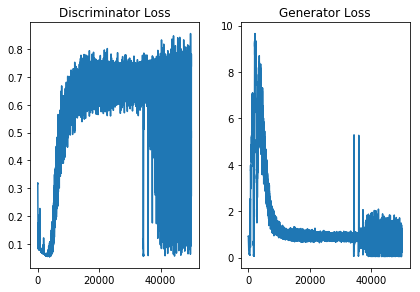

In [11]:
'''Plot discriminator and generator losses'''
figure,axis = plt.subplots(1,2)
plt.tight_layout()
axis[0].plot(discriminator_loss)
axis[0].set_title("Discriminator Loss")
axis[1].plot(generator_loss)
axis[1].set_title("Generator Loss")

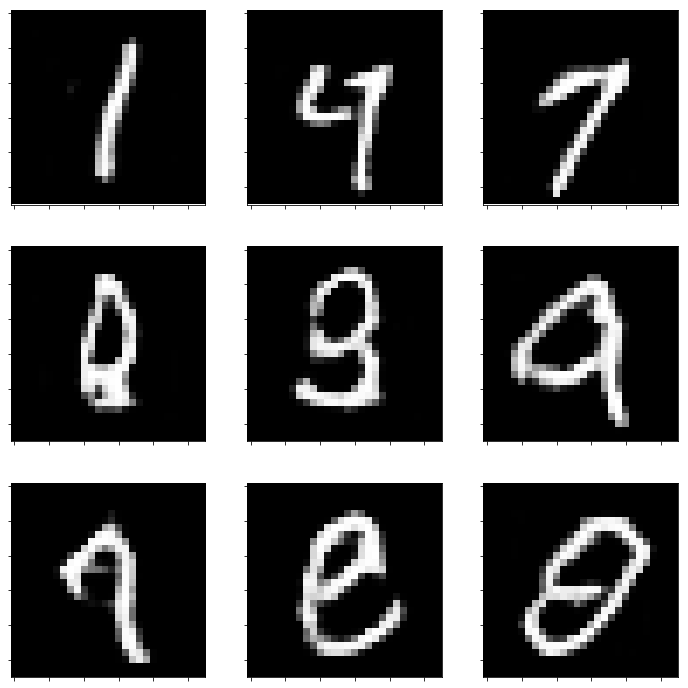

In [17]:
'''Generate images with our trained generator model'''
num_generated = 9
in_noise = np.random.rand(num_generated,100)
im = generator_model.predict(in_noise)
im = im[:,:,:,0]
figure,axis = plt.subplots(3,3,figsize=(10,10))
plt.tight_layout()
for i in range(3):
    for j in range(3):
        axis[i,j].imshow(im[i*3+j],cmap='gray')
        axis[i,j].set_yticklabels([])
        axis[i,j].set_xticklabels([])

In [18]:
'''Save weights and models'''
discriminator_model.save_weights('discriminator_deepmodel_weights.h5')
generator_model.save_weights('generator_deepmodel_weights.h5')
model.save_weights('gan_deepmodel_weights.h5')

discriminator_model.save('discriminator_deepmodel.h5')
generator_model.save('generator_deepmodel.h5')
model.save('gan_deepmodel.h5')